In [245]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.optimizers import RMSprop

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import matplotlib.pyplot as plt
import seaborn

import numpy as np
import scipy
import sys
import os
import string

# Importing and preprocessing data

For RNN learning, we only need to convert to lower-case and tokenize by character. 

In [37]:
with open(os.path.join('data','shakespeare.txt'), 'r') as infile:
    sonnets = []
    next(infile)
    sonnet = ""
    for line in infile:
        line = line.strip()
        if len(line) == 0:
            continue
        if line[0] in string.digits:
            sonnets.append(sonnet)
            sonnet = ""
            continue
        sonnet += line.lower() + "\n"

We'll need the set of all characters possible in a Shakespeare sonnet:

In [56]:
all_chars = list(set(''.join(sonnets)))
print(f"Characters in shakespeare sonnets:\n{''.join(all_chars)}")

Characters in shakespeare sonnets:
!i' puzc?vfnmdyr;l-w:,ah
txe.jsbqo(kg)


We'll need to convert these to and from numbers a lot. Here are some simple helper functions for that.

In [276]:
def char_to_num(char):
    return int(all_chars.index(char))

def num_to_char(num):
    return all_chars[num]

def num_tensor_to_string(tensor):
    int_tensor = tensor.long()
    return ''.join([num_to_char(s) for s in int_tensor])

It may be convenient to have this data available through a DataSet object

In [329]:
class SonnetDataset(Dataset):
    '''
    A Dataset that can return strings of length window_size, 
    drawn from all of the sonnets, skipping every skip-th 
    such window. 
    '''
    def __init__(self, sonnet_list, window_size = 40, skip = 0, transform = None):
        for s in sonnet_list:
            assert len(s) >= window_size
        self.sonnet_list = sonnet_list
        # This function counts how many samples can be 
        # drawn from a single sonnet.
        # The +0.6 is to round up when cast as an int.
        self.count_windows    = lambda s: int(0.6 + ((len(s)-1) - window_size + 1)/(skip + 1))
        self.sonnet_n_samples = [self.count_windows(sonnet) for sonnet in self.sonnet_list]
        self.size        = sum(self.sonnet_n_samples)
        self.window_size = window_size
        self.skip        = skip
        self.transform   = transform
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        # First figure out which sonnet to draw from.
        sonnet_num    = 0
        total_windows = 0
        while idx >= total_windows + self.sonnet_n_samples[sonnet_num]:
            total_windows += self.sonnet_n_samples[sonnet_num]
            sonnet_num += 1
        sub_idx = idx - total_windows
            
        # Draw from the sonnet.
        start_idx = sub_idx * (self.skip+1)
        stop_idx  = start_idx + self.window_size
        sample = self.sonnet_list[sonnet_num][start_idx:stop_idx]        
        sample = torch.tensor([char_to_num(c) for c in sample]).float()
        
        # The next character in the sonnet -- this is what the LSTM 
        # should predict.
        next_char = char_to_num(self.sonnet_list[sonnet_num][stop_idx])
        
        
#         shifted_sample = self.sonnet_list[sonnet_num][start_idx+1:stop_idx+1]
#         next_chars = torch.tensor([char_to_num(c) for c in shifted_sample])
        
        if self.transform:
            sample = self.transform(sample)
    
        return sample, next_char

It will also be useful to have a count of the number of times each character appears in the classification from this data:

In [332]:
sample_data = SonnetDataset(sonnets, window_size = 40, skip = 0)
char_counts = np.zeros(len(all_chars))
i = 0
for data, next_char in sample_data:
    char_counts[next_char] += 1
for i in range(len(char_counts)):
    print(f"'{all_chars[i]}' appears {char_counts[i]} times")

'!' appears 20.0 times
'i' appears 4337.0 times
''' appears 361.0 times
' ' appears 14200.0 times
'p' appears 943.0 times
'u' appears 2155.0 times
'z' appears 20.0 times
'c' appears 1244.0 times
'?' appears 90.0 times
'v' appears 848.0 times
'f' appears 1540.0 times
'n' appears 4229.0 times
'm' appears 1924.0 times
'd' appears 2599.0 times
'y' appears 1828.0 times
'r' appears 3910.0 times
';' appears 31.0 times
'l' appears 2869.0 times
'-' appears 78.0 times
'w' appears 1718.0 times
':' appears 160.0 times
',' appears 1785.0 times
'a' appears 4547.0 times
'h' appears 4666.0 times
'
' appears 2099.0 times
't' appears 6652.0 times
'x' appears 57.0 times
'e' appears 8598.0 times
'.' appears 394.0 times
'j' appears 64.0 times
's' appears 4642.0 times
'b' appears 1148.0 times
'q' appears 50.0 times
'o' appears 5267.0 times
'(' appears 42.0 times
'k' appears 513.0 times
'g' appears 1287.0 times
')' appears 43.0 times


# Train a LSTM model using Pytorch

There are a couple of different ways we can sample characters to generate a new sonnet:

In [426]:
def pick_char(output_weights, temperature = 1):
    """
    Picks a character using a frequency-weighted softmax probability
    distribution over characters.
    """
    temp_weights = np.log(output_weights) / temperature
    probabilities = torch.nn.functional.softmax(temp_weights, dim=2).data.numpy()
    return np.random.choice(np.array(all_chars), p=probabilities[0,0,:])
    

def most_probable_char(output_weights):
    """
    Picks the character with the highest probability.
    """
    return num_to_char(torch.argmax(output_weights))


Here's code to produce a new sonnet, given a 40-character seed. `generation_function` should be one of the two character-picking functions above.

In [427]:
def emmit_sonnet(model, generation_function, seed = None):
    with torch.no_grad():
        model.eval()
        if seed == None:
            next_input = "four score and seven years ago our fathe"
        else:
            next_input = seed
        output_sonnet = next_input
        line_count = 0
        hidden_state = None
        cell_state = None
        char_count = 0
        while line_count < 14 and char_count < 1e4:
            in_tensor = torch.tensor([[char_to_num(c) for c in next_input]]).float()
            next_char_weights, (hidden_state, cell_state) = model(in_tensor)
            next_char_weihts = next_char_weights[0,0,:]
            next_char = generation_function(next_char_weights)
            output_sonnet += next_char
            char_count += 1
            if next_char == "\n":
                line_count += 1
            next_input = next_input[1:] + next_char
    return output_sonnet

Here's the model. In brief, the RNN contains:

* An LSTM layer of width 200.
* A dropout layer
* A fully-connected linear layer to the output.

In [408]:
# Can't use LSTM with Sequential objects, so we'll have 
# to build this the hard way
class SimpleLSTM(torch.nn.Module):
    def __init__(self, n_features, n_hidden_states):
        super(SimpleLSTM, self).__init__()
        self.n_features = n_features
        self.n_hidden_states = n_hidden_states
        
        self.lstm = nn.LSTM(n_features, n_hidden_states)
        self.dropout = nn.Dropout(0.05)
        self.linear = nn.Linear(n_hidden_states, len(all_chars))
        self.softmax = nn.Softmax(dim = 2)
        
    def forward(self, input_sequence, input_states = None):
        '''
        Takes a tensor of shape (batch_size, window_size), where each
        element is the index of a character.
        '''
        batch_size, window_len = input_sequence.shape
        one_hot_input = torch.zeros((window_len, batch_size, len(all_chars)))
        input_as_ints = input_sequence.long()
        for batch_num in range(batch_size):
            for window_idx in range(window_len):
                one_hot_input[window_idx, batch_num, input_as_ints[batch_num, window_idx]] = 1
        if input_states and input_states[0] != None and input_states[1] != None:
            _, output_pair = self.lstm(one_hot_input, input_states)
        else:
            _, output_pair = self.lstm(one_hot_input)
        hidden_states, cell_states = output_pair
        dropped_hidden_states = self.dropout(hidden_states)
        linear_out = self.linear(dropped_hidden_states)
        return self.softmax(linear_out), output_pair

# Model
input_len       = 40
n_hidden_states = 200
model = SimpleLSTM(len(all_chars), n_hidden_states)

# Optimization settings
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(1 / char_counts))
optimizer = optim.RMSprop(model.parameters(), lr=1e-3) # Default learning rate is 1e-2

# Data
batch_size = 64
sonnet_dataset = SonnetDataset(sonnets, window_size = input_len, skip = 3)
sonnet_loader  = torch.utils.data.DataLoader(sonnet_dataset,
                                             batch_size = 64,
                                             shuffle = True)

Now train it. 50,000 is a LOT of training rounds -- can cut this short at any time.

NOTE: This block will save sample sonnets in a folder called `outputs` and will save model snapshots in a folder called `models`. There seems to be a bug in the way Pytorch saves and loads models, so don't expect the saved models to work very well -- it's just there for completeness. 

In [410]:
n_epochs = 50000
training_loss_history = -1*np.ones(n_epochs)
training_accuracy_history = -1*np.ones(n_epochs)
for epoch in range(n_epochs):
    print(f"Training epoch {epoch+1}/{n_epochs}", end="")
    train_total = 0
    train_correct = 0
    model.train()
    sample_emission = ""
    for i, data in enumerate(sonnet_loader):
        sample, next_char = data
        optimizer.zero_grad()
        # Forward pass
        output, output_pair = model(sample)
        # Check loss
        loss = criterion(output.permute(1,2,0)[:,:,0], next_char)
        # Backward pass
        loss.backward()
        optimizer.step()
        # Track training accuracy
        predicted = torch.argmax(output[0,:,:].data, 1)
        train_total += next_char.size(0)
        train_correct += (predicted == next_char).sum().item()
        # track training loss
        training_loss_history[epoch] += loss.item()
        # progress update after 180 batches (~1/10 epoch for batch size 32)
        if i % int(len(sonnet_loader)/10) == 0: print('.',end='')
    training_loss_history[epoch] /= len(sonnet_loader)
    training_accuracy_history[epoch] = train_correct / train_total
    print(f'\n\tloss: {training_loss_history[epoch]:0.4f}, acc: {training_accuracy_history[epoch]:0.4f}')
    print("End of epoch first-batch output weights:")
    print(output[0,0,:])
    print("End of epoch targets:")
    print(next_char)
    print("Best guess outputs:")
    print(torch.argmax(output[0,:,:], dim=1))
    with open(os.path.join('outputs', f'example_sonnet_epoch_{epoch+1}'), 'w') as outfile:
        outfile.write(f"Accuracy: {training_accuracy_history[epoch]}\n")
        outfile.write(f"Loss: {training_loss_history[epoch]}\n")
        outfile.write("Sonnet, max likelihood:\n")
        for seed in ["four score and seven years ago our fathe", 'how careful was i when i took my way,\nea']:
            outfile.write(emmit_sonnet(model, most_probable_char, seed))
            outfile.write("\n\n")
            for T in [0.3, 1, 3]:
                outfile.write(f"Sonnet, T = {T}:\n")
                outfile.write(emmit_sonnet(model, lambda m: pick_char(m, T), seed))
                outfile.write("\n\n")
    if epoch%100 == 0:
        torch.save(model.state_dict(), os.path.join('models',f'LSTM_epoch_{epoch+1}.pt'))

Training epoch 1/50000..........
	loss: 3.5916, acc: 0.1406
End of epoch first-batch output weights:
tensor([1.8098e-05, 7.4992e-04, 1.2782e-04, 4.0173e-03, 5.6837e-03, 5.0619e-04,
        9.4676e-06, 5.5039e-04, 3.9207e-05, 4.8203e-03, 6.1051e-04, 1.6244e-02,
        9.0505e-03, 1.7011e-03, 2.4288e-03, 3.4836e-04, 8.8127e-06, 7.3972e-04,
        6.0653e-05, 5.5570e-02, 2.0940e-05, 9.6437e-04, 3.8718e-03, 1.5949e-02,
        1.2981e-03, 1.8188e-03, 4.4778e-05, 7.1862e-03, 4.2726e-04, 8.7002e-06,
        2.5817e-03, 8.1155e-01, 1.4917e-05, 7.3587e-03, 8.2370e-06, 1.7609e-03,
        4.1799e-02, 5.5543e-05], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 27, 23, 19,  3, 33,  1, 21, 21, 19, 30, 25, 12,  3,  3,  3, 27,  5,
        13,  3, 33,  1, 23,  3, 25, 23, 10, 25, 27, 27,  3, 30,  3, 27, 24, 25,
         5, 17, 27, 23,  1, 30,  3,  3, 27, 23, 15,  3, 15, 17, 33,  1, 11,  9,
        27,  1, 15, 22,  3, 11, 25, 15,  1])
Best guess outputs:
tensor([31,  3, 36, 31,  3, 31, 31

Training epoch 8/50000..........
	loss: 3.4161, acc: 0.3106
End of epoch first-batch output weights:
tensor([5.1993e-09, 2.1071e-08, 1.0051e-03, 1.0092e-04, 3.0420e-04, 1.1141e-05,
        6.2561e-09, 1.1916e-05, 1.6131e-08, 7.6123e-05, 3.3098e-05, 1.0646e-02,
        7.2037e-05, 1.4164e-02, 2.2296e-05, 2.0242e-03, 1.4966e-09, 5.5563e-05,
        2.3310e-05, 2.2827e-03, 3.4184e-07, 4.1963e-03, 1.9728e-06, 6.4272e-04,
        6.8781e-05, 2.7349e-04, 1.0613e-05, 3.5501e-04, 2.8723e-02, 5.1082e-06,
        2.7573e-03, 4.6735e-02, 4.6027e-09, 2.9740e-05, 8.7101e-10, 1.0335e-02,
        8.7503e-01, 3.1045e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 25, 22, 21,  3,  3, 30, 27, 15,  9,  3,  3,  3, 22, 11,  3,  3, 27,
        30, 28, 30,  1, 17, 30,  5,  3,  3, 26,  3, 27, 27, 33, 27, 27,  3, 30,
        21, 13, 33, 27, 24, 22, 33, 15, 33,  1, 22, 11, 27,  7, 21, 23, 22, 24,
        27, 21,  4, 19, 15, 13, 13, 23, 33])
Best guess outputs:
tensor([36, 31, 19, 28, 27,  3, 35

Training epoch 15/50000..........
	loss: 3.3331, acc: 0.3577
End of epoch first-batch output weights:
tensor([3.6783e-07, 2.1374e-05, 3.5433e-02, 9.8815e-03, 4.5925e-04, 7.4088e-06,
        1.3460e-07, 5.2886e-05, 4.1714e-07, 7.3115e-06, 1.3565e-04, 9.6890e-08,
        2.3516e-04, 7.3628e-04, 1.9682e-04, 9.3016e-06, 1.4802e-07, 1.1412e-05,
        2.0164e-02, 7.5040e-03, 1.7718e-06, 1.0865e-03, 2.6081e-04, 2.5859e-03,
        5.9178e-05, 9.6599e-05, 2.1124e-04, 3.8613e-04, 2.2267e-02, 3.7704e-03,
        6.2766e-04, 3.2055e-03, 2.4535e-07, 8.8682e-01, 7.9777e-08, 3.2922e-05,
        3.7318e-03, 7.8410e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 27, 15, 12, 19, 30, 15, 17,  3,  3, 22, 30, 11, 25, 31,  3, 21, 14,
        24, 15, 36, 30, 24, 17, 12, 10, 25, 22, 30, 27, 33, 15, 17,  1, 15,  3,
        25,  1, 30, 36,  1,  3,  3, 12, 28,  3, 30,  3, 14,  1, 11,  3, 33, 22,
         1, 25, 27, 19,  5, 33,  5, 17, 22])
Best guess outputs:
tensor([33, 21, 33, 12, 31, 11,  

Training epoch 22/50000..........
	loss: 3.2848, acc: 0.4019
End of epoch first-batch output weights:
tensor([4.6811e-07, 2.0291e-06, 1.2344e-04, 1.5086e-02, 1.1836e-06, 3.2768e-04,
        1.0268e-07, 1.7635e-07, 1.8308e-06, 1.9798e-06, 3.6131e-06, 2.2910e-05,
        2.9056e-04, 9.7944e-07, 1.2364e-06, 5.9213e-04, 4.8383e-07, 1.3252e-07,
        1.2691e-02, 1.7312e-04, 2.1017e-05, 5.0037e-01, 5.3919e-05, 4.4135e-01,
        2.6670e-03, 1.2074e-06, 1.6015e-05, 5.2563e-04, 2.0290e-02, 1.3498e-06,
        4.8757e-03, 4.8534e-04, 2.4879e-07, 4.3621e-06, 7.1538e-08, 4.0647e-06,
        8.1179e-06, 1.3297e-07], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 12, 17,  3, 33,  3,  1, 23, 33, 27, 15, 19, 30, 15, 25, 10, 27, 15,
         2,  1, 27,  3,  3,  8, 30, 27, 23, 36, 25, 22, 10, 24,  3, 17,  5, 19,
        27,  3, 22, 15, 31, 25, 24, 33, 28, 13,  3,  3,  5, 30, 25, 30, 27,  3,
        11, 11,  3, 14, 13, 11, 27,  3,  7])
Best guess outputs:
tensor([21, 12, 17,  3, 27, 21, 2

Training epoch 29/50000..........
	loss: 3.2533, acc: 0.4416
End of epoch first-batch output weights:
tensor([3.3747e-12, 1.8362e-09, 1.3660e-07, 6.0856e-07, 6.1358e-09, 1.7172e-08,
        2.8193e-11, 1.2857e-05, 1.8538e-11, 1.1613e-03, 1.5395e-07, 2.8381e-09,
        8.0426e-11, 4.5957e-08, 1.5346e-08, 9.1387e-07, 1.4389e-11, 1.4972e-08,
        1.1975e-06, 1.4491e-05, 2.4332e-10, 7.9698e-07, 9.9877e-01, 1.6208e-07,
        2.2225e-10, 9.2900e-09, 5.9720e-06, 3.5925e-07, 4.2456e-08, 2.2502e-07,
        5.5676e-08, 2.8146e-09, 4.3299e-12, 3.4503e-05, 2.3050e-12, 1.8570e-07,
        6.8916e-10, 2.0702e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([12, 24,  7, 35, 17, 11, 27, 25,  3, 22, 11,  5, 25, 22,  3, 31, 33, 24,
         3, 23, 25, 33, 11, 15, 31, 22, 17, 19, 31, 11,  5, 25,  3,  3,  5, 30,
         9,  3, 33, 13, 33, 27, 33, 27,  4, 22, 33, 17, 15, 27, 30, 27,  3, 15,
         3,  1, 10, 21,  3,  4, 19,  3,  3])
Best guess outputs:
tensor([22, 24, 33, 35, 17, 11, 1

Training epoch 36/50000..........
	loss: 3.2263, acc: 0.4691
End of epoch first-batch output weights:
tensor([2.0142e-09, 3.7208e-06, 3.1010e-07, 2.6643e-05, 2.4235e-06, 8.2373e-08,
        7.0120e-10, 6.9351e-08, 5.1174e-10, 3.8278e-08, 2.4794e-09, 2.1937e-09,
        5.2987e-08, 1.8740e-05, 1.9421e-06, 8.1868e-08, 1.4643e-09, 2.0211e-07,
        9.6854e-08, 1.1891e-07, 2.0936e-09, 2.2194e-08, 9.9949e-01, 2.3627e-09,
        1.1420e-10, 1.9083e-05, 2.8929e-08, 3.9886e-04, 1.4493e-06, 1.3156e-08,
        1.5368e-06, 9.5378e-08, 1.3448e-10, 3.1649e-05, 1.5097e-10, 1.8130e-06,
        1.0620e-10, 2.7816e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 11, 25,  3, 15, 30, 36, 27,  1, 30, 27,  3, 27, 30, 21, 23, 27,  3,
        11, 30, 14, 25, 33, 13,  4,  3,  5, 27, 36, 33, 11, 23, 30, 22, 25, 29,
         3, 27, 33, 33, 30, 15, 25,  3, 22, 27, 25,  1,  4,  3,  5,  3, 27, 10,
        27, 14,  3, 30, 33, 15, 30, 27,  3])
Best guess outputs:
tensor([22, 22, 11,  3, 17,  4, 2

Training epoch 43/50000..........
	loss: 3.2103, acc: 0.4918
End of epoch first-batch output weights:
tensor([2.3095e-13, 2.5087e-13, 2.2494e-11, 9.9999e-01, 5.5510e-10, 1.2707e-12,
        1.9864e-14, 6.1555e-13, 1.5391e-12, 9.3191e-11, 2.4430e-11, 1.1006e-10,
        1.6789e-12, 2.7044e-12, 1.2277e-12, 2.7494e-13, 5.7333e-12, 1.9547e-11,
        1.6669e-10, 1.2936e-10, 7.1783e-10, 7.9508e-06, 1.9378e-09, 5.5491e-08,
        6.8072e-15, 1.0476e-11, 3.8952e-10, 6.2077e-07, 1.0175e-07, 1.4962e-10,
        4.1508e-08, 3.2663e-08, 1.3060e-13, 2.2938e-11, 5.1221e-15, 4.2028e-11,
        3.7638e-07, 2.3588e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 11, 13,  1, 33,  3, 27, 13,  5, 33, 23,  3, 27,  2, 23, 33, 27, 25,
        22,  3, 23, 30, 21, 11, 17,  1, 27, 35, 15,  3, 27,  7, 27, 21, 22,  3,
        33,  3, 30, 14,  5,  3, 12, 11, 31, 27, 17, 27, 13, 33, 25, 21, 27, 23,
        23,  3, 15, 23,  3, 27, 27, 25, 25])
Best guess outputs:
tensor([ 3, 11, 13, 33, 33, 22, 3

Training epoch 50/50000..........
	loss: 3.1905, acc: 0.5115
End of epoch first-batch output weights:
tensor([1.0610e-06, 6.8289e-10, 5.2242e-10, 2.1513e-06, 4.0625e-08, 1.4110e-05,
        6.5134e-09, 2.0323e-06, 7.1221e-12, 2.0890e-08, 1.8669e-08, 5.4101e-03,
        5.4044e-07, 4.2854e-03, 4.5464e-10, 1.6388e-08, 1.6132e-09, 3.7669e-03,
        5.0434e-07, 6.0054e-11, 9.0534e-08, 5.3889e-07, 1.5697e-12, 9.5539e-06,
        8.1849e-10, 3.9049e-08, 1.0557e-06, 7.9188e-05, 1.3864e-09, 3.7936e-07,
        1.4563e-07, 6.2642e-06, 6.1012e-10, 2.4597e-06, 1.0356e-09, 9.8640e-01,
        2.1013e-05, 1.6660e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 25, 27, 23,  3, 22, 27, 12, 27, 30,  1, 14, 21, 17,  4, 30, 19, 27,
        33, 27, 14, 22,  5, 21,  3, 25, 25, 23,  1, 25, 30, 15,  3, 33, 10, 35,
         3, 25,  3, 30, 30, 30, 23, 22, 24, 31, 27, 22, 19, 22,  3,  3, 31, 17,
        23, 12, 33,  1,  3,  3, 22, 27, 17])
Best guess outputs:
tensor([35, 11, 27, 23,  3, 27, 2

Training epoch 57/50000..........
	loss: 3.1774, acc: 0.5292
End of epoch first-batch output weights:
tensor([6.5194e-11, 2.6573e-05, 6.5827e-10, 6.4970e-11, 3.2072e-07, 4.8842e-10,
        9.5733e-13, 3.0031e-10, 1.0467e-11, 8.2220e-12, 7.3274e-09, 1.4392e-07,
        2.6869e-09, 5.6860e-11, 5.3238e-01, 1.4386e-07, 1.4284e-11, 2.1654e-10,
        2.3277e-10, 9.8909e-09, 3.3024e-10, 3.0820e-12, 2.2801e-09, 1.0110e-12,
        1.2024e-11, 3.3145e-09, 1.8025e-09, 4.6759e-01, 5.4674e-12, 1.0227e-08,
        5.4820e-08, 7.1638e-08, 5.2327e-11, 6.7548e-10, 3.6015e-11, 3.7221e-09,
        1.3714e-10, 8.1235e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 30,  3, 33, 27, 24, 27, 15, 19, 22,  3,  7, 17, 13, 30,  3, 30, 15,
        30, 12, 27, 25, 23, 36, 23,  4, 33, 27, 27, 22, 11, 25,  3, 27, 13,  3,
        33, 31,  3, 12, 17,  3,  1, 11, 10, 31, 13, 25, 21, 30, 30, 30, 13, 33,
         4, 33, 22,  3, 19, 27,  9, 33, 15])
Best guess outputs:
tensor([14, 30,  3, 23,  9, 24, 1

Training epoch 64/50000..........
	loss: 3.1583, acc: 0.5492
End of epoch first-batch output weights:
tensor([2.6546e-09, 2.1008e-08, 4.4114e-08, 8.0543e-02, 8.5278e-03, 1.9256e-07,
        5.4517e-09, 3.2171e-04, 1.7778e-08, 3.9893e-02, 3.9939e-08, 2.8309e-08,
        1.6139e-03, 9.4789e-09, 5.4015e-07, 9.0536e-09, 1.9219e-08, 2.7490e-03,
        8.1187e-06, 5.3359e-01, 4.0529e-07, 4.7702e-08, 2.1036e-06, 3.3126e-01,
        2.3186e-09, 1.4345e-03, 3.4972e-06, 4.1484e-07, 1.9722e-06, 5.9186e-06,
        2.9275e-08, 2.6706e-05, 2.5483e-06, 5.6353e-08, 1.2945e-08, 1.3327e-05,
        8.6226e-07, 1.6109e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 30,  1, 15,  1, 31, 30,  1, 23, 27, 25,  3,  3, 13, 22, 33, 23, 14,
         3, 12, 27, 17, 30, 22, 25, 22, 29, 11,  3,  5, 31,  1, 19, 30,  1, 10,
        33, 25, 30, 10, 33, 23, 31, 15, 11, 17, 10, 33, 19,  3, 33, 27, 10, 27,
        27, 28, 30, 27, 14, 22, 22, 21, 27])
Best guess outputs:
tensor([19,  5, 27, 15, 23, 31, 1

Training epoch 71/50000..........
	loss: 3.1392, acc: 0.5676
End of epoch first-batch output weights:
tensor([4.7425e-10, 2.5506e-06, 1.9930e-05, 2.5419e-08, 4.9003e-04, 8.2292e-05,
        1.8091e-09, 3.6876e-06, 6.4121e-09, 3.2910e-07, 1.5421e-07, 5.0542e-06,
        9.9421e-01, 1.6655e-07, 1.2997e-06, 2.1603e-06, 1.2597e-10, 2.3326e-06,
        5.0086e-08, 3.2826e-05, 1.3750e-09, 1.1047e-09, 5.6937e-09, 3.0513e-06,
        2.3027e-09, 4.7100e-03, 1.3663e-08, 6.9338e-09, 3.2936e-08, 6.2219e-10,
        4.2692e-04, 1.8196e-07, 2.3359e-07, 1.6617e-06, 1.6409e-09, 4.0484e-07,
        7.3716e-08, 6.0790e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([12, 27, 27, 12, 27,  1,  2, 17, 27, 11,  7,  3,  1, 25, 21,  3, 11,  5,
        36,  3, 33, 30, 30, 15, 31, 25, 15, 15, 12,  4, 23, 21,  3,  9, 10,  9,
         2, 19,  3,  7, 13, 25, 21,  5, 22, 11, 23,  1, 15, 24,  1, 25, 27, 27,
        15,  1, 27,  4, 14, 15, 27, 17, 27])
Best guess outputs:
tensor([12, 27, 33, 12, 27, 27, 1

Training epoch 78/50000..........
	loss: 3.1265, acc: 0.5739
End of epoch first-batch output weights:
tensor([3.6234e-10, 5.8616e-07, 1.8826e-06, 3.6783e-09, 7.0219e-06, 2.9971e-09,
        7.7997e-10, 7.8574e-08, 2.1065e-07, 6.4487e-09, 6.1642e-07, 1.0493e-11,
        2.3417e-12, 6.7769e-10, 2.8790e-07, 3.4836e-10, 1.4882e-10, 1.5973e-10,
        4.9591e-07, 7.6068e-07, 1.1541e-07, 1.6011e-09, 4.1871e-06, 9.9656e-01,
        8.6607e-08, 4.6958e-12, 3.5127e-08, 2.1484e-08, 1.5163e-05, 2.6897e-07,
        6.5882e-10, 2.8119e-07, 1.4432e-10, 3.4075e-03, 3.3994e-10, 7.4350e-08,
        8.1658e-09, 2.5405e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 27,  1,  1, 27,  3, 30, 25, 23, 11, 24, 25, 24, 23,  3,  4,  1, 36,
        22, 21, 33, 11, 25, 10, 27, 14,  1, 27,  1,  9, 33, 11, 25, 28, 27,  1,
         3, 19,  3, 19,  1, 33, 25, 22, 30, 35, 31,  3,  4,  3,  3,  3, 10, 27,
         3,  3, 15,  5,  3, 27, 27, 23, 15])
Best guess outputs:
tensor([23, 27, 25,  1, 22,  3,  

Training epoch 85/50000..........
	loss: 3.1134, acc: 0.5901
End of epoch first-batch output weights:
tensor([4.2359e-11, 5.7944e-04, 2.8877e-06, 1.3668e-09, 1.7966e-11, 6.3073e-10,
        3.3190e-09, 4.0893e-06, 7.7200e-11, 4.3310e-06, 1.5100e-05, 9.9923e-01,
        1.0988e-06, 3.3644e-09, 2.1506e-10, 4.9402e-11, 5.0701e-12, 5.4453e-06,
        7.5485e-08, 1.8591e-10, 2.9963e-11, 2.5549e-10, 5.9724e-09, 1.1824e-06,
        7.4571e-11, 2.2872e-10, 3.5957e-05, 1.8560e-06, 1.9283e-11, 3.7298e-12,
        1.2115e-04, 7.3463e-10, 3.5913e-08, 9.6807e-07, 2.3835e-10, 6.3803e-07,
        4.8093e-08, 8.5825e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 23, 14, 27, 25, 25,  5,  3, 25, 22,  3, 19,  3, 25, 13, 17,  3, 28,
        27, 31, 13, 19, 25, 31, 15, 25, 25, 28, 30,  3, 22,  3,  3,  9, 15,  3,
         3, 23,  3, 33, 28, 33,  5, 35,  9, 14, 25, 30,  1,  3, 23, 30, 15,  3,
        20, 17, 22, 17,  3, 33, 17, 13,  3])
Best guess outputs:
tensor([11, 23, 11, 25, 25, 11,  

Training epoch 92/50000..........
	loss: 3.0988, acc: 0.6003
End of epoch first-batch output weights:
tensor([3.5625e-11, 1.2638e-04, 1.2934e-08, 5.3039e-13, 2.0351e-09, 7.9781e-08,
        1.7093e-09, 2.4601e-09, 2.1148e-10, 4.6117e-13, 1.6498e-06, 2.7164e-09,
        9.7576e-11, 1.4105e-10, 4.7140e-08, 2.1840e-10, 2.4011e-11, 1.9737e-11,
        1.1475e-08, 1.5887e-10, 3.3730e-09, 4.1967e-11, 9.4139e-05, 1.3788e-01,
        1.6908e-09, 6.2280e-14, 1.1005e-09, 7.7213e-06, 4.5051e-06, 2.6305e-08,
        9.9763e-11, 1.0899e-07, 1.8228e-13, 8.6188e-01, 5.9650e-11, 6.4115e-10,
        2.9054e-11, 8.2801e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 27,  1,  3,  1, 15,  5, 17, 19, 13, 15, 30,  3, 11, 33,  3,  3, 15,
        17, 27, 13,  3,  3, 25, 33, 23,  1, 17,  3, 19,  1, 19, 17, 27, 35, 25,
         4, 25, 24, 25, 23, 33, 15, 35, 30, 27,  5, 17, 14,  3, 27, 30,  1, 11,
        25, 11, 33, 11,  1, 23, 15, 22, 25])
Best guess outputs:
tensor([33,  3,  1,  3, 15, 15,  

Training epoch 99/50000..........
	loss: 3.0904, acc: 0.6160
End of epoch first-batch output weights:
tensor([4.0778e-08, 7.3687e-12, 9.4278e-09, 9.8695e-01, 2.2503e-07, 2.9927e-07,
        3.7335e-09, 1.6427e-06, 3.6699e-10, 3.1192e-05, 1.8074e-09, 1.5500e-11,
        4.9619e-09, 1.0721e-04, 3.1058e-09, 1.2437e-08, 1.1982e-08, 4.9377e-09,
        3.1141e-06, 7.8066e-05, 1.0645e-09, 2.1545e-09, 4.2796e-08, 4.3161e-08,
        1.2962e-08, 1.2300e-02, 9.0544e-08, 7.1276e-11, 1.4685e-06, 6.6498e-06,
        2.6578e-10, 1.2570e-10, 9.1569e-09, 4.6963e-04, 9.1376e-11, 5.5034e-06,
        4.2342e-05, 5.7092e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 27, 24, 25, 17, 11, 19,  3, 14, 30,  3, 23, 33,  3, 14, 17,  3, 33,
        15,  1, 14, 13, 15, 17,  3,  3, 11, 11, 30,  3, 15,  3, 33,  3, 27, 13,
        11, 14, 19, 25, 12, 27,  5, 14,  1,  3, 22, 30, 17, 25,  1, 17, 30, 27,
        30, 15, 36, 27, 27, 25, 27, 14, 17])
Best guess outputs:
tensor([ 3, 27, 24, 31, 27, 11, 2

Training epoch 106/50000..........
	loss: 3.0830, acc: 0.6218
End of epoch first-batch output weights:
tensor([3.6326e-12, 1.9033e-03, 1.6846e-10, 6.9628e-09, 1.3394e-13, 2.6983e-12,
        4.3348e-11, 8.5139e-13, 4.9105e-13, 1.3296e-13, 2.1434e-08, 1.8130e-09,
        3.6663e-12, 3.0774e-14, 3.1008e-14, 2.6941e-08, 8.9327e-14, 1.8508e-15,
        8.6066e-07, 1.2844e-15, 6.6105e-10, 1.6840e-06, 4.6211e-06, 8.1682e-06,
        2.3202e-09, 1.8831e-12, 3.9960e-09, 2.4632e-04, 2.4515e-10, 1.1626e-12,
        1.6871e-15, 6.4028e-08, 1.6634e-15, 9.9784e-01, 1.6621e-09, 5.1416e-10,
        1.0197e-09, 1.7201e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 11, 12,  3, 10,  3, 11, 22,  3, 14, 25,  3, 11,  5, 15, 33, 23, 11,
         7, 30, 24, 25,  1,  4, 33, 36, 23,  3, 27, 36, 17, 24, 33, 23, 20,  1,
        11, 30, 27,  1, 27,  1, 25, 17,  3,  3,  1, 14, 25, 12, 23, 27, 27, 22,
        11, 33,  3, 37, 27,  5, 17, 36, 33])
Best guess outputs:
tensor([33, 11, 31,  3, 10,  3, 

Training epoch 113/50000..........
	loss: 3.0734, acc: 0.6306
End of epoch first-batch output weights:
tensor([6.2775e-09, 1.2139e-04, 3.9929e-08, 1.3389e-08, 4.0462e-08, 7.3949e-08,
        2.6944e-08, 1.3232e-06, 1.1921e-09, 1.1062e-08, 3.3430e-06, 2.6943e-06,
        2.3104e-06, 6.3784e-06, 2.7756e-08, 1.0768e-06, 7.4540e-08, 1.1764e-06,
        2.7097e-07, 1.0929e-07, 1.8469e-05, 5.3032e-05, 3.8215e-06, 3.5517e-07,
        7.3770e-06, 9.9552e-01, 5.6866e-08, 8.8141e-07, 5.5167e-06, 4.1008e-08,
        4.0988e-06, 4.2415e-03, 1.5694e-10, 3.2034e-07, 1.7109e-08, 6.1375e-07,
        1.1642e-06, 1.4235e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([36,  3, 36, 33, 25,  1, 31, 15, 27, 11,  3, 33, 14, 17, 33, 25, 12,  3,
        15, 12,  5, 25,  3,  3, 33, 27,  3, 11, 14, 35, 36, 25,  3,  1, 33,  3,
        14, 21, 30, 21, 33, 20,  3, 25,  1, 31, 23, 25, 27, 27, 33,  1, 24,  3,
        27,  3,  3, 27, 21, 22, 23, 35, 27])
Best guess outputs:
tensor([25,  3, 36, 33,  5,  4, 

Training epoch 120/50000..........
	loss: 3.0674, acc: 0.6333
End of epoch first-batch output weights:
tensor([6.4079e-09, 4.0646e-04, 3.4090e-06, 9.1095e-07, 2.2118e-05, 1.6646e-06,
        1.1161e-06, 2.1085e-08, 3.6645e-07, 6.9769e-11, 2.5266e-09, 4.1750e-10,
        4.0411e-07, 5.0392e-09, 2.5304e-06, 9.3185e-08, 2.6221e-10, 6.1948e-08,
        4.5890e-09, 8.3029e-11, 5.7268e-07, 1.1470e-09, 1.4105e-02, 1.0598e-08,
        2.9028e-10, 7.0618e-09, 6.7869e-11, 9.8067e-01, 7.6805e-06, 1.6010e-07,
        2.0690e-06, 2.1693e-07, 3.2648e-11, 4.0420e-03, 3.9710e-08, 7.3335e-04,
        2.0691e-10, 4.3456e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([14, 15,  1,  5,  3, 33,  3, 10, 27,  3, 15,  1,  3,  9,  3, 15,  1,  5,
         3, 19, 19, 36, 25, 25,  1,  3,  3,  3,  3, 24, 11, 21, 31,  3, 24, 27,
        27, 13,  3, 19,  1,  3, 25, 33, 10,  5, 27,  1, 30, 27,  3,  3,  1, 22,
        15,  3, 23,  3,  4,  3, 25, 15, 26])
Best guess outputs:
tensor([27, 10,  9, 33,  3, 31, 

Training epoch 127/50000..........
	loss: 3.0556, acc: 0.6441
End of epoch first-batch output weights:
tensor([6.4271e-07, 6.4916e-05, 5.8365e-04, 1.1948e-03, 7.5898e-09, 2.1155e-04,
        3.5316e-08, 3.9628e-07, 6.6312e-05, 1.9272e-06, 4.1610e-09, 6.8736e-08,
        5.1903e-09, 3.1174e-09, 6.4243e-06, 2.6500e-10, 4.5206e-08, 4.9181e-08,
        1.0922e-05, 9.1794e-13, 2.8562e-09, 8.4293e-08, 3.8039e-07, 1.2299e-10,
        6.3447e-10, 5.4429e-08, 1.5033e-08, 9.9752e-01, 5.0817e-09, 5.4500e-07,
        2.8324e-04, 3.3643e-08, 2.2253e-07, 5.5409e-05, 9.7089e-10, 1.6818e-07,
        9.5210e-09, 2.0154e-07], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 27,  5,  3, 10, 33, 12,  1, 15,  3, 15, 27, 24, 25,  3, 27, 25, 36,
         3,  7,  3, 11, 30, 15, 33, 22, 13, 27, 22,  3, 13,  3,  3, 33, 23, 33,
        17,  3, 10, 36, 12,  3, 11, 11, 25, 30, 15, 33, 28,  1, 33,  3,  3, 12,
        24,  3, 25,  3, 25, 27, 13, 23,  3])
Best guess outputs:
tensor([27, 25,  5,  3, 25, 17, 

Training epoch 134/50000..........
	loss: 3.0537, acc: 0.6488
End of epoch first-batch output weights:
tensor([1.5038e-07, 1.0579e-11, 4.6385e-07, 2.5970e-07, 2.5172e-02, 3.1172e-01,
        2.7959e-04, 1.7596e-08, 5.1577e-07, 1.3103e-05, 7.7109e-06, 1.1190e-07,
        1.5691e-06, 2.0347e-11, 4.3272e-07, 2.7269e-03, 7.3587e-08, 8.7351e-05,
        9.6785e-07, 1.2260e-05, 1.3398e-06, 1.8065e-03, 6.4732e-01, 2.0251e-05,
        1.3066e-08, 1.5985e-04, 1.2013e-06, 1.3349e-05, 5.4140e-06, 3.6233e-06,
        1.4230e-06, 2.5220e-03, 1.3033e-05, 2.4037e-07, 5.8429e-08, 8.1102e-03,
        5.4053e-06, 2.7287e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11, 17, 24, 25, 19, 15,  3, 23,  3,  3, 25,  1,  3, 27,  3,  3, 22,  3,
         3, 11,  3,  9, 23,  3, 17, 25,  2, 13,  1, 36, 23, 33, 30,  3, 30, 23,
        30, 15,  7, 27,  3, 33, 22, 22,  3, 23, 27, 17, 27,  3, 24,  3, 27, 25,
        31, 15, 23, 11, 22, 11,  3, 15,  3])
Best guess outputs:
tensor([22, 31, 21, 11, 19, 15, 

Training epoch 141/50000..........
	loss: 3.0467, acc: 0.6572
End of epoch first-batch output weights:
tensor([6.0532e-12, 6.1191e-10, 8.6046e-09, 2.8753e-15, 4.9823e-13, 2.9351e-08,
        1.5244e-13, 7.1431e-11, 2.8598e-10, 7.4587e-11, 2.1520e-07, 1.0000e+00,
        9.3079e-13, 1.8888e-11, 2.3532e-07, 2.4853e-07, 5.3357e-11, 1.0054e-06,
        1.0503e-11, 2.0589e-13, 1.1918e-14, 3.3616e-14, 5.5013e-12, 1.5808e-12,
        1.3152e-09, 4.5363e-11, 6.5325e-12, 1.1693e-09, 1.6022e-12, 2.5954e-13,
        3.3935e-10, 3.1485e-09, 2.4848e-10, 3.7073e-10, 1.1797e-10, 1.9649e-07,
        3.7607e-11, 9.4365e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([12, 36,  4, 11, 27, 27,  7, 19, 27,  3, 22, 36, 24, 27, 23, 33, 30,  7,
        11, 30, 25, 27,  9,  1, 15, 31,  4,  3, 30, 30, 30, 15,  5, 27, 27,  3,
        10, 19, 19, 12, 15,  1, 30, 22, 21, 17,  1, 27, 19,  3, 33, 36, 25, 14,
        36, 30, 30,  3, 30, 22, 13, 36, 21])
Best guess outputs:
tensor([11, 31,  4, 19,  3, 23, 

Training epoch 148/50000..........
	loss: 3.0414, acc: 0.6628
End of epoch first-batch output weights:
tensor([4.8969e-08, 9.4886e-12, 1.6432e-08, 1.2609e-08, 1.2843e-11, 1.0032e-08,
        3.0374e-11, 2.2737e-10, 8.7171e-10, 3.5215e-11, 1.9659e-08, 3.2716e-11,
        1.4379e-11, 1.4929e-05, 1.7133e-12, 1.7699e-07, 5.1615e-10, 9.6567e-08,
        3.9119e-09, 2.4272e-06, 2.0474e-11, 1.7660e-15, 4.7523e-17, 2.1626e-10,
        1.6273e-10, 9.9998e-01, 8.3262e-11, 1.3436e-11, 3.7040e-08, 6.0854e-11,
        5.9969e-13, 5.3173e-12, 1.3160e-11, 9.6648e-07, 4.2539e-11, 2.6494e-08,
        1.2722e-08, 1.9369e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 27, 17, 13, 11,  4, 25, 33, 23,  3, 25,  1,  3, 25, 25, 27,  3, 23,
         3, 23, 22, 23,  3, 23, 17,  3, 24, 25, 22, 25, 30,  3,  3, 19, 27, 27,
         3, 25, 30, 27, 27, 12, 23, 15, 33, 33, 11, 14,  1,  5,  3, 33, 27,  5,
         1,  3, 23, 27,  1, 23,  1,  3, 27])
Best guess outputs:
tensor([25, 27, 17,  3, 11, 11, 

Training epoch 155/50000..........
	loss: 3.0377, acc: 0.6663
End of epoch first-batch output weights:
tensor([3.9356e-10, 2.2450e-11, 1.8102e-10, 8.8948e-09, 5.9562e-08, 1.1693e-10,
        5.3462e-13, 1.5176e-12, 3.6861e-11, 1.6559e-11, 1.0037e-10, 1.5178e-11,
        1.2587e-06, 1.1811e-11, 2.1541e-07, 1.4465e-11, 6.0424e-12, 1.9822e-06,
        5.7855e-10, 8.8798e-13, 3.0892e-08, 2.4521e-11, 2.7331e-09, 1.9145e-10,
        6.0325e-14, 1.1106e-07, 3.8833e-11, 1.0000e+00, 3.7497e-12, 2.7882e-10,
        3.4540e-09, 9.3071e-10, 5.2017e-13, 2.5190e-14, 1.0509e-13, 1.7188e-08,
        1.4252e-12, 4.7250e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 22,  3,  3, 27, 15,  7, 11, 27,  7,  4,  3, 25, 23, 23,  3, 30, 19,
        22, 21, 27,  3, 27, 19, 30,  3,  3, 23, 20, 24, 23, 27,  3, 19, 15,  3,
        11,  3,  5, 23, 33, 24, 22, 27, 25, 15,  3, 33, 12, 14, 36, 25, 27, 27,
        30, 21, 27,  3,  3, 25, 10,  3,  5])
Best guess outputs:
tensor([27, 22,  3,  3, 27, 27, 

Training epoch 162/50000..........
	loss: 3.0331, acc: 0.6747
End of epoch first-batch output weights:
tensor([3.2504e-06, 1.8388e-06, 1.9854e-08, 2.7288e-07, 2.5925e-10, 4.3682e-06,
        5.4965e-07, 4.4619e-09, 2.0282e-07, 6.1925e-09, 5.8866e-10, 6.0197e-13,
        5.3570e-07, 2.5475e-10, 5.3726e-09, 4.6112e-16, 1.1112e-07, 3.1217e-12,
        3.0333e-10, 3.8072e-13, 6.1095e-07, 7.9060e-07, 1.2270e-12, 6.7151e-12,
        9.7058e-01, 3.3770e-09, 7.8297e-11, 2.9192e-02, 8.3263e-10, 4.5037e-08,
        3.1740e-07, 3.0147e-11, 2.3017e-06, 2.0956e-04, 9.9716e-12, 2.3241e-10,
        1.1963e-07, 2.6905e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24,  3,  3, 15,  4, 10, 11, 33, 33, 25, 27, 30, 17, 12,  5, 33, 23, 27,
        11, 17, 22, 11, 30, 14, 25,  3, 33, 24, 23,  3,  3, 33,  9, 30, 25, 30,
        25,  5,  3, 27, 14, 33, 30, 33, 22, 27, 25, 22,  3, 12,  3, 36, 25, 27,
        11,  7,  3,  3, 33, 15, 17,  5, 11])
Best guess outputs:
tensor([24,  3,  3, 15, 11,  9, 

Training epoch 169/50000..........
	loss: 3.0202, acc: 0.6831
End of epoch first-batch output weights:
tensor([3.5570e-12, 4.7588e-11, 1.5266e-11, 2.0581e-06, 3.3518e-11, 1.5486e-08,
        4.1779e-14, 5.2977e-11, 1.9399e-12, 1.1797e-13, 1.0358e-10, 5.6829e-14,
        9.9733e-13, 9.2188e-12, 3.6753e-09, 4.2362e-09, 2.1485e-13, 3.5868e-15,
        1.5475e-10, 1.9289e-07, 2.1522e-13, 1.9354e-11, 8.7598e-10, 5.6330e-11,
        7.1095e-13, 5.8643e-14, 1.5167e-11, 6.7517e-11, 4.6150e-08, 6.4837e-10,
        4.7397e-10, 1.6038e-15, 1.0970e-15, 1.0000e+00, 1.5810e-10, 4.9126e-11,
        7.5581e-09, 1.4012e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 15, 22, 12, 23, 17,  3,  3, 27,  1, 23,  1, 13, 27,  7, 14,  3,  3,
        11, 22, 35,  3, 19, 25, 27, 27,  1, 17, 25, 15,  3, 10, 33, 30, 22, 23,
        17, 10, 15, 13,  1, 19,  1, 19, 22, 17, 21, 30,  3, 15, 27, 25,  3, 25,
        23, 33, 22, 23,  7, 30, 11, 27, 25])
Best guess outputs:
tensor([33, 15, 22, 12, 23,  4, 

Training epoch 176/50000..........
	loss: 3.0196, acc: 0.6875
End of epoch first-batch output weights:
tensor([5.1796e-11, 4.2626e-07, 1.9678e-09, 1.5126e-07, 1.9993e-07, 3.6970e-11,
        1.5552e-12, 4.6018e-09, 1.0546e-08, 8.4530e-12, 6.6311e-13, 6.5459e-11,
        5.5315e-08, 4.5154e-06, 6.4563e-10, 5.8565e-09, 2.8405e-11, 9.6484e-11,
        1.1381e-10, 1.0227e-11, 2.2161e-08, 2.3824e-12, 8.1467e-10, 2.2331e-10,
        6.9365e-12, 6.1297e-12, 4.9973e-11, 9.9999e-01, 1.0297e-07, 3.7509e-09,
        4.5122e-10, 7.0350e-11, 1.5433e-14, 9.0173e-08, 3.7098e-11, 8.0943e-07,
        6.0203e-11, 5.1918e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3, 25, 11, 27, 10, 27, 21, 19, 23, 33, 22, 15, 15, 22, 27, 17, 22,
        23, 10, 22, 30, 30,  3,  3, 15,  3,  1, 19, 24, 22,  7,  3,  9,  3, 33,
        25, 22, 24,  3, 21, 11,  7,  1, 23, 11, 24,  3, 27,  3, 27,  3, 21,  3,
        14,  3, 11, 23, 30,  3,  3, 17, 25])
Best guess outputs:
tensor([27,  3, 12, 11, 19, 30, 

Training epoch 183/50000..........
	loss: 3.0161, acc: 0.6891
End of epoch first-batch output weights:
tensor([1.0217e-05, 4.6224e-04, 3.4338e-02, 1.8118e-02, 1.4071e-08, 1.9912e-04,
        4.2090e-09, 1.9702e-10, 3.4725e-07, 1.6465e-07, 2.6933e-07, 2.5602e-09,
        9.8539e-06, 9.4626e-01, 1.6052e-09, 1.0095e-04, 6.7776e-10, 9.9632e-07,
        3.4422e-06, 5.3540e-09, 1.1710e-07, 2.0413e-07, 3.6742e-12, 9.1479e-06,
        5.2799e-12, 3.1762e-04, 2.2087e-09, 4.3273e-05, 7.0217e-09, 2.5443e-09,
        4.6813e-05, 5.8342e-08, 1.5715e-10, 2.5988e-12, 4.4833e-06, 7.7514e-05,
        4.3513e-08, 2.4942e-06], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 15, 33,  3, 33, 33,  3, 25, 25,  3, 27, 17,  1, 17, 28, 17, 30, 22,
        33,  3,  3, 27, 19, 22,  3,  3,  3, 23,  9,  3, 28, 23, 23, 15,  3, 27,
        23, 22, 10, 11, 12, 14, 27, 22, 30, 33,  3, 25, 24, 12, 27, 14, 25, 11,
        25, 30, 30, 33, 33, 10,  4, 17, 15])
Best guess outputs:
tensor([13, 15, 23,  3, 33, 23, 

Training epoch 190/50000..........
	loss: 3.0087, acc: 0.6964
End of epoch first-batch output weights:
tensor([1.5767e-08, 1.3740e-03, 1.6516e-08, 4.1902e-04, 1.6933e-02, 2.6303e-07,
        5.2117e-12, 3.6138e-07, 5.2727e-07, 1.7886e-12, 5.4559e-09, 1.3314e-18,
        1.2606e-04, 1.4636e-06, 7.9188e-10, 4.2070e-09, 1.2751e-10, 3.1528e-07,
        1.2575e-06, 8.4798e-09, 8.4478e-09, 1.7864e-03, 2.1218e-05, 5.7036e-11,
        2.9644e-07, 7.4475e-03, 5.6117e-09, 1.0469e-02, 1.4859e-06, 4.0304e-07,
        2.4030e-08, 1.7572e-10, 5.1918e-11, 9.6142e-01, 3.6766e-11, 1.1079e-10,
        4.0911e-14, 5.4233e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5,  1,  3, 15, 13, 11, 30,  3, 25, 30, 11,  1,  3, 33, 19, 15, 13, 22,
        27,  3,  1,  3, 22, 19, 11,  5, 25,  2, 33, 33,  5,  3, 30,  5, 23, 15,
        33, 15, 22, 33,  1,  1, 15, 10, 33,  3, 27, 23, 31, 23,  5, 27, 13, 17,
        14, 30,  3, 23, 33, 30,  9, 15, 13])
Best guess outputs:
tensor([33,  1,  3,  7, 11, 19, 

Training epoch 197/50000..........
	loss: 3.0047, acc: 0.7022
End of epoch first-batch output weights:
tensor([1.1720e-08, 2.9552e-03, 6.5799e-09, 1.6008e-11, 6.2380e-06, 9.4245e-08,
        3.8423e-08, 1.2600e-05, 3.2538e-10, 1.7412e-07, 2.7113e-06, 6.5351e-08,
        9.8977e-01, 4.4368e-11, 7.2826e-07, 1.7045e-12, 2.7782e-10, 1.0780e-07,
        2.0533e-08, 3.4364e-05, 4.5112e-09, 5.7648e-09, 2.6368e-03, 5.9114e-08,
        8.0806e-07, 3.6054e-03, 1.3058e-09, 2.9071e-09, 8.7214e-08, 5.1541e-09,
        9.6253e-04, 3.4356e-07, 1.0183e-07, 9.5774e-06, 1.6904e-08, 6.3371e-09,
        3.4564e-09, 5.3948e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([36, 31, 30, 27, 15,  1, 27, 14, 30,  3, 33, 25,  7, 21,  4,  4,  3,  7,
        11, 10, 19, 25,  1,  3, 24, 22,  1, 25,  7, 33, 30, 22, 30, 15, 14, 30,
        19,  1,  3,  5, 30, 25, 19, 30, 13, 12, 25, 33, 31,  3, 21, 27, 25, 11,
        27, 14, 25,  3, 27, 12, 25,  1, 25])
Best guess outputs:
tensor([12, 11, 11, 27, 11,  1, 

Training epoch 204/50000..........
	loss: 2.9993, acc: 0.7077
End of epoch first-batch output weights:
tensor([8.4810e-11, 4.8224e-19, 2.6037e-07, 9.9881e-01, 3.5121e-05, 6.2946e-15,
        2.6370e-11, 6.2371e-09, 9.3340e-09, 3.0045e-08, 5.3103e-12, 1.2946e-10,
        1.8585e-07, 4.2927e-04, 1.3484e-12, 5.7588e-09, 2.5209e-11, 8.2120e-07,
        6.4874e-11, 2.6425e-11, 4.2782e-08, 2.7284e-05, 6.4970e-04, 2.7570e-10,
        3.7713e-11, 2.7636e-07, 1.1521e-07, 2.0586e-10, 4.2218e-05, 5.5821e-08,
        2.7224e-09, 1.3648e-09, 1.7200e-09, 1.9112e-11, 1.0728e-10, 1.0762e-09,
        5.6041e-12, 8.7451e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 33, 10, 19, 19,  3, 19, 23,  3, 35, 13, 22,  5, 27, 11, 22, 22,  1,
        25, 35,  3, 30, 36, 27, 13,  5, 11, 24,  3,  3, 33, 12,  3, 25, 30,  1,
        22,  3, 22, 24, 30,  5, 27, 30, 36, 25, 17, 27,  3, 30, 23, 27, 33, 23,
        31, 28,  1,  3,  1,  1,  3, 13, 22])
Best guess outputs:
tensor([ 3, 23,  4, 19, 19,  3, 

Training epoch 211/50000..........
	loss: 2.9973, acc: 0.7115
End of epoch first-batch output weights:
tensor([1.6207e-09, 9.8207e-07, 5.8480e-09, 1.0475e-12, 1.4107e-10, 1.1316e-13,
        8.1151e-12, 5.6125e-06, 4.3479e-11, 3.6682e-11, 1.9319e-08, 1.1721e-08,
        2.7098e-05, 3.2685e-07, 5.5199e-08, 4.0195e-10, 3.5307e-11, 1.2261e-04,
        2.3360e-13, 3.4343e-07, 2.1751e-08, 4.7455e-09, 5.2002e-06, 1.4711e-09,
        9.0499e-09, 9.9982e-01, 2.9304e-09, 7.1203e-10, 3.7612e-11, 1.4915e-09,
        2.9337e-06, 4.2905e-08, 3.1101e-11, 8.0140e-11, 5.6438e-11, 1.0719e-09,
        1.2721e-05, 3.3835e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 31, 23, 23, 10, 25, 24,  3, 22, 15, 22, 27, 11, 30, 22, 27, 30, 23,
        10, 15, 19, 22,  9,  3, 25, 31, 15,  1,  3, 23, 33, 33, 15, 22, 27, 13,
         3,  3,  3,  3, 30,  3, 15, 13, 27, 11, 24,  3, 19, 30, 17, 23, 23, 19,
        27,  9,  3,  3, 30, 31, 12, 17,  3])
Best guess outputs:
tensor([25, 31, 23, 17, 12, 25, 

Training epoch 218/50000..........
	loss: 2.9951, acc: 0.7127
End of epoch first-batch output weights:
tensor([8.0607e-11, 7.9162e-08, 2.3174e-08, 8.6921e-10, 2.6067e-06, 9.9966e-01,
        7.9296e-12, 2.0404e-04, 3.1213e-11, 7.3939e-09, 3.9144e-10, 1.0576e-10,
        4.1001e-06, 5.4335e-14, 1.0162e-08, 3.1502e-06, 1.4990e-10, 8.9845e-07,
        3.1261e-10, 8.1781e-13, 1.7407e-09, 6.5523e-17, 3.6082e-17, 1.0830e-10,
        1.2155e-09, 1.1953e-04, 4.0482e-12, 4.5814e-12, 2.1243e-11, 1.2935e-10,
        3.6682e-07, 6.2302e-12, 8.1744e-11, 1.4919e-09, 5.5112e-10, 2.1547e-07,
        4.2357e-13, 2.1927e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 14, 28,  1, 30, 17, 33, 30, 27, 25,  1, 11, 33, 27, 30, 15, 27, 24,
        13, 27,  1,  3, 14, 15, 25, 14, 27, 25, 17,  5, 12, 27,  3, 22, 36, 30,
        27, 24, 23, 13, 15, 23, 27, 23, 15, 11, 11,  1, 24,  3, 25, 12, 17, 12,
         3, 22, 25, 13, 27, 11,  9, 14, 33])
Best guess outputs:
tensor([ 5, 14, 28,  1, 30,  5, 

Training epoch 225/50000..........
	loss: 2.9840, acc: 0.7205
End of epoch first-batch output weights:
tensor([1.0258e-17, 5.5214e-13, 7.9638e-14, 1.0000e+00, 3.9439e-15, 2.3930e-13,
        6.9906e-17, 1.3659e-16, 3.6525e-16, 1.9979e-14, 1.0228e-17, 6.4459e-14,
        1.1081e-14, 3.1788e-15, 4.4427e-13, 2.3462e-14, 4.7147e-18, 9.2622e-19,
        7.8883e-16, 1.2772e-18, 3.7628e-16, 1.2755e-14, 4.0532e-17, 9.2335e-15,
        6.3701e-17, 2.6332e-13, 9.9256e-16, 1.8741e-11, 4.3086e-13, 6.6670e-16,
        3.7463e-10, 7.2266e-17, 9.2749e-18, 2.0694e-14, 5.2295e-19, 1.4437e-19,
        5.8283e-14, 4.0021e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  5, 31, 27, 33,  5, 25,  3,  3,  3, 31, 19,  3,  3, 12,  3, 19,  1,
        25, 33, 19, 22,  5, 12, 15, 25, 33, 27,  3, 23,  3, 12, 23,  9,  3, 30,
        25, 33, 30, 15, 11,  1, 30, 23,  5, 10, 33, 25, 11,  3,  3,  3,  1,  1,
        36, 33, 27,  7,  1, 30, 31, 11,  5])
Best guess outputs:
tensor([ 3,  5, 31, 27, 33,  5, 

Training epoch 232/50000..........
	loss: 2.9791, acc: 0.7262
End of epoch first-batch output weights:
tensor([2.2899e-12, 2.9961e-04, 1.4658e-06, 4.7011e-15, 2.4646e-11, 6.9117e-12,
        1.9083e-11, 8.7937e-11, 6.6414e-13, 1.2188e-11, 1.4247e-10, 8.9930e-13,
        2.3704e-11, 9.6723e-06, 2.7921e-06, 2.7149e-11, 5.6459e-14, 2.1654e-06,
        1.4565e-09, 1.3813e-09, 5.0466e-13, 3.0198e-13, 1.2897e-05, 7.9661e-10,
        1.2738e-09, 1.7933e-13, 4.8897e-14, 1.6225e-05, 1.6156e-10, 3.9598e-11,
        1.8969e-11, 2.9870e-11, 2.9073e-12, 9.9966e-01, 4.0110e-11, 4.2950e-11,
        1.7385e-10, 1.4639e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 11, 22, 12, 25, 25,  3, 31, 25,  3, 25, 25, 24, 33, 25,  4, 24, 15,
         3, 22,  3, 24, 19,  1, 17, 36, 33, 27,  1, 25, 19,  3, 23, 36, 22, 11,
        15, 33,  3,  5,  3, 27, 27,  4,  3,  3, 20, 33, 25,  3,  4, 27, 33, 33,
         3, 27, 15, 11, 31, 11,  3, 27, 24])
Best guess outputs:
tensor([33, 11, 22, 12, 25, 11, 

Training epoch 239/50000..........
	loss: 2.9756, acc: 0.7276
End of epoch first-batch output weights:
tensor([7.3688e-15, 4.0790e-18, 9.4032e-13, 9.9998e-01, 7.2307e-16, 9.9346e-14,
        4.0515e-17, 8.1480e-12, 7.7586e-14, 9.1277e-13, 6.4502e-17, 5.2762e-18,
        4.6672e-13, 1.6460e-05, 8.7076e-13, 5.6686e-17, 3.3565e-15, 1.9152e-17,
        8.8612e-15, 1.2547e-14, 2.9932e-15, 1.0650e-11, 1.3482e-16, 7.8421e-15,
        5.0722e-15, 7.9030e-08, 8.2594e-16, 3.3294e-09, 1.3031e-13, 5.9664e-14,
        6.3238e-11, 1.6985e-12, 2.9862e-16, 8.0541e-11, 3.1201e-16, 1.2314e-12,
        2.4660e-11, 7.0358e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 23,  3,  4, 10, 14, 21, 27, 13, 25, 23, 14, 28, 30,  3, 21, 15, 22,
         1,  3, 25, 24, 27, 21, 27, 25, 33, 22, 22, 24, 17, 11, 27, 25, 33, 11,
        15, 27, 22, 25, 12,  1, 25, 21, 15,  1, 19, 30,  4, 11,  9, 25, 17,  3,
        22, 30, 25, 33, 33, 27,  1,  3, 17])
Best guess outputs:
tensor([ 3, 23,  3,  4, 10, 23, 

Training epoch 246/50000..........
	loss: 2.9728, acc: 0.7326
End of epoch first-batch output weights:
tensor([5.1109e-11, 2.4317e-08, 9.5624e-09, 1.8657e-11, 6.2892e-12, 4.6928e-11,
        4.3490e-07, 1.8126e-09, 1.5309e-09, 2.2407e-06, 7.6199e-12, 4.3537e-09,
        1.0620e-08, 2.5349e-07, 4.0303e-09, 2.9749e-08, 1.6726e-10, 8.3756e-08,
        4.3254e-12, 2.9224e-09, 1.7626e-08, 1.1831e-12, 4.2137e-12, 3.5588e-12,
        3.4658e-11, 1.0000e+00, 1.3375e-09, 1.0666e-10, 8.1840e-11, 5.8501e-13,
        2.2528e-07, 5.8330e-14, 2.0640e-11, 9.2468e-14, 7.8647e-12, 4.1182e-12,
        2.1555e-09, 2.0235e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  3, 27, 23, 15, 21, 30, 22, 25,  1, 27, 11, 33, 21, 27, 25, 27,  3,
         3, 25, 33, 23,  3, 27, 11, 25, 19, 11,  3, 22, 17, 24, 11,  3,  3, 33,
        14, 22,  3, 15, 22,  1, 22,  3, 10, 17, 24,  1, 30,  3, 17, 22,  3, 22,
        23,  7, 12, 17,  3, 10, 33, 33,  3])
Best guess outputs:
tensor([25,  3, 11, 30, 22, 21, 

Training epoch 253/50000..........
	loss: 2.9759, acc: 0.7288
End of epoch first-batch output weights:
tensor([5.3946e-11, 2.2180e-09, 6.9375e-10, 2.1049e-11, 2.7697e-15, 5.2734e-06,
        1.8526e-12, 1.2039e-09, 4.7574e-15, 1.3118e-07, 4.5373e-14, 4.4977e-07,
        3.4679e-08, 5.2489e-12, 5.3626e-11, 2.2942e-07, 6.3672e-10, 4.4389e-09,
        1.0261e-10, 1.3526e-12, 8.5766e-14, 7.4728e-14, 8.3870e-17, 1.7734e-09,
        3.6178e-11, 9.9999e-01, 3.2918e-10, 5.8160e-14, 3.2840e-13, 2.3396e-13,
        3.7577e-07, 7.2224e-14, 1.0654e-11, 7.5847e-09, 3.4597e-13, 1.0030e-09,
        2.9419e-09, 2.4648e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  3,  1,  1, 15, 22, 11, 23,  1, 27, 19,  3,  1, 27, 11, 23, 33,  3,
        22, 33, 22,  4, 27, 23, 14, 12, 11, 11,  2, 17, 17, 30, 12, 27, 36, 30,
        12,  1, 10,  1,  3, 30,  3, 25, 23, 25, 25,  3, 12, 22,  3,  3, 15,  5,
        22, 33,  3, 22, 36, 21, 22, 33, 22])
Best guess outputs:
tensor([25,  3,  1,  1, 15,  7, 

Training epoch 260/50000..........
	loss: 2.9600, acc: 0.7381
End of epoch first-batch output weights:
tensor([2.8642e-09, 5.4605e-09, 3.4444e-07, 9.9973e-01, 7.0524e-08, 1.4870e-08,
        8.7563e-13, 1.3769e-09, 3.0583e-08, 1.2839e-05, 3.9189e-11, 3.5687e-09,
        2.4314e-08, 2.3276e-08, 2.8231e-06, 2.1945e-09, 1.0615e-10, 2.2200e-04,
        1.3803e-06, 1.0577e-06, 3.8330e-11, 6.0680e-09, 1.0742e-13, 8.2539e-11,
        2.4142e-11, 3.5450e-08, 5.4443e-10, 8.7985e-06, 5.5662e-08, 1.3886e-09,
        2.0597e-05, 2.3893e-15, 8.0300e-10, 3.7465e-10, 1.6556e-11, 1.9494e-09,
        2.6850e-13, 1.0026e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 17,  3, 27,  3, 23, 30,  3, 27, 27, 13, 31, 33,  3, 25, 30, 33, 33,
        11, 25,  3, 17, 30, 22, 30,  3, 24, 15, 25, 25, 35, 25, 23, 11,  9, 27,
        13, 22, 30, 21, 25, 33, 22, 27, 11, 27, 27, 30, 22, 12, 15,  7, 23,  5,
        11,  3, 27, 21, 17,  3, 23,  3, 17])
Best guess outputs:
tensor([ 3,  1,  3, 27,  3, 23, 

Training epoch 267/50000..........
	loss: 2.9603, acc: 0.7403
End of epoch first-batch output weights:
tensor([1.7429e-08, 2.7906e-08, 2.6394e-08, 1.1743e-13, 1.9943e-07, 7.9847e-01,
        1.2489e-11, 2.3915e-06, 3.8760e-08, 8.2159e-08, 3.7342e-04, 4.9008e-05,
        2.0227e-02, 3.1341e-05, 5.5013e-07, 1.8050e-01, 3.3110e-08, 3.9001e-06,
        3.8804e-09, 1.0030e-05, 2.2556e-09, 3.2099e-13, 1.2179e-13, 2.4148e-12,
        1.5527e-06, 2.5401e-04, 6.3981e-09, 3.6591e-05, 1.4603e-07, 8.0369e-10,
        5.7861e-11, 1.7420e-08, 4.9390e-07, 1.1560e-06, 1.4642e-08, 3.0867e-05,
        1.2076e-09, 1.4551e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 25,  3, 30, 27, 23, 27, 15, 30, 27, 36, 11, 19, 25,  9,  3, 19, 33,
        27, 27,  3, 30, 15,  3, 33, 11, 22, 21, 27, 14, 12, 12, 10, 25, 22,  3,
         5,  3, 15, 23, 27, 27, 15,  3, 13, 26, 15, 27, 11, 33,  9,  3, 33, 25,
         3, 33,  3, 17,  3, 27, 23, 27,  5])
Best guess outputs:
tensor([ 5, 33,  3,  3, 27, 23, 

Training epoch 274/50000..........
	loss: 2.9585, acc: 0.7425
End of epoch first-batch output weights:
tensor([1.0605e-09, 3.4402e-06, 2.6914e-09, 2.6895e-05, 5.3107e-07, 4.5832e-10,
        1.0277e-10, 3.0238e-11, 1.3147e-07, 3.5843e-11, 1.2984e-11, 7.5505e-13,
        9.7916e-07, 6.2834e-06, 5.0455e-04, 5.4045e-13, 1.0874e-10, 2.3863e-04,
        2.4619e-09, 1.0642e-08, 1.0361e-08, 1.3809e-09, 9.9902e-01, 2.3422e-11,
        1.3379e-13, 1.1295e-12, 8.6325e-11, 7.4945e-06, 5.2039e-06, 5.4926e-09,
        8.4094e-09, 1.1544e-09, 7.7144e-09, 1.8085e-04, 2.5247e-12, 5.4719e-09,
        1.9498e-11, 1.0787e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 24,  7,  4,  3, 27, 30, 33, 15,  1,  5, 30, 25, 22,  1, 13,  5, 15,
        30, 24, 33,  3, 27, 25, 19,  1, 25, 13,  3, 13, 17, 22, 27,  3,  3, 17,
        15, 27, 21,  1,  4, 25, 22, 33, 15, 25, 25, 11, 25, 30, 30, 15,  3, 30,
        25,  3, 27, 14, 21, 12, 27, 14,  1])
Best guess outputs:
tensor([22, 24,  7,  4,  3, 27, 

Training epoch 281/50000..........
	loss: 2.9567, acc: 0.7455
End of epoch first-batch output weights:
tensor([1.4782e-13, 1.2589e-14, 1.0853e-15, 1.7124e-05, 1.0053e-10, 2.5503e-13,
        2.6538e-17, 1.8221e-16, 8.7066e-14, 8.7042e-13, 4.9493e-15, 2.7727e-24,
        4.0699e-18, 4.9329e-17, 5.3247e-14, 1.8677e-21, 1.8705e-13, 1.0038e-12,
        5.3554e-15, 2.2544e-14, 2.0736e-12, 6.2807e-13, 3.4519e-14, 2.9178e-14,
        2.7532e-15, 1.4891e-13, 4.2903e-17, 9.9998e-01, 8.4331e-11, 7.0686e-12,
        1.1406e-15, 5.7587e-15, 1.1190e-14, 6.7710e-15, 2.5026e-16, 1.4884e-15,
        1.9677e-18, 3.3635e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 17, 31, 24, 22, 27, 22,  3, 12,  3, 19, 33,  3, 22, 21,  3,  3, 22,
        25, 30,  5, 22, 14,  3, 27, 15, 23, 23,  1, 36, 25, 17, 19, 15, 22, 11,
        12,  3, 23,  3,  3, 23, 25, 30, 11, 11, 33, 17,  3, 15, 11, 23, 11,  9,
         7, 24, 12,  7, 30,  3,  3, 14, 23])
Best guess outputs:
tensor([27, 17, 31, 24, 22, 27, 

Training epoch 288/50000..........
	loss: 2.9564, acc: 0.7485
End of epoch first-batch output weights:
tensor([6.6199e-16, 7.2241e-13, 3.3198e-10, 2.7895e-20, 6.7226e-16, 1.6489e-06,
        5.7314e-15, 3.8960e-11, 6.8400e-16, 3.9877e-14, 6.0474e-07, 1.0000e+00,
        2.2777e-08, 5.8153e-11, 7.2455e-07, 1.2454e-07, 1.2887e-13, 1.1094e-11,
        4.3762e-15, 2.0454e-07, 6.4842e-14, 7.9092e-19, 1.0315e-18, 9.1712e-14,
        7.1672e-17, 1.2815e-12, 3.7754e-14, 8.4899e-18, 4.9566e-16, 4.9505e-16,
        3.1456e-16, 1.8141e-17, 3.6036e-15, 3.1334e-07, 1.6330e-13, 2.7679e-11,
        3.2877e-10, 5.5017e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11, 24, 22, 23, 27,  1, 27, 23, 15,  3, 14,  3,  3, 33, 27,  1, 22, 25,
        25, 27, 33, 15,  1,  7,  3, 25, 22, 14, 11, 14,  1, 27, 15, 25, 23, 17,
        23, 22, 11,  4, 33, 11,  7, 11, 33, 27,  1, 30, 10, 27, 22,  3, 33, 22,
         3, 27, 27,  3, 30, 35, 25,  3,  3])
Best guess outputs:
tensor([11, 24, 22, 23, 27, 15, 

Training epoch 295/50000..........
	loss: 2.9557, acc: 0.7491
End of epoch first-batch output weights:
tensor([9.9327e-13, 6.9050e-13, 4.4670e-10, 1.8161e-10, 5.4960e-12, 1.4442e-14,
        4.0507e-13, 2.8789e-15, 2.8745e-12, 1.7044e-13, 2.4906e-12, 2.8587e-11,
        5.6688e-11, 1.0000e+00, 2.9168e-15, 1.3028e-16, 3.5290e-15, 6.7239e-09,
        5.7845e-13, 2.9474e-09, 2.5084e-15, 1.0691e-08, 1.5222e-15, 3.4977e-12,
        7.0498e-12, 8.4721e-15, 1.8759e-15, 4.8507e-10, 2.9949e-12, 6.0527e-12,
        5.3375e-08, 3.7438e-12, 2.6360e-13, 1.5381e-11, 1.1531e-12, 1.2207e-10,
        2.5420e-11, 3.6848e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([13,  3,  3, 23,  3, 36, 23, 27, 22, 13,  3, 13, 15, 25, 25, 11,  3, 24,
         3, 25,  3, 25, 14,  1, 33,  1,  5, 14, 13, 22, 23, 30, 25, 11, 33, 22,
        12,  3, 11, 15, 27, 12, 27, 27, 12,  1, 31, 10, 33,  1, 15, 10, 30, 30,
        13, 24, 14, 22,  7,  3,  3,  3, 25])
Best guess outputs:
tensor([13,  3,  3, 23,  3, 36, 

Training epoch 302/50000..........
	loss: 2.9503, acc: 0.7504
End of epoch first-batch output weights:
tensor([5.4990e-07, 2.9054e-02, 6.9492e-06, 7.6893e-13, 1.1128e-03, 3.5271e-04,
        1.6457e-08, 8.2199e-04, 2.8680e-07, 6.1025e-04, 3.9957e-04, 1.0486e-02,
        1.0044e-01, 2.6234e-04, 2.0676e-04, 2.9432e-02, 4.5596e-07, 3.9097e-01,
        1.3794e-06, 3.5312e-01, 1.0058e-07, 7.2062e-05, 4.9310e-05, 1.6011e-06,
        1.3878e-05, 7.7086e-02, 9.2288e-07, 5.2558e-05, 6.5627e-04, 5.7220e-07,
        3.2986e-03, 4.7288e-05, 3.9889e-08, 7.4881e-04, 3.6672e-05, 6.6054e-04,
        4.9210e-07, 2.9924e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 24,  7, 30,  3, 25,  1, 19, 22, 11,  3, 14, 14,  3,  1, 11, 30, 33,
        17,  7, 27, 10, 31,  3,  5, 17, 25, 14,  1, 23, 33, 33, 25, 11,  3, 12,
        27, 33, 30, 24,  3, 27, 35, 27, 33,  5,  3, 33,  3, 33, 31, 27, 33, 27,
         3,  1,  3,  3, 27, 27, 27,  1,  7])
Best guess outputs:
tensor([17, 27,  7, 30,  3, 25, 

Training epoch 309/50000..........
	loss: 2.9468, acc: 0.7529
End of epoch first-batch output weights:
tensor([7.0816e-06, 2.2628e-09, 2.1394e-09, 9.9914e-01, 1.7212e-05, 1.1050e-06,
        6.6207e-11, 8.6353e-09, 9.3698e-11, 2.9669e-06, 2.1486e-10, 1.4664e-07,
        6.1895e-06, 8.4342e-07, 1.3157e-08, 2.6951e-12, 1.2563e-08, 9.1485e-08,
        2.0475e-11, 4.8772e-07, 1.7374e-05, 2.7951e-06, 1.2543e-14, 6.4998e-11,
        3.1509e-06, 2.0602e-07, 2.1087e-11, 7.7447e-04, 2.0090e-05, 7.0169e-08,
        5.1125e-06, 4.4315e-13, 5.2552e-09, 3.0171e-12, 3.0565e-10, 2.5493e-09,
        2.5206e-08, 2.1688e-06], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 11, 11, 30, 20, 21, 15, 27, 11,  4, 12, 10,  3, 14,  7, 30,  5, 25,
         5, 23, 24, 13, 18, 36, 11, 14, 22, 30, 19, 27, 33,  3,  3, 33, 17,  3,
        25,  3,  3, 27, 13, 21, 22,  1, 11, 23, 30,  3, 33, 27, 33,  1, 27, 25,
         5,  3, 33,  3,  1, 33, 27,  3, 15])
Best guess outputs:
tensor([ 3, 11, 11, 30, 20, 21, 

Training epoch 316/50000..........
	loss: 2.9467, acc: 0.7569
End of epoch first-batch output weights:
tensor([8.7793e-13, 8.1117e-08, 1.7279e-08, 9.5111e-10, 1.1715e-09, 9.9595e-01,
        1.1757e-09, 9.9201e-13, 7.4778e-12, 7.5864e-13, 7.1688e-06, 1.3698e-08,
        3.5732e-10, 6.4679e-14, 3.8006e-11, 3.4393e-09, 3.4846e-11, 3.4246e-11,
        2.3617e-11, 1.0013e-05, 6.3380e-12, 2.2148e-10, 1.8297e-08, 4.0298e-03,
        2.3252e-14, 1.9008e-12, 9.5886e-12, 3.8701e-08, 1.4388e-11, 1.4509e-09,
        3.1902e-09, 7.5565e-10, 4.7071e-11, 3.3163e-07, 1.5938e-11, 5.4389e-08,
        2.0343e-10, 2.1968e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  1, 15, 27,  5, 27,  5, 15, 13, 27, 15, 24, 23,  3, 11, 25,  9, 25,
         3,  5, 30,  5, 34, 33,  1, 27,  3,  1, 14, 22, 27,  3, 27, 14, 15,  1,
         3, 23, 14, 33, 33, 33, 23, 15, 11, 28, 33, 12, 33,  3,  4, 25, 23, 24,
        25,  3, 10, 27, 36,  5, 22, 15, 22])
Best guess outputs:
tensor([ 5, 21, 27,  3,  5, 27, 

Training epoch 323/50000..........
	loss: 2.9473, acc: 0.7556
End of epoch first-batch output weights:
tensor([2.8755e-11, 5.6136e-07, 5.0571e-07, 1.8707e-03, 4.4925e-08, 2.7025e-04,
        3.6234e-09, 6.3031e-15, 2.2205e-08, 1.0018e-06, 1.0804e-08, 2.8435e-10,
        9.4505e-12, 3.9991e-07, 3.0385e-07, 3.0399e-11, 2.5045e-08, 9.0521e-11,
        5.4178e-10, 6.6336e-08, 7.7991e-08, 9.9769e-01, 1.2568e-09, 2.3637e-06,
        9.5617e-08, 2.3887e-06, 1.9448e-11, 1.4614e-08, 9.5760e-07, 2.5571e-09,
        1.5101e-04, 4.4580e-08, 2.5496e-09, 1.9137e-12, 1.4948e-10, 5.8103e-13,
        5.9157e-06, 1.0217e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21, 15,  3,  3, 12,  3, 17, 25, 12, 11,  3,  1, 25, 36, 15, 19,  7, 23,
        30, 15, 33,  1,  4, 27,  9,  3, 25, 25,  5,  7,  1,  1, 30, 11, 11, 27,
         3, 12, 11, 11, 13,  3, 24,  3, 11,  3,  3, 24,  3, 27, 13, 11,  3,  3,
        24,  3, 11,  3, 27, 15, 27, 33, 22])
Best guess outputs:
tensor([21, 15,  3,  3, 31,  3, 

Training epoch 330/50000..........
	loss: 2.9464, acc: 0.7589
End of epoch first-batch output weights:
tensor([6.8354e-11, 2.9315e-02, 3.9114e-06, 8.1544e-21, 1.5490e-10, 3.0402e-05,
        2.9451e-05, 4.6826e-10, 1.1282e-10, 9.5339e-10, 2.0559e-05, 6.3839e-08,
        1.6648e-13, 1.2915e-13, 9.8257e-08, 1.4127e-10, 1.2967e-08, 1.1181e-08,
        1.1216e-10, 3.6705e-12, 1.8412e-09, 3.7242e-12, 6.6327e-05, 9.7045e-01,
        2.1294e-11, 2.0290e-06, 2.2863e-06, 7.1250e-11, 2.2166e-15, 3.4239e-11,
        3.3048e-10, 7.1879e-05, 1.6858e-10, 2.4004e-06, 2.1991e-09, 3.1507e-07,
        2.5891e-06, 5.9925e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 27, 23,  3,  3, 30, 35, 30, 22, 17,  4,  3,  5, 10,  1, 27,  3, 30,
         3,  3,  7, 17, 35, 13, 22, 33, 30, 11,  9, 11,  5, 27,  3, 22,  1, 14,
        17, 25, 33, 25,  3, 13, 30, 33,  1, 19, 21, 27, 28, 17, 27, 24, 33, 11,
        27, 27, 25, 12,  1,  3, 25, 27,  3])
Best guess outputs:
tensor([23, 27, 23,  3,  3, 30, 

Training epoch 337/50000..........
	loss: 2.9380, acc: 0.7629
End of epoch first-batch output weights:
tensor([3.0557e-12, 2.5980e-06, 1.3920e-08, 9.9780e-01, 4.7483e-09, 2.7169e-09,
        1.4411e-10, 4.1882e-13, 1.7516e-06, 3.9456e-11, 1.6551e-12, 9.8119e-11,
        1.4729e-09, 1.3244e-06, 1.4269e-07, 3.3893e-09, 8.1170e-13, 1.0955e-11,
        5.3518e-10, 1.1321e-10, 5.2004e-10, 2.1488e-03, 3.7068e-09, 5.5989e-09,
        1.6079e-09, 2.8602e-11, 1.2063e-10, 4.2324e-05, 1.1737e-07, 4.9146e-10,
        6.7723e-06, 1.6453e-09, 1.0584e-09, 6.6212e-13, 3.4267e-13, 2.3471e-11,
        3.9611e-10, 4.3477e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 33, 22, 27, 17,  3, 22, 17, 24, 31, 24,  2,  5, 10, 27,  3, 11, 25,
        24, 23, 12, 23, 23, 33, 14,  3, 17, 24, 22, 33,  3, 27, 22,  3,  1, 11,
        10, 31, 13,  1, 21, 12, 22, 30, 23, 15, 13, 27, 27, 27, 33, 36, 11, 25,
         3, 30, 17,  2, 17,  3, 23, 27, 11])
Best guess outputs:
tensor([ 3, 23, 22, 27, 17,  3, 

Training epoch 344/50000..........
	loss: 2.9389, acc: 0.7632
End of epoch first-batch output weights:
tensor([3.0279e-07, 5.2554e-03, 3.3705e-06, 9.4127e-02, 1.5252e-05, 2.1375e-01,
        1.5523e-04, 3.7868e-08, 4.3498e-05, 2.6347e-05, 7.1755e-08, 3.5193e-11,
        2.7283e-08, 4.4655e-07, 6.3094e-10, 1.1310e-09, 2.2809e-06, 4.0996e-10,
        2.9313e-07, 1.0706e-07, 2.8744e-04, 5.5654e-04, 1.7301e-06, 7.3555e-02,
        2.0615e-05, 3.0039e-07, 5.0401e-06, 6.0631e-01, 3.1440e-08, 1.8361e-06,
        8.0096e-05, 6.1970e-08, 1.9054e-05, 3.9455e-10, 2.5166e-06, 1.6255e-08,
        5.2588e-10, 5.7801e-03], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17,  3, 30, 24, 11,  1,  1, 22,  3, 23, 24, 13, 17, 30, 23,  3, 12,  1,
        24, 24,  5, 30, 30, 21, 25, 22,  7, 25, 23, 23, 11, 35, 27,  3, 22, 25,
        17, 11, 12,  3, 25, 14, 15, 27,  1, 30, 19, 25, 12,  3, 23, 19, 25, 30,
        23, 23, 33, 27, 17, 25, 25, 30, 30])
Best guess outputs:
tensor([27,  3, 30, 24, 11,  1, 

Training epoch 351/50000..........
	loss: 2.9344, acc: 0.7652
End of epoch first-batch output weights:
tensor([1.2748e-07, 1.1911e-06, 8.2412e-10, 2.5943e-07, 2.3600e-08, 2.6541e-08,
        2.8759e-08, 1.0400e-08, 7.6348e-11, 9.5489e-10, 5.2074e-07, 9.6509e-01,
        3.0964e-02, 3.9423e-03, 4.5263e-09, 6.2690e-09, 1.6342e-10, 1.6464e-08,
        1.5138e-09, 4.6988e-07, 1.5424e-11, 1.7135e-07, 3.5920e-13, 1.3708e-10,
        2.0813e-11, 4.2406e-09, 3.0866e-08, 5.2891e-14, 2.0031e-11, 5.9398e-08,
        3.7084e-07, 3.6506e-07, 6.9756e-09, 1.0515e-07, 7.7743e-09, 1.3217e-07,
        4.4384e-08, 4.9410e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 7, 25, 12, 15, 15, 22, 25, 15, 17, 19,  3, 31,  3, 25,  3,  3, 33, 12,
        27,  3, 15, 20,  1, 27, 33, 27,  3, 17, 22,  1,  3, 24, 24, 19,  3, 33,
        14, 30, 25, 25, 14, 27,  4,  3, 27,  3,  1, 27, 27, 25,  3, 13, 33, 25,
        33,  1, 15,  3, 27, 25,  3,  1, 25])
Best guess outputs:
tensor([11, 25, 12, 15,  1,  1, 

Training epoch 358/50000..........
	loss: 2.9287, acc: 0.7686
End of epoch first-batch output weights:
tensor([2.0378e-12, 1.7163e-13, 7.0339e-10, 1.7166e-14, 3.9194e-11, 2.6833e-06,
        2.4609e-13, 3.3659e-13, 1.0814e-11, 6.2419e-06, 6.0372e-10, 1.2763e-16,
        4.7175e-09, 4.6641e-11, 2.5503e-11, 1.0042e-06, 6.3469e-09, 1.2142e-11,
        3.9533e-11, 9.9993e-01, 2.8512e-12, 1.4172e-14, 3.0285e-11, 2.0322e-12,
        5.6984e-05, 6.5593e-09, 5.6068e-14, 4.1906e-11, 4.8645e-09, 2.6906e-12,
        2.7133e-09, 1.3321e-13, 7.9456e-11, 1.2049e-09, 1.4886e-12, 1.3138e-12,
        7.4883e-09, 7.7820e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([19, 27, 22, 21, 17, 27,  1, 23,  2, 15, 33, 13, 27, 33, 22, 27,  9, 15,
        17, 35, 27, 11,  3, 27, 21, 30, 19, 30, 11,  1, 30, 12,  9, 27,  3,  3,
         3, 33, 10,  5, 12, 27, 33, 31, 24,  3, 17, 27, 30, 15, 15,  4,  3, 27,
        21, 19, 11, 33,  3, 17,  3, 13, 35])
Best guess outputs:
tensor([19, 27, 22, 21, 17,  1, 

Training epoch 365/50000..........
	loss: 2.9314, acc: 0.7691
End of epoch first-batch output weights:
tensor([2.6069e-07, 7.9012e-06, 2.1982e-05, 3.9434e-12, 2.1529e-07, 3.1497e-03,
        9.0630e-08, 2.2077e-04, 1.0213e-09, 8.9228e-06, 8.7789e-05, 8.3595e-01,
        8.6201e-02, 8.4029e-06, 2.1016e-09, 1.3909e-09, 6.2094e-11, 8.5732e-05,
        2.7851e-10, 2.3971e-07, 2.3273e-09, 1.1215e-04, 1.7286e-06, 3.0352e-03,
        6.2792e-07, 7.0897e-02, 1.1754e-05, 3.7375e-06, 2.4920e-10, 6.4274e-08,
        4.6442e-08, 2.5690e-07, 3.2236e-06, 5.2600e-05, 5.4252e-10, 1.3598e-04,
        3.2973e-06, 2.5021e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11, 13, 13,  3, 12, 27, 25, 27, 23, 33, 23, 27, 25, 25,  1, 19, 15,  3,
        19, 36,  7, 25,  1, 36,  7,  1,  3, 17, 11, 33,  1,  3, 11, 27,  3, 27,
        27,  3, 30, 23, 27, 11, 25, 21, 25, 27,  1, 23,  3, 17, 33, 22,  9, 27,
        30, 23, 19, 17, 23, 23,  3, 17, 30])
Best guess outputs:
tensor([11, 14, 13,  3, 12, 27, 

Training epoch 372/50000..........
	loss: 2.9295, acc: 0.7698
End of epoch first-batch output weights:
tensor([1.5140e-12, 8.7718e-10, 6.9014e-08, 3.7145e-13, 1.4295e-13, 1.2840e-10,
        1.7352e-13, 3.4196e-15, 1.3338e-10, 3.5045e-11, 5.8446e-15, 4.1718e-17,
        9.1546e-14, 1.9116e-10, 1.5558e-12, 1.9822e-11, 3.7107e-15, 2.5019e-16,
        3.3589e-14, 2.2401e-16, 7.4452e-12, 3.1244e-13, 2.2292e-12, 2.4917e-14,
        5.5729e-13, 1.5395e-07, 9.5116e-14, 4.0223e-13, 1.1173e-13, 3.3909e-12,
        1.0000e+00, 2.5321e-16, 4.3412e-11, 2.6539e-16, 5.0979e-12, 2.4320e-15,
        2.0010e-14, 2.4647e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 13, 17,  4, 33, 27, 25, 27,  7, 33, 22, 30, 33, 22, 22, 33, 33, 14,
        35, 30, 33, 30, 11, 12,  3, 21,  1, 33, 23, 27, 27, 31, 25,  3, 27, 30,
        23, 11,  3, 22, 33,  3, 25, 33, 25, 22, 25, 22, 33, 13, 17, 23, 25, 19,
         3, 23, 12, 21, 14, 25, 33, 25, 17])
Best guess outputs:
tensor([30, 30, 17,  4,  4, 27, 

Training epoch 379/50000..........
	loss: 2.9234, acc: 0.7734
End of epoch first-batch output weights:
tensor([5.9445e-12, 6.0567e-21, 2.4928e-06, 3.6016e-08, 2.5155e-14, 5.7269e-11,
        4.8166e-15, 7.0907e-14, 1.6595e-09, 1.4914e-11, 4.0380e-11, 1.4910e-13,
        1.2871e-12, 4.0668e-12, 1.5881e-15, 2.2375e-13, 4.1427e-15, 2.8493e-18,
        1.4381e-15, 4.9575e-14, 2.2504e-12, 2.4144e-09, 3.7218e-11, 2.8539e-18,
        1.9205e-11, 8.5439e-19, 1.5572e-15, 9.9999e-01, 7.2230e-09, 3.5520e-12,
        6.7228e-09, 1.6381e-13, 8.0439e-15, 3.0409e-11, 2.3248e-13, 8.3259e-06,
        2.1807e-08, 3.0095e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3, 11, 14,  7, 36, 25, 14, 11, 33, 25, 11, 33, 30, 17, 17,  1, 25,
         3,  3, 11,  1, 13, 17,  5, 30,  3, 35, 27,  1,  3, 27, 36, 25, 25,  1,
         3, 33, 27, 23,  3,  7, 27,  1, 22,  4, 31,  3, 21,  5,  3, 30, 22,  3,
        30, 10,  3,  1, 33, 22,  5, 27, 14])
Best guess outputs:
tensor([27,  3, 11, 21, 15, 36, 

Training epoch 386/50000..........
	loss: 2.9212, acc: 0.7759
End of epoch first-batch output weights:
tensor([1.0435e-08, 1.1973e-11, 4.7055e-11, 9.9798e-01, 5.5186e-08, 1.0705e-13,
        2.0776e-10, 5.8623e-08, 6.5831e-09, 5.2087e-10, 2.5931e-11, 7.7077e-12,
        1.1367e-08, 4.8905e-09, 3.3416e-13, 9.2477e-10, 1.2826e-08, 5.6891e-11,
        2.7224e-09, 2.4551e-08, 9.0488e-09, 2.7709e-07, 1.4540e-05, 2.9701e-09,
        4.6286e-09, 3.9348e-10, 3.9667e-06, 6.2323e-08, 1.9668e-03, 8.1399e-07,
        2.9822e-05, 2.4934e-10, 5.7311e-10, 2.1979e-06, 5.8647e-09, 4.9298e-14,
        1.6687e-11, 1.7308e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([10, 24, 12, 27, 35, 30, 30,  3, 23, 25,  3, 30, 15,  1, 36, 30, 30, 33,
        28, 33, 17, 18, 27, 30, 19,  3, 35,  3,  5, 25, 25, 15, 33, 22,  1,  3,
        27, 12, 10, 12, 22, 11, 11, 17,  3,  1, 11, 24, 21,  3,  4, 31, 19,  3,
        19, 21, 13, 27, 27,  9,  9,  3,  1])
Best guess outputs:
tensor([ 3, 24, 12, 27, 35, 30, 

Training epoch 393/50000..........
	loss: 2.9193, acc: 0.7753
End of epoch first-batch output weights:
tensor([1.6694e-11, 4.3955e-07, 4.1504e-10, 1.4622e-13, 6.7893e-05, 2.7926e-11,
        1.2213e-10, 9.6919e-09, 6.4921e-08, 6.8049e-12, 3.4206e-07, 1.7933e-12,
        4.4326e-07, 6.6614e-05, 2.1696e-04, 4.0036e-15, 2.2052e-10, 4.8017e-02,
        8.2519e-11, 6.2595e-06, 3.3540e-12, 3.2635e-10, 2.7881e-07, 1.2041e-08,
        1.6021e-10, 8.4592e-08, 8.9514e-10, 6.0712e-09, 3.1923e-08, 1.3510e-06,
        9.5158e-01, 2.7487e-05, 1.3971e-05, 1.4502e-12, 1.4215e-12, 2.7934e-10,
        2.0617e-09, 5.7498e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 33,  3, 22, 22, 33,  3,  5, 23, 22,  5, 27, 23,  7, 13,  3,  3,  9,
        11, 36, 27,  7, 13,  3, 23, 27, 24, 30,  3, 31, 15, 12, 30,  3, 14, 30,
        27, 15, 15, 11,  3, 22, 25,  3, 33, 25, 33, 33,  2, 25,  5, 30,  3, 27,
        25,  1, 22,  1, 33, 12,  5, 17, 30])
Best guess outputs:
tensor([30, 25,  3, 22, 22, 33, 

Training epoch 400/50000..........
	loss: 2.9165, acc: 0.7791
End of epoch first-batch output weights:
tensor([1.0477e-10, 6.6328e-08, 1.2338e-09, 1.2470e-15, 1.4927e-12, 5.8311e-14,
        1.0153e-12, 1.1489e-07, 4.5176e-12, 3.2496e-11, 8.5834e-10, 7.0732e-08,
        9.9999e-01, 5.2915e-09, 1.5054e-09, 3.8904e-13, 1.9441e-09, 3.1983e-13,
        4.6213e-11, 2.4932e-12, 4.3192e-09, 1.5741e-10, 1.1527e-17, 1.0447e-12,
        2.3241e-13, 1.8613e-08, 2.7292e-10, 3.7512e-17, 1.7012e-11, 1.9186e-12,
        4.2212e-07, 8.3885e-13, 4.1835e-11, 8.3091e-09, 1.2391e-11, 7.6123e-10,
        7.6880e-06, 2.2087e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([12, 28, 33, 33,  3, 17, 19, 25, 17, 33, 27, 25, 31, 22, 23, 17,  3, 31,
         3, 15, 25, 25, 25, 14, 33, 25,  3, 11, 18, 27,  7, 17,  3,  3, 17, 19,
        14, 19, 15,  5, 30, 22, 11, 27, 25, 23, 10, 25, 17, 30, 25, 24, 23,  2,
        11, 19, 23,  3, 31, 27,  3, 25, 27])
Best guess outputs:
tensor([12, 28, 33, 23, 25,  1, 

Training epoch 407/50000..........
	loss: 2.9165, acc: 0.7778
End of epoch first-batch output weights:
tensor([4.9186e-11, 1.8804e-14, 2.4745e-14, 1.0031e-06, 1.7287e-11, 9.6279e-15,
        1.4379e-08, 7.9378e-05, 1.6810e-09, 8.2516e-08, 4.1922e-13, 4.0214e-09,
        1.2331e-12, 5.6052e-06, 7.2147e-14, 1.4530e-04, 3.2941e-10, 7.6102e-09,
        3.7770e-07, 4.1003e-11, 1.0379e-07, 5.9869e-10, 1.0484e-05, 3.1032e-08,
        2.6859e-11, 1.0820e-07, 1.0129e-05, 1.3169e-13, 2.9328e-10, 3.0449e-10,
        9.9974e-01, 4.2740e-07, 2.3983e-06, 1.2424e-09, 3.7050e-12, 6.2587e-12,
        6.9033e-09, 1.8601e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 19, 25, 25, 13,  3,  3, 35,  9, 33, 22,  5,  3,  3, 25, 19,  3, 33,
         3, 21, 13, 15, 23, 30, 27, 13,  3, 33,  5, 10, 18, 28, 11,  1,  3,  3,
        23,  3,  3, 15, 23, 36, 25, 24, 25,  3, 30,  3, 21, 25,  3, 12, 36, 30,
        17,  3, 17, 21,  9,  3, 11, 13, 10])
Best guess outputs:
tensor([30, 19, 25, 21, 27,  3, 

Training epoch 414/50000..........
	loss: 2.9124, acc: 0.7811
End of epoch first-batch output weights:
tensor([2.3477e-09, 2.8305e-04, 3.0295e-06, 6.5287e-08, 1.5958e-09, 2.0342e-04,
        4.8383e-10, 2.0396e-09, 8.5057e-09, 1.4653e-07, 7.8546e-06, 1.9408e-05,
        3.2011e-02, 7.4437e-06, 3.7036e-07, 1.1310e-09, 2.6744e-08, 7.6955e-09,
        2.5400e-09, 3.5945e-10, 1.6041e-09, 3.8105e-05, 3.7141e-08, 3.3644e-06,
        1.6685e-08, 9.6718e-01, 8.6759e-09, 5.8263e-11, 1.9029e-09, 3.2193e-09,
        2.0845e-04, 4.7340e-07, 8.9645e-10, 3.6847e-08, 1.2618e-09, 5.7284e-09,
        3.3452e-05, 3.9318e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 7, 25,  7,  3,  3, 33, 33, 22, 30, 24,  3, 30, 25, 15,  3, 30, 22, 15,
         3, 18, 15,  3, 36,  3, 27, 11,  9,  1, 17, 25, 12, 33,  4,  1,  9, 13,
        27, 15, 22, 15,  3,  3, 25, 22, 27, 30,  3, 15, 27, 13, 21,  3,  5, 14,
         5,  3,  3, 33, 13, 25, 30, 27,  3])
Best guess outputs:
tensor([25, 25,  7,  3,  3, 14, 

Training epoch 421/50000..........
	loss: 2.9122, acc: 0.7842
End of epoch first-batch output weights:
tensor([5.7713e-09, 2.8667e-11, 5.9808e-06, 1.4665e-07, 5.3455e-10, 7.0971e-11,
        3.1342e-13, 2.8276e-13, 7.8242e-08, 9.5958e-08, 2.4718e-12, 1.8388e-05,
        3.0196e-08, 7.1294e-05, 3.2763e-13, 1.2111e-08, 3.7927e-09, 4.8321e-13,
        1.1743e-11, 1.7022e-10, 1.5512e-05, 9.9988e-01, 1.9541e-09, 7.1385e-10,
        2.5308e-06, 5.3127e-11, 5.4829e-10, 3.0007e-11, 1.3429e-06, 1.2935e-10,
        1.5820e-08, 1.1701e-13, 4.5275e-10, 2.9605e-12, 5.0461e-07, 3.4396e-10,
        2.9083e-09, 7.7199e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21, 11, 17, 27,  3,  1,  5,  3, 22,  3,  4, 11, 27, 24, 10,  3, 23,  3,
        21, 15, 30, 22,  3, 27,  3,  7,  1, 17, 27, 30, 10, 36, 20, 15,  3,  3,
        17, 15, 23,  2, 30, 25, 33, 30, 30,  3, 33,  3,  1, 11, 23, 17, 11,  3,
        13, 27, 24, 19, 25, 24, 23, 11,  7])
Best guess outputs:
tensor([21, 11, 17, 27,  3,  1, 

Training epoch 428/50000..........
	loss: 2.9091, acc: 0.7843
End of epoch first-batch output weights:
tensor([1.4371e-10, 6.1345e-19, 2.9666e-12, 1.1177e-07, 5.7079e-10, 9.4658e-14,
        3.3246e-17, 2.1467e-11, 1.0827e-10, 4.3855e-11, 1.5661e-13, 4.1745e-13,
        4.2698e-13, 2.9438e-16, 1.4228e-19, 1.4949e-19, 2.2572e-14, 2.9596e-11,
        3.7678e-13, 4.8390e-17, 3.8761e-11, 1.4659e-07, 3.0538e-15, 1.1490e-15,
        4.1157e-12, 1.7906e-20, 4.1483e-12, 1.0000e+00, 7.2676e-13, 7.7639e-14,
        3.7787e-13, 1.7526e-16, 2.7433e-13, 7.5670e-15, 7.1584e-15, 2.6351e-07,
        2.9445e-11, 4.2686e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 23, 25, 12, 27, 11,  1, 17, 33, 33, 23,  3, 24,  3, 27,  5,  1, 33,
         1,  3, 22, 15, 27, 27, 33, 23, 22, 17,  3, 10,  3,  3, 23,  5, 11,  5,
        31, 25,  3, 13, 15,  3, 27, 27,  9, 12,  3, 25, 23, 27,  3, 15, 21, 30,
         3,  3, 27, 23, 25, 36, 31, 24, 25])
Best guess outputs:
tensor([27, 23, 25, 12, 27, 11, 

Training epoch 435/50000..........
	loss: 2.9067, acc: 0.7865
End of epoch first-batch output weights:
tensor([2.6314e-06, 4.7186e-05, 1.4494e-11, 2.3374e-12, 1.4867e-10, 1.5564e-08,
        6.2477e-06, 1.6690e-04, 4.6876e-10, 1.3978e-07, 1.1254e-07, 2.8435e-09,
        1.4083e-07, 4.8566e-08, 6.4416e-08, 2.0028e-04, 2.9754e-06, 3.1552e-03,
        1.2721e-07, 7.5773e-09, 2.6620e-08, 5.3776e-09, 6.5335e-12, 1.0491e-13,
        3.3093e-08, 9.9443e-01, 3.8865e-06, 3.3412e-11, 2.1886e-09, 7.6222e-08,
        6.1723e-09, 2.7084e-07, 8.3181e-09, 6.1565e-08, 5.1149e-09, 9.2113e-11,
        1.9856e-03, 1.9334e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 17, 31, 22, 36, 10, 25, 27,  3, 13, 27, 33, 27, 27, 17, 30, 11,  1,
        11,  3, 27, 22, 36,  3, 33,  3, 31, 17, 13,  9, 25, 11, 13, 25, 30, 25,
        15, 30,  3,  3,  2, 13,  1,  1, 11,  3,  3, 12, 33, 23, 17,  7, 13, 24,
         3, 21,  3, 25, 31, 27, 30,  3, 27])
Best guess outputs:
tensor([25, 17, 31, 25, 36, 10, 

Training epoch 442/50000..........
	loss: 2.9032, acc: 0.7883
End of epoch first-batch output weights:
tensor([1.9517e-09, 9.9102e-01, 2.0107e-08, 7.4792e-08, 7.0844e-07, 7.0562e-08,
        4.6619e-10, 9.4507e-07, 4.5976e-08, 7.3914e-06, 1.5472e-05, 2.2986e-10,
        1.7493e-08, 6.6217e-06, 7.3318e-11, 9.9343e-12, 1.8358e-07, 1.6862e-09,
        8.3714e-13, 8.4695e-03, 1.9659e-06, 1.1708e-10, 1.3173e-10, 1.1123e-08,
        4.5853e-10, 4.7276e-04, 2.0646e-07, 2.3953e-13, 9.7456e-10, 2.6681e-07,
        4.5209e-08, 7.4447e-09, 2.0837e-09, 4.3658e-07, 3.5351e-06, 1.5930e-07,
        4.2561e-08, 8.6079e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11, 17, 33, 14, 30, 22, 22,  3, 19, 17, 15,  9, 27,  3,  3, 30, 30,  3,
        15, 30, 25, 17, 12, 12,  3, 25, 13,  4, 33, 15,  5, 28,  7, 25,  3, 25,
         3, 15, 25, 24, 13, 33, 36, 27,  3, 23, 23, 27, 23, 12, 30, 30, 15, 30,
         7,  3, 33, 12, 19,  3, 27, 24, 30])
Best guess outputs:
tensor([ 1, 17, 33, 14, 30, 22, 

Training epoch 449/50000..........
	loss: 2.9044, acc: 0.7883
End of epoch first-batch output weights:
tensor([9.0284e-06, 7.3060e-06, 1.0469e-08, 1.5784e-08, 3.1428e-09, 1.1528e-08,
        1.2206e-10, 7.2048e-09, 2.4364e-08, 4.8759e-07, 6.6526e-08, 9.0093e-09,
        9.9995e-01, 3.3483e-10, 2.4651e-10, 1.1501e-12, 6.9564e-08, 2.5428e-10,
        5.0372e-09, 1.2574e-05, 7.9203e-08, 8.5689e-06, 1.1447e-10, 3.8341e-15,
        8.5644e-08, 7.3172e-07, 1.5901e-08, 1.0093e-08, 1.4901e-09, 1.3192e-08,
        1.2542e-06, 1.6259e-12, 2.3478e-11, 2.8184e-06, 2.8763e-07, 1.2187e-13,
        3.2085e-06, 2.5613e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([12, 23, 36,  7, 25, 21, 27, 22, 11, 15, 12, 12, 28,  5, 23,  1,  3, 15,
        23, 15, 27,  5, 17, 21, 30, 22, 19, 27, 33, 27,  2, 11, 30,  3, 23,  1,
        13, 15, 25, 11,  1, 30, 30, 22,  7, 23,  9, 33, 30, 25, 15, 30, 27,  3,
         3,  1, 27, 33, 23, 11, 25,  3,  1])
Best guess outputs:
tensor([12, 23, 22, 11, 25, 21, 

Training epoch 456/50000..........
	loss: 2.9024, acc: 0.7898
End of epoch first-batch output weights:
tensor([1.0017e-12, 4.2607e-16, 1.6608e-13, 9.9936e-01, 6.2951e-14, 1.6866e-11,
        6.8746e-15, 3.9923e-14, 1.2091e-13, 1.2411e-08, 4.9339e-11, 1.3455e-11,
        4.3242e-10, 8.1917e-15, 1.5011e-19, 1.2464e-15, 8.8217e-11, 1.2163e-09,
        1.6790e-11, 2.0619e-11, 6.2739e-10, 1.8875e-05, 4.7435e-17, 1.9107e-16,
        2.6344e-11, 1.3682e-14, 1.8964e-11, 5.1622e-04, 5.1232e-13, 7.6305e-13,
        3.5905e-08, 4.0132e-16, 9.5270e-12, 1.9239e-14, 2.0745e-13, 1.4968e-14,
        1.0172e-04, 1.4379e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 8, 27, 11, 33, 11, 11, 23, 33, 23, 30,  3, 17,  1,  3, 15, 22,  4, 33,
        13, 22, 25,  3, 33, 21, 12, 15,  1, 27,  5, 25,  1, 17, 24, 10, 31,  3,
        23,  1,  3, 25, 17, 15, 21, 23, 33, 19, 24,  3,  3,  3, 12, 12, 11, 15,
        25,  4, 14, 22, 25, 27,  1, 36, 11])
Best guess outputs:
tensor([ 3, 27, 11, 17, 11, 11, 

Training epoch 463/50000..........
	loss: 2.9043, acc: 0.7919
End of epoch first-batch output weights:
tensor([9.3616e-16, 3.3490e-20, 6.7302e-18, 4.0096e-21, 1.2873e-19, 1.8470e-18,
        5.9877e-18, 3.0705e-12, 2.8774e-18, 2.6743e-21, 1.5450e-18, 1.8508e-19,
        5.1918e-17, 1.8387e-14, 3.1983e-13, 3.2895e-14, 2.9295e-17, 6.4054e-14,
        8.4180e-17, 5.5001e-20, 3.1412e-17, 1.8995e-20, 4.1528e-20, 1.5600e-23,
        2.8562e-18, 1.0000e+00, 3.6730e-17, 1.4900e-23, 2.3761e-17, 3.5621e-16,
        1.8978e-07, 1.4857e-18, 8.7764e-17, 6.5785e-22, 1.2530e-17, 1.0967e-22,
        5.7168e-13, 4.3465e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 24, 23,  3, 24, 24, 27, 23, 22, 25, 21, 24, 27, 11, 12,  3, 12, 34,
         3, 30, 33,  3, 36,  5, 23, 16, 30, 14,  1, 30,  3, 11,  3, 15,  5, 21,
        33,  9, 27, 24, 27, 24, 23,  3, 24, 27, 30, 22, 17,  3, 15, 33, 33, 27,
        27,  5,  3,  3,  1, 22, 33, 27,  3])
Best guess outputs:
tensor([25, 24, 23,  3, 24, 24, 

Training epoch 470/50000..........
	loss: 2.8982, acc: 0.7932
End of epoch first-batch output weights:
tensor([1.6191e-14, 2.4287e-12, 6.5722e-12, 3.0562e-12, 2.5677e-08, 9.3731e-13,
        1.8590e-15, 3.3151e-11, 5.6599e-09, 3.2270e-12, 3.0104e-13, 8.0347e-13,
        1.5015e-09, 3.7496e-06, 1.0647e-10, 2.8575e-16, 5.6854e-11, 1.0000e+00,
        4.4262e-14, 6.4818e-12, 5.9265e-13, 3.2260e-13, 2.3871e-13, 3.4106e-10,
        9.2060e-13, 3.8171e-09, 2.1129e-12, 8.0482e-07, 5.5186e-11, 1.9878e-11,
        2.2801e-11, 7.0440e-13, 4.7024e-13, 1.2294e-12, 3.4670e-10, 5.9294e-12,
        1.6068e-15, 1.3374e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17,  3, 19, 27, 12,  3, 25, 27, 27, 11,  1, 30, 24, 23,  3, 21, 23, 17,
        25, 13, 13, 12,  4,  1, 23, 14, 21,  5, 25, 11, 30,  3,  3, 17, 31, 12,
        33, 22, 11, 22, 33, 27, 25, 21, 12,  1, 27, 15, 11, 27, 12,  3,  5, 24,
        21, 19,  3, 25,  1, 33, 11,  3, 15])
Best guess outputs:
tensor([17, 25, 19, 27, 12,  3, 

Training epoch 477/50000..........
	loss: 2.9026, acc: 0.7941
End of epoch first-batch output weights:
tensor([2.6472e-09, 8.4071e-20, 1.7518e-13, 6.3993e-09, 1.1740e-10, 3.1549e-13,
        2.2091e-11, 4.0647e-12, 2.4599e-07, 5.9848e-12, 6.8598e-11, 2.0062e-21,
        6.3821e-15, 8.5218e-09, 3.5877e-14, 4.0445e-18, 8.0596e-10, 1.8698e-13,
        4.9655e-12, 1.0405e-13, 8.1191e-08, 1.0562e-06, 9.8355e-12, 2.7275e-11,
        1.0000e+00, 3.7725e-13, 3.1824e-13, 7.2769e-14, 8.9640e-09, 1.1297e-10,
        2.8738e-06, 2.1281e-09, 1.3060e-13, 3.3503e-16, 6.7956e-13, 2.9671e-09,
        3.2396e-12, 1.7748e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24, 30,  3, 30,  3, 27, 20, 27,  3, 25,  3,  3, 11,  3,  3, 24, 30, 23,
        19, 11, 19, 30, 14, 25,  1,  0, 27, 27, 17, 10, 27, 17, 24, 27, 17,  3,
        35, 13, 27, 27, 25, 25,  1, 17, 24,  4, 11, 25, 33, 30, 33, 25,  3, 15,
         3,  3, 23, 12,  3, 34, 14, 25, 22])
Best guess outputs:
tensor([24, 30, 27, 30,  3, 27, 

Training epoch 484/50000..........
	loss: 2.8973, acc: 0.7953
End of epoch first-batch output weights:
tensor([4.3002e-10, 1.1076e-12, 3.8017e-08, 2.2239e-04, 4.3664e-10, 2.1390e-11,
        2.9606e-13, 1.2260e-08, 3.7137e-08, 2.9630e-08, 5.3382e-14, 2.2952e-15,
        1.0344e-09, 9.9513e-01, 2.2199e-07, 6.2513e-12, 2.9594e-11, 1.3620e-09,
        2.2535e-15, 1.6310e-10, 1.5873e-08, 3.1393e-06, 6.2836e-09, 6.8434e-16,
        3.7007e-13, 4.6340e-03, 3.0802e-09, 1.5665e-08, 2.1952e-09, 2.2158e-11,
        1.0941e-06, 4.6745e-11, 5.2986e-08, 8.1561e-17, 7.1899e-06, 4.3411e-09,
        2.5216e-12, 1.5396e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([14,  3, 12, 27, 24, 23, 11, 21, 33,  3, 35, 30, 33, 25, 27, 13,  3, 25,
        11, 33, 21, 14, 25, 27, 27, 11, 25,  1, 13, 23,  3, 25, 33, 20,  3, 12,
        27, 11, 24, 17, 27, 17, 35, 27, 19, 23, 24, 19, 17, 27, 21, 17, 30, 30,
         3, 33,  5,  1,  3, 17, 14, 27, 25])
Best guess outputs:
tensor([13,  3, 12, 27, 24, 23, 

Training epoch 491/50000..........
	loss: 2.9034, acc: 0.7952
End of epoch first-batch output weights:
tensor([1.7755e-07, 7.7582e-09, 2.0143e-11, 8.4465e-15, 1.9631e-08, 4.1605e-11,
        2.3717e-10, 1.0440e-09, 8.7621e-09, 9.2722e-09, 2.3927e-11, 1.2825e-08,
        3.2858e-10, 5.0381e-09, 7.5016e-11, 9.9139e-16, 2.0718e-12, 1.2635e-05,
        2.2929e-12, 1.2131e-11, 1.8436e-12, 2.7545e-09, 1.2178e-08, 1.4154e-06,
        5.4593e-12, 9.9991e-01, 8.8637e-11, 1.5257e-15, 1.1275e-12, 9.6145e-10,
        9.7342e-08, 5.0156e-05, 1.2384e-11, 2.4608e-11, 3.1398e-10, 6.3144e-11,
        2.3680e-05, 8.6715e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 22, 19, 23, 33, 12, 27, 12, 33,  5, 11, 22,  9, 30, 27, 27, 27, 25,
         3, 31, 25, 27,  3, 17,  3, 36,  5, 27, 11, 14, 24, 21,  3, 24,  3, 22,
        27, 11,  3, 31, 23, 23,  6, 33, 23, 27, 22,  3, 27, 25, 25, 30, 23,  1,
        22,  3,  3, 25, 23, 21, 15, 11, 33])
Best guess outputs:
tensor([25, 30, 19, 23, 33, 12, 

Training epoch 498/50000..........
	loss: 2.8985, acc: 0.7957
End of epoch first-batch output weights:
tensor([1.0750e-09, 5.0621e-10, 2.6033e-08, 6.7709e-09, 6.0491e-08, 2.6427e-15,
        1.4055e-13, 5.3181e-08, 4.4912e-11, 4.1655e-09, 1.4466e-12, 3.2496e-04,
        9.7425e-10, 7.2081e-01, 5.0596e-07, 2.7880e-01, 1.2525e-10, 7.6388e-09,
        8.2161e-14, 4.8169e-13, 1.6720e-10, 2.1233e-05, 7.4594e-08, 1.2175e-12,
        1.8163e-11, 4.1450e-05, 1.3167e-10, 5.3145e-14, 9.0182e-11, 3.8219e-10,
        1.3295e-07, 2.0380e-08, 2.5343e-10, 1.6941e-14, 6.6551e-11, 1.1991e-10,
        4.6906e-06, 2.6664e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 25,  3,  5, 30, 11, 36, 30,  3, 25, 15,  1, 30, 22, 15, 22, 13,  3,
        21, 14, 33, 33, 11, 17, 27,  3, 15, 17,  3, 27, 25, 30, 23, 27, 25,  1,
         3,  3,  3, 23, 31, 24, 27, 17, 12, 22,  3, 27, 22,  3, 24, 27, 36, 33,
        30, 15, 22, 23,  3, 27,  3, 24,  2])
Best guess outputs:
tensor([13, 13,  3,  5, 17, 11, 

Training epoch 505/50000..........
	loss: 2.8964, acc: 0.7978
End of epoch first-batch output weights:
tensor([2.0726e-14, 1.2680e-15, 8.3641e-12, 1.0229e-07, 3.3463e-15, 1.4673e-15,
        1.3252e-14, 6.3787e-08, 7.6572e-12, 2.8202e-13, 5.3285e-16, 5.7638e-12,
        1.6642e-16, 2.3086e-14, 3.1726e-10, 1.0355e-15, 4.4030e-11, 8.7311e-09,
        1.2784e-13, 3.0427e-15, 2.9265e-10, 3.0966e-12, 1.6442e-14, 1.1543e-22,
        7.5414e-15, 3.3143e-14, 1.7894e-13, 1.8973e-10, 3.0251e-13, 1.1123e-13,
        1.0000e+00, 1.8785e-14, 2.9899e-11, 5.2400e-19, 4.7850e-17, 8.2128e-15,
        7.7869e-13, 3.5854e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 17, 35,  1, 20, 23, 11, 22,  2, 33, 17, 19,  3, 13, 24, 21, 25,  1,
        30, 24, 27,  3, 15,  3, 13, 17,  9, 33, 19, 14, 25, 27,  3,  7, 11, 27,
        25, 22,  3, 19, 10, 13, 17, 30,  3, 12,  1, 33, 11,  3, 17, 33, 23,  5,
         1, 33, 23, 23, 33, 27, 13,  3, 17])
Best guess outputs:
tensor([30, 11, 35, 27, 20, 23, 

Training epoch 512/50000..........
	loss: 2.8960, acc: 0.7990
End of epoch first-batch output weights:
tensor([5.1432e-12, 1.7967e-14, 8.0876e-12, 1.0000e+00, 8.8674e-14, 2.2209e-08,
        3.1151e-13, 1.0084e-09, 6.3904e-10, 8.7284e-15, 2.6538e-13, 1.2601e-10,
        1.0817e-11, 4.5783e-12, 1.5706e-09, 1.1332e-12, 3.8221e-13, 9.6500e-14,
        1.3811e-11, 1.8132e-08, 2.1463e-11, 6.0817e-11, 8.4722e-16, 6.8622e-12,
        9.8535e-13, 3.9903e-13, 1.8182e-14, 2.4860e-11, 2.4757e-09, 5.7796e-10,
        1.3188e-06, 8.6758e-14, 1.5845e-11, 1.8284e-09, 2.0663e-10, 9.4319e-09,
        5.8477e-13, 3.5508e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  1, 11, 25, 12,  3, 23, 11,  1,  7, 22, 25,  5, 11, 25, 23, 14,  4,
        11, 25, 30, 27,  3, 23, 30, 13, 27, 28, 14, 30, 25,  3, 27, 17, 21, 33,
        13, 15, 22, 27, 10, 33,  3, 15, 21, 13, 13, 30,  1, 10, 22,  3, 17, 30,
         3, 33, 30, 11, 15, 24,  3,  5, 25])
Best guess outputs:
tensor([ 3,  1, 11, 25, 12,  3, 

Training epoch 519/50000..........
	loss: 2.8937, acc: 0.8019
End of epoch first-batch output weights:
tensor([7.5501e-18, 2.9312e-09, 1.6363e-15, 5.4906e-20, 9.0879e-21, 5.7290e-15,
        1.1536e-16, 2.1418e-10, 8.6633e-15, 2.0577e-16, 5.4470e-10, 6.5245e-14,
        6.2305e-15, 1.5061e-14, 9.8554e-12, 5.0863e-14, 1.2856e-13, 1.9172e-16,
        2.4458e-15, 1.0000e+00, 1.6171e-15, 1.4171e-18, 3.3931e-09, 1.1103e-13,
        3.8454e-11, 1.9105e-13, 6.4332e-19, 6.4753e-13, 7.4186e-14, 4.4551e-17,
        6.3960e-16, 8.3067e-16, 1.1744e-17, 1.3407e-11, 2.5792e-14, 4.0994e-17,
        3.3247e-12, 6.8057e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([19, 22, 30, 30, 22, 14,  5,  3, 30,  3,  3, 30, 27, 25, 11, 23, 27, 17,
         7, 22, 27, 19, 22, 24,  3, 23,  3, 24, 15, 27,  3, 12, 23, 27, 14, 33,
         8,  2, 25,  3, 13, 25, 14,  1, 25, 23,  3, 22, 21, 24, 25, 31, 17, 27,
         3,  3,  4, 22,  3, 19, 25,  3, 27])
Best guess outputs:
tensor([19, 22, 11, 30, 12, 14, 

Training epoch 526/50000..........
	loss: 2.8944, acc: 0.7995
End of epoch first-batch output weights:
tensor([2.1369e-10, 2.7978e-08, 1.6468e-11, 1.0372e-15, 9.0243e-06, 1.5268e-09,
        4.7687e-12, 1.4120e-09, 1.3774e-12, 3.6468e-09, 3.9763e-09, 1.3495e-11,
        5.2233e-11, 1.8129e-16, 5.5557e-02, 5.4615e-14, 2.6181e-10, 1.8087e-11,
        6.6057e-12, 1.2003e-09, 7.3150e-08, 4.2603e-14, 9.4429e-01, 2.1388e-11,
        5.7959e-11, 4.3514e-24, 6.0112e-09, 1.4027e-04, 9.6089e-09, 1.2192e-10,
        7.9576e-11, 1.2862e-06, 2.9149e-10, 2.3766e-06, 1.5936e-13, 2.6256e-09,
        4.8400e-12, 9.3633e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 11,  3,  3,  1, 17,  1,  3,  1,  3, 15,  1, 27, 23, 15, 21, 24, 25,
         7,  3, 21, 10, 33, 27, 25, 27, 33,  3, 19, 31, 27,  1,  3, 17, 27, 30,
         4, 11,  5, 30, 15,  5, 10,  3, 14, 30, 30, 10, 27, 33, 33, 27, 23, 27,
        33,  5, 36,  9, 23, 15,  5, 11,  9])
Best guess outputs:
tensor([22, 11,  1,  3,  1, 17, 

Training epoch 533/50000..........
	loss: 2.8902, acc: 0.8032
End of epoch first-batch output weights:
tensor([1.2704e-17, 5.2367e-23, 1.2226e-18, 1.0000e+00, 3.8892e-16, 2.8191e-18,
        2.7566e-18, 3.6469e-11, 1.0258e-16, 1.4200e-12, 1.5168e-16, 1.9537e-15,
        4.6862e-17, 2.7143e-13, 4.4263e-17, 1.4569e-19, 1.2669e-18, 8.2509e-22,
        3.7833e-17, 2.2284e-12, 5.0901e-17, 6.8506e-15, 4.6757e-16, 1.8542e-19,
        8.5242e-18, 1.7203e-11, 9.5069e-14, 1.4368e-15, 1.7753e-14, 4.7168e-17,
        1.7491e-17, 6.9010e-21, 4.3385e-14, 6.6962e-17, 1.4264e-18, 6.2085e-15,
        1.7103e-11, 1.1867e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 23, 14, 11, 25,  3,  6, 11,  1, 27,  3,  1, 27, 36, 12, 35, 15, 15,
         3, 11,  3, 27,  3,  3, 33,  1, 31, 27, 35,  3, 25,  3, 11, 11,  3,  3,
        19,  3, 21, 27, 15, 23, 13,  3, 30, 22, 22, 15, 19, 12, 33, 12,  3, 33,
        27, 27,  3, 37,  7,  1, 22, 25, 11])
Best guess outputs:
tensor([ 3, 23, 14, 11, 25,  3, 

Training epoch 540/50000..........
	loss: 2.8913, acc: 0.8039
End of epoch first-batch output weights:
tensor([8.4366e-11, 1.4880e-02, 3.3296e-10, 8.5939e-13, 1.4592e-08, 1.1816e-06,
        1.0669e-08, 2.6767e-08, 1.2269e-11, 1.6285e-11, 1.2322e-11, 6.6197e-16,
        4.8255e-11, 9.8605e-13, 2.4761e-05, 1.0462e-12, 3.9902e-09, 5.0355e-08,
        1.3993e-08, 7.2212e-13, 6.3472e-09, 1.0905e-11, 5.4036e-04, 1.0031e-11,
        2.7951e-12, 1.0259e-11, 9.1616e-13, 9.8455e-01, 4.6239e-10, 1.4771e-08,
        2.4765e-11, 1.4071e-07, 1.1967e-12, 7.9717e-06, 4.2142e-09, 2.3400e-09,
        4.6863e-13, 1.2857e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 21, 14, 25, 33, 17, 35, 33,  3, 30, 22,  7, 24, 30, 36, 28,  3,  1,
         7, 23, 27, 13, 25,  3, 25, 27, 27,  3,  3, 25,  3, 30, 11, 21, 22, 25,
         3, 12, 27, 30, 12, 31,  4, 33, 22, 23, 15, 25, 27, 12, 27, 25, 36, 25,
         3,  1,  1, 15,  3, 15, 25, 33,  3])
Best guess outputs:
tensor([27, 21, 12,  3, 33, 17, 

Training epoch 547/50000..........
	loss: 2.8890, acc: 0.8036
End of epoch first-batch output weights:
tensor([5.1230e-07, 6.5494e-03, 8.8182e-09, 8.4062e-13, 4.9321e-07, 1.7606e-07,
        3.6917e-08, 2.1063e-05, 9.7832e-10, 1.5326e-08, 1.2143e-04, 8.8821e-04,
        9.3962e-06, 1.4459e-06, 4.8572e-11, 6.5163e-10, 2.1597e-09, 9.1333e-06,
        1.0022e-06, 4.5327e-06, 7.2035e-10, 1.3248e-04, 6.7534e-06, 1.6448e-05,
        8.3762e-08, 5.5168e-07, 1.4053e-07, 2.7409e-07, 9.9345e-10, 9.7917e-08,
        2.8162e-09, 1.2873e-05, 1.3922e-08, 9.9222e-01, 4.1901e-07, 8.0717e-08,
        2.4338e-09, 1.2230e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 11, 27, 22,  3, 31, 12,  1, 33, 27,  3,  5, 24, 12,  3, 23, 11, 17,
        13,  4, 15, 30, 35,  1, 14,  3, 25, 27,  6,  3,  1,  5, 14,  7,  5, 12,
         5, 27, 13, 23, 28, 12,  5, 23, 30, 27, 25,  1, 36, 27, 23, 30,  1, 19,
        17, 10, 11, 13, 25, 28, 27,  1,  3])
Best guess outputs:
tensor([33, 19, 27, 22,  3, 31, 

Training epoch 554/50000..........
	loss: 2.8903, acc: 0.8065
End of epoch first-batch output weights:
tensor([3.3447e-14, 4.9758e-06, 1.9080e-14, 6.4450e-18, 1.0299e-13, 3.9121e-15,
        2.2096e-12, 2.7470e-11, 2.0209e-13, 2.3411e-15, 3.1798e-09, 1.4376e-13,
        2.5793e-09, 6.2823e-11, 2.4912e-10, 1.9216e-11, 1.9930e-12, 1.5747e-08,
        5.6712e-09, 5.7882e-13, 6.1539e-14, 2.7292e-10, 9.9401e-06, 4.7707e-12,
        7.5784e-11, 3.0601e-06, 7.8186e-11, 7.8636e-10, 3.4380e-14, 1.2663e-09,
        1.6784e-09, 9.9998e-01, 2.3083e-12, 3.0840e-13, 2.3553e-13, 6.3069e-17,
        2.9169e-12, 8.8627e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([31,  5,  3,  3,  3, 27, 25,  3, 27, 23, 27, 11, 15, 21, 22, 25,  4, 27,
        27, 15, 23, 31, 27, 33, 11, 33, 27, 25, 27,  3,  3,  1, 25, 23, 25, 30,
        33,  3, 13, 23,  3, 15,  8, 27, 31, 22,  3, 23, 12, 22, 28, 21, 33, 27,
        27,  9, 17, 17, 31,  3, 27,  1, 12])
Best guess outputs:
tensor([31, 13,  3,  3,  3, 27, 

Training epoch 561/50000..........
	loss: 2.8867, acc: 0.8073
End of epoch first-batch output weights:
tensor([9.2091e-07, 1.7527e-05, 2.3043e-07, 3.7450e-05, 2.4599e-05, 6.1830e-08,
        6.4753e-07, 1.2030e-06, 4.2430e-07, 1.9923e-06, 3.7255e-06, 1.7471e-06,
        1.6540e-06, 8.8873e-09, 1.8977e-05, 2.3671e-09, 1.8135e-07, 6.7244e-07,
        3.6708e-07, 1.7890e-06, 3.2343e-07, 1.0027e-06, 2.2772e-08, 1.1983e-04,
        7.1522e-08, 9.9964e-01, 6.0613e-08, 5.6809e-06, 1.3878e-06, 2.7918e-07,
        2.9916e-05, 4.7457e-06, 5.4120e-09, 7.7444e-08, 7.0178e-07, 1.1432e-09,
        8.3579e-05, 2.5245e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([14, 33, 33, 22,  3,  1, 25, 11,  3,  1, 14, 27,  3,  9,  7,  3, 23,  3,
        27, 25, 15, 31, 23,  3, 15, 27, 10, 27, 12, 17, 30, 30,  3, 23, 25, 30,
         3, 36, 30,  3,  3, 11, 15, 23, 15, 25,  5, 30,  3, 30, 36, 32, 25, 33,
        25, 15, 13, 30, 25, 24, 15,  3, 13])
Best guess outputs:
tensor([25, 11, 25, 22,  3,  1, 

Training epoch 568/50000..........
	loss: 2.8884, acc: 0.8079
End of epoch first-batch output weights:
tensor([4.2563e-13, 2.1618e-12, 2.6541e-14, 1.2131e-18, 1.0790e-15, 9.0438e-10,
        1.0091e-13, 1.1074e-13, 1.1663e-13, 1.8332e-12, 6.6741e-10, 5.9492e-09,
        4.7385e-15, 6.2803e-17, 3.1925e-14, 1.0000e+00, 2.7755e-11, 2.5228e-12,
        3.7849e-10, 2.7353e-13, 2.0780e-15, 2.9033e-14, 1.1796e-10, 4.9287e-12,
        1.5507e-13, 1.1937e-07, 7.8552e-12, 6.2064e-16, 3.5994e-13, 3.2204e-14,
        4.1280e-17, 9.6087e-08, 1.3222e-14, 1.1106e-10, 2.7374e-13, 3.7966e-12,
        2.0872e-10, 3.4158e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15,  1, 17, 23, 27, 25,  3, 12, 33,  3, 22, 11,  3, 25,  3,  1, 25, 13,
        11, 21, 23,  8, 15, 30, 21, 30,  1,  3, 33, 25, 23,  9, 11, 15,  1, 17,
        13,  3, 27, 30,  3, 27, 27,  3,  3, 11, 27, 22, 30, 21, 33, 23, 25,  1,
        27, 25,  3,  3, 27, 11,  1, 17,  3])
Best guess outputs:
tensor([15, 33, 11, 23, 33, 25, 

Training epoch 575/50000..........
	loss: 2.8857, acc: 0.8101
End of epoch first-batch output weights:
tensor([1.4575e-08, 2.5417e-08, 9.5861e-06, 9.9996e-01, 2.9463e-09, 1.7627e-12,
        6.5640e-07, 1.9313e-12, 2.1505e-10, 1.4488e-07, 6.8778e-11, 6.2805e-08,
        2.5842e-08, 1.0593e-08, 1.0623e-11, 2.7912e-14, 9.7716e-13, 3.8832e-06,
        2.9789e-07, 1.3309e-13, 1.5890e-10, 2.8092e-05, 3.5027e-08, 1.6637e-08,
        6.7999e-08, 3.0165e-09, 2.5664e-07, 6.0389e-10, 2.7364e-10, 1.1093e-10,
        3.8882e-10, 2.4896e-12, 1.6032e-09, 4.2654e-08, 7.8021e-08, 6.1985e-09,
        2.7236e-12, 2.0678e-07], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 27, 22,  5, 33, 36, 33,  3, 30, 33, 12,  3, 30, 27, 27, 33,  1, 30,
        13, 23, 30,  5, 17, 21, 27, 36, 15, 36,  3, 23, 27, 15,  3,  3, 23, 23,
        23, 25,  3,  3, 30, 23, 21,  1, 22, 17, 15,  4, 25,  7, 17, 24, 15, 30,
         3, 25, 23,  3,  1, 23, 28, 23,  3])
Best guess outputs:
tensor([ 3, 27, 25,  5, 33, 36, 

Training epoch 582/50000..........
	loss: 2.8846, acc: 0.8098
End of epoch first-batch output weights:
tensor([9.2090e-13, 2.5838e-12, 3.6770e-12, 1.5339e-11, 1.8053e-12, 2.2752e-07,
        3.1441e-10, 5.1548e-14, 3.3302e-12, 2.5702e-12, 2.5904e-06, 6.2573e-09,
        1.6057e-15, 3.8485e-16, 5.9638e-13, 2.9700e-13, 3.6048e-12, 5.5534e-17,
        4.7646e-15, 2.2681e-09, 2.8663e-11, 6.0424e-11, 9.5587e-11, 1.0000e+00,
        5.1330e-16, 8.1743e-13, 5.4160e-11, 1.6857e-10, 4.7600e-12, 4.8879e-12,
        1.8201e-12, 7.8058e-08, 9.6986e-11, 6.4590e-08, 7.7791e-11, 2.1821e-11,
        1.0648e-09, 3.9836e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 33, 33,  3,  3, 25, 27, 27, 22, 15, 25, 22, 25,  5, 21,  3,  3, 33,
         1, 30, 30, 33, 22, 22, 13, 17,  1,  4, 25,  1,  3, 11, 22, 21, 33, 27,
        21,  3, 15, 33, 11,  9, 13, 22, 23, 28, 17,  9,  3, 14, 21, 24, 10, 25,
        23,  3, 33, 11, 36, 12, 23,  1, 27])
Best guess outputs:
tensor([23, 33, 33,  3,  3, 25, 

Training epoch 589/50000..........
	loss: 2.8864, acc: 0.8113
End of epoch first-batch output weights:
tensor([9.3857e-09, 9.9986e-01, 1.7460e-06, 8.6166e-13, 2.9069e-07, 3.8829e-09,
        2.1102e-09, 1.2082e-07, 2.7985e-10, 5.2861e-10, 1.3651e-07, 3.0142e-08,
        1.1452e-06, 5.9357e-14, 3.9624e-10, 3.6032e-13, 1.3991e-12, 3.5863e-10,
        1.3470e-09, 8.4258e-10, 2.3736e-07, 3.5480e-13, 1.2517e-07, 2.7997e-10,
        9.1315e-10, 8.8627e-06, 9.2903e-11, 8.3625e-14, 1.5684e-09, 2.3161e-12,
        1.3058e-04, 2.9312e-09, 1.0382e-11, 2.3475e-07, 4.7785e-10, 2.0595e-09,
        1.1945e-10, 1.9183e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1,  7, 28, 25, 11, 33, 17,  9, 33, 19,  3,  3, 22,  3, 27, 25, 33, 11,
        23, 25, 30, 33,  4, 36,  3, 27, 30, 25,  1, 15,  3, 23, 25,  1,  3, 22,
         3, 15, 13, 11, 25, 27, 12, 11, 22, 17, 25,  1, 27,  1,  3,  4,  3,  3,
         3, 15, 36, 25, 12, 15, 22,  3, 27])
Best guess outputs:
tensor([ 1,  3, 28, 25, 11, 19, 

Training epoch 596/50000..........
	loss: 2.8811, acc: 0.8140
End of epoch first-batch output weights:
tensor([1.8403e-09, 4.7585e-08, 8.9960e-08, 1.0478e-08, 1.5362e-08, 2.7187e-10,
        6.6693e-10, 6.5741e-02, 2.6663e-10, 8.8703e-09, 4.2189e-08, 6.2802e-07,
        1.7460e-02, 7.9648e-06, 3.2143e-05, 7.7547e-04, 1.0389e-10, 5.8421e-05,
        1.9016e-09, 4.8227e-09, 6.0770e-07, 9.1840e-12, 3.2791e-11, 9.5187e-07,
        7.6551e-11, 5.9633e-02, 2.3339e-04, 1.8750e-10, 1.5474e-09, 5.5910e-07,
        1.2293e-06, 3.3707e-09, 6.2691e-10, 8.4940e-01, 2.4227e-08, 7.1155e-04,
        5.9441e-03, 7.6637e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3,  1,  3, 33, 27,  3, 12,  4, 23, 25, 30, 27,  3, 23, 33, 11,  5,
        30, 11,  3,  3, 22, 27, 15,  3,  5, 25, 27,  3, 27, 16,  7, 19, 27,  1,
        36,  3, 25, 17,  3, 25, 22, 33, 27, 11, 25, 13,  3, 13, 21, 33, 23,  1,
        33, 15, 25,  3, 11, 27, 23,  3, 23])
Best guess outputs:
tensor([33,  3,  1, 24, 33, 27, 

Training epoch 603/50000..........
	loss: 2.8789, acc: 0.8144
End of epoch first-batch output weights:
tensor([9.7035e-12, 5.3527e-07, 1.0251e-10, 5.3474e-12, 1.1001e-09, 8.7844e-15,
        2.7997e-09, 4.0004e-12, 2.8075e-12, 1.3876e-13, 3.2741e-14, 6.6478e-18,
        3.8091e-18, 7.0436e-14, 3.9886e-13, 8.8319e-12, 9.2748e-15, 4.6005e-13,
        1.5442e-11, 5.5329e-15, 5.2133e-13, 1.7736e-12, 2.3094e-03, 6.3488e-14,
        9.0118e-14, 2.5436e-16, 7.4327e-11, 5.6319e-09, 3.9790e-11, 1.3246e-09,
        2.7326e-16, 4.5790e-11, 1.7490e-11, 9.9769e-01, 1.7221e-12, 6.2916e-13,
        4.8525e-12, 1.2266e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33,  3, 36, 13, 33,  3, 27, 17,  3,  1,  4, 11,  3, 30, 22,  3, 14, 15,
         3, 27, 27,  1,  3,  5, 22,  3,  3, 11,  3,  9,  4, 23, 17, 27, 13, 23,
         3, 11,  1, 33,  3, 22, 14, 33, 22, 23, 22, 28, 17, 35, 25,  4,  7,  2,
        27, 27, 30, 30, 10, 25, 23, 11, 30])
Best guess outputs:
tensor([33,  3, 22, 13, 33,  3, 

Training epoch 610/50000..........
	loss: 2.8802, acc: 0.8148
End of epoch first-batch output weights:
tensor([2.6658e-11, 2.5317e-15, 3.4367e-18, 1.0000e+00, 2.1278e-11, 1.3440e-11,
        6.0674e-18, 9.6718e-13, 6.6663e-13, 1.6059e-12, 2.8753e-18, 1.2900e-16,
        4.9132e-15, 3.3024e-15, 7.8121e-13, 1.9940e-14, 9.8150e-15, 1.3970e-21,
        2.2304e-15, 5.9149e-14, 2.1615e-12, 7.0954e-12, 4.2576e-17, 2.4322e-17,
        4.9616e-11, 8.2806e-15, 3.2557e-14, 7.1748e-19, 2.0048e-10, 2.5890e-14,
        1.0318e-13, 3.1496e-17, 7.0593e-14, 3.1764e-08, 3.8141e-14, 2.3935e-17,
        7.5538e-12, 7.6382e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 30, 30,  3,  1, 19, 25, 23, 33, 30,  5, 33, 30, 25, 15, 13, 22, 17,
         8, 11,  1, 27, 27, 27, 14, 19, 22, 10,  3, 11, 15, 25, 23, 36, 25, 27,
         3, 23, 27,  3, 25, 27,  3, 12, 30, 30, 14, 25, 21,  1, 22,  9,  3, 33,
        25, 22,  3, 22, 31, 23, 27, 24, 30])
Best guess outputs:
tensor([ 3, 11, 30,  3,  1, 19, 

Training epoch 617/50000..........
	loss: 2.8760, acc: 0.8158
End of epoch first-batch output weights:
tensor([2.5016e-15, 5.3085e-22, 3.6764e-17, 1.0000e+00, 2.6056e-11, 3.9141e-20,
        2.5577e-17, 3.9681e-15, 2.1998e-16, 2.6550e-19, 2.9397e-15, 1.7407e-19,
        1.3688e-13, 3.7356e-21, 5.6323e-15, 1.8521e-12, 9.8070e-17, 1.5363e-18,
        5.6893e-18, 4.6181e-18, 1.3202e-13, 2.1118e-09, 7.2731e-15, 8.0033e-17,
        7.2197e-18, 2.7226e-17, 1.0273e-11, 1.9753e-18, 2.6689e-11, 6.6573e-14,
        2.5589e-19, 4.2454e-17, 8.5088e-16, 2.1071e-11, 7.9233e-18, 3.3296e-13,
        5.1150e-12, 7.7730e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 15, 27, 10, 17, 13, 30, 14, 13, 22,  9, 27,  3, 27, 30, 30, 24,  3,
        17,  9, 24,  3,  3, 14, 25, 27, 17, 21,  3,  7,  3,  3,  3, 23, 33,  8,
        15, 27, 11, 11, 23, 30, 25, 15, 27, 11, 31,  5, 23, 19, 27, 30, 15, 11,
        10,  3, 24, 36,  3, 27, 19, 25,  3])
Best guess outputs:
tensor([ 3, 15, 33, 10, 17, 13, 

Training epoch 624/50000..........
	loss: 2.8796, acc: 0.8172
End of epoch first-batch output weights:
tensor([3.3352e-08, 9.1264e-04, 2.0587e-04, 9.9081e-01, 2.2702e-12, 1.8931e-06,
        9.2739e-07, 1.0430e-05, 1.4798e-06, 7.6251e-07, 7.4842e-10, 4.4376e-07,
        2.7069e-08, 7.6153e-11, 2.6281e-11, 4.9706e-10, 2.0533e-10, 1.7108e-08,
        1.8009e-09, 7.5604e-13, 1.1576e-06, 9.8295e-06, 1.2520e-07, 2.5736e-06,
        5.5681e-12, 2.1364e-06, 9.9516e-08, 8.0433e-03, 5.1958e-11, 4.4043e-10,
        3.3629e-08, 1.5723e-12, 5.5601e-08, 1.9890e-09, 2.7362e-07, 1.4779e-12,
        1.7675e-11, 6.1009e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 23, 11,  3,  3, 19, 27, 23, 22, 27, 12,  1, 12, 25,  3, 24, 22,  5,
        19, 19,  3, 21, 11, 30,  1, 23, 11,  3, 15, 23, 23, 12, 33, 16,  3,  5,
        28,  3, 25, 36, 33, 33, 22,  5, 25, 12, 30, 12, 27, 31, 23, 22, 19, 27,
         3, 13,  3,  3, 27, 25,  1, 22, 14])
Best guess outputs:
tensor([ 3, 23, 11,  3, 11, 19, 

Training epoch 631/50000..........
	loss: 2.8750, acc: 0.8175
End of epoch first-batch output weights:
tensor([1.2963e-08, 5.0651e-08, 3.5404e-07, 2.1315e-12, 8.3579e-13, 2.6819e-15,
        9.5790e-14, 9.5549e-12, 4.3132e-09, 4.9542e-13, 1.9863e-09, 7.8516e-04,
        3.7593e-11, 9.9893e-01, 1.0082e-08, 1.9213e-10, 8.0509e-10, 5.8457e-12,
        1.0311e-14, 3.1073e-13, 1.4484e-07, 2.0878e-07, 1.9239e-16, 7.5685e-13,
        1.5810e-08, 1.6892e-07, 4.9045e-13, 2.6530e-05, 1.1292e-12, 9.7163e-12,
        2.5388e-04, 3.4732e-09, 7.3127e-13, 8.7797e-21, 3.7120e-11, 8.4040e-12,
        9.8972e-08, 2.2084e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([13, 27, 25, 33, 13, 33, 25, 23,  5, 33, 22, 25, 25, 25, 11,  3, 24, 17,
        17, 26, 33, 30, 11, 14,  4, 27,  9,  3,  1, 23,  4,  3, 25, 33, 11,  3,
        15, 24,  3, 33, 10, 12,  3, 25, 30, 33, 33, 27, 27,  9, 33, 23,  7, 25,
        33, 17,  1, 11, 27, 25, 15,  1, 22])
Best guess outputs:
tensor([13, 27, 25, 33, 13, 33, 

Training epoch 638/50000..........
	loss: 2.8723, acc: 0.8197
End of epoch first-batch output weights:
tensor([5.8608e-15, 1.1269e-15, 3.7644e-13, 3.2072e-17, 5.9106e-18, 2.4356e-13,
        1.7226e-12, 8.7099e-21, 8.7030e-19, 1.0453e-13, 1.3622e-15, 5.0140e-18,
        7.7049e-18, 2.5394e-20, 5.8516e-15, 1.6641e-14, 3.2284e-16, 1.1173e-19,
        4.1639e-14, 2.2885e-17, 3.4005e-17, 5.4208e-10, 6.4184e-05, 9.9994e-01,
        6.4932e-16, 1.8412e-15, 2.1347e-15, 2.5791e-13, 1.2734e-15, 1.3566e-15,
        1.7912e-19, 7.9901e-12, 8.7801e-17, 2.6228e-08, 2.4060e-15, 1.5195e-13,
        3.0364e-13, 9.6251e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 33, 19,  3, 25, 19, 11, 27, 23, 22,  1, 15, 25, 33, 27,  3,  3, 12,
        27,  1, 13, 12, 33, 14, 25,  5, 25,  4,  3, 22, 30, 21, 19, 14, 27, 22,
        17, 15, 27, 30, 25, 23, 33, 14, 15, 27, 27, 19,  3, 23, 19, 15, 22,  3,
        27, 13,  3, 30, 13, 17,  3, 23, 27])
Best guess outputs:
tensor([23, 33, 19,  3, 25, 19, 

Training epoch 645/50000..........
	loss: 2.8703, acc: 0.8209
End of epoch first-batch output weights:
tensor([7.1559e-12, 2.8868e-20, 1.8598e-11, 3.1151e-12, 9.4539e-17, 2.5538e-13,
        2.7877e-14, 6.3712e-13, 1.8967e-13, 5.4135e-10, 4.8488e-11, 1.1331e-11,
        2.9416e-15, 6.5732e-07, 5.4465e-10, 1.3662e-18, 1.5633e-12, 2.0709e-11,
        1.9490e-13, 9.4056e-10, 2.4017e-13, 9.1400e-11, 3.6115e-16, 8.6180e-12,
        1.3757e-08, 1.4660e-16, 1.0949e-14, 1.5923e-06, 5.9682e-12, 5.3327e-08,
        1.9172e-13, 2.0616e-10, 5.0282e-14, 5.2596e-14, 1.9507e-12, 7.7820e-09,
        1.0000e+00, 8.7998e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([36, 22, 33,  1, 30, 17, 19, 22, 25,  1,  3, 27,  3, 27, 23, 17,  3,  3,
        21, 13, 27, 35, 25,  3, 22, 15, 27,  7, 17, 31,  3, 27,  3, 30,  3, 15,
        35, 17, 33, 13, 12,  7,  3, 27, 25, 15, 27, 33, 27, 23, 21, 17, 24, 22,
        25, 19, 25, 27,  3, 23, 21,  3,  3])
Best guess outputs:
tensor([36, 22, 33, 27, 30, 17, 

Training epoch 652/50000..........
	loss: 2.8708, acc: 0.8217
End of epoch first-batch output weights:
tensor([1.2713e-11, 1.9434e-13, 2.4595e-10, 6.7646e-07, 8.2994e-08, 4.9069e-07,
        4.8454e-10, 4.3130e-08, 7.0801e-13, 3.6862e-05, 2.9283e-06, 2.1993e-07,
        2.4271e-08, 3.2721e-06, 5.8975e-08, 9.9839e-01, 1.4292e-10, 3.5816e-07,
        4.4425e-10, 2.7113e-13, 1.1384e-11, 4.3216e-08, 4.3529e-10, 1.6735e-09,
        2.0500e-10, 1.3141e-12, 3.7971e-06, 3.4984e-09, 1.7849e-14, 8.8815e-11,
        1.5457e-03, 1.4398e-05, 3.2246e-10, 2.7643e-08, 4.7462e-12, 1.8183e-08,
        6.4329e-11, 5.2892e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 30,  3, 27, 11, 11, 33, 13,  3, 22,  3,  3, 24,  3,  3, 25, 15,  3,
        27,  3,  1, 13, 25, 36,  4, 27, 30, 28, 25, 33, 25, 11, 25,  1,  3, 33,
        25, 24, 30, 30, 36, 11, 27, 32, 22, 24, 23,  1, 30, 27, 11,  9, 19,  5,
        13, 23, 25, 33, 12, 36, 27, 27, 13])
Best guess outputs:
tensor([15, 11,  3, 27, 11, 11, 

Training epoch 659/50000..........
	loss: 2.8696, acc: 0.8205
End of epoch first-batch output weights:
tensor([1.0691e-10, 5.0468e-17, 4.0395e-14, 1.4038e-09, 1.0725e-11, 2.3899e-11,
        1.5384e-14, 6.1009e-11, 1.7279e-10, 1.1899e-13, 8.9379e-19, 6.0650e-19,
        3.2017e-15, 3.6872e-11, 1.4915e-14, 6.1104e-15, 2.0627e-14, 2.2779e-12,
        9.5695e-14, 1.4814e-14, 4.7218e-10, 5.2551e-09, 3.9929e-13, 1.3906e-16,
        1.0000e+00, 3.8659e-15, 3.5082e-13, 7.8785e-12, 4.5577e-13, 1.9447e-14,
        6.8429e-10, 2.2340e-15, 6.7842e-14, 3.7531e-14, 1.3833e-11, 7.1701e-15,
        3.9338e-18, 6.5757e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24, 25, 27,  5, 30,  3, 14, 15, 33,  1, 17,  3, 25, 23, 13,  3, 22, 13,
        22, 31, 12, 25, 17, 25, 26, 25, 28,  3, 15, 11,  3,  3, 23, 27,  4, 13,
        17, 11,  3, 27, 25,  3,  1, 10, 19, 27, 36, 17, 35, 25, 33, 21,  7, 23,
         3, 23, 30, 12, 21, 23, 33, 22, 12])
Best guess outputs:
tensor([24, 25, 27,  5, 30,  4, 

Training epoch 666/50000..........
	loss: 2.8671, acc: 0.8229
End of epoch first-batch output weights:
tensor([5.6022e-13, 1.9461e-11, 1.5361e-13, 1.5872e-20, 1.8764e-17, 2.2405e-20,
        2.4676e-11, 1.3268e-06, 8.2763e-10, 9.4201e-12, 2.6560e-13, 9.9996e-01,
        7.8231e-15, 2.0342e-08, 1.6493e-11, 5.1476e-13, 2.4110e-11, 1.1604e-08,
        2.4900e-15, 1.2499e-13, 1.1278e-09, 1.9176e-14, 2.7062e-22, 4.3511e-18,
        6.9156e-13, 4.1462e-05, 3.2146e-14, 2.1381e-11, 2.6573e-08, 8.0354e-19,
        7.7703e-13, 1.4430e-15, 4.2544e-15, 2.2821e-23, 1.0800e-14, 1.1008e-15,
        5.5513e-09, 1.0529e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 24, 27, 13, 25, 15, 30,  3, 23, 25, 23, 15,  3, 35, 15, 12, 27, 33,
         1, 17, 22, 24, 27, 33, 22, 24, 23, 12, 30, 25, 22,  3,  7,  3, 25, 25,
         1, 22,  3,  3,  5,  3, 17, 22,  4, 14,  3, 27, 11,  5,  3, 30,  1, 13,
        33, 11, 11, 33,  3, 24, 21, 11, 23])
Best guess outputs:
tensor([11, 24, 27, 13, 25, 15, 

Training epoch 673/50000..........
	loss: 2.8697, acc: 0.8237
End of epoch first-batch output weights:
tensor([1.9360e-14, 4.2499e-08, 1.4550e-12, 1.0000e+00, 9.6370e-16, 5.6201e-08,
        2.3013e-15, 4.3553e-12, 6.2358e-16, 3.2807e-17, 1.8882e-10, 1.2011e-18,
        3.7741e-13, 2.0262e-15, 3.2386e-17, 2.1935e-15, 4.1321e-15, 5.5834e-14,
        4.8486e-16, 6.7601e-17, 6.9199e-12, 1.0914e-14, 1.2794e-17, 1.2916e-17,
        1.1016e-10, 2.4347e-08, 7.3214e-15, 1.0536e-10, 2.8762e-14, 1.7204e-15,
        3.2670e-09, 2.1969e-19, 2.1312e-15, 3.0990e-08, 9.8689e-14, 4.9533e-14,
        2.0085e-16, 1.5690e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 33, 15,  1, 15, 14,  3, 23, 27, 23,  3, 22, 27,  3,  3,  3, 27, 17,
        27, 33, 22, 27,  1, 23,  1, 27, 27, 33,  3, 23, 28, 25, 30,  3, 21,  3,
        33,  3, 33, 17, 27, 27,  1, 25, 21, 13,  3, 11, 23,  1, 22, 27,  3, 27,
        30,  9, 11,  7, 13, 13, 23,  3, 27])
Best guess outputs:
tensor([ 3, 33, 15,  1, 15, 14, 

Training epoch 680/50000..........
	loss: 2.8664, acc: 0.8243
End of epoch first-batch output weights:
tensor([3.4019e-11, 4.7764e-06, 4.4261e-14, 1.2047e-11, 4.0178e-16, 5.1190e-09,
        8.1049e-13, 1.1094e-15, 1.5917e-12, 8.3085e-12, 1.7782e-09, 3.5917e-09,
        3.8714e-14, 2.6150e-21, 2.0646e-14, 2.8722e-16, 1.1510e-13, 1.1860e-16,
        2.0215e-12, 3.7450e-11, 6.6645e-16, 6.5529e-08, 2.0836e-08, 4.8362e-11,
        1.2684e-12, 1.0632e-19, 2.7742e-12, 1.0356e-12, 3.7647e-13, 3.3470e-14,
        7.1882e-19, 1.6095e-18, 2.9707e-15, 1.0000e+00, 3.5023e-13, 3.6242e-13,
        2.6743e-11, 5.4808e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 21, 27, 25, 23, 25, 36, 25, 12,  3,  3, 30, 23, 33, 22,  3, 27,  3,
        14, 25,  3,  3, 17,  1,  3, 11, 25, 23,  3,  3, 25, 11,  3, 13, 22,  7,
        13,  3,  1,  3,  3,  1, 27, 22, 11, 22, 23, 27,  7, 30, 11, 22, 30,  3,
         1, 17,  3, 21,  4, 15, 11, 22, 27])
Best guess outputs:
tensor([33, 21, 27, 25, 23, 25, 

Training epoch 687/50000..........
	loss: 2.8628, acc: 0.8261
End of epoch first-batch output weights:
tensor([3.7001e-15, 1.7914e-13, 3.7740e-12, 1.6310e-17, 1.4302e-10, 1.5170e-12,
        2.0023e-13, 4.8548e-09, 2.3033e-14, 1.2861e-09, 3.1147e-14, 1.7437e-11,
        1.4256e-10, 5.3220e-06, 4.8291e-10, 9.9999e-01, 4.5687e-14, 7.5767e-11,
        1.5841e-09, 1.2084e-14, 1.0640e-15, 1.2254e-10, 3.0534e-19, 7.6426e-14,
        7.0447e-10, 2.6118e-12, 9.4617e-14, 1.3707e-18, 2.7502e-12, 4.0440e-11,
        1.1572e-08, 4.4097e-15, 1.2035e-11, 5.7688e-09, 9.4791e-16, 8.8508e-07,
        1.2590e-11, 1.0434e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 12, 31, 23, 17, 33, 30, 25, 35, 21,  3,  3,  3,  3, 22, 10, 11, 23,
        12, 33,  3, 23, 22,  3, 31,  3,  3, 23,  1, 15,  3, 22, 24, 11,  9, 33,
        23,  3,  1, 21,  3, 27,  3,  3,  7,  3,  3, 22,  3, 23, 13, 22, 27,  3,
        30, 23, 13, 30, 17, 11,  1,  4, 11])
Best guess outputs:
tensor([15, 12, 31, 23, 17, 33, 

Training epoch 694/50000..........
	loss: 2.8588, acc: 0.8270
End of epoch first-batch output weights:
tensor([1.0455e-10, 1.0025e-03, 2.0031e-07, 2.0144e-12, 5.1812e-08, 8.3800e-05,
        5.0707e-09, 2.9474e-09, 1.3029e-11, 1.7283e-07, 8.6412e-07, 1.7095e-11,
        1.5433e-10, 1.8614e-09, 2.2682e-08, 1.1284e-06, 1.6103e-12, 1.5873e-09,
        1.4426e-09, 2.8265e-08, 3.2207e-09, 8.2713e-10, 2.6349e-04, 7.6763e-05,
        2.6612e-10, 1.3894e-08, 2.1472e-12, 1.1329e-09, 5.4223e-11, 4.3294e-10,
        6.3508e-14, 2.6694e-12, 2.8751e-15, 9.9857e-01, 2.0750e-09, 1.1681e-08,
        6.1036e-11, 1.0938e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33,  1, 13, 33, 23, 22,  3, 15,  3,  3, 12, 23, 22, 11, 33, 24, 27, 15,
         5, 24, 33, 36, 23, 22,  3,  3,  3, 33, 30, 11, 15,  3,  5, 21, 17,  3,
        25,  3, 30, 27,  3, 23, 25, 35, 30, 17, 23, 11, 27, 13,  3, 11, 27,  5,
         7, 25,  1, 19,  1, 19, 19,  7,  7])
Best guess outputs:
tensor([33,  1, 25, 25, 23, 23, 

Training epoch 701/50000..........
	loss: 2.8595, acc: 0.8277
End of epoch first-batch output weights:
tensor([6.6719e-10, 6.9423e-06, 1.7371e-10, 2.3100e-12, 1.2257e-09, 6.9637e-08,
        8.1494e-11, 2.4023e-08, 2.8762e-12, 2.7234e-09, 8.5091e-10, 9.8972e-08,
        8.0263e-02, 1.4342e-06, 2.7843e-05, 1.7527e-08, 3.4554e-11, 9.8938e-10,
        8.3848e-11, 1.1754e-05, 3.6217e-10, 9.0368e-11, 2.9460e-07, 1.6371e-12,
        1.2375e-10, 1.5196e-09, 4.1178e-10, 2.2858e-12, 3.8971e-10, 1.4262e-10,
        3.5517e-07, 2.9722e-13, 1.8370e-11, 9.1969e-01, 2.6935e-10, 1.3473e-07,
        7.6973e-10, 1.4877e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33,  7,  3,  5,  1, 30,  3,  1, 33, 36, 33, 31, 27, 15, 22, 12, 33, 11,
        27, 27,  9,  5, 30, 27,  1, 25, 33, 19, 27,  1, 12, 24, 15, 25, 24,  3,
         1,  4, 27,  5, 11,  3, 27,  3, 22, 11, 17, 10,  1, 35, 25,  3, 25, 21,
         3, 27, 36, 33,  3, 17, 11,  3,  7])
Best guess outputs:
tensor([33,  7,  3,  5,  1, 11, 

Training epoch 708/50000..........
	loss: 2.8588, acc: 0.8282
End of epoch first-batch output weights:
tensor([7.6451e-12, 1.7779e-09, 3.5452e-14, 1.2766e-07, 2.0789e-14, 5.7002e-07,
        1.1525e-09, 1.8923e-16, 2.1318e-14, 4.8054e-16, 2.4723e-14, 3.4817e-15,
        3.8461e-13, 5.5439e-19, 1.1535e-16, 2.6055e-16, 6.3117e-09, 2.3099e-15,
        5.7350e-11, 7.7204e-19, 5.0638e-12, 5.8553e-13, 1.2505e-13, 9.5027e-15,
        1.0000e+00, 8.0868e-09, 8.7444e-13, 4.1036e-11, 3.7368e-11, 2.5443e-15,
        2.6966e-11, 1.7959e-11, 1.1504e-12, 7.0078e-13, 1.4154e-14, 4.2693e-18,
        3.8547e-17, 1.3323e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24, 36, 22,  3, 29,  3,  3, 25, 14, 24, 36,  3, 19, 27,  1,  3, 25,  5,
         3,  3,  1,  3,  1,  3, 33, 36,  5, 25, 23, 27,  3, 33, 25, 15, 24, 27,
        11,  3, 27, 23,  1,  7,  3,  1, 17,  4,  3, 31,  3, 15,  3,  7, 27, 11,
        22, 31,  1, 27,  3,  3,  3, 11,  3])
Best guess outputs:
tensor([24, 12, 22,  3, 29,  3, 

Training epoch 715/50000..........
	loss: 2.8609, acc: 0.8275
End of epoch first-batch output weights:
tensor([1.2691e-16, 5.7990e-18, 2.3594e-12, 2.5600e-11, 2.8087e-17, 3.4830e-15,
        6.5320e-19, 1.0019e-14, 3.2871e-15, 5.8832e-17, 2.5674e-20, 7.7324e-23,
        1.0531e-12, 4.4653e-10, 4.2754e-14, 1.5421e-16, 1.4553e-18, 6.6970e-12,
        1.0748e-14, 1.1844e-18, 2.4824e-16, 5.7113e-16, 1.0535e-13, 5.0097e-20,
        3.2015e-14, 1.9131e-15, 2.0972e-15, 1.0000e+00, 7.5332e-14, 1.3429e-14,
        4.1048e-21, 8.9799e-18, 4.2300e-16, 1.0185e-10, 1.0416e-17, 1.1293e-17,
        1.9302e-17, 7.2264e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 22, 23,  9,  7,  7,  3, 25, 27, 30, 15,  3, 27,  3, 23, 21,  3,  3,
        23, 22,  3, 27, 25, 36, 12, 25,  3, 11,  1, 14, 25, 17,  3, 22, 27, 30,
        25,  3, 30, 33, 12, 29, 11,  3, 31, 14, 33, 11, 24, 30, 25, 21, 13,  3,
        17, 27, 27, 15, 15, 30, 19, 11, 30])
Best guess outputs:
tensor([27, 22, 34,  9, 13,  7, 

Training epoch 722/50000..........
	loss: 2.8594, acc: 0.8303
End of epoch first-batch output weights:
tensor([2.7099e-17, 1.6999e-13, 4.5243e-14, 1.7195e-02, 5.8002e-15, 1.1112e-10,
        1.8110e-13, 9.9604e-13, 1.0697e-11, 3.3194e-14, 1.3272e-12, 5.3180e-15,
        2.4672e-16, 7.6721e-16, 1.5360e-11, 1.3668e-12, 6.8810e-10, 6.9844e-16,
        4.3580e-13, 2.0975e-10, 5.8508e-12, 1.4483e-11, 2.5700e-17, 7.8011e-15,
        8.5948e-12, 9.8280e-01, 9.3507e-14, 8.4492e-12, 2.7596e-12, 8.2740e-15,
        1.4533e-06, 5.7075e-15, 3.4769e-14, 3.1816e-15, 4.4732e-11, 3.5825e-14,
        3.5503e-13, 3.0213e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 25,  3, 23,  3,  3,  3, 33, 22, 22, 27, 27, 27, 31, 23, 25, 33,  1,
         3, 24, 27, 17, 36, 14, 24,  3, 11,  3, 15, 19, 24, 24, 15, 22,  3,  3,
        33,  9,  9, 27, 30,  3,  5, 36, 33, 17, 33,  3, 27, 31,  3, 24,  7, 17,
        22, 22, 36,  3,  3, 11,  9,  1, 27])
Best guess outputs:
tensor([25, 25,  3, 23,  3, 11, 

Training epoch 729/50000..........
	loss: 2.8578, acc: 0.8326
End of epoch first-batch output weights:
tensor([1.1397e-15, 3.1446e-18, 5.9332e-14, 1.6687e-26, 6.3048e-18, 2.7159e-09,
        6.0433e-16, 1.5638e-14, 1.1360e-18, 1.3117e-13, 2.4556e-12, 5.4471e-13,
        4.8954e-17, 4.7645e-18, 2.6341e-12, 2.7846e-13, 1.1720e-16, 2.7267e-17,
        1.0124e-18, 2.8016e-09, 2.3506e-16, 1.0236e-15, 1.3276e-14, 7.3658e-08,
        7.1180e-20, 2.0599e-15, 6.1043e-16, 3.7221e-16, 1.1337e-17, 1.2080e-18,
        1.9532e-18, 1.6381e-19, 9.5728e-17, 1.0000e+00, 5.3049e-18, 3.1682e-13,
        2.3633e-11, 1.2910e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 25,  3, 13, 27, 19,  3,  1, 22, 31, 30, 14, 22, 11,  5, 11, 27,  3,
        13, 17, 30, 27, 17, 22, 25, 22,  1, 15, 15, 25, 17,  3, 27,  1, 22, 35,
         3, 15, 27, 23,  3, 12, 11,  3,  3, 11, 11, 14, 21, 22,  5, 23,  3, 22,
        30, 30, 17, 21, 27, 11, 25, 14, 22])
Best guess outputs:
tensor([33, 25,  3, 13, 12, 19, 

Training epoch 736/50000..........
	loss: 2.8594, acc: 0.8297
End of epoch first-batch output weights:
tensor([5.4767e-12, 4.3901e-11, 1.4285e-12, 2.5325e-02, 6.7733e-11, 6.1741e-13,
        2.2975e-12, 2.5159e-13, 1.1259e-09, 2.1087e-13, 4.5959e-11, 2.1561e-15,
        6.9784e-13, 9.2089e-09, 1.4535e-10, 2.2663e-13, 1.0541e-09, 9.2913e-16,
        9.7563e-12, 1.4590e-11, 1.8312e-13, 6.6375e-09, 1.1877e-09, 2.0298e-16,
        3.4536e-09, 1.0608e-09, 9.6722e-13, 4.4944e-06, 9.2021e-07, 6.3911e-13,
        9.7467e-01, 1.2788e-11, 7.3001e-14, 1.4934e-10, 6.6664e-09, 4.2055e-14,
        2.5847e-12, 5.7877e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30,  3, 22, 35, 25,  1, 24, 11, 14, 23, 15, 23,  3, 30, 14,  3, 27, 25,
        23, 27,  3,  3, 14, 17, 23,  3, 14, 23, 23,  3, 23, 25,  3, 25, 11, 17,
        11, 33,  3, 22,  1,  3,  1, 18, 27, 15, 12, 33,  3, 33, 25, 25,  9,  4,
         3, 17, 30,  3, 23, 14, 26, 23,  9])
Best guess outputs:
tensor([30,  3, 22,  9, 25,  1, 

Training epoch 743/50000..........
	loss: 2.8580, acc: 0.8326
End of epoch first-batch output weights:
tensor([6.0737e-15, 4.5835e-11, 6.6302e-15, 1.3626e-17, 8.9621e-14, 9.9874e-19,
        7.5474e-15, 2.1255e-07, 8.8073e-16, 3.0406e-12, 3.8484e-16, 2.1085e-15,
        1.3187e-15, 8.0301e-17, 2.3548e-14, 9.3984e-19, 9.9455e-15, 2.6806e-10,
        3.6842e-11, 1.8478e-16, 4.4706e-14, 4.0003e-18, 5.5574e-06, 5.6357e-16,
        1.2084e-16, 3.8550e-12, 2.9027e-13, 1.5103e-16, 3.7313e-14, 4.6032e-15,
        9.9999e-01, 5.0367e-12, 4.8067e-17, 2.5563e-13, 3.4793e-13, 3.3977e-18,
        1.7531e-14, 4.2263e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30,  4, 25, 23,  4, 23, 15, 14,  7, 10, 10, 11, 11, 27, 24,  3, 35, 22,
        22, 11, 27, 15, 12, 33, 25,  3,  3, 12, 30, 30, 10,  3,  3, 30, 36,  3,
        21, 11, 15, 13, 15, 12, 25, 21,  3, 17, 36, 15, 33, 27,  3,  3, 13, 24,
        19,  3, 19, 27, 15,  3, 27,  3,  3])
Best guess outputs:
tensor([30, 11, 25, 25,  4, 23, 

Training epoch 750/50000..........
	loss: 2.8559, acc: 0.8328
End of epoch first-batch output weights:
tensor([5.7200e-12, 4.0352e-05, 1.1888e-09, 3.7236e-10, 9.1325e-11, 2.9601e-05,
        3.0880e-11, 4.5200e-11, 4.4931e-12, 1.1510e-06, 6.8431e-08, 1.4776e-01,
        6.6797e-06, 3.5397e-06, 1.3500e-09, 8.4265e-01, 7.5876e-10, 7.9297e-09,
        3.5916e-09, 2.1339e-10, 3.9661e-10, 1.3625e-08, 1.3151e-10, 1.3749e-09,
        1.0263e-08, 9.5032e-03, 6.4597e-09, 2.9667e-11, 5.3625e-12, 7.8650e-14,
        2.9932e-07, 8.8687e-08, 1.4434e-11, 2.2218e-10, 3.1990e-12, 6.4443e-11,
        1.8511e-06, 2.8906e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15,  1, 15, 19, 27, 27, 10, 24, 23, 10, 33, 11,  3, 11,  5, 21, 27, 23,
        19, 12, 21,  3, 27,  3, 27,  3, 31,  1, 30, 33, 10, 27,  4, 13, 33, 11,
        17, 33,  9,  3,  5, 30,  3,  3, 11,  3,  9, 30, 36, 23, 33, 12, 17, 14,
        25, 23, 24, 30, 11,  1, 33, 11, 22])
Best guess outputs:
tensor([15,  3, 15, 19, 27, 27, 

Training epoch 757/50000..........
	loss: 2.8526, acc: 0.8346
End of epoch first-batch output weights:
tensor([4.7224e-16, 2.5294e-13, 4.3252e-16, 4.1630e-10, 3.8759e-16, 1.9936e-16,
        5.0944e-16, 4.7896e-17, 7.6672e-17, 4.8236e-18, 4.0390e-19, 4.7790e-22,
        1.2442e-17, 3.6801e-21, 5.3010e-17, 1.0793e-17, 4.3943e-17, 1.2213e-13,
        3.5437e-12, 2.8466e-22, 6.3246e-18, 1.5110e-16, 6.0014e-07, 2.6628e-15,
        3.8083e-16, 3.2332e-16, 2.9221e-16, 1.0000e+00, 8.2871e-15, 1.6545e-17,
        1.0266e-23, 2.4561e-14, 6.3337e-18, 4.0120e-08, 8.6588e-18, 2.3596e-15,
        8.0099e-19, 3.8883e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 27, 11, 27, 23, 10, 21, 22, 17, 27,  3, 23, 27, 25, 33, 23, 15, 11,
        25, 25, 13, 27, 30,  3,  3, 13, 15, 27, 33,  3, 30, 13,  5,  7, 33, 19,
        19, 19, 30, 23,  3,  1, 33, 25, 27, 11, 23,  5, 27, 27,  3,  5, 30, 23,
        23, 33,  3, 22, 27, 25, 24, 33, 25])
Best guess outputs:
tensor([27, 27, 11, 27, 23, 10, 

Training epoch 764/50000..........
	loss: 2.8535, acc: 0.8357
End of epoch first-batch output weights:
tensor([3.2797e-13, 9.3469e-13, 1.1548e-10, 1.8218e-04, 4.2144e-08, 1.0066e-13,
        6.5962e-14, 3.8090e-06, 1.9413e-11, 1.1081e-10, 2.6833e-17, 6.1149e-09,
        3.7416e-09, 2.4777e-06, 5.8757e-11, 9.9979e-01, 1.5489e-13, 4.7884e-14,
        7.5833e-11, 1.4091e-12, 1.1842e-14, 8.9464e-07, 7.0054e-07, 2.2611e-14,
        4.1289e-12, 1.3347e-17, 1.8256e-12, 2.9109e-11, 8.8939e-11, 2.5050e-15,
        4.7960e-11, 5.7635e-16, 4.5827e-07, 2.3888e-05, 2.5083e-11, 1.9781e-11,
        3.7156e-14, 4.9200e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 27,  3, 33,  3, 14, 27, 13, 13, 24, 10, 25, 19, 27,  3, 23, 19, 14,
        27,  3, 13,  1,  3, 27,  5,  3, 10,  3, 27,  3, 15, 25, 12, 36, 27, 17,
        25,  1,  5, 23, 22,  5,  5, 27, 30, 11, 35, 15,  3, 23,  5, 15, 25,  1,
         1, 17, 27, 10, 25,  3, 13,  3, 27])
Best guess outputs:
tensor([15, 27, 17, 33,  3, 14, 

Training epoch 771/50000..........
	loss: 2.8504, acc: 0.8374
End of epoch first-batch output weights:
tensor([4.6152e-07, 1.1077e-07, 1.7310e-10, 3.3072e-05, 4.2394e-08, 1.6816e-12,
        2.7214e-11, 2.5913e-08, 7.5542e-04, 9.5803e-13, 1.1916e-10, 2.5890e-07,
        4.3896e-11, 3.0114e-04, 1.7915e-10, 2.7301e-10, 1.2840e-11, 1.1714e-11,
        3.6242e-09, 2.7094e-09, 4.7803e-06, 2.3092e-05, 1.0426e-05, 3.8166e-09,
        2.2248e-09, 3.3022e-04, 5.3484e-10, 5.7667e-08, 7.0370e-06, 7.1902e-08,
        9.9853e-01, 1.5052e-08, 1.1663e-11, 7.9831e-07, 9.1888e-09, 7.5911e-11,
        8.5366e-11, 4.2318e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 33, 15, 27, 30, 14,  7, 25, 11, 30, 20, 23, 11, 33,  4,  1, 25, 23,
         3, 27, 10, 27, 27,  1, 15, 17, 21,  9, 33, 23,  4, 11, 19, 27,  3, 11,
        13, 22, 22, 14,  5, 27, 17,  3,  5, 21, 19, 30,  3, 25, 21, 30, 27, 10,
        33, 25,  1, 23,  3,  1, 27, 25, 23])
Best guess outputs:
tensor([30, 22, 11, 27, 30, 14, 

Training epoch 778/50000..........
	loss: 2.8515, acc: 0.8360
End of epoch first-batch output weights:
tensor([8.7278e-13, 1.6213e-10, 4.7207e-08, 2.4649e-12, 2.8051e-08, 9.6377e-10,
        1.7252e-13, 2.2716e-08, 5.1534e-14, 8.5152e-10, 3.4550e-11, 2.9797e-05,
        9.0235e-12, 4.6291e-11, 7.0114e-10, 9.9997e-01, 1.6872e-14, 3.3925e-09,
        1.5338e-11, 3.3365e-08, 4.3775e-10, 9.7051e-13, 5.1538e-15, 7.0403e-14,
        4.4763e-11, 6.6923e-09, 8.9366e-13, 1.6907e-15, 3.4138e-11, 1.4591e-12,
        1.2636e-09, 1.7351e-15, 2.8312e-12, 2.7423e-14, 1.2056e-12, 4.7074e-09,
        2.2306e-11, 5.1739e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 36, 24,  3, 17, 27, 15, 25,  1, 30, 27, 11, 13, 33, 25, 33, 22, 15,
        27, 24,  3,  3,  3, 36,  3, 22,  3, 30, 25, 24, 21,  3,  3, 31, 15, 22,
        12,  3, 30,  5,  1,  3,  3, 27, 23,  3, 22, 23, 17, 27,  1, 30,  3, 30,
        13,  1, 27, 22, 14, 13, 27, 33, 22])
Best guess outputs:
tensor([15, 36, 24, 23, 17, 27, 

Training epoch 785/50000..........
	loss: 2.8491, acc: 0.8376
End of epoch first-batch output weights:
tensor([2.8657e-12, 1.4537e-11, 4.7801e-12, 3.8758e-23, 2.6554e-14, 9.4456e-12,
        2.3152e-10, 1.7656e-10, 3.2211e-11, 3.2306e-11, 1.5965e-07, 9.0414e-15,
        2.5633e-18, 3.8667e-12, 5.1378e-13, 1.8034e-15, 6.7063e-11, 7.7706e-15,
        2.1787e-13, 3.0715e-16, 2.5953e-13, 2.0754e-11, 9.9988e-01, 1.2340e-04,
        4.9821e-17, 4.7401e-15, 7.5084e-12, 8.8055e-09, 1.2836e-14, 1.3020e-13,
        2.4830e-15, 7.8136e-07, 2.5776e-15, 5.1558e-09, 5.6882e-10, 7.2749e-13,
        5.6626e-10, 1.7396e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22,  3, 15, 23, 31,  9, 13, 27, 30, 33, 25, 17, 25, 19,  3, 23, 17, 11,
        25, 24, 17, 15, 27,  3,  3, 10,  1, 14, 33,  3, 17, 23,  3, 15, 11, 33,
         5, 33, 25, 25,  5,  1, 11, 27,  5,  7, 23, 25, 23,  1, 33, 30, 30, 17,
         7, 22, 19, 11, 23, 27, 27, 33, 31])
Best guess outputs:
tensor([22,  3, 15, 23, 31,  9, 

Training epoch 792/50000..........
	loss: 2.8487, acc: 0.8381
End of epoch first-batch output weights:
tensor([3.6018e-12, 1.8491e-02, 1.0826e-09, 3.9655e-17, 2.3560e-12, 1.6199e-07,
        1.2964e-10, 5.6736e-04, 6.0475e-13, 8.8810e-12, 1.3944e-10, 1.2608e-05,
        5.5475e-08, 1.2101e-07, 8.4080e-09, 9.8040e-01, 2.2582e-10, 7.8376e-05,
        8.2688e-10, 3.1625e-11, 1.9226e-10, 8.0933e-13, 5.3258e-14, 1.9375e-10,
        5.1257e-11, 4.5288e-04, 4.7056e-11, 1.2428e-14, 3.3715e-09, 2.7717e-13,
        1.9077e-12, 1.6945e-13, 1.9539e-13, 4.7931e-08, 1.2454e-12, 2.0170e-07,
        3.0754e-12, 1.7070e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 23,  7, 33, 30,  5,  3, 15, 12, 17, 22,  3, 25,  1, 13, 35, 25,  5,
         8,  1, 22, 33, 25, 10,  5, 31, 33,  3, 27,  3,  3, 25, 27,  3, 23, 23,
         3, 28, 27, 11,  3, 27,  3, 17, 10, 12, 30,  3, 33, 13, 13,  1, 12,  1,
        28, 25,  3,  3, 31, 22, 22,  4, 14])
Best guess outputs:
tensor([15, 23,  7, 23, 30,  5, 

Training epoch 799/50000..........
	loss: 2.8486, acc: 0.8394
End of epoch first-batch output weights:
tensor([3.2478e-11, 2.3452e-11, 1.0448e-12, 2.4125e-08, 2.7192e-14, 1.9303e-14,
        4.4882e-13, 1.1019e-13, 4.5947e-13, 3.9051e-11, 1.7290e-15, 6.5097e-10,
        1.2645e-10, 1.1201e-13, 1.5046e-12, 1.6620e-04, 4.8730e-11, 1.1579e-16,
        1.3402e-11, 4.2918e-16, 6.4400e-11, 9.9805e-01, 5.8463e-09, 1.4206e-05,
        9.9548e-08, 4.1670e-11, 1.0669e-10, 3.8482e-07, 1.4384e-05, 1.9752e-14,
        1.5653e-14, 1.4310e-10, 3.2375e-11, 1.7564e-03, 2.4386e-10, 1.2222e-12,
        2.5849e-12, 1.8154e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 25, 33, 24, 25, 11,  3,  3,  7,  3, 24, 10, 25, 25, 15,  3, 33, 30,
        25, 24, 19,  3,  3, 19, 12, 15,  4,  3, 12, 10, 27, 27,  3, 30,  3, 28,
        33,  3, 30, 13, 15, 13, 19,  3, 27, 22, 33, 25, 15,  3, 15, 25, 15, 27,
         1, 17, 25, 33, 11, 27, 17,  4, 23])
Best guess outputs:
tensor([21, 25, 33, 24, 30, 11, 

Training epoch 806/50000..........
	loss: 2.8483, acc: 0.8394
End of epoch first-batch output weights:
tensor([3.5035e-10, 2.3145e-02, 5.3806e-09, 1.1287e-11, 9.0326e-10, 1.2285e-10,
        4.0248e-05, 4.9081e-08, 3.7294e-08, 7.1520e-08, 8.2082e-05, 1.6234e-11,
        3.0125e-09, 2.8142e-02, 4.3716e-05, 9.9573e-10, 8.7946e-12, 4.9372e-03,
        8.0718e-05, 6.5546e-10, 6.9908e-11, 1.3330e-09, 2.8102e-07, 2.1342e-06,
        7.2574e-09, 1.4940e-10, 5.0600e-08, 1.0642e-08, 1.4808e-09, 2.7534e-08,
        1.2443e-11, 2.6382e-10, 3.5020e-09, 9.4353e-01, 1.5154e-07, 2.5882e-08,
        6.1497e-09, 3.2904e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 30,  3, 27,  3,  3, 15,  3, 19, 15, 12,  3, 17,  3, 30,  1,  3, 23,
        10, 36,  1, 22, 33, 10, 13, 14,  3,  5, 25,  3, 27, 24, 19, 22, 25, 27,
         3,  3,  3, 23, 30, 15, 30, 10,  5, 22, 11, 30, 22, 25, 12, 31,  3,  3,
        25,  3, 25, 33, 13, 23, 33, 21, 23])
Best guess outputs:
tensor([33, 30,  3, 27,  3,  3, 

Training epoch 813/50000..........
	loss: 2.8479, acc: 0.8389
End of epoch first-batch output weights:
tensor([4.9071e-15, 1.7102e-16, 2.6349e-10, 7.8990e-29, 1.7101e-14, 4.8652e-10,
        1.2249e-12, 1.7135e-13, 3.9324e-13, 2.7430e-10, 1.0000e+00, 1.6227e-11,
        6.0327e-12, 2.8085e-14, 6.4160e-15, 7.1912e-09, 2.6959e-12, 7.7640e-17,
        4.5573e-14, 1.7450e-12, 6.1417e-13, 4.4644e-18, 9.1998e-19, 1.0698e-13,
        5.7701e-15, 8.1182e-15, 6.6894e-16, 4.8711e-24, 8.7664e-19, 6.7207e-14,
        1.1759e-15, 2.0860e-12, 1.3203e-16, 1.6015e-11, 7.4284e-15, 9.8531e-10,
        2.1056e-09, 4.2027e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([10, 23,  9, 25, 15, 11,  3,  3, 33,  3, 33,  3, 14, 11,  3, 22, 22, 25,
        27,  3,  3,  3, 27, 30, 33, 30, 24, 25,  3, 23, 11, 11,  3, 22, 27, 13,
        15, 25, 21, 31, 13,  3, 14,  1, 22, 27,  1,  3,  5, 30, 27,  3, 15, 19,
        10, 24, 24, 12,  1, 15, 18, 27, 22])
Best guess outputs:
tensor([10, 23,  9, 25, 15, 11, 

Training epoch 820/50000..........
	loss: 2.8428, acc: 0.8397
End of epoch first-batch output weights:
tensor([1.0832e-07, 2.0305e-12, 3.2252e-04, 1.2671e-04, 6.9669e-12, 9.4637e-11,
        6.8355e-08, 1.2755e-06, 4.5048e-11, 7.1521e-14, 2.2813e-08, 1.2018e-11,
        1.3723e-09, 1.5022e-09, 3.4850e-14, 9.4278e-10, 1.6238e-12, 1.6073e-13,
        1.2002e-09, 9.1716e-11, 6.8603e-09, 6.3235e-14, 2.3946e-06, 1.3612e-11,
        4.4084e-10, 9.9955e-01, 7.6456e-08, 3.7509e-10, 7.5785e-10, 6.3449e-09,
        2.4414e-09, 3.8620e-12, 4.5473e-11, 8.2794e-08, 1.2291e-13, 1.5576e-10,
        1.8387e-10, 5.8760e-07], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  4, 10, 27,  3,  7,  3, 27,  3, 30,  7, 22, 30, 11, 17,  1,  1, 27,
        22, 17, 23, 30, 22, 27,  3,  1,  4,  4,  3,  4, 13,  3, 13, 15, 19, 23,
         3, 33, 15, 30,  3,  3, 36, 23, 22,  3, 23, 28,  3, 33, 21, 13,  3, 25,
        14, 35,  1, 10, 22, 10, 23, 24, 11])
Best guess outputs:
tensor([25,  4, 10, 27,  3,  7, 

Training epoch 827/50000..........
	loss: 2.8460, acc: 0.8413
End of epoch first-batch output weights:
tensor([1.5186e-10, 1.9180e-10, 1.7859e-11, 9.9991e-01, 2.0247e-08, 4.9870e-13,
        1.2151e-14, 1.1405e-12, 3.8706e-15, 3.1001e-15, 3.9612e-16, 2.0597e-10,
        4.8854e-10, 8.6427e-10, 7.4559e-12, 8.5782e-05, 2.6548e-13, 1.1126e-17,
        3.6709e-12, 1.2677e-15, 2.0222e-07, 3.3080e-08, 1.5436e-07, 1.7693e-11,
        1.8520e-15, 6.8942e-17, 2.0984e-09, 2.1803e-16, 1.5792e-11, 1.5675e-16,
        1.0467e-11, 2.4509e-14, 7.5712e-12, 3.9678e-10, 4.5700e-10, 9.6703e-12,
        7.1651e-14, 8.9339e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 31,  3,  3, 15, 12, 23, 15, 27, 25,  5, 33,  9, 35, 33, 12,  1,  3,
        22, 25,  3, 13,  1,  3, 15, 30, 28, 25,  2,  3, 22, 15, 17, 27, 33, 28,
        21, 11, 23, 27, 22, 33, 36, 23, 25, 25, 27, 25, 24, 11, 13, 22,  3, 15,
        11, 15,  4,  3, 36, 25, 22, 11,  4])
Best guess outputs:
tensor([ 3, 31,  3,  3, 22, 12, 

Training epoch 834/50000..........
	loss: 2.8445, acc: 0.8426
End of epoch first-batch output weights:
tensor([3.7192e-05, 1.0332e-03, 1.1873e-05, 9.8624e-01, 3.5422e-07, 6.7936e-07,
        4.3888e-07, 8.0486e-07, 5.1898e-05, 1.7964e-04, 6.6452e-06, 1.2057e-02,
        5.7842e-08, 1.0694e-06, 2.8697e-08, 9.6078e-07, 2.6254e-05, 2.6658e-11,
        1.5671e-07, 3.5948e-06, 9.5709e-07, 2.3221e-04, 7.0382e-10, 2.2464e-09,
        1.7758e-05, 8.7921e-05, 4.9702e-06, 2.9717e-10, 2.0900e-06, 4.9167e-08,
        2.6854e-06, 1.6449e-06, 3.8399e-07, 6.5900e-07, 2.1722e-07, 4.9919e-08,
        1.3138e-06, 7.6621e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  3, 27,  5,  3,  1, 17, 33, 25,  1, 24,  1, 19,  5, 27, 13, 12,  3,
        12,  3, 23,  3, 30,  3, 22, 27, 30, 17, 22,  1, 33, 21,  3,  5, 23,  1,
        12, 22, 36, 17, 25, 33, 27, 15, 11, 11, 25, 12, 14,  1,  3, 24, 25, 23,
        30, 19,  3, 23, 31, 11,  1, 13, 20])
Best guess outputs:
tensor([ 3,  3, 12,  5,  3,  1, 

Training epoch 841/50000..........
	loss: 2.8436, acc: 0.8428
End of epoch first-batch output weights:
tensor([2.1838e-08, 1.6950e-07, 9.4465e-08, 1.7044e-05, 2.7658e-10, 9.9799e-01,
        3.7985e-13, 2.0024e-08, 9.0556e-13, 1.7345e-05, 3.8269e-06, 1.8936e-03,
        5.9515e-05, 1.7343e-11, 3.4637e-09, 2.1415e-10, 2.0078e-08, 1.3230e-11,
        1.0127e-09, 1.5538e-10, 2.4128e-09, 1.7011e-10, 1.4682e-21, 7.5308e-13,
        1.6012e-05, 2.1308e-09, 6.8480e-11, 4.1867e-14, 7.5333e-13, 2.2286e-12,
        2.1970e-06, 3.4687e-16, 2.7650e-12, 4.3897e-07, 1.2990e-09, 7.2737e-09,
        2.8588e-07, 3.9324e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 27, 25, 22, 28, 14, 11, 27, 33,  3, 33, 22, 27, 19, 15, 27, 15, 14,
        27,  1, 33,  3, 14, 17, 19, 25, 27, 33, 17, 12, 22,  3, 27,  3, 22, 24,
         1, 23, 21, 30, 22, 24,  3, 15,  3, 25, 30,  5, 25, 12, 23,  1, 10, 22,
        27, 24, 10, 27,  5, 27, 25, 36, 22])
Best guess outputs:
tensor([ 5, 27, 25, 22, 28,  3, 

Training epoch 848/50000..........
	loss: 2.8469, acc: 0.8410
End of epoch first-batch output weights:
tensor([3.0448e-13, 2.6772e-17, 2.0473e-14, 1.9994e-11, 9.8501e-14, 3.5499e-12,
        4.0362e-15, 3.3138e-17, 2.0452e-12, 4.5761e-11, 1.4942e-14, 2.0422e-15,
        3.0688e-14, 2.0040e-16, 1.7516e-15, 3.4678e-14, 2.5671e-15, 1.5629e-14,
        9.2105e-14, 1.7492e-16, 9.1988e-12, 4.2167e-08, 1.3875e-14, 1.2084e-12,
        1.0000e+00, 1.0783e-23, 3.1996e-14, 1.4665e-16, 4.2975e-11, 8.9584e-11,
        2.6023e-18, 2.0942e-14, 7.4934e-10, 3.7808e-11, 3.3347e-16, 1.7011e-13,
        1.7649e-14, 7.0364e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24, 13,  7, 22, 11, 15, 30,  3,  3, 33,  1, 27, 33,  5, 12, 30, 21, 25,
         3, 22,  3, 15,  3,  4, 11,  2, 23, 22, 21, 31,  5, 17,  4,  5, 27, 33,
        17, 36, 27, 13, 24,  3, 25, 10,  3, 22,  3, 24, 36,  3,  4, 12,  1, 25,
         5, 21, 33, 23, 30, 21, 17, 27,  1])
Best guess outputs:
tensor([24, 13, 23, 22, 21, 10, 

Training epoch 855/50000..........
	loss: 2.8421, acc: 0.8439
End of epoch first-batch output weights:
tensor([6.1835e-11, 6.2891e-06, 2.2653e-09, 3.0445e-12, 5.6915e-12, 1.4480e-02,
        9.0395e-11, 5.6468e-08, 3.2410e-09, 7.5963e-11, 1.0777e-10, 1.9067e-12,
        9.2616e-09, 6.5063e-15, 7.5213e-05, 1.8142e-14, 5.8774e-10, 5.8903e-07,
        1.7452e-12, 6.9377e-11, 1.5094e-13, 2.5128e-15, 4.8822e-09, 2.1597e-16,
        5.6168e-13, 2.5169e-13, 7.2260e-16, 9.8544e-01, 3.2724e-13, 4.0095e-08,
        7.9002e-13, 1.9390e-11, 1.3838e-11, 1.9455e-07, 4.4103e-09, 3.8394e-10,
        1.0104e-11, 3.8139e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 33,  5, 25,  3,  3,  3, 17,  1, 31, 25, 22, 24, 10, 22, 24, 35,  9,
        15, 30, 20, 25, 33, 33, 17, 19,  3, 33, 33,  5, 19, 14,  3,  3, 33, 27,
        30,  3,  4, 13, 30,  3, 22, 31, 30, 25, 10,  7, 33,  5, 23, 25, 25, 33,
        14, 30, 25,  1, 10, 22, 27,  3,  9])
Best guess outputs:
tensor([27, 23,  5, 25,  3, 12, 

Training epoch 862/50000..........
	loss: 2.8432, acc: 0.8438
End of epoch first-batch output weights:
tensor([5.7203e-11, 7.1829e-10, 1.5078e-07, 2.0807e-13, 9.6859e-08, 4.3192e-06,
        8.3034e-10, 3.0235e-08, 3.3962e-08, 6.7026e-10, 9.9999e-01, 4.4176e-13,
        8.8692e-07, 3.8850e-10, 8.1383e-10, 3.1952e-09, 2.9617e-10, 4.8684e-08,
        2.5150e-09, 1.8646e-07, 1.7583e-08, 4.2776e-11, 2.0690e-06, 9.1883e-09,
        5.0892e-08, 3.2747e-08, 1.6325e-10, 3.3943e-09, 1.2051e-09, 6.1005e-09,
        8.1544e-11, 1.6001e-08, 1.3408e-10, 5.3578e-10, 9.3184e-11, 1.0723e-07,
        3.3755e-07, 2.7341e-06], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([10,  1, 27, 17,  1, 27,  3, 22, 30, 27, 15, 10, 33, 33, 13, 10, 28, 12,
        11, 17,  3, 31, 24, 30, 14, 15, 11,  3, 24,  3, 15, 17,  3, 33,  3, 25,
        25, 13, 25, 21, 24, 27, 13, 23, 12, 25, 11, 12, 27, 13, 19,  3,  3, 23,
        27, 27,  3, 24, 27,  3, 30, 10, 19])
Best guess outputs:
tensor([10,  1, 27, 17,  1, 27, 

Training epoch 869/50000..........
	loss: 2.8428, acc: 0.8455
End of epoch first-batch output weights:
tensor([1.4053e-09, 1.7275e-14, 1.6059e-09, 4.4086e-06, 1.7316e-10, 9.3162e-07,
        7.2801e-09, 1.0528e-08, 2.3487e-08, 7.5117e-10, 3.6050e-11, 2.5394e-09,
        3.4088e-12, 7.2102e-11, 1.9957e-07, 2.0578e-08, 6.0171e-11, 8.7844e-09,
        1.6036e-10, 3.4130e-10, 1.3319e-11, 1.3002e-14, 7.3609e-12, 2.2805e-13,
        1.5252e-12, 9.9999e-01, 5.7350e-11, 1.1757e-18, 2.0777e-09, 1.5677e-10,
        1.7015e-07, 8.0318e-11, 9.4945e-13, 9.8179e-12, 1.2899e-11, 4.6926e-08,
        8.0676e-08, 4.0094e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 36, 13,  3,  1, 30, 13, 27, 10, 19,  4, 27, 21, 15, 19, 27,  5,  5,
         3, 30, 17, 33,  1, 25,  3,  3, 22, 30, 33,  3, 15,  3, 11, 30,  5, 14,
        11, 35, 23, 30, 23, 23, 23,  3, 36,  3, 15, 17,  1, 22, 30, 13, 25, 17,
        13, 30, 14, 33, 25, 25, 27, 22, 25])
Best guess outputs:
tensor([25, 25, 13, 12,  1, 30, 

Training epoch 876/50000..........
	loss: 2.8423, acc: 0.8451
End of epoch first-batch output weights:
tensor([3.0538e-14, 2.1915e-06, 1.6378e-13, 3.4402e-16, 5.0183e-17, 1.4857e-17,
        2.7011e-15, 1.7691e-17, 3.4721e-14, 3.0034e-16, 2.0981e-15, 4.9179e-19,
        1.2571e-18, 1.4258e-18, 7.8710e-17, 3.4142e-24, 1.8702e-14, 1.1664e-16,
        3.4854e-13, 5.8453e-19, 6.5418e-12, 4.1131e-17, 7.1559e-07, 1.5699e-19,
        4.9240e-14, 5.7443e-23, 1.6425e-19, 1.0000e+00, 1.3010e-14, 1.3808e-13,
        4.0343e-20, 3.5559e-12, 4.1820e-17, 1.0650e-15, 2.2643e-14, 6.3628e-17,
        3.1733e-17, 3.7429e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 21, 27, 11, 33, 11, 27,  5, 25, 13, 23,  7, 31,  1, 27, 14, 22, 31,
        25, 25, 21, 15, 27,  1, 23, 25, 31,  3,  3, 22, 11, 12,  5, 13, 10,  1,
        11,  7, 25, 27, 13, 30, 24, 27, 28, 30, 20, 14, 30, 27, 11, 15, 21, 11,
        21, 22, 33, 14,  1, 33, 27,  9,  3])
Best guess outputs:
tensor([27, 21, 27, 19, 12, 11, 

Training epoch 883/50000..........
	loss: 2.8415, acc: 0.8466
End of epoch first-batch output weights:
tensor([5.0590e-20, 4.3884e-18, 5.1344e-18, 2.0790e-28, 5.9197e-18, 3.0103e-22,
        1.3388e-14, 2.5377e-18, 5.9376e-20, 1.1648e-16, 1.7280e-15, 2.2314e-16,
        6.7503e-19, 1.3629e-11, 1.2541e-18, 2.0667e-07, 1.0179e-21, 2.9070e-16,
        9.1501e-17, 1.0238e-11, 2.4721e-22, 2.8358e-19, 2.7355e-06, 1.0000e+00,
        2.6447e-17, 1.0607e-20, 2.4794e-19, 3.0785e-19, 2.9056e-17, 2.3154e-23,
        3.8258e-22, 2.3295e-15, 1.9433e-16, 1.0526e-14, 6.8874e-21, 3.3887e-14,
        8.7153e-17, 9.9864e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 31,  3,  3, 17,  5, 23, 30, 25, 23, 30, 27, 22, 33, 25, 15, 27,  3,
        11,  3, 25, 23, 14,  3,  3,  3, 25,  1, 13, 33, 19,  3, 25,  1, 15, 31,
        24, 33, 17, 27,  1,  1, 13, 25, 11,  3,  3, 25, 15, 28, 31, 14, 24,  3,
         4, 15, 17,  3, 13, 32, 22, 21, 25])
Best guess outputs:
tensor([23, 31,  3, 19, 17, 23, 

Training epoch 890/50000..........
	loss: 2.8419, acc: 0.8448
End of epoch first-batch output weights:
tensor([9.6249e-15, 3.7156e-18, 1.0291e-12, 1.0000e+00, 4.8613e-16, 1.1533e-13,
        1.7845e-15, 7.3868e-21, 1.4626e-14, 6.5774e-15, 2.5882e-11, 3.4933e-17,
        3.4241e-17, 3.7550e-17, 2.0680e-16, 1.3214e-12, 1.5552e-15, 2.8718e-14,
        1.2189e-15, 1.1622e-11, 6.0230e-15, 4.5799e-10, 1.9789e-11, 1.3367e-13,
        6.7803e-15, 2.6230e-14, 1.1283e-14, 5.3492e-13, 9.2911e-16, 1.9552e-13,
        7.6414e-20, 6.2542e-13, 6.8381e-16, 5.4993e-12, 7.2220e-12, 1.4544e-13,
        1.4598e-13, 2.1516e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 25,  3, 35,  1, 27, 33, 27, 23, 15,  3, 33, 27, 30,  3, 25, 17, 10,
        22, 33,  3, 14, 14, 33, 17, 30, 17, 15, 30, 23, 23, 14,  3, 17,  3, 15,
        30, 15,  2,  1, 33, 23, 15, 36,  3,  1, 10, 17,  1, 30,  9, 15,  1, 23,
         3, 30,  3,  3, 30,  4, 23, 22, 15])
Best guess outputs:
tensor([ 3, 25,  3, 35,  1, 11, 

Training epoch 897/50000..........
	loss: 2.8408, acc: 0.8463
End of epoch first-batch output weights:
tensor([2.3512e-13, 3.1819e-05, 1.2360e-09, 2.0524e-10, 7.8868e-15, 2.4412e-08,
        1.3466e-09, 7.6759e-08, 2.7607e-12, 5.0152e-12, 1.2544e-12, 6.5817e-13,
        6.7468e-06, 4.4246e-07, 3.1332e-11, 7.5676e-09, 6.3757e-11, 5.9014e-08,
        5.6931e-10, 3.4419e-13, 2.0669e-11, 1.9248e-07, 1.2208e-14, 9.4531e-13,
        2.5060e-13, 3.7832e-13, 3.6745e-10, 9.9996e-01, 1.1656e-15, 2.6964e-09,
        3.8861e-07, 4.4821e-11, 1.0021e-14, 9.6880e-12, 9.9129e-08, 3.9903e-13,
        2.1685e-12, 2.5332e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 27,  3, 24,  3, 23, 23, 14, 17,  3,  3, 27, 23,  3, 12, 25, 33, 27,
        27, 33, 11,  3, 30, 27, 27, 27, 33, 15, 33, 17, 25, 15, 25, 30,  3, 35,
        23, 35, 11,  2, 27, 30, 27, 24, 27, 11,  3, 11, 33, 15, 30, 27, 21, 25,
        23, 19, 20,  7, 30,  1, 22,  3,  1])
Best guess outputs:
tensor([27, 27,  3, 24,  3, 23, 

Training epoch 904/50000..........
	loss: 2.8378, acc: 0.8481
End of epoch first-batch output weights:
tensor([1.7434e-14, 6.2111e-13, 1.4173e-11, 9.5318e-09, 4.1295e-12, 4.0373e-08,
        2.2657e-15, 4.4908e-18, 1.2868e-16, 7.0283e-16, 5.4572e-15, 5.7637e-09,
        1.2014e-08, 4.2489e-10, 4.1286e-19, 1.8127e-11, 1.6366e-18, 9.5661e-15,
        1.6632e-17, 1.7097e-17, 7.0939e-14, 1.0294e-14, 1.2849e-23, 1.9954e-12,
        3.6678e-17, 1.0000e+00, 5.8838e-14, 3.9856e-15, 5.8476e-16, 2.8237e-16,
        5.2245e-10, 1.4367e-16, 5.7251e-16, 5.8358e-17, 2.2434e-15, 3.9505e-10,
        2.1567e-17, 4.0447e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 15, 24, 23, 33, 15, 11, 36, 33,  1,  3, 13,  3, 33, 33,  5, 18, 30,
        33, 33, 22,  7,  3, 35, 22, 27, 20, 25,  7, 25, 30, 12, 15, 25, 35, 17,
         3,  3, 22, 24, 19,  1, 22,  9, 10, 33, 30, 13, 33, 23, 13, 17, 33, 15,
        30,  3, 14, 15,  3,  1, 17,  3,  4])
Best guess outputs:
tensor([25, 11, 24, 23, 33, 15, 

Training epoch 911/50000..........
	loss: 2.8398, acc: 0.8477
End of epoch first-batch output weights:
tensor([1.9174e-09, 5.6982e-12, 7.8072e-11, 3.3069e-26, 7.1947e-12, 1.0856e-06,
        9.0191e-11, 2.8256e-08, 8.6008e-14, 4.3066e-11, 9.9923e-01, 7.5666e-04,
        1.1037e-11, 1.6929e-10, 4.6696e-11, 7.9602e-10, 6.9460e-09, 2.0595e-11,
        9.9627e-14, 6.0370e-08, 3.7974e-10, 2.1037e-18, 4.9826e-16, 2.7794e-11,
        2.4443e-15, 1.4239e-11, 1.9749e-09, 1.3946e-20, 2.1529e-15, 5.3132e-14,
        6.8603e-11, 3.6343e-08, 4.3442e-14, 1.8849e-06, 1.8978e-10, 9.9972e-06,
        1.9148e-07, 1.2915e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 9, 33, 23, 15, 30, 21, 11,  3, 14,  1, 27,  1, 12, 31,  3, 35,  3, 25,
         7, 30, 22, 22,  3, 25, 23, 21, 27, 23, 25, 30, 27, 27,  3,  3,  4, 33,
        15,  3, 13, 22, 11, 25, 27, 33, 31,  3, 33, 10, 33, 27, 30, 25, 23, 23,
         3, 19, 28,  3,  7, 23, 25,  7, 17])
Best guess outputs:
tensor([10, 33, 23, 15, 30, 21, 

Training epoch 918/50000..........
	loss: 2.8386, acc: 0.8486
End of epoch first-batch output weights:
tensor([1.7072e-17, 1.1325e-18, 1.1308e-13, 2.2580e-11, 3.9380e-15, 1.2265e-19,
        5.7295e-16, 6.8239e-10, 1.2357e-15, 2.0329e-12, 1.6824e-11, 4.1370e-13,
        4.5224e-10, 1.0000e+00, 1.1863e-14, 2.6446e-10, 2.5810e-17, 9.7185e-10,
        1.2288e-13, 4.0063e-15, 8.0895e-15, 4.5834e-11, 4.2845e-13, 6.7880e-11,
        4.2319e-18, 4.6981e-12, 2.4068e-13, 2.0222e-12, 5.3695e-16, 1.0976e-13,
        1.8711e-15, 1.3468e-12, 4.2621e-16, 4.9081e-16, 3.1707e-13, 7.5856e-11,
        2.2458e-09, 3.9298e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([13, 23,  3, 19, 23, 22,  4,  1, 23,  9, 22,  5,  8, 24,  3, 22, 22,  5,
        14, 33, 11,  5,  3, 13, 30, 25, 21, 23, 19, 12, 13, 15,  3,  1, 14, 30,
        33,  3,  3, 20, 23, 27,  3, 30, 30, 14, 33,  3, 23, 19, 15, 25, 31, 17,
        25, 12, 11, 27,  3, 17, 27, 21, 15])
Best guess outputs:
tensor([13, 23,  3, 11, 23, 22, 

Training epoch 925/50000..........
	loss: 2.8395, acc: 0.8490
End of epoch first-batch output weights:
tensor([8.5937e-09, 8.7329e-10, 3.4196e-13, 9.4041e-01, 3.8283e-06, 1.9357e-06,
        7.7956e-14, 7.1951e-08, 2.0727e-12, 4.7492e-09, 5.1972e-12, 5.9580e-02,
        3.2508e-12, 1.4907e-10, 6.9172e-06, 1.1968e-08, 1.2994e-08, 3.9329e-09,
        2.8329e-11, 3.8384e-13, 1.4729e-08, 1.8638e-10, 7.1254e-13, 9.0348e-15,
        5.7806e-11, 2.8058e-08, 7.6003e-09, 1.6643e-13, 4.3511e-11, 5.8496e-12,
        9.4184e-08, 8.0467e-12, 7.9762e-09, 3.1230e-10, 2.7006e-10, 5.5987e-12,
        7.1193e-10, 1.8200e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 15, 12, 13,  9,  3, 11,  3, 27, 13, 17,  3, 11, 14,  3, 10,  3, 27,
        30, 36,  9, 25, 11, 33, 11, 27, 11, 35, 30, 11, 35, 17,  3, 23, 33, 19,
        25, 12, 24,  5, 22,  5,  3, 23, 10, 33, 23, 25, 35, 27, 27, 22,  3,  7,
        23, 22, 27, 21, 22,  5, 30,  1, 35])
Best guess outputs:
tensor([ 3, 15, 12, 13,  9,  3, 

Training epoch 932/50000..........
	loss: 2.8372, acc: 0.8496
End of epoch first-batch output weights:
tensor([8.0244e-17, 3.3314e-19, 5.8994e-18, 1.0000e+00, 2.1465e-13, 4.2791e-17,
        3.5382e-17, 1.1632e-16, 4.0751e-12, 9.2613e-15, 3.6739e-21, 2.6667e-24,
        6.2240e-19, 1.0492e-21, 3.1451e-15, 3.8381e-19, 1.2930e-16, 8.3529e-18,
        6.7426e-18, 2.7131e-17, 1.1911e-13, 4.9927e-14, 7.8082e-21, 3.6165e-15,
        6.8143e-15, 8.4591e-14, 1.0282e-18, 5.7053e-07, 2.0598e-13, 1.6436e-15,
        3.4579e-16, 1.0257e-15, 3.6306e-18, 2.2907e-18, 7.1312e-12, 7.8074e-17,
        1.4467e-16, 1.4686e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 12,  3,  7, 24, 25, 27, 27, 25,  4, 25, 25, 14, 25, 15, 27, 33,  3,
        33, 30,  3, 33, 35,  3, 30, 15,  1, 15,  1,  7, 15, 24, 23, 33, 24, 27,
         3,  3, 21, 13, 11,  1, 22, 23,  1, 33, 25, 27, 11,  7,  1,  3, 23, 21,
        23, 23,  3,  5, 25, 15,  2, 33, 17])
Best guess outputs:
tensor([ 3, 12,  3,  7, 24, 25, 

Training epoch 939/50000..........
	loss: 2.8348, acc: 0.8501
End of epoch first-batch output weights:
tensor([2.2827e-18, 9.9779e-17, 5.2050e-18, 1.0000e+00, 7.9664e-17, 2.7237e-15,
        9.9190e-23, 5.5819e-21, 1.0230e-18, 1.4029e-20, 3.6806e-20, 3.6253e-21,
        1.5707e-15, 3.0679e-17, 8.6455e-20, 1.5071e-20, 4.3591e-20, 3.7051e-28,
        6.6715e-18, 1.2866e-19, 8.2534e-16, 3.5262e-09, 1.5825e-21, 3.0949e-19,
        8.4346e-17, 5.6107e-22, 2.3708e-19, 2.9774e-21, 1.4450e-14, 4.6660e-17,
        3.8089e-14, 4.2089e-23, 8.5752e-15, 4.0208e-10, 7.3365e-21, 8.5436e-23,
        1.3434e-16, 1.6144e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 22,  3, 27, 27,  3, 25, 15, 25, 15,  1,  3, 27,  3, 11, 27, 25, 11,
         1, 32, 12, 12, 23, 14, 12, 14, 33,  3, 33, 15, 13,  3, 30, 22,  3, 27,
        27, 11, 27,  3, 19,  3,  1, 27, 35,  4, 23, 24,  1, 15, 33, 33, 27, 15,
        11, 22, 14, 27, 27,  3, 23, 13, 15])
Best guess outputs:
tensor([ 3, 22,  3, 27,  3,  3, 

Training epoch 946/50000..........
	loss: 2.8361, acc: 0.8505
End of epoch first-batch output weights:
tensor([3.2901e-10, 3.7763e-07, 2.0139e-14, 3.0452e-10, 4.9887e-10, 1.0000e+00,
        3.0975e-08, 7.1988e-10, 9.4063e-11, 2.5194e-08, 3.0446e-11, 8.3038e-12,
        1.6029e-11, 6.3849e-17, 6.2232e-12, 3.5946e-13, 5.1428e-09, 6.5372e-09,
        1.3338e-11, 3.5951e-10, 1.7147e-09, 7.0057e-12, 7.7114e-14, 2.8051e-07,
        4.1088e-11, 7.5461e-15, 9.3036e-08, 1.5228e-06, 1.4966e-10, 1.5210e-12,
        1.6195e-10, 3.4908e-12, 2.0341e-11, 8.7975e-07, 2.6956e-10, 7.0382e-09,
        4.6082e-13, 2.0882e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 22,  3,  3, 23, 30, 21, 13, 22, 21, 33,  3, 22, 27, 27, 23,  4, 21,
         1,  3, 22, 22, 13, 24,  3, 27,  1, 15, 11,  3, 27, 30,  1,  3, 17,  5,
         3, 27, 30, 12, 25, 33, 24,  3, 27,  9,  2, 15,  3, 33, 36, 30,  4, 21,
        23, 11, 27, 33, 17, 33,  3, 17,  3])
Best guess outputs:
tensor([ 5, 22,  3,  5, 23,  1, 

Training epoch 953/50000..........
	loss: 2.8342, acc: 0.8511
End of epoch first-batch output weights:
tensor([4.5475e-07, 3.4222e-09, 1.2466e-08, 5.9566e-17, 3.1220e-10, 7.8702e-06,
        2.1571e-14, 2.7423e-11, 2.0659e-09, 6.9407e-06, 9.8028e-05, 1.2268e-09,
        8.7655e-06, 1.1920e-10, 9.8480e-11, 1.5470e-10, 4.4374e-09, 3.7030e-10,
        1.4398e-08, 6.6453e-10, 7.2777e-07, 1.1669e-14, 2.6702e-12, 5.7226e-14,
        2.2029e-09, 9.9987e-01, 8.5928e-12, 2.3907e-09, 3.0609e-10, 4.5657e-12,
        9.9647e-06, 2.7669e-08, 2.7118e-13, 1.1570e-10, 1.7523e-09, 2.5290e-13,
        7.9975e-10, 2.1517e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  3,  3,  3,  3, 33, 11, 21, 27, 30, 25,  4, 27, 22, 27, 30, 27, 21,
        28,  1, 36, 13, 31, 30,  1,  3,  3, 33,  3,  1, 25, 13, 25, 36, 22,  1,
        28, 10, 30,  3,  3, 30, 36,  1, 25, 25, 27, 17, 19,  1, 27, 13,  3, 30,
        14,  3, 27, 20,  3, 27, 27,  3, 35])
Best guess outputs:
tensor([25,  3,  3,  3,  3, 33, 

Training epoch 960/50000..........
	loss: 2.8354, acc: 0.8528
End of epoch first-batch output weights:
tensor([3.0173e-15, 1.2086e-11, 1.5950e-14, 1.2293e-06, 4.0309e-11, 7.2359e-18,
        6.7514e-18, 1.0619e-09, 1.9845e-16, 6.6641e-11, 6.1593e-10, 2.1708e-08,
        7.7118e-11, 2.6609e-09, 1.1439e-14, 1.4814e-06, 1.6215e-13, 1.3859e-11,
        1.1917e-12, 1.2840e-09, 2.5794e-15, 3.3183e-12, 4.1856e-08, 2.4204e-16,
        9.2467e-12, 2.2065e-16, 3.4234e-15, 1.0000e+00, 1.4530e-14, 3.7476e-16,
        1.8093e-15, 1.2509e-18, 3.9827e-10, 7.5306e-07, 2.2865e-12, 8.5117e-16,
        3.0826e-14, 1.3258e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 18, 13, 10,  3,  3,  3,  3, 10, 33,  3,  9, 25, 13, 36, 23, 25, 14,
        10, 27, 11, 17,  3, 23,  3, 27, 19, 23, 27, 22,  5, 27, 27,  4, 13,  3,
        25, 27, 23, 27, 15, 15, 11, 27, 31, 20, 27, 27, 15, 27, 23, 11, 21, 27,
        11,  3,  1, 27, 25,  3, 11, 27,  3])
Best guess outputs:
tensor([27, 18, 13, 10,  3,  3, 

Training epoch 967/50000..........
	loss: 2.8328, acc: 0.8532
End of epoch first-batch output weights:
tensor([1.2137e-14, 3.0122e-18, 3.9145e-19, 1.0000e+00, 1.6563e-12, 2.4377e-15,
        7.6846e-20, 1.8458e-11, 3.7037e-13, 6.0139e-17, 8.0050e-14, 6.6046e-23,
        1.6373e-14, 1.7377e-17, 1.7552e-11, 1.6177e-15, 5.5793e-15, 7.9612e-20,
        1.2021e-18, 3.5018e-15, 1.1455e-08, 1.4062e-10, 2.3106e-13, 6.0419e-18,
        2.1141e-11, 3.4894e-12, 5.2700e-15, 4.3153e-12, 2.0664e-10, 2.1564e-12,
        2.1521e-12, 1.1522e-13, 1.1273e-14, 1.9911e-11, 6.8583e-13, 1.0823e-11,
        3.0726e-15, 3.8949e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 23, 19, 17,  3, 11, 13, 23, 27, 28, 15, 25,  5, 33, 13,  3, 31, 30,
        17, 27, 23, 27, 33, 14, 22, 12, 33, 11,  3, 27, 23, 22, 23,  1, 27, 23,
        22, 27,  3, 33, 23, 21,  3, 13,  3, 27,  5, 31, 12, 33, 33, 25, 22,  3,
        21, 33, 30, 13, 19, 21,  1, 30,  1])
Best guess outputs:
tensor([ 3, 23, 19, 17,  3, 11, 

Training epoch 974/50000..........
	loss: 2.8313, acc: 0.8533
End of epoch first-batch output weights:
tensor([1.8704e-09, 4.2685e-07, 4.1610e-10, 9.7770e-13, 1.2417e-05, 6.4905e-07,
        2.2677e-14, 1.2519e-08, 5.0031e-10, 3.1683e-11, 1.5731e-12, 4.5460e-18,
        1.0923e-06, 1.7644e-13, 9.9997e-01, 7.1541e-10, 1.1962e-10, 1.4645e-11,
        2.8098e-10, 1.5290e-12, 2.5112e-10, 3.8827e-15, 6.4249e-07, 6.8184e-14,
        4.7199e-11, 3.2453e-11, 7.5129e-17, 2.8113e-07, 3.7529e-11, 1.1884e-10,
        3.6767e-11, 6.2302e-11, 1.9240e-12, 1.3295e-05, 1.1168e-09, 1.1838e-08,
        1.7932e-10, 1.7508e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([14,  1, 23, 25,  1,  4, 25,  3,  3, 13, 15, 33, 27,  1, 19,  3,  1, 10,
        21,  3, 27,  3, 23, 11, 25, 33, 23, 22, 22, 12,  5,  3,  3, 17, 11, 19,
         3, 33, 24, 24, 25, 13, 36, 15, 27, 24, 24, 27, 22, 15, 12, 22, 22, 18,
         3, 33, 30, 27,  3,  7, 30, 27, 30])
Best guess outputs:
tensor([14,  1, 25, 25,  1,  9, 

Training epoch 981/50000..........
	loss: 2.8340, acc: 0.8525
End of epoch first-batch output weights:
tensor([6.3984e-12, 8.1507e-20, 3.5165e-09, 4.8934e-12, 2.7461e-10, 7.4562e-18,
        3.3049e-15, 1.1069e-11, 3.4795e-10, 2.0446e-11, 3.8028e-10, 1.3021e-08,
        2.0524e-21, 4.6282e-03, 4.4185e-13, 1.7266e-11, 4.9530e-14, 1.9555e-16,
        2.4919e-16, 1.5883e-12, 6.3858e-09, 2.0230e-10, 7.7874e-17, 3.6356e-18,
        1.8123e-12, 4.6868e-15, 4.6279e-14, 2.7570e-06, 8.0893e-08, 5.8719e-13,
        6.2826e-09, 6.9024e-10, 1.7151e-14, 3.7538e-13, 1.0207e-13, 1.4895e-05,
        9.9535e-01, 9.7130e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([36, 22, 11, 11, 23, 24,  7,  3,  3, 22, 33, 25, 27, 13, 27, 33,  1, 23,
        12, 33, 30, 30, 23, 35, 22, 19, 23, 10,  1, 10, 33,  3, 27,  3, 21,  4,
        22,  3, 30, 28, 21, 27,  3,  3, 15,  3, 23,  3, 33, 13, 27, 19, 12, 13,
        22, 33,  5, 30,  7, 11, 27,  3, 36])
Best guess outputs:
tensor([36, 22, 11, 11, 23, 24, 

Training epoch 988/50000..........
	loss: 2.8310, acc: 0.8536
End of epoch first-batch output weights:
tensor([7.2311e-11, 1.0084e-05, 2.4079e-08, 7.7174e-07, 5.1700e-10, 2.6271e-12,
        2.6709e-14, 3.2455e-13, 3.4124e-12, 3.3171e-13, 1.7523e-14, 6.5461e-18,
        1.1491e-06, 2.5537e-10, 2.7442e-05, 7.8078e-16, 2.2401e-12, 2.6277e-10,
        1.3928e-11, 1.1980e-09, 1.7287e-08, 5.5507e-11, 9.9994e-01, 7.8198e-15,
        7.7420e-13, 1.4368e-12, 3.7034e-12, 1.3990e-05, 1.4189e-08, 1.2609e-09,
        1.1393e-09, 1.3000e-09, 6.2457e-12, 1.6252e-06, 2.8415e-11, 1.3901e-09,
        3.3111e-13, 1.1062e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 14, 27, 13, 12, 33,  1,  3,  3, 19, 17, 15, 25, 33,  2, 13,  1, 13,
        19, 15,  3, 37, 19, 14, 15,  1, 25,  3, 17, 33, 15, 22, 33, 11, 27, 25,
        27, 30,  3,  7, 15, 12, 11,  3, 11, 24, 25, 22, 10,  3, 11, 30, 17, 27,
         1, 11, 25,  3, 10, 27, 33, 17,  3])
Best guess outputs:
tensor([22, 14, 27, 17, 12, 33, 

Training epoch 995/50000..........
	loss: 2.8316, acc: 0.8540
End of epoch first-batch output weights:
tensor([5.3971e-16, 9.8814e-01, 1.0658e-12, 7.8895e-15, 4.5337e-16, 9.9609e-10,
        4.1451e-14, 4.0585e-10, 1.9758e-10, 3.6189e-14, 3.1956e-09, 2.4347e-17,
        5.1411e-12, 2.0154e-18, 3.7150e-16, 2.8791e-15, 6.1161e-15, 5.7824e-16,
        6.5396e-10, 6.4523e-16, 2.7268e-11, 1.4781e-10, 3.8012e-04, 3.1163e-16,
        1.0395e-11, 2.9480e-17, 8.7687e-15, 2.3104e-08, 8.7031e-15, 4.5257e-13,
        4.5051e-23, 4.7175e-13, 3.9038e-15, 1.1476e-02, 1.1023e-13, 7.1870e-15,
        1.1052e-16, 9.4659e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 21, 11, 23, 23, 11, 12, 25, 23,  1, 14, 17,  3, 33, 27,  1, 27, 33,
        23, 11, 27, 36, 22,  3, 33, 25, 11, 12,  3,  7, 23,  3,  3, 11, 13, 33,
        31, 17, 35, 19, 25,  3, 21,  3, 23, 30, 15, 23,  3, 15, 27, 23, 25, 11,
        13, 10, 33, 22, 15,  3, 27, 22,  3])
Best guess outputs:
tensor([ 1, 21,  2, 23, 23, 11, 

Training epoch 1002/50000..........
	loss: 2.8291, acc: 0.8555
End of epoch first-batch output weights:
tensor([1.6210e-09, 2.1704e-14, 1.0680e-08, 1.5709e-13, 1.1101e-11, 1.7579e-08,
        5.9041e-14, 1.5344e-13, 1.7207e-10, 4.0571e-09, 4.3147e-12, 8.0897e-11,
        2.7990e-08, 8.3975e-12, 7.8423e-11, 1.1364e-08, 1.1094e-09, 2.3011e-17,
        2.5980e-16, 2.5854e-05, 4.3602e-11, 1.7038e-13, 3.9710e-14, 2.5775e-11,
        1.1724e-10, 9.9997e-01, 6.2520e-13, 1.2186e-11, 2.5145e-10, 4.1100e-15,
        7.0075e-11, 2.9169e-13, 5.9949e-13, 2.4892e-15, 8.2909e-12, 1.6520e-12,
        1.6527e-10, 9.0513e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 33, 27, 27, 12, 19, 23, 13,  3, 15, 12, 11, 25, 30, 19, 27, 15, 28,
        13, 13,  3, 27, 15, 30, 17,  3,  3, 25, 23,  4, 27, 33, 23, 13, 23,  9,
        33, 24, 21, 23, 35, 15,  1, 11, 31,  3,  3, 15, 10,  3, 30, 31, 36,  3,
        28,  3, 30, 36, 25, 24, 23,  4,  7])
Best guess outputs:
tensor([25, 33,  3, 27, 12, 19,

Training epoch 1009/50000..........
	loss: 2.8292, acc: 0.8554
End of epoch first-batch output weights:
tensor([3.3584e-19, 1.0000e+00, 9.8793e-16, 2.8380e-17, 3.5547e-17, 2.1804e-17,
        3.3681e-15, 9.4805e-18, 5.5057e-17, 7.6946e-14, 8.1578e-19, 1.4926e-14,
        2.8506e-22, 6.8816e-20, 3.0611e-21, 2.7600e-23, 2.0397e-16, 9.1922e-16,
        1.3008e-16, 1.8211e-18, 2.0314e-15, 1.7558e-15, 7.2202e-08, 1.7374e-10,
        2.8454e-19, 5.1156e-20, 7.6926e-14, 3.4458e-14, 1.9662e-18, 2.2896e-18,
        6.8515e-13, 2.2948e-15, 3.7369e-17, 7.2750e-12, 3.3135e-13, 1.0745e-19,
        8.0638e-19, 3.8440e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 25, 25, 30,  3,  1, 27, 25, 25, 33, 24,  1, 22, 30, 12, 25, 27,  3,
         3, 33, 27, 23, 23, 25, 33, 33,  1, 35, 13, 27, 33, 11, 23, 22,  5,  3,
        23,  3, 25,  3, 10, 23,  3, 27,  3, 17, 12, 31, 23,  3, 12, 27, 30, 27,
        30, 13, 25, 14,  3, 15,  3,  3, 17])
Best guess outputs:
tensor([ 1, 25, 25, 30, 15,  1,

Training epoch 1016/50000..........
	loss: 2.8316, acc: 0.8555
End of epoch first-batch output weights:
tensor([1.8074e-12, 1.0327e-09, 1.2752e-08, 8.6873e-19, 2.3243e-13, 8.5945e-07,
        3.7135e-10, 6.8372e-08, 5.8278e-12, 1.7218e-06, 1.5861e-06, 9.8959e-01,
        5.2405e-08, 7.0213e-07, 8.6894e-07, 9.0401e-06, 2.1173e-09, 2.2061e-04,
        1.1146e-07, 1.6594e-12, 1.0898e-12, 4.4974e-11, 1.7451e-13, 3.4800e-09,
        1.6581e-11, 3.5117e-07, 3.6235e-10, 2.2565e-03, 1.5286e-13, 1.5075e-10,
        7.8922e-03, 6.9903e-09, 5.0988e-11, 7.9445e-11, 2.1085e-11, 3.6244e-08,
        2.2841e-05, 1.0974e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11, 27, 27, 11, 21,  3, 25, 30,  3, 25,  3, 25, 33,  1, 33,  3, 28,  7,
         3,  3, 25, 27, 11,  1, 19,  3,  3, 30, 23,  3, 25, 27, 24, 33,  3, 27,
        17, 27, 19, 22,  5,  9,  5, 27, 25,  3,  3, 22, 33, 23, 22,  3, 11,  3,
        14, 11, 24, 21, 23,  7, 27, 25, 24])
Best guess outputs:
tensor([11,  1, 12, 11, 21, 15,

Training epoch 1023/50000..........
	loss: 2.8277, acc: 0.8566
End of epoch first-batch output weights:
tensor([1.0606e-09, 3.7326e-11, 1.4329e-09, 4.4599e-06, 1.0248e-16, 2.3748e-13,
        5.6040e-12, 1.3300e-15, 4.8646e-13, 1.5610e-13, 1.3268e-17, 5.3562e-11,
        1.0348e-12, 3.0280e-11, 3.7891e-12, 1.6466e-11, 2.5079e-13, 5.0024e-17,
        5.8479e-13, 8.0746e-16, 9.7280e-10, 1.9382e-06, 8.8472e-17, 9.3809e-11,
        1.2824e-12, 1.1450e-06, 8.3748e-14, 5.5141e-09, 4.6400e-14, 8.8283e-14,
        9.9999e-01, 2.0699e-13, 1.4051e-15, 2.2939e-18, 5.6639e-14, 4.1679e-12,
        3.6766e-12, 6.7533e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 27,  3, 25, 27, 23, 22, 22, 25, 31, 17, 30, 30, 11,  3, 13,  1, 23,
        36, 25, 27,  2,  1, 17,  3, 30, 25, 33, 33, 36, 17,  1,  3, 33, 23,  3,
         3,  3, 22, 33, 17,  1, 30, 12,  3,  1, 19, 20, 27, 36,  3,  7, 11, 31,
        30,  1, 27,  0,  3, 15, 21,  1, 30])
Best guess outputs:
tensor([30, 27,  3, 17, 28, 23,

Training epoch 1030/50000..........
	loss: 2.8284, acc: 0.8573
End of epoch first-batch output weights:
tensor([5.4902e-12, 3.0651e-10, 1.8985e-10, 1.5789e-12, 6.9554e-12, 2.4122e-17,
        2.2175e-12, 2.3234e-10, 5.5865e-10, 1.7699e-09, 2.8808e-12, 3.6513e-10,
        3.1645e-11, 5.1510e-06, 9.9999e-01, 1.7606e-11, 6.3248e-14, 1.1582e-14,
        1.0548e-14, 3.2905e-10, 9.2544e-12, 1.7782e-09, 1.6211e-10, 5.8236e-13,
        3.2775e-13, 5.5327e-18, 5.4508e-15, 1.3293e-11, 5.6456e-12, 9.1750e-13,
        2.6296e-14, 1.6000e-10, 1.2318e-11, 5.1781e-11, 5.3026e-14, 1.3717e-10,
        1.5736e-07, 7.3825e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([14, 27, 25, 23,  5,  3, 17, 22, 27, 11, 15,  3, 25, 27,  3, 17, 25,  1,
        33, 31,  7, 31, 21,  3, 11, 27, 30,  3,  5, 33, 10, 30, 33, 13,  9, 23,
        25, 27, 13, 22,  3,  3, 34, 27,  1, 17, 33,  3, 25, 27,  5, 27, 25, 15,
        27, 15, 19,  5, 11,  3, 24, 27, 30])
Best guess outputs:
tensor([14, 27, 25, 23,  5,  3,

Training epoch 1037/50000..........
	loss: 2.8268, acc: 0.8567
End of epoch first-batch output weights:
tensor([1.8242e-09, 1.8153e-05, 7.0677e-08, 5.3147e-13, 1.4019e-10, 2.0518e-10,
        1.8426e-09, 2.6169e-07, 5.1454e-12, 9.7974e-12, 9.9992e-01, 1.6549e-09,
        7.5795e-07, 3.9476e-05, 3.8115e-13, 1.7602e-09, 4.2080e-10, 2.4478e-11,
        5.3660e-12, 1.6311e-06, 3.6319e-10, 2.6571e-14, 4.4851e-15, 7.8861e-10,
        1.8458e-11, 1.2658e-05, 7.9984e-10, 1.2960e-14, 3.0188e-11, 2.6769e-10,
        2.8967e-07, 1.7083e-10, 5.9854e-13, 1.0060e-06, 7.4667e-07, 6.1775e-09,
        8.5140e-08, 2.0836e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([10, 13, 27,  3, 12, 23, 30, 30, 35, 27, 25, 30, 21, 15,  1, 27, 15, 33,
        27, 15,  1, 19,  3,  3, 19, 33, 21, 10, 22, 33, 35, 24, 19,  9, 21, 10,
        21, 22, 27, 27, 11, 22, 33, 22, 23, 11,  7, 22, 22,  3, 30, 24, 11, 25,
         3, 27, 33, 22, 23, 27, 33,  3, 25])
Best guess outputs:
tensor([10, 25, 27,  3, 12, 23,

Training epoch 1044/50000..........
	loss: 2.8254, acc: 0.8577
End of epoch first-batch output weights:
tensor([2.3035e-13, 1.3296e-09, 5.7130e-09, 9.9990e-01, 8.1008e-12, 2.4970e-09,
        2.8122e-12, 2.1331e-16, 2.1073e-15, 1.6514e-10, 1.5231e-11, 3.3930e-11,
        1.3905e-15, 3.6044e-17, 4.5939e-15, 2.5237e-10, 9.7553e-14, 2.2046e-15,
        2.0886e-07, 6.1480e-12, 2.6746e-12, 2.2038e-09, 6.5228e-12, 9.7029e-05,
        4.0851e-14, 3.8425e-07, 7.2685e-11, 5.3095e-09, 4.2736e-13, 3.1144e-13,
        1.0887e-14, 1.2117e-15, 1.4364e-16, 7.4703e-07, 6.5274e-13, 5.2653e-12,
        2.8882e-09, 7.0968e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 25, 27, 33, 17, 22,  3, 17, 11,  3, 10, 11,  3, 13,  3, 33, 25, 36,
         3,  3, 30, 27, 18, 25, 30, 14, 30, 27,  9, 23,  3,  1, 15,  3, 30, 36,
        33,  3,  7, 12,  3, 15, 15, 15,  3, 15, 25,  3,  3, 21, 15, 27, 27, 30,
        13, 19, 19, 27, 33, 24,  4,  3, 25])
Best guess outputs:
tensor([ 3, 25, 27, 23, 17, 25,

Training epoch 1051/50000..........
	loss: 2.8250, acc: 0.8584
End of epoch first-batch output weights:
tensor([1.8584e-15, 1.2866e-18, 4.0279e-12, 1.1998e-13, 2.4640e-16, 9.9999e-01,
        1.3669e-14, 1.7651e-17, 4.9296e-14, 9.3654e-10, 4.2578e-15, 1.2634e-12,
        6.6802e-15, 5.8200e-14, 1.9690e-07, 2.1840e-12, 6.4206e-14, 6.5891e-09,
        1.9413e-16, 6.3678e-14, 1.3989e-18, 3.2930e-12, 2.6078e-16, 3.3196e-12,
        8.2756e-11, 5.4116e-09, 1.4437e-13, 9.5158e-06, 1.6182e-16, 8.1966e-12,
        3.2030e-13, 1.2896e-14, 1.9488e-14, 1.9177e-13, 3.6562e-14, 7.2573e-12,
        1.5935e-16, 3.8808e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 21, 19, 12, 27, 22, 25, 17, 23,  3, 30, 24,  1, 23, 30, 23, 33, 27,
        17, 14, 15, 25, 30, 36,  3,  3, 25,  3, 33,  3, 27,  3, 27,  3,  3, 10,
        15, 27, 22, 15,  3, 25,  3, 27, 22, 15, 24,  1, 12, 30,  4, 15, 25,  3,
        15, 22,  3,  5,  3, 33,  1, 11, 23])
Best guess outputs:
tensor([ 5, 21,  1, 12, 27, 22,

Training epoch 1058/50000..........
	loss: 2.8253, acc: 0.8587
End of epoch first-batch output weights:
tensor([1.0391e-11, 1.6622e-14, 4.1540e-14, 1.6896e-09, 3.0835e-13, 1.0000e+00,
        3.6806e-15, 4.7659e-13, 1.9009e-15, 1.3193e-11, 1.0267e-12, 9.6117e-10,
        2.8826e-11, 2.3458e-20, 3.2287e-13, 4.7370e-10, 4.1645e-14, 6.7336e-17,
        5.8969e-17, 4.3439e-11, 4.2078e-14, 2.3639e-21, 1.4944e-18, 5.8417e-19,
        1.7266e-15, 9.2174e-07, 3.4911e-15, 1.3275e-23, 5.5781e-14, 1.2422e-16,
        7.5231e-10, 1.0130e-15, 1.7205e-13, 1.0074e-12, 1.7991e-11, 3.3997e-14,
        3.7440e-14, 7.7438e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5,  3, 27, 23, 24, 21,  2, 33, 36, 22, 30,  3, 30,  1, 23, 11, 22, 15,
        33, 33,  3, 13, 12, 22,  4, 33,  3, 30, 15, 25, 30, 22, 30, 27, 15,  5,
        33, 12, 24, 21, 33, 31, 25, 30, 24, 11, 31,  1, 14, 22, 33, 27, 14,  3,
         3, 11, 25,  3, 33, 23, 30, 10, 13])
Best guess outputs:
tensor([ 5,  3, 27, 23, 24,  3,

Training epoch 1065/50000..........
	loss: 2.8213, acc: 0.8601
End of epoch first-batch output weights:
tensor([1.7997e-12, 1.7275e-09, 3.6787e-14, 2.8177e-11, 9.9999e-01, 2.0992e-06,
        1.7489e-16, 2.7801e-09, 4.8325e-09, 6.3132e-09, 2.2519e-14, 1.3545e-11,
        1.5245e-08, 1.5159e-14, 8.6040e-06, 6.2685e-17, 1.5954e-12, 6.0546e-08,
        1.2512e-12, 9.1877e-11, 9.9936e-12, 7.0814e-15, 3.4671e-10, 2.6580e-14,
        8.9449e-13, 4.3538e-09, 1.1994e-11, 1.5888e-17, 2.8403e-12, 3.9336e-12,
        2.2975e-12, 7.4485e-15, 2.6500e-11, 2.3159e-13, 5.4805e-08, 9.2850e-08,
        6.8069e-14, 8.6422e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 4, 13,  1, 25, 14, 33, 25, 25, 27,  4, 27, 10,  5, 23, 19, 17, 10, 15,
        15,  1, 25, 15, 21, 31,  3,  3, 30, 15,  4, 21, 17, 25, 25, 27, 17,  3,
        22, 24, 22,  3, 30,  1, 21,  5,  3, 25,  7,  3, 27, 27,  3, 27, 15,  5,
        27, 25, 25, 27, 31,  3,  9, 27,  3])
Best guess outputs:
tensor([ 4, 13,  1, 25, 14, 33,

Training epoch 1072/50000..........
	loss: 2.8251, acc: 0.8582
End of epoch first-batch output weights:
tensor([1.9897e-16, 5.9949e-14, 3.2921e-11, 1.8826e-08, 1.7772e-13, 4.5578e-10,
        1.6711e-07, 1.0590e-13, 6.7202e-13, 4.1786e-14, 9.9907e-13, 2.3868e-11,
        1.9852e-17, 3.4783e-13, 3.3678e-12, 2.6280e-09, 8.4126e-13, 1.1123e-12,
        1.0913e-10, 9.8391e-10, 5.6945e-13, 7.7896e-12, 3.3876e-11, 1.0000e+00,
        4.5901e-14, 2.1629e-17, 1.3850e-11, 3.7884e-13, 5.3064e-11, 1.1527e-12,
        7.4103e-12, 1.6212e-10, 4.5487e-14, 2.2072e-09, 1.2994e-10, 1.9179e-10,
        1.4644e-06, 1.2854e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 15, 31, 14, 22, 10, 27,  3, 13,  3, 15,  3, 23, 25,  3,  9, 27,  1,
        15,  3,  1, 22, 19, 27,  5, 27, 25, 27, 25, 30, 30, 11,  5,  9, 33, 17,
        33, 13, 30, 25, 11, 27, 27, 30,  3, 21,  3, 14, 17,  3,  3,  3,  1, 19,
         1, 27,  3,  3, 12, 27, 21, 25,  2])
Best guess outputs:
tensor([23, 15, 31, 14, 22, 10,

Training epoch 1079/50000..........
	loss: 2.8239, acc: 0.8613
End of epoch first-batch output weights:
tensor([2.3334e-12, 5.3285e-09, 2.1906e-10, 2.7340e-08, 4.2312e-07, 2.6235e-09,
        3.4084e-15, 1.0757e-14, 1.5453e-12, 5.9585e-07, 1.6907e-10, 1.2940e-12,
        3.4854e-09, 2.2607e-11, 5.0473e-08, 1.1968e-12, 1.0654e-11, 1.6691e-10,
        5.3345e-12, 5.3710e-11, 7.3026e-11, 9.3742e-11, 4.0218e-08, 1.0492e-12,
        5.1168e-11, 2.0202e-05, 5.7733e-11, 9.9998e-01, 1.4866e-12, 2.9861e-09,
        1.3447e-10, 4.3170e-07, 2.9832e-12, 1.1259e-09, 1.7583e-11, 1.8382e-07,
        2.7925e-16, 7.8400e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 25,  3,  3, 12, 33, 25,  1, 33, 11, 27, 25, 25, 27,  4, 23,  3,  3,
        25,  5,  3, 23, 31,  1, 24, 11, 27, 24, 24, 25,  3, 25, 12, 31, 27,  3,
        23,  4, 10, 22, 11, 27, 23,  5,  1, 27, 30, 30, 33, 22, 30,  3, 27, 36,
         3, 19, 11,  4,  3, 11, 30, 14,  3])
Best guess outputs:
tensor([27, 25,  3,  3, 12, 33,

Training epoch 1086/50000..........
	loss: 2.8225, acc: 0.8603
End of epoch first-batch output weights:
tensor([6.3538e-12, 9.2310e-07, 3.6818e-11, 9.9983e-01, 2.5021e-13, 4.7708e-05,
        6.2138e-12, 3.5228e-13, 1.2543e-10, 7.2568e-09, 4.1735e-10, 9.4519e-14,
        2.0292e-05, 1.1851e-10, 3.8822e-13, 1.7386e-16, 4.4505e-11, 1.6994e-11,
        3.2047e-13, 1.7714e-10, 2.9745e-12, 4.7315e-07, 2.6170e-07, 9.5080e-15,
        1.1478e-07, 3.6141e-10, 4.8819e-11, 8.5569e-05, 1.5314e-12, 9.4450e-11,
        2.1731e-09, 1.0163e-17, 1.8901e-05, 5.6709e-12, 5.5025e-10, 3.1293e-14,
        2.0453e-10, 4.9895e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 22, 30,  3, 15,  3, 33, 15,  3, 21, 33,  3,  7, 15, 33, 14, 23, 17,
        25, 25, 31, 23, 23, 27, 33, 24, 13, 13,  3, 31, 27,  1, 24, 17, 23, 21,
         3, 22, 33, 25, 36,  5, 21,  5, 33, 25, 15, 11, 10, 33,  1, 22, 25, 27,
        33, 15,  9, 23, 31,  3, 22,  1, 27])
Best guess outputs:
tensor([ 3, 22, 30,  3, 15,  3,

Training epoch 1093/50000..........
	loss: 2.8245, acc: 0.8602
End of epoch first-batch output weights:
tensor([2.0841e-16, 1.0500e-04, 4.4408e-13, 1.2225e-13, 6.9073e-15, 2.1734e-06,
        2.1873e-13, 6.4462e-15, 5.6906e-15, 1.7115e-07, 2.6328e-11, 6.5594e-16,
        7.9673e-16, 1.6912e-19, 1.0639e-15, 4.8584e-14, 6.2737e-16, 2.2137e-15,
        3.8514e-09, 4.1742e-11, 2.3430e-17, 3.6256e-11, 9.9968e-01, 1.3189e-08,
        2.9999e-11, 4.2521e-13, 8.1672e-15, 2.0923e-04, 1.1570e-17, 1.0229e-12,
        4.8182e-19, 6.6689e-10, 3.2402e-14, 1.7512e-08, 2.3617e-11, 7.1538e-17,
        5.3192e-12, 1.1112e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22,  5, 27, 21, 27, 15, 27, 17, 27, 30, 25,  5, 30, 23,  3, 12, 25, 11,
        30, 30,  3, 30, 33,  5, 22,  1, 15, 25, 27,  3, 14, 31, 23, 14, 16,  3,
         2, 36, 27,  3, 36, 24,  3, 15, 35, 25, 19, 14, 27,  3, 33, 22, 27, 23,
        23, 25, 17, 12, 11, 27, 23, 13, 33])
Best guess outputs:
tensor([22,  5, 27, 21, 27, 15,

Training epoch 1100/50000..........
	loss: 2.8235, acc: 0.8605
End of epoch first-batch output weights:
tensor([7.2176e-06, 4.2716e-05, 5.0656e-08, 4.3065e-11, 1.2692e-07, 4.8391e-06,
        7.3308e-08, 1.2121e-05, 1.2231e-06, 1.3470e-05, 2.0077e-04, 1.5385e-09,
        8.8902e-03, 5.8466e-06, 8.1305e-09, 3.6056e-08, 1.3723e-05, 1.1041e-06,
        9.8312e-05, 1.3177e-06, 8.1566e-05, 1.4659e-02, 1.7513e-06, 1.0820e-05,
        2.8087e-02, 9.3814e-01, 3.6300e-09, 5.4837e-12, 2.6340e-08, 6.5164e-07,
        1.3130e-09, 1.2701e-07, 5.5832e-10, 9.6050e-03, 1.3041e-05, 9.6643e-05,
        4.6075e-06, 2.1439e-06], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17, 24,  3, 23,  3, 19, 15,  3, 23,  3, 24, 36, 17, 12,  5,  3, 25, 11,
        30, 22, 27, 25, 23,  5,  1,  3, 33, 33,  3, 25,  1, 23,  3, 24, 19, 25,
         4, 27, 27, 12, 12,  5,  3, 13,  5, 19,  5,  3, 25, 23, 14, 13, 22,  3,
        27,  8, 33, 25, 27,  1, 22, 17,  3])
Best guess outputs:
tensor([25, 24,  3, 23,  3, 19,

Training epoch 1107/50000..........
	loss: 2.8252, acc: 0.8608
End of epoch first-batch output weights:
tensor([2.1646e-18, 1.6023e-13, 1.2185e-13, 7.6622e-12, 6.3886e-11, 2.5602e-10,
        1.2395e-12, 8.5801e-15, 8.9853e-18, 8.1336e-12, 3.7119e-14, 2.8445e-17,
        8.9116e-19, 8.4410e-18, 7.4290e-14, 7.2961e-14, 1.0389e-15, 9.3268e-19,
        6.9076e-15, 2.4336e-13, 1.2571e-16, 4.2675e-15, 3.6995e-11, 1.0000e+00,
        7.8015e-19, 8.0890e-24, 8.3112e-16, 6.0387e-15, 1.8913e-18, 3.4819e-16,
        3.3448e-13, 5.0838e-13, 1.9351e-13, 3.0693e-10, 3.7111e-17, 3.1786e-11,
        7.8413e-16, 3.2433e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 25,  5, 27,  7, 33,  3,  3,  2,  3,  1, 23, 23, 10, 19, 23, 25,  3,
         7,  4,  3, 22, 25,  4,  1, 19, 25, 22,  3,  3, 30, 17, 31, 11, 27,  7,
         1, 23, 27,  3,  4, 27,  3, 15, 12,  5, 27, 30, 21,  3, 30, 11, 22, 25,
         1, 33,  3, 27, 24, 27,  3,  3, 14])
Best guess outputs:
tensor([23, 25,  5, 27,  7, 19,

Training epoch 1114/50000..........
	loss: 2.8225, acc: 0.8607
End of epoch first-batch output weights:
tensor([9.7822e-19, 7.8636e-10, 1.2904e-11, 2.3311e-17, 2.2921e-15, 4.6483e-12,
        1.2822e-16, 8.8035e-12, 2.3062e-16, 1.5173e-12, 2.0248e-11, 3.2823e-17,
        2.9030e-15, 5.2459e-13, 8.9976e-13, 2.0210e-14, 1.1735e-14, 1.8356e-18,
        4.0194e-13, 3.3416e-13, 7.1860e-16, 2.0684e-12, 1.1062e-06, 5.1395e-18,
        1.5324e-17, 1.3782e-23, 3.3252e-18, 4.9045e-07, 4.5446e-15, 6.7353e-16,
        4.5296e-18, 2.1498e-15, 8.0025e-19, 1.0000e+00, 1.0129e-13, 1.4006e-16,
        5.6767e-11, 5.5362e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 14,  1, 15, 25, 19,  3, 27, 23, 12, 11, 15, 27, 19, 27, 30, 22, 19,
         3, 11, 15,  1, 27, 31, 27, 23, 17,  1, 17, 25, 33, 27, 30,  3, 33,  3,
        27, 12, 22, 17,  5, 22,  5, 30,  5, 33, 22, 14,  1, 25, 24, 11,  3,  3,
        23, 10, 17, 33, 33, 30, 23, 27, 17])
Best guess outputs:
tensor([33, 14,  1, 33, 25, 30,

Training epoch 1121/50000..........
	loss: 2.8223, acc: 0.8613
End of epoch first-batch output weights:
tensor([3.2194e-10, 7.3304e-06, 2.3983e-08, 9.2539e-01, 3.2541e-08, 2.7498e-11,
        7.4511e-06, 6.4133e-12, 9.7727e-10, 6.5844e-09, 5.7817e-11, 5.4671e-16,
        1.3172e-12, 4.0738e-11, 1.7036e-10, 1.9834e-10, 9.3651e-09, 1.7327e-08,
        9.0037e-06, 6.8745e-10, 2.4500e-11, 7.4588e-02, 9.3786e-09, 9.7838e-07,
        3.5898e-08, 2.3977e-13, 4.7675e-11, 1.1318e-07, 3.6375e-10, 5.7108e-10,
        4.3808e-08, 5.5015e-12, 5.0825e-10, 6.6337e-08, 4.1849e-08, 4.4707e-13,
        1.6833e-14, 4.2260e-07], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 10,  3, 21, 11, 33, 23, 23, 30,  1,  3, 25,  7,  3, 30,  3, 25, 31,
        11, 17, 24, 21, 23, 17,  2, 13, 30,  9, 36,  7,  3, 22, 23, 23,  3,  3,
        27, 24, 30, 22, 27, 27,  3, 10, 19, 27, 25, 11, 23, 25, 27, 25, 27, 27,
        25, 17, 25,  3, 24, 30, 13, 23, 12])
Best guess outputs:
tensor([ 3, 36, 11, 21, 11, 25,

Training epoch 1128/50000..........
	loss: 2.8180, acc: 0.8620
End of epoch first-batch output weights:
tensor([5.4544e-11, 1.2712e-21, 9.5362e-17, 1.0436e-17, 3.4750e-16, 1.0399e-16,
        9.0791e-21, 5.3750e-19, 7.2763e-18, 1.1727e-11, 2.5836e-11, 4.0783e-23,
        4.4177e-10, 4.1501e-16, 5.9809e-20, 1.1108e-17, 8.7723e-17, 1.5904e-12,
        9.1792e-13, 1.0411e-20, 1.6211e-18, 3.6556e-15, 5.7905e-20, 7.9495e-23,
        1.0000e+00, 5.6152e-19, 9.1828e-18, 5.7467e-20, 7.0078e-14, 1.5345e-16,
        2.0548e-18, 1.7317e-19, 1.6045e-15, 2.3102e-14, 5.9427e-19, 1.1410e-15,
        1.0116e-20, 3.1976e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24, 30, 25, 22, 33, 22,  1, 27, 27, 27,  3,  3,  3, 13,  1, 25, 30, 10,
        15, 30, 27, 27, 23, 19, 19, 24,  3, 22, 21,  4,  5, 13, 27,  1,  3, 33,
        27,  3, 10, 14,  3, 23, 25, 14, 11,  3, 25, 33, 22, 15, 12, 27,  3, 27,
        23, 30, 23, 27, 25,  3,  4, 17,  1])
Best guess outputs:
tensor([24, 30, 25, 11, 33, 22,

Training epoch 1135/50000..........
	loss: 2.8201, acc: 0.8632
End of epoch first-batch output weights:
tensor([2.2028e-09, 2.1776e-16, 1.5959e-08, 8.2678e-11, 1.6344e-12, 2.4584e-11,
        1.5621e-15, 3.3538e-10, 3.7646e-12, 3.0068e-09, 1.2058e-13, 1.6227e-09,
        1.8704e-10, 5.9803e-13, 3.1264e-12, 2.3389e-15, 1.0760e-10, 2.9620e-13,
        1.6231e-11, 1.0167e-15, 9.9999e-01, 1.8512e-08, 5.5678e-12, 1.0065e-12,
        4.7254e-09, 7.2917e-17, 3.5616e-08, 2.2541e-10, 5.8181e-09, 2.7657e-13,
        1.8873e-11, 1.7028e-10, 8.4131e-10, 6.6912e-11, 1.2599e-13, 8.4659e-06,
        1.0342e-08, 9.2258e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([20,  3, 27, 24, 11, 12, 23,  5, 15, 30, 23,  5, 17, 27,  3,  3,  3, 11,
         3, 27,  9, 25,  3, 10, 27,  1,  7,  1, 33, 15, 22,  3, 27, 22, 14,  3,
         3, 17, 17, 33,  3, 33, 27,  3, 24, 27, 11,  3,  5, 28, 19, 27, 21, 17,
         3, 35, 27, 11,  3, 17, 15, 14,  3])
Best guess outputs:
tensor([20,  5, 27, 24, 11, 12,

Training epoch 1142/50000..........
	loss: 2.8184, acc: 0.8625
End of epoch first-batch output weights:
tensor([2.8206e-10, 6.1190e-08, 8.1941e-13, 1.3095e-15, 9.1200e-11, 1.3849e-09,
        4.7835e-12, 5.6485e-08, 3.4300e-07, 1.0753e-07, 4.8656e-10, 9.5911e-12,
        1.0493e-14, 2.1463e-11, 3.5653e-09, 8.9708e-18, 1.2921e-11, 1.1951e-08,
        2.5410e-13, 3.2050e-07, 1.6318e-10, 1.1284e-14, 1.1026e-05, 3.6512e-08,
        4.7870e-08, 3.7199e-14, 7.0482e-13, 9.9999e-01, 3.1316e-11, 5.0397e-13,
        1.5647e-11, 3.5687e-14, 2.2230e-10, 4.7844e-09, 1.3075e-10, 3.0076e-10,
        1.5331e-09, 4.0088e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 27, 11,  3,  3, 23,  3, 25,  4, 33,  1, 23, 17,  1, 22, 36, 24, 22,
        15,  3,  2, 11, 17, 33, 27, 27,  3,  5, 27,  5, 35, 33, 11, 13, 14, 13,
         1,  2,  5,  3,  1,  3,  4,  9, 30,  1,  3, 10, 33,  1, 21,  4, 27, 27,
        33,  3, 25, 19, 17, 22, 19, 11, 27])
Best guess outputs:
tensor([27, 27,  7,  3,  3, 23,

Training epoch 1149/50000..........
	loss: 2.8153, acc: 0.8640
End of epoch first-batch output weights:
tensor([5.0475e-10, 5.4478e-14, 9.0656e-16, 1.0000e+00, 9.0285e-11, 4.6810e-15,
        6.1848e-12, 8.6943e-12, 1.6884e-12, 6.8863e-11, 1.8269e-12, 1.2890e-10,
        1.7703e-17, 4.9273e-11, 1.3720e-14, 7.6420e-17, 1.0207e-12, 1.7570e-14,
        8.6487e-13, 3.2891e-16, 3.9170e-14, 7.5561e-13, 5.3312e-18, 3.8364e-14,
        3.3496e-13, 5.0782e-14, 1.2218e-11, 1.8559e-11, 6.2663e-15, 2.1862e-13,
        4.5026e-08, 3.7431e-10, 2.7087e-10, 3.0599e-16, 8.3474e-15, 3.8636e-15,
        1.0377e-12, 4.9780e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  5, 24, 33, 27, 27, 11, 11, 25,  3, 19,  3,  5, 22, 17,  1, 10, 31,
        22, 11, 23, 33, 14, 25,  3, 30, 15,  5,  3, 21,  1,  3, 23, 21, 33, 24,
         1, 27, 25, 33, 27, 30,  3,  3, 21, 22, 19, 27, 11, 11, 23, 27,  1,  3,
        30, 11,  1, 11, 33, 36, 25, 14,  3])
Best guess outputs:
tensor([ 3, 22, 24, 33, 27, 27,

Training epoch 1156/50000..........
	loss: 2.8187, acc: 0.8644
End of epoch first-batch output weights:
tensor([6.7839e-14, 5.5474e-15, 6.4346e-16, 1.7791e-14, 9.9752e-01, 9.7485e-18,
        4.4757e-13, 4.5509e-08, 1.1998e-11, 1.6323e-17, 4.9034e-16, 2.9271e-15,
        3.1596e-10, 8.4725e-10, 4.1856e-15, 1.7471e-19, 1.7258e-17, 3.0278e-10,
        9.2900e-15, 4.8979e-17, 9.8308e-12, 4.8575e-23, 3.5546e-14, 4.1732e-15,
        1.3529e-15, 6.2552e-08, 1.6262e-09, 2.9368e-15, 4.8293e-11, 1.1463e-10,
        2.4846e-03, 4.0270e-08, 2.5102e-10, 2.0286e-16, 1.7444e-16, 9.1680e-13,
        2.8900e-13, 8.6908e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3, 10, 25,  3,  4,  3,  3, 23, 11, 11,  3, 25,  8,  1,  3, 25, 25,
        24, 30, 30, 24, 22, 27, 13, 33,  3, 24, 23,  3, 33, 25, 27,  1, 12, 24,
         3,  3, 12, 17, 30, 33, 27, 23, 22, 10, 25, 22, 23, 13, 24,  3, 15, 22,
        22, 25, 22, 27, 27, 27,  1, 25,  3])
Best guess outputs:
tensor([ 4,  3, 10, 25,  3,  4,

Training epoch 1163/50000..........
	loss: 2.8183, acc: 0.8650
End of epoch first-batch output weights:
tensor([1.1598e-11, 5.5939e-05, 2.2600e-09, 2.7681e-14, 7.1909e-08, 2.3905e-08,
        1.0224e-09, 1.2408e-04, 3.0899e-10, 3.9976e-08, 7.7572e-06, 3.2165e-04,
        2.6277e-11, 1.2174e-08, 7.2155e-06, 1.2910e-07, 2.4143e-12, 2.3219e-07,
        7.1295e-11, 4.3165e-10, 1.7365e-10, 4.2757e-14, 2.0838e-12, 3.3031e-11,
        7.4691e-11, 4.1448e-14, 2.0616e-08, 2.8200e-11, 1.6514e-12, 2.9121e-13,
        9.9948e-01, 2.5818e-11, 5.6086e-13, 3.0889e-08, 4.6329e-10, 9.9416e-07,
        4.8837e-11, 6.8269e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30,  3, 30, 11, 33,  3,  1, 30, 15, 17, 17, 27,  3, 23, 11, 19,  3, 25,
        22, 27, 17,  3, 27, 11, 27, 33,  3,  5, 33, 21, 30, 27, 24,  1, 11,  1,
         3, 23, 25, 11, 17, 24, 24,  7, 23, 28,  1, 22, 27,  1,  3,  1, 30, 23,
        12,  3, 25, 12, 12, 30,  3, 24, 33])
Best guess outputs:
tensor([30,  3, 30, 11, 33,  3,

Training epoch 1170/50000..........
	loss: 2.8179, acc: 0.8654
End of epoch first-batch output weights:
tensor([5.1130e-11, 1.2190e-14, 7.0388e-11, 7.4752e-11, 5.7047e-13, 3.7148e-11,
        2.6603e-14, 8.9092e-14, 2.3941e-09, 5.6115e-08, 3.7303e-14, 2.8273e-14,
        9.5987e-12, 1.7399e-14, 8.0552e-10, 8.0101e-13, 1.2998e-08, 4.0164e-12,
        9.1952e-12, 7.0476e-13, 1.1788e-07, 8.5799e-05, 7.2895e-11, 1.2524e-09,
        1.4062e-04, 2.6963e-13, 1.3447e-11, 2.2383e-07, 9.9977e-01, 3.2078e-13,
        2.1267e-10, 5.0782e-11, 4.7393e-12, 5.7496e-13, 3.1198e-13, 6.0177e-10,
        3.6806e-13, 8.0656e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([28, 30, 28,  3, 27, 23, 24, 21, 18,  3, 13, 24, 30, 13, 25,  1, 30, 27,
        27, 27, 22, 27, 21,  1,  3, 23, 25, 25,  3,  5,  3,  5, 27,  1,  3, 22,
         1, 27, 30,  3, 11,  1, 19, 25, 23,  2, 23, 15, 15,  3,  1, 25, 23,  3,
         9,  1,  5,  1, 23,  5, 22, 25, 27])
Best guess outputs:
tensor([28, 30, 28,  3, 27, 23,

Training epoch 1177/50000..........
	loss: 2.8179, acc: 0.8654
End of epoch first-batch output weights:
tensor([2.8994e-11, 3.6270e-20, 2.1413e-14, 7.2948e-21, 1.3693e-17, 6.6047e-13,
        7.7582e-16, 1.1438e-18, 1.8967e-11, 7.3290e-12, 1.9363e-13, 1.7884e-17,
        3.8481e-14, 4.8519e-12, 1.1189e-14, 3.6322e-18, 3.6992e-15, 4.0812e-20,
        3.5942e-13, 5.4554e-16, 1.6505e-17, 7.1979e-10, 1.6318e-19, 2.4945e-18,
        1.0000e+00, 6.1398e-19, 3.8046e-17, 5.9890e-17, 8.1945e-16, 1.6204e-18,
        1.5576e-12, 3.3576e-16, 4.3567e-15, 6.9890e-16, 1.3508e-15, 2.4088e-16,
        1.5820e-15, 7.3800e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24, 14, 36, 25, 27, 11,  5, 30,  1, 17, 14,  7,  1, 22, 30, 25,  1, 13,
        33,  1,  3, 25, 27, 17, 27, 27, 17, 13, 19, 17, 11, 25, 27, 25, 23, 21,
        30, 12,  3, 27, 11, 15, 33, 27,  3,  3,  3, 31,  3, 30,  3, 33, 33,  3,
        10, 27, 23, 27, 13, 25, 24, 17, 11])
Best guess outputs:
tensor([24, 14, 36, 10, 33, 11,

Training epoch 1184/50000..........
	loss: 2.8184, acc: 0.8656
End of epoch first-batch output weights:
tensor([3.9169e-09, 1.9917e-10, 7.7168e-11, 2.2995e-05, 1.0431e-10, 2.3476e-12,
        1.2609e-11, 4.4444e-04, 9.5033e-10, 1.3728e-12, 1.1064e-15, 5.7952e-11,
        3.2916e-10, 4.9261e-11, 2.5422e-15, 7.3596e-14, 7.5883e-16, 1.2377e-21,
        2.2415e-11, 8.6407e-20, 3.0901e-08, 4.8915e-11, 2.6723e-18, 7.9347e-10,
        1.2863e-07, 7.4632e-12, 6.3528e-09, 1.4025e-04, 5.5567e-10, 2.9836e-13,
        4.4653e-10, 4.8813e-08, 1.0453e-10, 2.7802e-08, 3.3583e-11, 6.8098e-12,
        9.9939e-01, 2.8420e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  3, 27, 25, 24, 23, 22, 24, 17, 13, 27, 15, 23, 10, 29, 21, 11, 15,
        22,  3, 25, 33, 12,  7, 13,  3, 12,  3, 11, 14, 30, 33, 14, 12,  3, 15,
        24, 15, 25, 36, 11,  5,  3,  5,  1, 30,  3, 22, 23,  3, 14, 25, 13, 27,
        22, 22, 27, 24, 27,  3, 25, 29,  3])
Best guess outputs:
tensor([36,  3, 27, 25, 24, 25,

Training epoch 1191/50000..........
	loss: 2.8168, acc: 0.8660
End of epoch first-batch output weights:
tensor([7.0810e-09, 2.0202e-09, 3.6411e-09, 1.0846e-06, 3.1646e-04, 2.1255e-10,
        1.8530e-12, 4.7092e-12, 6.8331e-06, 4.3026e-11, 9.9966e-01, 6.4831e-20,
        2.5331e-07, 2.7839e-13, 1.1026e-07, 3.0439e-13, 3.1565e-11, 3.3695e-06,
        8.8636e-10, 5.8384e-14, 4.2121e-08, 1.0349e-11, 4.0195e-08, 2.5347e-13,
        4.9583e-06, 2.0244e-10, 3.0234e-10, 1.0862e-09, 2.7171e-12, 7.1589e-12,
        3.9204e-10, 6.8272e-10, 5.0368e-11, 6.2575e-14, 2.3792e-06, 6.9211e-09,
        5.0125e-14, 7.9146e-07], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([10, 27, 11, 14,  5, 13, 33, 17, 10, 23,  1, 36,  1, 15,  3, 27,  3,  3,
         3, 27, 37, 27, 27, 11, 21, 24, 27, 33, 24, 12, 15, 24, 11, 35, 23, 28,
        27, 21, 14, 25, 13, 25, 33, 33,  7, 23, 33, 33, 30, 25, 25, 11,  4, 23,
        27, 11, 30, 36,  3, 33, 11, 23, 11])
Best guess outputs:
tensor([10, 33, 11, 14,  5, 13,

Training epoch 1198/50000..........
	loss: 2.8156, acc: 0.8667
End of epoch first-batch output weights:
tensor([3.3574e-09, 2.5961e-06, 5.5831e-08, 3.5820e-13, 1.8316e-11, 2.7919e-07,
        8.7044e-06, 3.2685e-11, 1.0672e-09, 5.3979e-08, 9.1643e-12, 2.0477e-09,
        2.7338e-13, 9.5165e-11, 7.1421e-14, 9.9868e-10, 2.3919e-07, 5.4754e-09,
        5.3673e-07, 2.5765e-15, 4.5097e-10, 3.7477e-09, 1.2189e-09, 9.9869e-01,
        5.3631e-09, 1.4525e-17, 2.6289e-07, 7.1555e-10, 2.1382e-10, 5.6129e-10,
        2.7849e-14, 3.5620e-06, 1.6065e-10, 1.2977e-03, 2.6111e-09, 2.1465e-07,
        1.4746e-07, 3.9598e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 13, 24, 27, 30, 14, 11,  7, 15,  1, 25,  3, 17, 23, 17,  5, 24, 11,
        25,  1, 30, 22,  3,  9, 17, 25, 33, 33, 33, 11,  3, 25, 22,  3,  1, 17,
        30, 19, 25, 23,  5,  1, 11, 24, 14, 23, 22,  3, 27, 25, 15, 15, 33, 12,
         3, 21, 33,  3, 27, 12,  3, 24,  3])
Best guess outputs:
tensor([23, 13, 24, 27, 30, 14,

Training epoch 1205/50000..........
	loss: 2.8149, acc: 0.8665
End of epoch first-batch output weights:
tensor([4.5345e-10, 2.3288e-07, 7.5843e-08, 2.1742e-13, 5.4463e-09, 3.0559e-08,
        2.2269e-08, 6.7322e-09, 9.4933e-12, 8.4552e-13, 1.5656e-07, 7.3144e-09,
        2.1276e-07, 1.9184e-09, 7.1514e-08, 1.1943e-10, 6.9471e-10, 1.2382e-05,
        7.6276e-11, 9.2874e-08, 3.6162e-09, 1.2930e-12, 1.4135e-11, 9.7815e-11,
        3.5468e-11, 9.9999e-01, 1.2630e-07, 1.9448e-08, 4.5086e-12, 1.8492e-11,
        3.9291e-09, 2.5990e-08, 3.8754e-11, 2.8817e-08, 1.1369e-08, 1.9442e-07,
        1.2727e-08, 1.1942e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 27, 31, 23, 15, 24, 15, 11,  3, 10, 19, 10,  3, 14, 27,  7, 19, 22,
        11,  3, 17, 24, 25,  1, 14, 10, 13, 13, 11,  1, 23, 30, 21, 27, 11, 19,
        25,  5, 30, 17, 33,  3, 22, 27,  3, 12, 25, 30,  1, 25, 23, 30,  3, 22,
        21, 33, 11, 25, 30, 10,  5, 15,  3])
Best guess outputs:
tensor([25, 27, 31, 23, 15, 24,

Training epoch 1212/50000..........
	loss: 2.8140, acc: 0.8667
End of epoch first-batch output weights:
tensor([1.2253e-18, 3.2809e-17, 1.8531e-11, 1.0000e+00, 1.1995e-10, 3.5791e-16,
        3.7485e-14, 1.3849e-12, 1.2766e-11, 1.4874e-09, 8.8483e-15, 4.4767e-12,
        6.9016e-16, 5.1456e-11, 2.0963e-11, 6.9282e-12, 7.4481e-16, 9.5992e-15,
        1.0752e-15, 1.0172e-18, 3.5681e-14, 2.1864e-08, 5.9843e-14, 7.7193e-20,
        5.4898e-16, 3.1230e-18, 1.3279e-12, 6.8018e-18, 1.3719e-15, 6.5043e-13,
        1.1812e-12, 8.2925e-10, 5.0121e-12, 5.3014e-21, 9.3262e-15, 1.7279e-11,
        6.5914e-17, 1.4229e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  3, 33, 22, 19, 24, 17,  5, 10,  3,  1, 26, 33, 23, 25, 23,  1, 30,
        14,  5, 13, 33, 23, 23, 24, 25, 15,  4,  3, 11,  3, 15, 24, 22,  1, 24,
        15,  5,  3, 25, 27, 22,  5, 22,  5, 10, 33, 14, 19, 33, 25, 24, 30, 23,
        15, 22,  7,  3, 30, 27, 27, 27, 17])
Best guess outputs:
tensor([ 3,  3, 19, 22, 19, 24,

Training epoch 1219/50000..........
	loss: 2.8146, acc: 0.8670
End of epoch first-batch output weights:
tensor([1.7553e-08, 7.7559e-10, 9.4502e-09, 9.9973e-01, 1.6117e-11, 1.3781e-07,
        1.9560e-09, 2.4054e-05, 1.8467e-08, 3.0902e-08, 1.2417e-06, 1.5331e-13,
        1.5930e-04, 4.1665e-06, 3.0109e-06, 3.2294e-09, 5.8988e-07, 1.8068e-14,
        8.2728e-06, 1.4290e-05, 1.2000e-07, 4.8063e-05, 9.8085e-12, 1.4592e-07,
        1.4643e-07, 1.8076e-06, 1.4877e-10, 1.5786e-09, 2.6440e-08, 1.6252e-06,
        1.5475e-06, 2.1014e-07, 1.3023e-09, 2.2781e-09, 9.0518e-07, 1.9788e-09,
        1.2777e-10, 1.3756e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 23,  5, 12, 14, 11, 33, 25,  4, 15,  7, 15, 27, 21, 33, 33, 25,  5,
        22, 15,  3,  5, 30, 17,  3, 25,  3, 24, 25,  3, 27, 19, 30,  3, 27,  3,
        23,  3, 33, 24, 27, 22, 11, 23, 23,  5, 27, 17, 11, 30, 17, 24, 25,  1,
         5, 27,  1,  1, 33,  1, 19,  9,  3])
Best guess outputs:
tensor([ 3, 23,  5, 12, 14, 11,

Training epoch 1226/50000..........
	loss: 2.8124, acc: 0.8676
End of epoch first-batch output weights:
tensor([1.4759e-11, 4.2216e-08, 7.9611e-11, 4.2917e-22, 9.9365e-13, 2.6792e-09,
        2.8962e-08, 1.2257e-06, 5.8063e-14, 1.7008e-07, 9.1135e-09, 9.8501e-01,
        1.5302e-09, 2.6031e-06, 2.4281e-09, 5.4513e-05, 1.1557e-10, 1.4935e-02,
        9.3683e-12, 1.2597e-14, 1.3673e-13, 1.7736e-11, 6.8104e-13, 2.5426e-13,
        1.1387e-13, 2.3688e-12, 1.2241e-12, 1.8261e-10, 2.8395e-17, 6.0583e-12,
        1.2614e-07, 7.2943e-10, 1.9853e-16, 2.0729e-10, 9.4693e-10, 2.7714e-10,
        9.4837e-09, 8.1958e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 13, 35,  5, 11,  3,  3, 25, 22, 12,  3, 15, 25, 30, 30, 33, 27,  3,
        25, 33, 11, 33, 17,  3,  3,  1, 22, 27, 33, 25, 17,  3,  3, 24, 22, 22,
        25, 11,  3, 15,  3, 30,  1, 23,  3, 28, 13, 19, 30,  3,  3,  3, 25, 33,
         9, 23, 33, 30,  1, 11,  3, 27, 12])
Best guess outputs:
tensor([11, 13,  3,  5, 11,  3,

Training epoch 1233/50000..........
	loss: 2.8128, acc: 0.8680
End of epoch first-batch output weights:
tensor([5.4704e-09, 3.5093e-20, 6.6062e-11, 6.7926e-13, 1.1225e-17, 4.9642e-15,
        1.6852e-13, 4.1158e-10, 1.0748e-08, 1.5933e-10, 2.0255e-16, 9.9540e-16,
        2.9412e-13, 6.3622e-07, 2.8569e-12, 4.6806e-11, 7.0018e-11, 2.4850e-13,
        4.7768e-11, 6.3949e-14, 3.9118e-09, 9.9999e-01, 9.0656e-11, 1.9907e-17,
        5.8388e-06, 1.3160e-12, 3.4202e-11, 7.2034e-10, 3.3327e-12, 3.7726e-15,
        5.9563e-08, 4.5457e-13, 7.2405e-14, 4.8759e-15, 8.9617e-14, 5.9091e-12,
        3.8940e-16, 2.4180e-07], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21,  3, 25, 31, 21, 33,  3,  4, 30, 25,  1, 19, 14,  3,  3, 15,  3,  3,
        36, 27,  3, 11, 25, 13,  1, 33, 11, 12, 11, 12, 25,  4, 13, 25, 22, 31,
        27,  2, 17, 25,  1, 27, 36, 33, 21, 11, 33, 30, 24, 13,  5, 15,  3,  3,
        19,  3,  1, 33,  3, 25, 27, 24, 27])
Best guess outputs:
tensor([21,  3, 25, 31, 21, 33,

Training epoch 1240/50000..........
	loss: 2.8129, acc: 0.8681
End of epoch first-batch output weights:
tensor([1.1313e-16, 1.6763e-15, 1.2072e-14, 9.9997e-01, 3.4704e-05, 3.7662e-14,
        1.0389e-17, 2.0131e-15, 5.3815e-14, 4.0083e-08, 1.7119e-17, 7.3114e-13,
        4.4872e-16, 3.5411e-10, 5.0765e-10, 1.4728e-16, 4.3077e-18, 9.2025e-17,
        4.8293e-13, 1.4385e-16, 2.4885e-13, 4.5029e-14, 3.1151e-09, 2.7167e-17,
        4.2166e-15, 1.7699e-18, 1.4670e-14, 8.5935e-11, 8.8425e-15, 1.1549e-15,
        1.0428e-13, 2.1499e-16, 2.5261e-16, 2.8054e-15, 1.5884e-17, 7.6181e-11,
        1.5535e-10, 8.7242e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 12, 27, 33, 13, 10, 22, 33,  3, 22,  7, 22, 17, 17, 25, 27,  3, 23,
        10, 12,  3, 33, 23,  3, 14, 15,  1, 25,  3, 22, 22, 15,  3, 27,  5, 22,
         3, 15, 31,  3, 11, 27, 19, 14, 22,  3,  3,  5,  4, 11, 33, 33, 33, 19,
         3,  4, 30,  4,  3, 11, 30, 27,  3])
Best guess outputs:
tensor([ 3, 31, 27, 23, 13, 10,

Training epoch 1247/50000..........
	loss: 2.8147, acc: 0.8687
End of epoch first-batch output weights:
tensor([5.0411e-14, 1.1594e-11, 2.7797e-13, 2.4897e-17, 1.0472e-11, 8.9854e-14,
        8.9584e-14, 2.6571e-15, 1.5493e-13, 1.8802e-16, 3.2308e-10, 2.0907e-16,
        2.5654e-10, 5.4734e-09, 4.9261e-10, 1.3608e-18, 1.7324e-12, 1.5115e-09,
        8.7646e-16, 1.6011e-14, 1.0626e-13, 7.2011e-18, 2.2326e-13, 7.4133e-13,
        7.2787e-13, 1.0000e+00, 1.0963e-12, 4.9863e-14, 2.4170e-17, 1.4196e-14,
        2.4469e-08, 2.4225e-12, 8.0101e-16, 1.9411e-15, 2.3770e-13, 1.2726e-14,
        9.9540e-14, 1.8596e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 11, 27, 11,  3, 17, 25,  7,  3,  5, 22, 33, 25, 11, 19, 11, 33, 27,
        24, 31, 25, 17, 30, 23, 22, 21, 27, 33, 12,  9, 22, 21,  9, 15, 13, 23,
         3, 15, 15, 15,  5, 33, 24,  3,  3,  1, 27, 14, 33, 13,  3, 14, 10, 19,
        27, 27, 30,  3, 23, 36, 30, 30, 23])
Best guess outputs:
tensor([25, 11, 27,  3,  3, 27,

Training epoch 1254/50000..........
	loss: 2.8119, acc: 0.8692
End of epoch first-batch output weights:
tensor([2.1135e-08, 5.1756e-10, 1.6655e-04, 9.9325e-01, 3.8535e-12, 1.3748e-10,
        3.9388e-09, 3.2717e-06, 3.1423e-08, 1.8089e-09, 6.4418e-13, 8.9237e-09,
        4.5403e-08, 9.0702e-07, 2.2889e-12, 6.2450e-07, 5.3574e-14, 4.4710e-16,
        8.8630e-08, 6.1171e-13, 2.6805e-09, 3.1938e-07, 4.2768e-11, 5.1474e-15,
        1.6344e-05, 7.1751e-14, 7.1288e-08, 2.7542e-07, 2.3824e-10, 3.0197e-08,
        1.9450e-11, 7.3253e-11, 1.1873e-12, 6.5253e-03, 4.3099e-08, 2.1335e-07,
        3.6024e-05, 5.9194e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 14, 36,  3,  4,  1, 33, 21,  3, 23, 31, 24, 15,  3, 25,  3, 25, 22,
         9, 27, 12, 27, 12, 22,  2, 24,  3,  1, 23,  1,  3, 23, 34, 27, 33, 30,
        15, 22, 11, 13,  3, 22, 27, 11,  5,  3,  3, 22, 27, 11, 25,  1, 25, 17,
        22, 24,  3,  1,  1, 13,  7,  3, 11])
Best guess outputs:
tensor([ 3, 14, 36,  3,  4,  1,

Training epoch 1261/50000..........
	loss: 2.8118, acc: 0.8691
End of epoch first-batch output weights:
tensor([7.1945e-16, 3.7277e-13, 2.8665e-12, 1.0000e+00, 8.2386e-15, 1.8563e-12,
        1.0926e-17, 2.3480e-17, 4.9626e-14, 1.5328e-16, 6.2395e-15, 5.2347e-20,
        1.7861e-16, 1.2745e-15, 2.6601e-15, 1.0784e-17, 1.5393e-16, 4.5335e-22,
        1.4618e-15, 2.8526e-11, 5.7205e-16, 1.6134e-13, 3.5392e-18, 1.5275e-15,
        5.1641e-17, 3.2689e-16, 1.5224e-18, 8.8282e-12, 1.5560e-15, 1.2863e-15,
        7.6033e-15, 6.2671e-19, 1.2972e-18, 9.4667e-13, 1.5313e-12, 2.5908e-17,
        1.3559e-16, 2.7629e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 15,  3, 19,  3, 27,  3, 19,  1,  5, 14, 27, 23, 19, 13, 30, 33, 27,
        27, 30, 25, 24, 25, 30, 27, 27, 21, 22, 30, 22, 21, 25, 31,  3, 17,  3,
         8, 22,  1, 15, 19, 15,  3, 11, 12,  3, 25,  3, 12, 15, 12, 22,  2, 27,
        25, 23, 27, 33,  9, 30, 17, 23, 10])
Best guess outputs:
tensor([ 3, 15,  3, 19,  3, 27,

Training epoch 1268/50000..........
	loss: 2.8127, acc: 0.8700
End of epoch first-batch output weights:
tensor([3.7217e-11, 1.0167e-19, 2.9705e-11, 5.3789e-11, 2.6303e-13, 1.1018e-06,
        5.7498e-16, 1.6471e-10, 5.2346e-08, 3.2456e-13, 1.2094e-11, 7.7175e-13,
        4.7659e-14, 2.4375e-10, 3.5764e-08, 1.4407e-06, 3.8620e-11, 1.1396e-09,
        6.4724e-15, 2.7107e-11, 7.3783e-10, 3.2741e-09, 3.5054e-11, 1.1097e-15,
        3.6951e-09, 1.0000e+00, 4.5210e-10, 1.9935e-09, 3.4408e-09, 2.4909e-13,
        4.2592e-09, 1.0702e-12, 2.5860e-12, 1.2597e-13, 5.2919e-07, 7.6048e-08,
        2.0070e-10, 8.8674e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 12, 17, 25, 13,  3, 13, 27, 33, 20,  3,  3, 28, 22, 22, 10,  3, 30,
         3, 12, 27, 27, 24, 23,  7, 27, 27, 22,  3, 33, 27, 23,  3, 33, 15, 14,
         3,  3, 13, 25,  1, 14,  3,  4, 30,  3, 31, 30,  3, 27, 25, 30,  9, 27,
         1, 27, 30, 22, 13, 33, 17, 17,  1])
Best guess outputs:
tensor([25, 12, 17, 25, 13,  3,

Training epoch 1275/50000..........
	loss: 2.8120, acc: 0.8706
End of epoch first-batch output weights:
tensor([2.8371e-07, 4.8761e-13, 1.7590e-08, 9.9990e-01, 4.9033e-07, 3.3643e-05,
        4.6418e-10, 6.6347e-12, 1.0167e-09, 1.7823e-10, 4.0726e-08, 4.0686e-08,
        1.2944e-09, 4.4931e-08, 8.1063e-11, 3.8354e-14, 1.9566e-07, 7.9384e-06,
        5.6350e-10, 6.6869e-14, 3.0458e-07, 2.1069e-07, 8.1833e-13, 4.8788e-05,
        5.4661e-08, 1.5334e-09, 9.5284e-10, 6.3431e-09, 7.2873e-09, 8.8707e-10,
        6.2144e-07, 4.2270e-09, 2.9591e-13, 4.0684e-09, 5.5026e-07, 2.2518e-06,
        2.3830e-08, 2.0525e-07], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  1, 25, 15,  5,  2, 24, 17,  3, 30, 33, 36,  3, 27, 25, 27, 15, 33,
        11,  1, 22,  1,  1, 33, 14, 27,  3,  9, 25,  5, 33, 15,  1, 15, 15, 30,
         3,  1, 23,  3, 17,  3, 36,  3, 15, 17,  3, 31, 12,  1, 15, 23, 22, 25,
        11, 10, 24, 27,  3, 36, 25, 33, 11])
Best guess outputs:
tensor([ 3,  1, 25, 33, 27,  2,

Training epoch 1282/50000..........
	loss: 2.8112, acc: 0.8715
End of epoch first-batch output weights:
tensor([1.0473e-06, 7.6514e-04, 1.2296e-08, 3.6738e-10, 7.7535e-07, 4.7731e-08,
        6.0202e-13, 1.1386e-10, 1.6957e-10, 2.6336e-13, 3.7726e-08, 4.2523e-17,
        7.5091e-06, 5.1097e-13, 8.8519e-07, 2.0836e-13, 3.5423e-11, 3.3374e-11,
        3.5666e-10, 2.9615e-12, 4.7228e-11, 2.1145e-13, 2.3890e-08, 7.5153e-12,
        8.0048e-11, 1.3882e-11, 1.5534e-14, 9.7850e-01, 1.7493e-11, 3.6459e-09,
        6.8619e-10, 2.0866e-10, 4.6962e-10, 2.0723e-02, 4.0658e-11, 8.7378e-12,
        9.3390e-13, 8.5711e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 25, 22,  3, 11, 27, 30, 27, 33, 14, 33,  3, 36, 17, 31,  3, 30,  3,
        13, 19, 27,  3, 23,  3, 27, 15, 33, 30, 22, 10,  3, 36, 10,  5, 27,  3,
        25, 15, 17,  3, 17, 31, 10,  3,  1, 23,  3,  1,  2, 24, 31,  3, 28, 31,
        30,  5, 27,  9,  4, 25, 27, 28, 10])
Best guess outputs:
tensor([27, 25, 22,  3, 11, 27,

Training epoch 1289/50000..........
	loss: 2.8136, acc: 0.8701
End of epoch first-batch output weights:
tensor([6.8617e-09, 3.1844e-14, 2.3344e-09, 9.9999e-01, 8.6937e-14, 3.6984e-11,
        3.6599e-13, 2.4255e-14, 1.4869e-07, 1.4231e-10, 2.5525e-14, 2.2456e-08,
        5.2414e-14, 4.4019e-12, 6.8153e-07, 1.8855e-14, 1.5960e-08, 3.0590e-16,
        1.3613e-12, 4.8460e-07, 5.7254e-09, 3.0763e-06, 5.8948e-11, 1.0146e-10,
        5.4663e-08, 2.9731e-07, 1.8415e-09, 9.4385e-13, 2.8542e-06, 1.7026e-07,
        6.2064e-12, 1.4181e-11, 2.1359e-10, 4.5193e-14, 3.9207e-09, 1.8324e-09,
        7.6739e-09, 9.5518e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 13, 15, 33,  1, 23,  8,  3, 25, 25,  3, 19, 27, 25,  3, 12, 10,  5,
        13, 22, 23,  3, 27,  1,  4, 14, 23, 13, 27, 21, 10, 25,  4, 12, 17, 13,
        33,  9, 36, 12, 24, 25, 13,  1, 15, 23, 27, 22, 27,  5,  3, 27, 33,  3,
        11, 30,  3, 23, 15,  3, 33, 12,  3])
Best guess outputs:
tensor([ 3, 13, 15, 33,  1, 23,

Training epoch 1296/50000..........
	loss: 2.8079, acc: 0.8716
End of epoch first-batch output weights:
tensor([1.0214e-09, 4.9083e-07, 1.3425e-12, 1.3491e-13, 8.1398e-14, 1.5203e-11,
        7.7650e-17, 3.8911e-13, 3.9977e-13, 9.8717e-14, 5.5169e-14, 7.0793e-13,
        2.6029e-10, 4.6431e-19, 6.1905e-09, 1.5225e-13, 9.5018e-13, 7.1182e-15,
        3.8076e-12, 4.0751e-12, 4.2752e-10, 8.6217e-15, 3.9703e-06, 7.3996e-15,
        8.4848e-09, 2.3886e-14, 5.3209e-14, 9.9994e-01, 7.0318e-13, 2.8286e-12,
        2.1857e-11, 2.4930e-15, 3.6135e-12, 6.0471e-05, 4.9866e-14, 2.3437e-14,
        6.3397e-13, 1.2554e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 27, 25, 31, 12,  5, 23, 23, 19, 15,  4, 10, 35, 25,  3, 25, 23, 13,
        23, 10,  1,  3, 33, 12,  8, 30, 33,  7, 33, 17, 25,  3,  1,  5, 22,  1,
        30,  3,  3, 27, 36, 25, 27, 17, 27, 22, 11, 25, 10,  3, 22,  2, 10, 25,
        33,  3,  1,  3, 19,  3, 23, 22, 25])
Best guess outputs:
tensor([27, 27, 25, 25, 12,  5,

Training epoch 1303/50000..........
	loss: 2.8084, acc: 0.8728
End of epoch first-batch output weights:
tensor([6.0498e-09, 4.7852e-08, 4.3428e-08, 1.0791e-14, 1.5949e-11, 4.6063e-06,
        8.3493e-13, 3.3749e-09, 5.7052e-11, 1.6553e-09, 5.7038e-08, 6.1927e-10,
        2.4045e-07, 5.4070e-14, 2.7704e-13, 1.8301e-06, 3.8110e-11, 2.2284e-09,
        2.5241e-10, 1.2668e-10, 4.8401e-12, 7.3957e-10, 4.7618e-07, 1.1774e-09,
        6.9481e-10, 9.9999e-01, 4.8448e-10, 1.3364e-10, 6.5377e-09, 1.7312e-12,
        3.5606e-14, 5.6823e-09, 4.9019e-08, 3.2065e-08, 9.0303e-09, 2.1626e-08,
        2.9371e-10, 7.9960e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 27,  3, 27, 25, 10, 22,  7, 25, 27, 22, 13,  3, 21, 25,  1, 27,  7,
        25, 23, 17,  3, 15, 13, 27, 22, 17,  4, 22, 33,  3, 30, 36,  3, 25, 15,
         9, 15, 11, 30, 27, 31, 25, 25,  3, 25, 23, 27, 30, 21, 27, 25,  1, 31,
         3,  3, 17, 23, 21, 15,  3,  3,  3])
Best guess outputs:
tensor([25, 27,  3, 27, 25, 10,

Training epoch 1310/50000..........
	loss: 2.8094, acc: 0.8728
End of epoch first-batch output weights:
tensor([1.4763e-10, 4.8835e-13, 2.0848e-09, 1.2857e-08, 2.2296e-12, 3.6708e-12,
        1.2901e-11, 7.9550e-10, 2.2765e-10, 2.0752e-09, 1.2379e-06, 2.3975e-12,
        3.9647e-12, 2.2893e-07, 2.2076e-11, 1.9724e-12, 1.3799e-12, 5.1443e-14,
        1.3794e-13, 2.9325e-13, 6.7715e-10, 1.2767e-06, 8.7009e-15, 1.0607e-13,
        4.7404e-11, 3.8533e-11, 1.4191e-10, 8.7452e-08, 2.0137e-09, 4.1367e-09,
        3.8577e-13, 5.7584e-08, 5.6907e-15, 1.4813e-09, 3.8800e-10, 4.7904e-08,
        1.0000e+00, 2.1248e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([36, 23, 21, 11, 35,  3,  3, 33, 33, 27, 28, 25,  3,  3, 25, 25, 24, 30,
        21, 33, 27, 17, 27, 10, 10,  3, 25, 33, 25,  4,  7, 36,  3,  9, 21, 33,
         3,  1, 11,  3, 22,  3, 19, 33, 27,  3,  3, 33, 13,  1, 22, 17, 36, 33,
         1, 30,  3, 31, 23,  3, 31, 25, 27])
Best guess outputs:
tensor([36, 23, 21, 11, 35,  3,

Training epoch 1317/50000..........
	loss: 2.8076, acc: 0.8735
End of epoch first-batch output weights:
tensor([3.0442e-07, 1.8642e-07, 8.4509e-09, 1.4360e-16, 9.0164e-09, 1.8909e-09,
        1.1529e-05, 1.1704e-08, 8.7925e-10, 1.3956e-08, 1.3757e-02, 2.0138e-07,
        3.7646e-09, 6.1414e-08, 7.8383e-09, 9.6711e-01, 1.7272e-09, 1.1445e-04,
        1.8943e-06, 1.8073e-07, 3.3589e-10, 2.2610e-08, 1.2520e-08, 4.7028e-09,
        1.1441e-08, 4.8242e-06, 2.8059e-06, 8.9366e-09, 9.3632e-12, 7.6210e-09,
        4.9778e-05, 8.1416e-09, 1.2195e-05, 1.8833e-02, 3.7909e-07, 3.9311e-11,
        1.0335e-04, 1.6079e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 17, 13, 17,  3, 19, 24, 11, 15,  4, 35, 36, 28,  1, 11,  3, 10, 27,
        30, 17, 12, 17,  1, 17,  3,  3, 23, 27, 23, 14, 27,  7, 21, 15, 13, 27,
        22,  3, 24, 24, 25, 14, 25, 36,  3, 36,  3, 30,  1, 10, 36,  5, 21, 30,
        30,  7,  3,  1, 30,  3, 25, 23, 27])
Best guess outputs:
tensor([15, 17, 13,  3,  3, 19,

Training epoch 1324/50000..........
	loss: 2.8114, acc: 0.8732
End of epoch first-batch output weights:
tensor([3.0159e-19, 2.1751e-12, 1.9018e-14, 5.6716e-18, 7.4961e-17, 2.3617e-18,
        1.3391e-23, 1.0621e-16, 1.4678e-18, 5.5125e-19, 4.7537e-22, 1.0891e-16,
        5.5310e-22, 4.3889e-14, 9.2722e-17, 3.5208e-18, 1.4073e-22, 7.5479e-19,
        2.8276e-21, 2.3471e-18, 1.1205e-15, 2.4443e-14, 2.4116e-12, 3.3830e-21,
        3.7290e-17, 1.1503e-21, 1.0800e-22, 1.0000e+00, 1.9795e-19, 2.9611e-20,
        2.4457e-10, 4.8285e-18, 4.6126e-23, 3.5964e-26, 8.9581e-19, 4.6632e-16,
        1.5415e-22, 5.7067e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 25, 25, 23, 30,  1, 15, 17, 25, 33, 27, 12,  1, 27,  3, 14, 23,  9,
         3, 19, 23, 27, 27, 23, 35, 27,  3, 11,  3, 25, 11, 24, 24, 22, 27, 30,
        25,  7,  1,  9,  9, 17, 25, 11, 30, 10, 24, 30, 30, 13,  4, 10,  7, 33,
        17,  3,  3, 11,  5, 36, 11,  3,  9])
Best guess outputs:
tensor([27, 25, 25, 23, 30,  1,

Training epoch 1331/50000..........
	loss: 2.8087, acc: 0.8741
End of epoch first-batch output weights:
tensor([3.2506e-14, 3.1603e-18, 1.0578e-09, 1.0000e+00, 7.9526e-16, 1.7942e-12,
        2.2476e-16, 1.4016e-14, 6.6266e-15, 5.5856e-12, 1.9342e-10, 1.5002e-17,
        7.5841e-15, 2.8657e-17, 1.7669e-14, 4.9840e-12, 1.6290e-17, 1.2473e-14,
        1.5993e-12, 3.2894e-13, 6.4053e-17, 7.9563e-18, 1.8688e-14, 7.4396e-17,
        2.3686e-07, 3.1501e-21, 1.1332e-11, 1.6729e-12, 8.5555e-17, 5.8295e-14,
        1.6143e-14, 3.7260e-16, 2.3216e-16, 6.1273e-11, 1.4206e-15, 3.1516e-13,
        3.1576e-15, 5.4476e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 23, 22, 15, 22, 13, 24, 27, 25,  7,  3, 25, 15, 25, 33, 11, 19, 33,
        25, 15, 27, 31, 17, 12, 25, 25, 25,  3, 31, 23, 27, 27,  7, 22, 14,  3,
        25, 25, 14,  3, 25, 25, 33, 35, 23, 11, 27, 27, 15, 19, 14, 27, 25, 33,
        15, 33,  3, 36,  3, 19, 13, 25, 25])
Best guess outputs:
tensor([ 3, 23, 22, 30, 31, 13,

Training epoch 1338/50000..........
	loss: 2.8071, acc: 0.8751
End of epoch first-batch output weights:
tensor([1.2289e-11, 1.4015e-12, 2.6740e-14, 1.3975e-20, 9.0214e-08, 3.3232e-12,
        2.1810e-15, 8.7441e-08, 1.0798e-15, 2.6649e-13, 1.8335e-10, 1.0000e+00,
        2.7433e-10, 5.4734e-08, 8.6091e-08, 5.5192e-11, 4.4047e-15, 5.1206e-08,
        5.6592e-12, 3.5127e-16, 2.7039e-14, 5.7126e-17, 1.0639e-15, 2.2246e-08,
        1.0597e-16, 5.6818e-11, 9.7557e-13, 5.1987e-17, 1.8141e-18, 7.3827e-12,
        5.1403e-09, 2.5992e-09, 9.7094e-14, 4.3399e-12, 1.0837e-13, 8.6968e-16,
        3.5243e-06, 2.5572e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11, 23, 36, 27, 25,  7,  3,  1,  3, 36, 30, 30,  9,  4, 22, 35, 30, 30,
         1, 10, 30,  1,  3, 10, 22, 30,  3,  1,  3, 15,  3,  1, 15,  1,  3,  3,
        11, 25,  3,  3,  3,  3, 17,  3,  3,  3,  3, 22, 11, 13, 13,  3, 33, 21,
        23, 33,  9, 22, 33, 23, 17, 35, 24])
Best guess outputs:
tensor([11, 23, 36, 27, 25, 31,

Training epoch 1345/50000..........
	loss: 2.8066, acc: 0.8756
End of epoch first-batch output weights:
tensor([1.8991e-10, 8.4741e-07, 1.6677e-06, 8.9142e-09, 2.5677e-08, 1.8491e-04,
        6.8460e-13, 9.3556e-13, 4.3876e-12, 4.1923e-08, 3.6819e-09, 7.2979e-10,
        1.0747e-12, 9.5422e-16, 4.3130e-08, 1.3975e-13, 8.1438e-11, 5.7695e-06,
        1.3501e-11, 1.6117e-10, 1.2886e-11, 2.3128e-10, 2.4267e-06, 9.9980e-01,
        5.1701e-10, 8.8465e-12, 6.3958e-12, 3.1893e-11, 1.5593e-10, 1.2040e-12,
        2.1964e-08, 8.5291e-12, 1.5049e-10, 3.8716e-08, 6.1090e-12, 2.4914e-09,
        1.3430e-09, 2.2319e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 15,  7,  3,  3,  3, 17, 22, 10, 27, 36, 36, 11, 27, 13, 24,  3,  3,
        35, 19,  3, 33, 30, 22,  3, 27, 22, 31, 25, 33, 19, 25, 21,  1,  1,  1,
         3, 36,  3,  3, 13,  3, 30, 33, 23, 23,  3, 30, 14, 33,  7, 27, 15,  3,
         3,  3,  3, 27, 31,  1, 33,  4,  3])
Best guess outputs:
tensor([23, 33,  7,  3,  3,  3,

Training epoch 1352/50000..........
	loss: 2.8080, acc: 0.8747
End of epoch first-batch output weights:
tensor([1.8659e-14, 1.0184e-08, 6.3168e-12, 1.0000e+00, 1.1596e-13, 1.4026e-08,
        9.3195e-18, 9.3564e-15, 1.0960e-12, 5.9890e-13, 6.8300e-11, 2.3503e-18,
        4.6613e-16, 3.6803e-16, 1.2015e-14, 1.4115e-18, 4.7244e-13, 2.8032e-17,
        3.8647e-14, 6.1317e-15, 8.9827e-13, 6.9855e-11, 3.0730e-16, 6.0613e-12,
        6.9760e-15, 4.7170e-09, 1.7062e-14, 1.5978e-06, 2.2318e-12, 5.3395e-12,
        3.4199e-11, 6.1653e-11, 5.1213e-17, 3.2111e-12, 2.2334e-13, 1.2369e-12,
        9.8735e-17, 2.6502e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 11, 22, 33,  3,  1,  3, 15, 33, 22, 30,  3, 15, 25, 13,  3,  3, 33,
        12, 13, 33, 27, 11, 23, 23, 27, 19, 30, 27, 30, 22, 15, 12, 27, 12, 25,
         3, 30,  7,  3, 25,  4,  3, 11, 12, 23, 17, 22, 30,  3, 36,  0, 33, 25,
        28,  3, 29, 33, 27,  5,  7,  3,  3])
Best guess outputs:
tensor([ 3, 11, 22, 13,  3,  1,

Training epoch 1359/50000..........
	loss: 2.8052, acc: 0.8754
End of epoch first-batch output weights:
tensor([9.7503e-12, 2.8371e-11, 1.5814e-11, 4.6946e-11, 2.3140e-12, 1.1566e-05,
        2.0652e-12, 1.3832e-13, 2.7574e-14, 1.2499e-09, 6.1317e-11, 1.0437e-10,
        1.6126e-10, 2.2729e-12, 9.6828e-16, 8.6867e-16, 1.7600e-10, 1.4812e-09,
        8.1010e-13, 1.9195e-08, 1.1688e-11, 1.2168e-10, 1.3343e-06, 1.0834e-07,
        7.4370e-14, 7.0751e-13, 6.9732e-08, 9.9999e-01, 1.2413e-13, 7.7608e-13,
        8.9921e-08, 3.4703e-12, 3.9732e-12, 6.3133e-09, 1.0902e-09, 1.8722e-09,
        1.4774e-11, 2.0973e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 14, 24, 27,  3, 25, 10, 28, 34, 33, 23, 15, 33, 22, 27, 25,  5, 21,
        27,  3, 24, 22, 14,  9, 27,  3, 27, 19, 15, 24, 11, 27, 23, 27, 24, 27,
        23, 13, 27, 15, 27,  1, 25, 31, 30,  4, 13, 25, 11, 17,  3, 15, 22,  3,
         7, 30,  3, 11, 33, 36,  3, 36, 30])
Best guess outputs:
tensor([27, 27, 24, 27,  3, 25,

Training epoch 1366/50000..........
	loss: 2.8070, acc: 0.8768
End of epoch first-batch output weights:
tensor([1.2870e-09, 4.7746e-10, 5.5547e-09, 6.5180e-10, 6.0367e-09, 7.9721e-05,
        6.0802e-11, 2.7694e-11, 1.2568e-08, 4.5944e-08, 5.9880e-07, 3.1747e-08,
        1.5574e-09, 1.1687e-09, 3.8917e-12, 8.3017e-10, 2.8652e-11, 1.4809e-13,
        7.6722e-09, 3.0838e-06, 1.7400e-11, 1.3284e-06, 2.9286e-09, 6.7872e-06,
        1.0964e-06, 2.7342e-15, 1.4318e-13, 1.6862e-06, 5.8803e-09, 1.8651e-13,
        6.0479e-13, 1.1937e-14, 2.7910e-10, 9.9962e-01, 1.5584e-07, 2.8172e-04,
        8.3659e-11, 3.2538e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 27, 27, 25,  1, 17, 25, 33, 23,  3, 24, 27, 23, 22, 12, 23,  1,  1,
         3, 33, 15, 11, 23,  3, 22,  3,  1, 23, 13, 33, 25,  5, 22, 23, 10, 21,
        17, 10,  3, 25,  3,  3, 14,  5, 33,  3, 14, 12,  7,  1, 25,  3,  3, 30,
        19, 27, 22,  3, 24, 31, 17,  1,  7])
Best guess outputs:
tensor([33, 27, 27, 25,  1, 17,

Training epoch 1373/50000..........
	loss: 2.8041, acc: 0.8757
End of epoch first-batch output weights:
tensor([1.5619e-11, 5.3187e-05, 1.2096e-06, 5.3128e-10, 6.7009e-09, 4.1587e-10,
        5.8379e-10, 3.7697e-09, 1.1041e-13, 2.9204e-07, 5.2174e-06, 6.6312e-10,
        9.2962e-08, 1.1000e-08, 1.1900e-07, 4.5204e-09, 9.8107e-07, 2.0456e-09,
        1.0991e-05, 9.9864e-01, 3.2288e-13, 1.3428e-14, 5.3603e-06, 5.8977e-12,
        5.3203e-07, 1.3535e-12, 4.1349e-10, 2.8972e-11, 2.1547e-07, 1.1196e-07,
        8.9720e-04, 1.4052e-08, 8.3026e-14, 3.8846e-04, 2.8234e-08, 1.1861e-10,
        7.0582e-08, 5.9578e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([19, 25, 10,  7, 27, 27,  3, 13,  3, 33, 21, 23, 27, 11, 17, 23,  8, 11,
         9, 17, 23,  3,  3,  3, 13, 27, 27, 13, 27,  2, 23,  3,  7,  4,  5, 19,
        12, 11,  3, 25,  5, 25, 23, 23, 27, 23,  3, 25,  1, 23,  3,  1, 23,  3,
        11, 17, 33,  1,  3, 33, 15, 30, 25])
Best guess outputs:
tensor([19, 25, 11,  7, 27, 27,

Training epoch 1380/50000..........
	loss: 2.8045, acc: 0.8760
End of epoch first-batch output weights:
tensor([1.9474e-05, 8.2503e-01, 3.8391e-07, 1.1636e-10, 6.5877e-04, 7.4154e-05,
        9.5341e-09, 5.4887e-04, 5.3440e-11, 1.7163e-07, 5.7105e-10, 2.4570e-03,
        1.7036e-01, 1.8627e-12, 1.3167e-04, 1.5953e-08, 3.4571e-09, 1.5089e-05,
        5.8904e-12, 6.3065e-04, 1.3023e-10, 8.3206e-13, 2.2635e-13, 7.0198e-12,
        1.3907e-09, 1.6598e-12, 2.7344e-09, 4.8944e-10, 3.6124e-12, 1.1917e-09,
        2.1394e-09, 7.5185e-11, 1.1703e-09, 5.5006e-05, 4.0925e-10, 1.6835e-05,
        4.2954e-08, 1.1153e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  3, 27, 22, 25, 27,  3, 25, 24, 21, 33, 33, 22, 27, 35, 13,  3, 27,
        17, 22, 27, 30, 25, 23, 27, 11, 10, 25,  3,  5,  3, 15,  1, 36, 21,  3,
         5,  3,  3, 30,  4, 25, 30, 24, 17, 33, 23,  9, 33, 33,  3, 13, 27, 27,
        27, 27, 11, 19, 15,  4, 11,  3, 24])
Best guess outputs:
tensor([ 1,  3, 27, 22, 25, 27,

Training epoch 1387/50000..........
	loss: 2.8032, acc: 0.8780
End of epoch first-batch output weights:
tensor([9.9662e-10, 1.8834e-10, 3.5519e-09, 3.1013e-12, 7.7920e-20, 7.0398e-12,
        3.3419e-12, 1.2935e-11, 1.8830e-08, 1.8609e-11, 4.0285e-12, 1.2346e-10,
        6.6238e-11, 4.2047e-06, 6.5304e-11, 1.0400e-10, 9.9875e-11, 1.8429e-14,
        1.3558e-11, 1.3325e-10, 2.0672e-11, 1.0000e+00, 7.2212e-09, 7.2625e-12,
        1.2093e-10, 9.3250e-15, 4.3491e-17, 2.1176e-09, 1.1590e-12, 4.3861e-12,
        2.6053e-11, 3.0701e-12, 1.4191e-12, 3.4152e-14, 4.7263e-11, 6.5154e-12,
        3.8089e-10, 3.4778e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21,  3,  3,  3,  3, 25, 33, 30, 27, 22, 23, 27,  5, 14,  3,  1, 33, 23,
        21, 11, 27, 25, 23, 15, 24, 15, 30, 23, 24, 27,  3, 17,  3,  3, 13, 33,
        27, 22, 33, 27,  3, 33, 27, 33, 27, 13, 27, 15,  8, 22, 15,  3,  3,  3,
        15,  5, 31,  7, 12, 23, 27, 23, 33])
Best guess outputs:
tensor([21,  3,  3,  3, 25, 25,

Training epoch 1394/50000..........
	loss: 2.8029, acc: 0.8772
End of epoch first-batch output weights:
tensor([1.0786e-08, 6.2440e-06, 2.5981e-09, 1.1095e-21, 1.3291e-10, 7.5995e-04,
        1.0212e-10, 4.1164e-08, 5.7031e-10, 2.6022e-11, 2.4060e-07, 9.9923e-01,
        2.4831e-08, 1.2925e-10, 1.1904e-12, 3.1345e-10, 1.0185e-13, 4.7335e-09,
        4.4065e-15, 5.7006e-07, 4.9555e-14, 1.6032e-16, 5.5068e-16, 1.5417e-16,
        3.5622e-13, 2.3551e-11, 1.9818e-11, 1.2069e-14, 1.8267e-15, 1.8405e-16,
        2.4906e-09, 7.7665e-16, 1.7825e-14, 1.4390e-12, 1.9795e-10, 2.7529e-11,
        2.8630e-14, 4.1194e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11, 11, 15, 23,  3, 31,  3, 23, 33, 15, 27, 25, 36, 33, 30, 23, 27,  3,
        24, 11, 22, 30, 25, 27,  3, 22, 25, 23,  1,  3,  3, 31, 33, 30, 22,  3,
        31, 24, 14,  5,  9, 27, 14, 10,  3,  3, 33,  3,  3,  3, 25, 25, 27, 13,
        27, 36, 12, 30,  1, 14, 17, 10, 22])
Best guess outputs:
tensor([11, 11, 15, 23,  3, 31,

Training epoch 1401/50000..........
	loss: 2.8024, acc: 0.8776
End of epoch first-batch output weights:
tensor([6.7880e-11, 5.6595e-11, 4.4689e-10, 2.1533e-13, 2.1529e-07, 8.6451e-11,
        5.0344e-14, 3.1299e-09, 2.1488e-11, 1.5913e-12, 8.5125e-10, 9.3614e-15,
        1.9428e-10, 4.9819e-09, 9.9997e-01, 1.2152e-09, 4.5526e-13, 1.8268e-10,
        8.8795e-12, 1.6313e-11, 1.7752e-12, 4.1446e-14, 1.5395e-11, 5.0468e-10,
        5.0558e-08, 7.0481e-12, 2.0231e-13, 7.6113e-16, 1.6314e-12, 1.0166e-12,
        3.4185e-05, 1.1129e-11, 5.4932e-12, 6.1895e-10, 6.3741e-13, 1.5391e-10,
        2.7485e-11, 4.7629e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([14, 33, 27, 22, 36, 25, 15, 27, 27, 23, 30, 27, 25,  8, 27,  3, 19, 13,
         3, 33, 22, 27, 31, 33,  3, 22, 22,  3, 25, 30, 33, 11,  1, 13, 27, 27,
        23, 27, 18, 33, 25, 27, 30, 30, 23,  4,  3, 30, 27, 24, 25,  3,  3, 13,
         3, 12, 23, 33,  7, 22, 30,  7, 23])
Best guess outputs:
tensor([14, 33, 27, 22, 36, 25,

Training epoch 1408/50000..........
	loss: 2.8034, acc: 0.8769
End of epoch first-batch output weights:
tensor([6.2204e-13, 1.3100e-05, 3.6851e-09, 2.9426e-13, 4.9935e-15, 1.1790e-13,
        5.6482e-16, 1.0206e-12, 3.9889e-14, 1.2078e-10, 2.1142e-15, 4.8761e-18,
        2.9037e-12, 5.9571e-18, 1.1823e-08, 2.5295e-18, 2.4744e-12, 2.1186e-08,
        3.5119e-08, 6.2166e-11, 1.7386e-09, 1.7753e-12, 3.2637e-08, 6.3521e-08,
        1.5920e-09, 1.8426e-18, 3.1214e-14, 9.9999e-01, 3.6124e-10, 1.2172e-13,
        1.4352e-13, 2.0375e-13, 1.5492e-14, 1.6571e-08, 7.4111e-15, 1.7147e-15,
        1.0328e-12, 1.1354e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 27, 22, 13, 22,  5,  3, 36,  3, 14, 22,  1, 33, 19,  5, 20,  3, 23,
        30, 13,  3, 33, 25, 11,  1, 30, 23, 31, 33,  3, 25, 12, 15, 33,  3, 18,
        27, 12,  3, 33, 15,  1, 25, 15, 22,  3,  3,  3, 11, 25, 30, 27, 25, 30,
        27, 31, 13,  5, 23,  3, 25, 31, 10])
Best guess outputs:
tensor([27, 27, 22, 13, 22,  5,

Training epoch 1415/50000..........
	loss: 2.8021, acc: 0.8779
End of epoch first-batch output weights:
tensor([1.1275e-12, 1.9120e-13, 3.5518e-09, 1.6601e-08, 1.5602e-10, 1.0000e+00,
        1.4817e-13, 7.2432e-13, 2.7511e-13, 2.0150e-09, 3.0288e-11, 1.3514e-08,
        6.9235e-09, 1.4181e-13, 1.9013e-14, 1.1372e-07, 1.1316e-11, 9.0096e-07,
        4.6763e-16, 3.4892e-07, 3.0813e-16, 5.8996e-16, 4.2259e-20, 2.4030e-14,
        1.7238e-12, 7.8905e-11, 2.9500e-11, 2.2802e-10, 7.6335e-17, 9.4838e-10,
        8.6820e-10, 6.7844e-17, 4.8080e-14, 4.8099e-09, 6.0601e-10, 4.8440e-10,
        4.9966e-11, 3.4942e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5,  3, 28, 15, 25, 21, 15, 17, 11, 36,  3,  7,  4, 23,  5, 15,  3, 33,
        11, 24, 22, 25, 25, 36, 22, 11,  3, 19,  3, 15, 22,  3, 27, 27,  9,  3,
        30, 22, 23, 13, 33, 25, 33, 27, 21, 11, 15, 25,  1, 23,  4, 33, 33, 31,
        23, 30, 36, 27, 36,  5, 15, 14, 27])
Best guess outputs:
tensor([ 5, 11, 28, 15, 25, 21,

Training epoch 1422/50000..........
	loss: 2.8009, acc: 0.8783
End of epoch first-batch output weights:
tensor([1.1992e-13, 9.9941e-14, 6.4522e-10, 6.0200e-14, 1.8454e-11, 5.7430e-07,
        5.0600e-13, 1.3965e-12, 8.1740e-15, 1.4444e-06, 1.3356e-08, 2.7717e-04,
        3.9944e-09, 1.6883e-10, 1.9748e-12, 1.2029e-05, 1.7957e-09, 1.5536e-07,
        7.0571e-15, 3.1998e-07, 7.0571e-12, 4.2946e-13, 1.1174e-13, 7.6619e-09,
        2.3710e-14, 9.9971e-01, 2.3954e-06, 1.0649e-13, 3.6533e-14, 1.1290e-15,
        6.3688e-10, 4.3842e-09, 5.1666e-13, 2.7013e-17, 7.7986e-15, 1.2370e-12,
        5.6013e-07, 2.1383e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  1, 15,  3,  3,  3,  3, 30, 23, 25, 12, 33, 27, 11, 33,  3, 22, 15,
         2,  3,  3, 33, 33, 22,  1, 11, 23, 33, 25, 12, 35,  3,  3, 17, 22, 25,
        33,  3,  5, 11,  3, 15, 30, 11, 17, 19,  1, 17,  1, 25, 30, 25, 11, 19,
         3,  1,  5, 33, 27, 25,  3,  9, 25])
Best guess outputs:
tensor([25,  1, 15,  3,  3,  3,

Training epoch 1429/50000..........
	loss: 2.8032, acc: 0.8790
End of epoch first-batch output weights:
tensor([5.4582e-11, 2.2205e-09, 2.2049e-13, 5.1811e-13, 6.8888e-12, 2.7606e-11,
        1.2861e-12, 4.6074e-08, 9.9171e-13, 1.0000e+00, 1.8149e-09, 1.0671e-13,
        5.2714e-08, 9.0463e-17, 3.1466e-10, 8.0959e-19, 3.2146e-09, 6.3149e-11,
        5.0290e-12, 9.4772e-13, 5.7853e-10, 4.4504e-10, 1.1720e-09, 5.5912e-09,
        5.5192e-07, 1.8378e-17, 5.6501e-12, 4.5417e-08, 1.1109e-16, 6.5805e-13,
        2.0837e-09, 2.5421e-15, 7.7470e-13, 1.2921e-17, 4.4242e-13, 7.9593e-12,
        5.8614e-11, 2.0212e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 9, 27, 23,  1, 27, 25, 30,  3, 21, 14, 19, 30,  5, 25,  7, 30, 22,  5,
         3,  7, 25, 31, 30, 14, 23, 10,  3, 25,  3,  3, 27, 30, 27, 25, 21, 33,
        25, 15, 31, 27,  1, 27, 23,  5, 22,  5, 25,  3, 23, 30, 33, 15,  9, 13,
        23,  3,  7, 19, 27, 11, 27, 27, 27])
Best guess outputs:
tensor([ 9, 27, 23,  1, 27, 25,

Training epoch 1436/50000..........
	loss: 2.8017, acc: 0.8793
End of epoch first-batch output weights:
tensor([2.2507e-13, 6.0061e-17, 9.0368e-12, 9.4278e-14, 3.1400e-13, 5.2303e-10,
        6.4391e-11, 1.4254e-14, 2.9767e-11, 1.1610e-08, 4.4350e-11, 4.1057e-17,
        8.9192e-19, 7.5523e-16, 2.9040e-12, 9.3857e-13, 2.1288e-11, 9.8055e-13,
        2.1042e-10, 1.4175e-12, 1.6365e-12, 3.1950e-09, 2.3792e-08, 1.0000e+00,
        1.9094e-10, 5.3403e-14, 1.6897e-11, 2.2252e-12, 2.0352e-13, 1.0342e-10,
        1.3514e-14, 5.7058e-13, 1.1714e-13, 2.3544e-07, 1.1864e-12, 1.0742e-13,
        4.0995e-11, 9.8972e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23,  1,  3, 22, 27,  3, 13, 11,  3, 25, 27,  3, 30, 12, 24, 30,  3, 31,
        12, 25, 14, 31,  3,  7,  3,  3, 33, 14,  1, 19, 30, 33, 15, 36, 12, 12,
        17, 27, 11, 15, 27, 22, 23, 12, 27, 25,  3, 27,  3, 15, 30, 15, 11,  3,
         3, 11, 27, 25,  3, 22, 13, 15, 23])
Best guess outputs:
tensor([23, 19,  3, 22, 27,  3,

Training epoch 1443/50000..........
	loss: 2.8039, acc: 0.8795
End of epoch first-batch output weights:
tensor([2.8458e-16, 7.4723e-12, 5.0111e-17, 1.7730e-14, 3.9610e-18, 8.7280e-18,
        8.2799e-20, 6.2249e-18, 5.2208e-17, 2.1397e-15, 1.3693e-18, 2.7700e-13,
        1.7386e-14, 7.8684e-13, 2.7547e-19, 6.9770e-20, 3.9858e-19, 9.3709e-13,
        7.6764e-20, 1.1339e-21, 1.3958e-15, 1.4904e-17, 3.7032e-24, 4.0232e-24,
        1.2525e-16, 6.2219e-18, 1.2570e-18, 1.0000e+00, 3.8719e-15, 1.4689e-16,
        1.1922e-14, 4.2114e-17, 3.6809e-20, 5.7407e-21, 3.2065e-20, 1.0618e-15,
        9.8044e-19, 2.1904e-20], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3, 36, 22,  3, 15,  3, 23, 12, 24, 30, 27, 27, 27, 17,  1, 12,  1,
        25,  1,  3,  3, 14, 33, 27, 33, 36, 11, 27, 23, 30,  1, 21, 33,  5, 13,
        23, 11, 30, 11, 23, 23,  3, 25, 23, 30,  5,  9, 11, 21, 15,  9,  1, 23,
        25, 15, 33, 17,  1, 27, 30, 12,  3])
Best guess outputs:
tensor([27,  3, 36, 22, 12,  9,

Training epoch 1450/50000..........
	loss: 2.8025, acc: 0.8802
End of epoch first-batch output weights:
tensor([8.2987e-16, 2.1023e-13, 1.2708e-14, 3.3629e-19, 1.0298e-10, 1.1008e-11,
        1.3780e-11, 5.5556e-11, 3.8280e-15, 5.5547e-09, 2.4239e-14, 1.0000e+00,
        3.8349e-16, 1.9154e-12, 2.1438e-11, 7.0918e-08, 2.9142e-14, 8.0725e-12,
        4.3902e-14, 6.9927e-15, 8.0393e-15, 3.0948e-14, 2.1671e-17, 6.8182e-09,
        2.0412e-14, 2.4695e-08, 1.5423e-10, 2.7006e-14, 1.1491e-19, 7.9904e-17,
        2.4436e-09, 3.5874e-12, 8.4301e-12, 1.9133e-14, 1.1482e-15, 1.1180e-10,
        1.3136e-09, 2.1506e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11,  3, 35, 17, 13, 30,  3,  7,  3,  3,  3, 15, 22, 13,  3,  5, 11,  5,
        22, 33,  3, 33,  3, 17, 22, 27, 22, 27, 13, 22, 30, 23,  3, 27, 25, 31,
        27,  1, 33, 30, 24, 30,  3, 25, 15,  1, 15, 30,  1, 36, 25,  3, 13, 21,
         3, 17, 31, 25, 30, 13, 15, 11, 15])
Best guess outputs:
tensor([11,  3, 35, 17, 13, 30,

Training epoch 1457/50000..........
	loss: 2.8018, acc: 0.8801
End of epoch first-batch output weights:
tensor([6.1552e-10, 2.0554e-01, 2.3090e-06, 1.0755e-12, 3.6931e-09, 3.1824e-08,
        5.8550e-06, 3.5378e-06, 1.7106e-08, 8.6945e-03, 2.2001e-10, 7.6799e-01,
        7.8439e-06, 2.1888e-09, 6.5775e-07, 1.7698e-02, 4.4232e-09, 1.4491e-06,
        5.5901e-08, 6.7680e-07, 5.1681e-07, 2.8605e-06, 3.0319e-10, 5.5266e-07,
        1.0034e-07, 6.6277e-13, 4.8384e-07, 2.7151e-13, 4.6480e-10, 5.6971e-09,
        7.8198e-06, 2.4188e-10, 9.3199e-11, 2.3109e-10, 2.0149e-06, 4.1727e-05,
        4.9667e-10, 1.5508e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 4, 11, 23, 21,  4,  3, 35, 22,  1, 33,  5, 15, 23, 22, 12, 11,  1, 13,
         3, 33, 15, 23,  1, 15, 22, 25, 21,  3,  3, 11, 13, 25, 19,  3,  3, 30,
        15,  3, 14, 27,  3, 17, 13,  9, 11, 15, 13, 27, 17,  5, 30, 12,  3, 33,
         3, 23,  3,  3,  3,  5,  1, 30, 27])
Best guess outputs:
tensor([11, 11, 23, 21,  4,  3,

Training epoch 1464/50000..........
	loss: 2.7993, acc: 0.8802
End of epoch first-batch output weights:
tensor([2.2867e-07, 1.3048e-11, 2.9849e-07, 1.5306e-11, 4.1842e-09, 1.0000e+00,
        1.9630e-11, 9.0816e-12, 1.1324e-08, 4.7013e-09, 7.7033e-10, 1.7098e-09,
        2.1756e-10, 4.0625e-14, 1.0198e-11, 5.4658e-10, 6.9793e-10, 4.7274e-10,
        2.8710e-12, 2.6449e-10, 2.5207e-10, 6.3346e-14, 4.6819e-21, 5.0574e-18,
        3.6302e-08, 1.6246e-08, 1.0455e-09, 1.2648e-11, 3.9905e-13, 1.0936e-11,
        3.3787e-08, 1.4227e-15, 1.3522e-14, 5.9557e-14, 1.0983e-08, 1.3946e-11,
        1.6247e-13, 1.4820e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 30, 30, 15, 30, 17, 27,  3, 23, 17,  7,  3, 33,  7, 23,  3, 12, 20,
         1, 10, 11, 17, 30, 23,  4, 21, 36, 17,  1, 12, 25, 25, 27,  5, 35, 22,
        36,  1, 27,  5, 23, 30,  3, 27, 15, 23, 30, 27, 17,  2,  3, 30,  3, 17,
        15, 36,  2, 11,  3, 27,  5, 24, 33])
Best guess outputs:
tensor([ 5, 30, 30, 15, 30, 17,

Training epoch 1471/50000..........
	loss: 2.8016, acc: 0.8809
End of epoch first-batch output weights:
tensor([5.6903e-16, 8.8960e-11, 1.6719e-14, 2.3319e-21, 1.1629e-19, 7.6503e-10,
        5.5878e-17, 2.1060e-17, 1.5436e-17, 2.7947e-19, 5.8460e-13, 2.1175e-16,
        1.2225e-19, 2.0348e-16, 1.1295e-11, 4.8899e-16, 1.1874e-17, 7.0450e-17,
        3.0498e-18, 5.9875e-15, 2.2624e-19, 2.3281e-19, 1.8145e-19, 2.0934e-22,
        1.2569e-17, 2.3852e-24, 7.1499e-21, 6.0613e-13, 9.1051e-18, 3.3177e-18,
        6.7819e-24, 5.9093e-19, 6.9860e-22, 1.0000e+00, 6.1960e-17, 3.7447e-21,
        8.7188e-15, 1.1564e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 13,  1, 17,  5, 23, 24, 15, 25, 30, 22, 25, 10, 13, 17, 27,  1, 11,
        24, 15, 11,  5, 17,  5,  3, 27,  3, 33, 27,  9, 24, 27, 23, 27, 25, 30,
         1,  3,  3,  3,  5, 27,  3, 27, 27, 27, 19, 15, 15, 23, 23, 17, 30, 24,
        25,  3, 30, 30, 27, 11, 21, 36, 14])
Best guess outputs:
tensor([33, 13,  1, 17,  5, 23,

Training epoch 1478/50000..........
	loss: 2.8005, acc: 0.8807
End of epoch first-batch output weights:
tensor([1.3368e-12, 2.9590e-07, 2.3825e-12, 2.6402e-17, 2.3927e-11, 3.1956e-13,
        2.3216e-11, 7.5063e-08, 1.8497e-10, 1.5467e-18, 1.9326e-09, 1.7912e-08,
        1.3486e-21, 3.0975e-06, 1.9233e-11, 2.6315e-16, 1.6793e-11, 6.5833e-15,
        2.5382e-16, 3.9128e-10, 1.9300e-13, 8.9454e-15, 1.8964e-13, 2.2974e-07,
        8.3148e-14, 1.1743e-05, 5.8793e-12, 5.6205e-18, 4.7042e-13, 3.5171e-17,
        2.5659e-12, 9.9998e-01, 1.2370e-13, 4.6346e-13, 1.4016e-09, 1.0000e-11,
        3.6673e-11, 5.6732e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([31,  3, 12, 27, 24,  3, 34,  3, 36, 25,  3, 12, 14,  1, 22, 12, 17, 25,
        23, 35,  3, 27,  3, 25, 22, 27,  3, 36, 22,  4,  3, 25, 23,  1, 25, 19,
        31,  1,  3,  3, 31, 25, 10, 25,  3, 12,  7,  5, 28, 36,  3,  3, 25,  5,
        25, 33, 14, 19,  1, 24, 19, 27, 30])
Best guess outputs:
tensor([31,  3, 12, 27, 24, 11,

Training epoch 1485/50000..........
	loss: 2.8018, acc: 0.8813
End of epoch first-batch output weights:
tensor([5.7711e-11, 8.0741e-11, 7.7936e-12, 8.9513e-26, 2.3972e-11, 7.1716e-15,
        4.9820e-10, 2.7449e-07, 2.2229e-11, 1.5380e-07, 1.1689e-06, 4.2284e-02,
        1.1006e-09, 1.9491e-09, 1.8080e-10, 1.1110e-15, 1.5359e-15, 9.5970e-05,
        6.5868e-10, 4.6073e-11, 3.3864e-14, 4.4892e-15, 4.1780e-14, 9.7206e-12,
        3.5202e-14, 1.2742e-12, 3.9456e-10, 1.1057e-11, 1.5071e-16, 3.4503e-17,
        9.5762e-01, 1.6017e-11, 7.4355e-14, 1.0578e-22, 1.6580e-12, 4.6827e-18,
        5.0859e-08, 8.5368e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 27,  1, 27, 23,  8, 33, 22,  3, 11,  9, 17, 17,  3,  3, 30,  3, 25,
        25, 30,  3, 21, 15,  1, 24, 11,  3, 30, 12, 33, 12, 22,  1, 25,  1, 30,
        24, 14,  3,  4,  3, 33,  5, 27, 10,  3,  5, 22, 33, 25, 13, 27,  1,  3,
        13, 27, 11, 22, 30,  1,  1, 33, 19])
Best guess outputs:
tensor([30, 27, 25, 27, 23,  8,

Training epoch 1492/50000..........
	loss: 2.7997, acc: 0.8820
End of epoch first-batch output weights:
tensor([3.7935e-12, 2.2007e-07, 1.8649e-08, 2.4051e-23, 6.6091e-09, 3.5831e-12,
        7.5144e-10, 9.9973e-01, 9.2256e-09, 4.3579e-09, 2.5549e-11, 9.3939e-10,
        3.5816e-10, 8.4237e-08, 1.8800e-05, 1.7944e-04, 7.2547e-11, 6.2750e-05,
        4.0624e-09, 2.8092e-10, 9.0527e-10, 6.5025e-16, 2.8919e-09, 1.2013e-10,
        7.2039e-12, 2.0432e-12, 2.1598e-15, 3.0411e-09, 1.3476e-14, 1.1285e-11,
        5.6978e-06, 9.4886e-08, 5.3016e-13, 3.1602e-15, 1.6173e-12, 9.4994e-10,
        2.5537e-07, 3.6863e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 7, 25,  3,  7, 33, 23,  3, 21, 17,  4,  3,  3,  3, 30,  1, 14, 33, 11,
        33, 27, 25, 19, 24,  1, 14, 25, 11, 13, 33, 23, 27, 17,  1, 33,  3,  1,
        23,  3, 11, 23, 36, 23, 14, 28,  3,  7, 15,  3, 22,  1, 25,  3, 30,  4,
        23, 11, 27, 11,  3,  3, 17,  3, 35])
Best guess outputs:
tensor([ 7, 25,  3,  7, 33, 23,

Training epoch 1499/50000..........
	loss: 2.8000, acc: 0.8822
End of epoch first-batch output weights:
tensor([5.7502e-12, 2.3236e-14, 7.3165e-10, 7.5541e-16, 9.0507e-10, 4.5363e-10,
        1.0452e-14, 2.2894e-10, 1.1061e-12, 3.0170e-10, 1.5594e-13, 1.9857e-10,
        1.0000e+00, 9.4914e-11, 2.6708e-08, 1.1878e-12, 4.4028e-14, 7.9358e-08,
        6.5185e-12, 1.6078e-16, 8.2868e-15, 1.2441e-12, 4.4790e-19, 4.8305e-15,
        1.4722e-16, 3.9517e-12, 8.0839e-18, 5.1637e-11, 6.9105e-18, 2.5894e-17,
        1.2109e-15, 2.3720e-15, 1.4164e-09, 2.1846e-14, 5.4489e-11, 1.8406e-12,
        2.1051e-09, 2.2597e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([12, 33, 11, 11, 36, 22, 15,  4, 33, 33, 33, 23, 11, 24, 24,  5, 23, 17,
        23, 11, 27, 12,  3, 23, 25, 27, 11,  3, 12, 25,  3,  3, 30, 21,  7,  7,
        11, 22, 28, 27, 31,  3, 22,  7, 27,  3,  3,  3, 25, 24, 12, 22,  3, 15,
        15,  3, 23, 23, 27, 17,  1,  3, 25])
Best guess outputs:
tensor([12, 33, 15, 11, 36, 22,

Training epoch 1506/50000..........
	loss: 2.7974, acc: 0.8828
End of epoch first-batch output weights:
tensor([4.2218e-06, 1.1639e-14, 2.1217e-08, 2.0055e-14, 8.1928e-10, 6.5135e-06,
        4.2280e-16, 5.9722e-14, 2.7237e-09, 5.4651e-13, 1.5155e-09, 4.0536e-14,
        8.1706e-08, 5.8253e-07, 2.3656e-08, 2.2549e-10, 3.1156e-11, 1.5938e-10,
        1.1702e-14, 6.8895e-10, 8.9250e-13, 1.3818e-11, 6.4086e-14, 3.7921e-07,
        3.5286e-11, 9.9998e-01, 7.7560e-13, 2.1756e-15, 3.2263e-06, 2.2786e-09,
        2.4001e-11, 1.1121e-14, 3.0775e-12, 4.6450e-06, 1.5061e-09, 1.5886e-09,
        4.9726e-08, 3.0428e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 27,  9, 13, 30,  1, 10, 17, 15, 23, 31, 33, 15,  3, 14, 17, 23, 10,
        27, 23, 27, 30, 30, 30, 19, 15, 33, 23, 36, 11, 25, 19, 30,  3, 19, 25,
         2,  1, 17,  3, 30,  7,  7, 21, 27,  1, 27, 11,  3, 30, 30, 24, 27, 27,
         3,  3, 11, 25, 31,  1, 22,  3, 27])
Best guess outputs:
tensor([25, 27,  9, 13, 30,  1,

Training epoch 1513/50000..........
	loss: 2.7986, acc: 0.8840
End of epoch first-batch output weights:
tensor([2.4274e-15, 9.0471e-23, 4.0794e-13, 4.6898e-21, 1.8831e-18, 1.1349e-13,
        5.7997e-16, 2.7714e-14, 2.3175e-13, 2.3546e-17, 1.2808e-13, 6.2768e-08,
        8.8478e-16, 3.9351e-12, 5.4502e-17, 7.0000e-10, 1.1555e-17, 4.1232e-13,
        1.3660e-21, 2.9824e-12, 5.1839e-19, 1.5966e-19, 5.2172e-25, 1.9862e-16,
        5.4960e-18, 1.0000e+00, 4.0336e-15, 6.3864e-23, 2.2882e-16, 1.3360e-17,
        3.4729e-12, 7.5140e-18, 4.9122e-19, 1.3389e-22, 9.1565e-16, 1.5894e-09,
        4.2336e-16, 1.2306e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 23, 13,  3, 11, 30, 36,  3,  7, 33, 23, 25, 22, 27, 33, 15, 22, 30,
         3,  3,  1, 32, 25,  3, 21, 31, 25,  9, 11, 27, 25, 24, 27, 36,  5, 30,
        15, 13, 30, 21, 22,  3, 30, 27, 23, 25,  3, 15, 11, 23, 33, 19, 25, 30,
        30, 30, 33,  3, 23, 27, 25,  3,  5])
Best guess outputs:
tensor([25, 23, 13,  3, 11, 30,

Training epoch 1520/50000..........
	loss: 2.7964, acc: 0.8835
End of epoch first-batch output weights:
tensor([6.5769e-07, 2.6593e-06, 5.0676e-11, 2.2690e-14, 3.6104e-07, 1.4536e-06,
        3.2639e-09, 1.4480e-09, 1.6293e-08, 2.5203e-10, 1.7665e-06, 3.1482e-06,
        2.1799e-07, 4.5393e-10, 1.2175e-09, 3.0666e-08, 1.7069e-09, 1.0578e-08,
        5.9781e-10, 3.9700e-06, 2.6485e-10, 2.9573e-09, 2.1038e-13, 9.7819e-05,
        1.6933e-08, 3.3157e-07, 1.4564e-10, 2.1162e-15, 1.7486e-09, 2.9769e-09,
        1.3106e-08, 7.3497e-06, 4.5536e-08, 1.0325e-08, 1.1209e-09, 3.9956e-09,
        9.9988e-01, 1.4449e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([36, 22,  3, 15, 13,  1, 30, 14,  3, 13, 21, 30, 11, 23,  3, 36,  3, 27,
        24, 14, 33,  3, 12,  3,  1,  3, 36, 12, 33, 22, 22, 17, 19,  3, 27,  7,
        19,  1, 25,  3, 14, 22,  7,  1, 27, 15,  3, 27, 30, 30, 27, 23, 33, 22,
        15,  3,  5, 13, 27, 12,  3, 27, 36])
Best guess outputs:
tensor([36, 22,  3, 15, 12,  1,

Training epoch 1527/50000..........
	loss: 2.7965, acc: 0.8840
End of epoch first-batch output weights:
tensor([1.1004e-19, 1.1442e-20, 5.2718e-14, 2.4232e-17, 5.2611e-18, 2.5472e-17,
        2.2330e-18, 1.1241e-12, 1.8236e-15, 4.0444e-10, 2.1384e-22, 2.5631e-18,
        3.6082e-22, 2.2630e-14, 4.5650e-15, 2.6722e-18, 2.2782e-16, 6.1415e-17,
        2.3864e-18, 1.9166e-14, 9.0074e-20, 7.6405e-13, 3.8941e-14, 1.0000e+00,
        6.6943e-19, 1.2340e-20, 2.8481e-16, 1.6333e-08, 1.2530e-20, 9.0819e-20,
        9.6845e-15, 6.2451e-16, 6.3336e-18, 4.6611e-23, 2.2122e-17, 1.3649e-10,
        1.2841e-14, 5.6787e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 10, 15, 33, 22, 33, 27, 22, 11,  3, 13,  3,  4,  3, 27, 22, 19, 11,
        11, 23,  7, 25, 15, 17, 11, 17, 23,  3, 12, 12, 23, 15, 22, 13, 11, 24,
         1,  3, 15,  3, 13, 23, 11, 22, 27, 19, 27, 10, 27,  3, 25,  3, 30, 13,
        27, 13, 27,  3,  3,  1, 23, 19, 15])
Best guess outputs:
tensor([23, 10, 15, 33, 22, 33,

Training epoch 1534/50000..........
	loss: 2.7995, acc: 0.8841
End of epoch first-batch output weights:
tensor([2.1475e-14, 9.3106e-21, 4.0814e-18, 1.0000e+00, 9.2129e-15, 1.9138e-17,
        2.9818e-18, 3.8714e-11, 2.4830e-14, 1.2258e-12, 9.6623e-17, 3.1761e-14,
        3.1652e-13, 1.7933e-12, 6.2412e-15, 5.7583e-07, 4.0935e-16, 1.3997e-10,
        3.3499e-12, 1.7173e-15, 7.8021e-14, 1.1839e-14, 5.8832e-20, 6.4970e-21,
        1.8973e-15, 6.8338e-12, 1.5469e-14, 2.0397e-12, 5.5510e-14, 1.2476e-16,
        2.3946e-11, 5.6782e-13, 9.9265e-13, 4.9205e-21, 4.8461e-12, 8.2387e-13,
        2.7882e-11, 9.0342e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  3, 17,  3,  3, 30,  3, 27, 17,  3, 25, 30, 23, 22,  3, 25, 23,  3,
         8, 12, 25, 25, 22, 24, 33, 33, 25, 25,  5, 30, 30, 25, 25,  3, 21,  4,
         3, 21,  9, 37, 21, 11, 31, 27, 15, 30, 27,  3, 23,  8, 13, 15, 21, 27,
        31, 13, 27, 28,  3, 13, 12, 23,  3])
Best guess outputs:
tensor([ 3,  3,  7,  3,  3, 30,

Training epoch 1541/50000..........
	loss: 2.7979, acc: 0.8841
End of epoch first-batch output weights:
tensor([6.3691e-19, 6.7867e-18, 5.8392e-14, 2.8580e-11, 1.6125e-15, 1.5596e-12,
        8.0071e-12, 9.2477e-16, 2.6609e-13, 1.0110e-14, 7.6173e-13, 3.0525e-14,
        8.6309e-17, 3.8388e-12, 1.7702e-09, 2.7589e-15, 2.7875e-15, 1.0947e-09,
        3.0464e-11, 8.0789e-14, 1.6992e-13, 4.7275e-07, 3.6321e-09, 2.6810e-09,
        1.3674e-15, 1.4201e-17, 4.0528e-13, 5.9636e-12, 1.8516e-16, 2.8463e-17,
        1.0000e+00, 2.4989e-10, 7.3892e-14, 1.7326e-20, 1.0392e-09, 5.5115e-14,
        3.2383e-11, 9.5437e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 24, 31, 24, 22, 15,  5, 27, 22, 23,  3,  3, 24, 25, 33,  3, 31, 33,
         3, 11, 33, 23, 31, 21, 24, 21,  3, 33, 25,  1,  1, 25, 19, 17, 25, 14,
        15, 19, 33, 27,  3,  3,  3, 22,  3, 22,  3,  3,  3, 22,  1, 13,  3, 25,
        25, 23, 25, 27, 25, 33, 17,  1,  1])
Best guess outputs:
tensor([30, 24, 31, 24, 10, 15,

Training epoch 1548/50000..........
	loss: 2.7972, acc: 0.8845
End of epoch first-batch output weights:
tensor([4.4331e-14, 9.9972e-01, 7.9535e-10, 1.0482e-07, 1.6137e-13, 1.0983e-11,
        3.4556e-10, 1.0758e-14, 7.5323e-13, 2.2237e-13, 4.5571e-17, 2.8965e-14,
        1.7110e-16, 3.2821e-18, 2.2161e-11, 1.1065e-12, 4.4249e-16, 1.5997e-14,
        4.5801e-15, 2.7671e-13, 9.5364e-13, 3.1609e-10, 2.7539e-04, 8.1104e-11,
        6.8805e-14, 5.5747e-11, 2.4079e-13, 2.7079e-07, 4.1797e-16, 7.8400e-15,
        1.9627e-07, 5.9938e-09, 1.0278e-16, 3.5384e-10, 3.3792e-09, 1.2578e-16,
        2.1670e-13, 1.8522e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 27, 15, 23,  3,  1,  3,  3, 27, 25, 15,  3, 14, 27,  3, 25, 27,  3,
        35,  3, 25, 23, 11, 10, 31, 13, 28,  1,  5, 27, 23,  7,  7,  3, 33, 17,
         3, 25, 25,  3, 15, 15, 20, 22,  1, 23,  2, 15, 21, 11, 11, 13, 23,  1,
         3, 27, 15, 25, 17,  4, 11, 21,  3])
Best guess outputs:
tensor([ 1, 27, 15, 23,  3,  1,

Training epoch 1555/50000..........
	loss: 2.7961, acc: 0.8852
End of epoch first-batch output weights:
tensor([2.6759e-11, 2.0505e-07, 4.9980e-10, 3.5046e-14, 3.6999e-09, 1.3613e-09,
        1.2706e-10, 5.3317e-10, 2.7833e-12, 9.9984e-01, 2.8764e-18, 1.5539e-06,
        1.5491e-04, 5.5027e-12, 9.4092e-14, 4.8626e-14, 1.0712e-10, 1.8844e-07,
        1.6259e-14, 1.2005e-07, 1.6705e-09, 6.7874e-12, 1.8738e-10, 3.0608e-14,
        3.2950e-12, 1.4434e-11, 2.4718e-06, 3.5914e-12, 1.1735e-11, 2.4257e-13,
        7.4025e-08, 1.9904e-20, 2.3641e-13, 6.9615e-15, 5.4207e-12, 1.9586e-09,
        2.8256e-11, 6.6837e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 9, 11, 13, 21, 33, 23,  1, 15, 21,  9, 30,  3, 21, 30,  5, 30, 22, 13,
        33, 21, 22, 30, 27,  3, 36, 17, 27, 30, 27, 25, 30,  1, 23, 33, 15, 33,
        21,  3,  3, 22, 14,  3, 25, 22, 33, 36, 14, 33,  3, 36,  5,  5,  3, 15,
        19, 27, 31,  3, 25, 27, 10,  3, 27])
Best guess outputs:
tensor([ 9, 11, 13, 21, 33, 23,

Training epoch 1562/50000..........
	loss: 2.7953, acc: 0.8857
End of epoch first-batch output weights:
tensor([7.5867e-16, 7.5999e-21, 3.0483e-11, 1.3326e-07, 5.4484e-16, 1.3471e-15,
        2.0641e-19, 1.0000e+00, 2.1495e-14, 2.2118e-13, 9.2911e-16, 9.2057e-22,
        4.0550e-18, 5.6962e-14, 5.9443e-17, 6.3985e-19, 3.1725e-16, 3.6689e-25,
        2.0124e-14, 1.1609e-22, 3.2235e-11, 7.5031e-14, 2.3886e-16, 2.0704e-23,
        7.0988e-15, 4.7804e-17, 1.0620e-14, 1.5709e-15, 8.7411e-16, 6.7824e-13,
        2.3534e-15, 2.8979e-19, 2.5990e-18, 1.8987e-13, 3.3074e-19, 1.4689e-11,
        2.7020e-09, 1.4266e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 7, 15,  1, 30, 25, 27, 33, 30,  3,  3, 23, 15, 25, 19, 15, 22, 27, 27,
         1, 25,  1, 23,  3,  1,  3, 28, 11,  3, 15, 15, 22, 36,  4, 25,  4,  3,
         3, 24, 23, 25,  3, 15, 23, 25, 22, 21,  3, 23,  1, 27, 30, 11,  3, 21,
         3, 10, 28, 17, 33, 15, 30, 27, 13])
Best guess outputs:
tensor([ 7, 15,  1, 30, 25, 27,

Training epoch 1569/50000..........
	loss: 2.7974, acc: 0.8853
End of epoch first-batch output weights:
tensor([4.0776e-15, 1.1574e-09, 8.8207e-12, 1.2439e-08, 1.6535e-16, 1.1230e-12,
        1.9838e-18, 3.2587e-17, 7.9517e-14, 2.6400e-19, 3.0922e-15, 8.3348e-23,
        8.2563e-15, 1.0606e-14, 1.8116e-10, 1.8880e-16, 1.9257e-17, 1.9768e-14,
        5.1392e-16, 4.3207e-14, 1.4285e-16, 7.5633e-12, 8.9934e-09, 1.8303e-17,
        5.9111e-17, 3.3367e-21, 1.8688e-21, 1.0000e+00, 2.7965e-12, 1.6070e-14,
        1.9786e-17, 8.9743e-16, 5.8799e-15, 1.2003e-11, 3.0766e-12, 2.8519e-13,
        3.4764e-18, 1.2644e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 30,  3, 22, 27,  3, 22, 25,  9, 27, 27, 13, 22, 11,  3,  3,  1,  5,
         1,  1,  9, 24, 23, 25, 35, 23,  3, 27,  3, 25, 33, 30, 17, 30, 17, 33,
         7, 25,  5, 23,  3,  3, 36, 25, 30, 19, 35, 33, 20, 30, 25, 33, 27, 25,
        21, 27, 14, 31, 22, 31, 12,  7,  3])
Best guess outputs:
tensor([27, 30,  3, 22, 27,  3,

Training epoch 1576/50000..........
	loss: 2.7948, acc: 0.8865
End of epoch first-batch output weights:
tensor([5.2923e-09, 3.7639e-11, 4.7927e-11, 7.4694e-08, 1.4253e-04, 6.9662e-16,
        1.3714e-14, 6.4742e-08, 9.2154e-12, 1.8241e-05, 5.3109e-06, 5.5000e-06,
        3.9755e-09, 2.9549e-11, 7.4628e-05, 1.9394e-09, 2.6272e-12, 3.1457e-07,
        1.5510e-10, 2.0691e-09, 2.2620e-09, 4.7282e-11, 9.9073e-10, 7.6191e-10,
        1.8013e-09, 7.5231e-15, 2.2828e-09, 9.9975e-01, 9.0692e-07, 2.1768e-11,
        7.0688e-14, 6.4639e-14, 2.6829e-07, 1.5170e-13, 5.2293e-11, 1.6359e-13,
        2.1838e-11, 4.4142e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 15, 33, 13, 37, 22, 27, 33, 30,  1, 30, 11, 27, 30,  3, 17, 15,  3,
        15,  4, 12,  3, 22, 27, 30, 30,  3, 22, 27, 17,  3, 30, 22, 30, 14, 36,
        27, 13, 11, 11,  1, 17, 31,  3, 13,  1,  4,  3, 13, 23, 21,  3, 33, 27,
        27, 23, 23,  3,  3,  3,  3, 33, 22])
Best guess outputs:
tensor([27, 15, 33, 13, 37, 22,

Training epoch 1583/50000..........
	loss: 2.7916, acc: 0.8868
End of epoch first-batch output weights:
tensor([2.3103e-14, 1.0000e+00, 8.2090e-15, 3.3930e-18, 6.0174e-15, 5.1775e-15,
        3.3930e-12, 6.0477e-09, 3.9470e-18, 5.9656e-14, 1.7849e-10, 9.9588e-09,
        3.5158e-10, 1.3152e-14, 1.3692e-08, 2.9856e-17, 2.7834e-13, 1.6067e-11,
        4.6607e-17, 3.1511e-11, 1.3123e-11, 2.0834e-17, 1.7355e-10, 6.0907e-14,
        4.7923e-17, 1.8698e-16, 1.3069e-10, 7.9271e-11, 1.0496e-15, 1.4192e-15,
        7.5263e-12, 2.6083e-14, 9.8570e-17, 9.2849e-12, 6.7673e-14, 2.8005e-12,
        1.1237e-17, 3.0564e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 27, 25, 33, 24, 12, 15, 27,  3,  7, 13,  8,  9, 27,  3, 11, 25, 14,
        36,  1, 27, 15,  1,  9, 25,  3, 25, 23, 27, 25, 11, 10, 11, 25,  5, 24,
        12, 22, 30, 27, 23, 21,  3, 11,  3, 23, 27, 21,  3,  3, 15, 22,  3, 23,
         1,  3,  3, 14, 30, 23, 36,  0, 25])
Best guess outputs:
tensor([ 1, 27, 25, 33, 24, 22,

Training epoch 1590/50000..........
	loss: 2.7957, acc: 0.8867
End of epoch first-batch output weights:
tensor([9.1193e-16, 4.6305e-14, 1.6220e-17, 3.2526e-12, 6.6497e-08, 4.1415e-17,
        2.2452e-18, 1.8946e-20, 6.9809e-17, 3.3074e-19, 4.4829e-16, 8.7992e-14,
        9.0144e-13, 2.3601e-15, 5.3000e-12, 1.8741e-17, 9.9639e-17, 3.3810e-12,
        1.1916e-15, 2.5525e-21, 1.1949e-13, 3.2615e-20, 2.2128e-10, 4.0707e-13,
        2.4178e-16, 1.6545e-16, 1.1662e-14, 5.5778e-13, 3.6361e-18, 9.1458e-16,
        1.5655e-12, 1.0000e+00, 4.3366e-16, 8.5335e-17, 1.4087e-19, 1.4172e-15,
        7.4241e-16, 6.8446e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([31,  1, 12, 15, 21, 17, 11, 17, 25, 23, 11, 25, 13, 27,  1, 27, 33,  3,
        25, 27, 31, 27, 17,  5,  1, 25, 27, 11, 33,  3, 25,  3, 33, 15, 30, 22,
        17,  3,  1, 27, 27, 12,  3, 30, 25, 25,  3, 25, 27, 10,  3,  4, 11,  3,
        24, 13, 27, 25, 36, 35, 23, 33, 27])
Best guess outputs:
tensor([31,  1, 12, 15, 21, 17,

Training epoch 1597/50000..........
	loss: 2.7983, acc: 0.8872
End of epoch first-batch output weights:
tensor([2.5061e-11, 2.0063e-07, 1.5684e-09, 1.6543e-13, 7.7164e-11, 1.6808e-10,
        6.2424e-10, 8.4509e-09, 1.1181e-10, 2.8121e-06, 2.1847e-08, 6.7764e-08,
        4.6533e-08, 1.3810e-08, 1.5218e-09, 5.3899e-08, 2.9029e-09, 1.4896e-08,
        5.9787e-08, 9.9999e-01, 9.0157e-10, 5.2769e-13, 5.6793e-12, 1.2607e-08,
        7.5336e-09, 1.2692e-08, 3.3557e-10, 5.3724e-18, 3.9909e-08, 1.5404e-11,
        1.2161e-09, 6.2111e-11, 9.0986e-12, 4.9661e-12, 1.8485e-10, 2.2415e-06,
        1.5989e-06, 3.3387e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([19, 36, 22, 10, 27,  3, 31, 30, 10, 12, 33,  3, 25, 27, 23,  3, 27, 26,
        25, 10,  1, 25, 14, 23, 11, 33, 33, 25,  3, 14, 13, 19, 25,  4, 27, 21,
        35, 12,  4,  3,  3, 23, 24, 19, 30,  3,  7, 10,  1, 22,  3, 15, 22,  3,
         3, 12, 13,  3, 11, 22,  3, 22, 24])
Best guess outputs:
tensor([19, 36, 22,  3, 25,  3,

Training epoch 1604/50000..........
	loss: 2.7963, acc: 0.8869
End of epoch first-batch output weights:
tensor([1.4903e-15, 2.0572e-25, 5.7689e-17, 1.0906e-10, 2.7726e-17, 5.0915e-17,
        7.8334e-18, 6.9490e-12, 1.4008e-16, 2.2871e-18, 2.7312e-19, 1.1625e-09,
        4.6388e-15, 6.1886e-14, 2.9628e-20, 1.0000e+00, 4.0461e-15, 2.5547e-14,
        1.7354e-15, 1.6044e-14, 6.4725e-16, 3.5162e-11, 6.1587e-21, 8.2054e-18,
        1.1132e-15, 5.5907e-10, 1.3030e-14, 2.9867e-17, 2.8416e-15, 5.1595e-14,
        1.0074e-10, 4.5807e-15, 4.0907e-16, 2.5841e-18, 3.2422e-15, 5.8422e-13,
        3.0124e-14, 1.0534e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 33, 27,  3, 33, 27, 15, 23, 30, 33, 23, 30,  3,  3, 25,  3, 17, 13,
        27, 30, 11,  3, 30, 13, 23, 11, 30, 23,  3, 30, 17,  1, 27, 23,  1, 22,
        13, 19,  9,  3, 30,  5, 15, 13,  1, 33, 27, 33,  5,  3, 27, 10, 14, 23,
        21, 22, 27,  3,  1, 25,  1,  3, 23])
Best guess outputs:
tensor([15, 33, 27,  3, 33, 27,

Training epoch 1611/50000..........
	loss: 2.7941, acc: 0.8875
End of epoch first-batch output weights:
tensor([6.2258e-12, 5.2798e-09, 5.2442e-09, 9.3822e-09, 3.5075e-10, 1.0047e-13,
        2.4686e-15, 1.1498e-07, 2.1953e-12, 2.2672e-11, 3.3987e-12, 5.1527e-14,
        1.6900e-09, 1.6650e-14, 1.4013e-12, 8.5900e-16, 6.0245e-13, 8.2206e-12,
        1.2813e-11, 2.9695e-07, 3.3633e-11, 1.1637e-16, 1.0000e+00, 1.3253e-11,
        1.8078e-11, 1.1565e-13, 4.3577e-14, 1.5090e-15, 1.0428e-08, 9.3999e-17,
        6.3714e-12, 1.5951e-16, 1.4160e-11, 2.0101e-10, 4.1381e-14, 9.2806e-12,
        2.4423e-14, 1.2636e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22,  5,  3, 33, 12, 36,  3, 14,  7, 30,  3, 27, 23, 33, 33, 25, 15,  3,
         3,  5, 25, 12,  1,  3, 10, 36, 31, 24,  3, 22, 27, 30,  3, 27,  3, 30,
         5, 13, 23, 33, 19, 13,  3,  5, 22,  3,  3,  3,  3, 10,  3, 23, 12, 33,
         5, 17, 11,  3, 27, 22, 23, 33, 25])
Best guess outputs:
tensor([22,  5,  3, 33, 12, 36,

Training epoch 1618/50000..........
	loss: 2.7936, acc: 0.8882
End of epoch first-batch output weights:
tensor([3.0633e-13, 3.8976e-11, 1.1912e-14, 7.9358e-09, 4.0148e-14, 1.6763e-14,
        2.0094e-16, 4.7667e-14, 1.7600e-14, 2.2710e-18, 6.4479e-11, 1.6306e-19,
        9.4718e-12, 3.6653e-09, 3.2895e-14, 1.3987e-12, 3.0658e-14, 1.1408e-08,
        5.2704e-11, 1.2180e-13, 1.6206e-15, 9.9018e-15, 1.1783e-11, 7.8788e-18,
        9.1010e-14, 2.4743e-16, 5.0842e-15, 2.5785e-10, 2.4231e-12, 9.5146e-14,
        3.9653e-13, 8.3556e-13, 2.1293e-12, 1.0000e+00, 3.3349e-14, 7.5209e-13,
        2.1570e-13, 1.2681e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33,  5,  3, 27, 23, 14,  3,  3, 21, 27, 30, 23, 33, 13, 15, 27,  3, 25,
        15, 25, 33, 27,  3,  1, 19, 33, 23, 13, 27, 25,  3, 33,  1, 22, 25, 31,
        27, 21, 19, 36, 27, 22, 30, 23, 27, 22, 24,  3, 22, 13,  3, 31,  3,  3,
         7, 27, 13,  7,  9,  3,  6, 23, 25])
Best guess outputs:
tensor([33, 11,  3, 27, 23, 15,

Training epoch 1625/50000..........
	loss: 2.7927, acc: 0.8881
End of epoch first-batch output weights:
tensor([1.8672e-12, 1.0000e+00, 1.7297e-14, 7.1627e-18, 5.0741e-13, 1.1506e-12,
        3.3152e-15, 1.7688e-10, 1.3852e-13, 2.5110e-14, 5.7853e-18, 1.6344e-15,
        6.1036e-15, 1.5185e-18, 8.7999e-08, 4.4186e-23, 1.0776e-14, 1.7005e-16,
        4.9223e-20, 3.1318e-16, 2.3374e-12, 2.6275e-19, 9.6366e-12, 1.3401e-18,
        2.8426e-19, 4.2771e-20, 1.6664e-19, 6.3648e-08, 2.1095e-17, 1.0603e-16,
        1.7776e-12, 4.1710e-17, 9.9683e-20, 1.5452e-15, 2.7591e-15, 2.5221e-20,
        8.6450e-19, 9.1969e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 27, 24, 33, 21, 19, 11, 33, 23, 12, 23, 27,  3, 15,  1, 15, 25, 19,
         3, 21,  3,  3,  3, 13, 31, 25, 27, 22, 12, 21,  3,  1,  7, 36,  3, 33,
         3, 17,  1, 13, 21, 35,  7, 27,  7, 27, 15,  1, 13, 14,  5,  3, 33,  3,
         3, 15, 19, 30, 25, 11, 23,  1, 25])
Best guess outputs:
tensor([ 1, 27, 24, 33, 21, 19,

Training epoch 1632/50000..........
	loss: 2.7913, acc: 0.8884
End of epoch first-batch output weights:
tensor([2.1502e-11, 1.0000e+00, 1.5313e-11, 3.3570e-10, 1.6571e-11, 4.2140e-09,
        1.2657e-10, 9.6107e-10, 8.8024e-11, 2.6217e-12, 3.2536e-09, 4.5241e-09,
        2.4528e-11, 9.0123e-15, 2.3817e-09, 5.7871e-21, 9.1826e-12, 1.1941e-09,
        4.5537e-15, 1.8622e-12, 2.3282e-12, 2.0164e-14, 7.3343e-08, 9.1147e-12,
        4.2587e-13, 5.5426e-13, 2.8008e-15, 7.8308e-09, 1.3071e-12, 3.2033e-14,
        3.0239e-20, 1.5836e-11, 1.5512e-11, 9.5226e-09, 4.2432e-13, 8.2444e-13,
        1.8712e-09, 9.6694e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1,  4, 17, 13,  5,  1, 30,  3, 27, 33, 33, 11,  3, 23, 13, 25,  3, 22,
        14, 14,  3, 10, 27, 27, 27, 30, 23, 23, 27, 22, 33, 33, 22,  1, 27, 23,
        33, 27,  3, 23, 12, 27, 27, 19, 31, 23,  3,  1,  1, 12, 23,  1, 17, 27,
        33, 15,  3, 19, 36, 27, 23,  3, 21])
Best guess outputs:
tensor([ 1,  4, 23, 11,  5,  1,

Training epoch 1639/50000..........
	loss: 2.7950, acc: 0.8881
End of epoch first-batch output weights:
tensor([1.5088e-10, 1.4051e-13, 4.0521e-11, 8.6134e-12, 4.1824e-10, 8.3129e-11,
        7.9773e-14, 1.8884e-10, 1.5001e-11, 9.9998e-01, 6.8725e-10, 3.8874e-07,
        4.2450e-08, 1.3062e-08, 1.2813e-11, 7.8920e-08, 2.4676e-09, 1.8105e-09,
        4.0010e-08, 2.2109e-07, 5.3316e-12, 4.1379e-16, 7.9718e-13, 6.4792e-11,
        5.2639e-09, 8.0632e-09, 2.6452e-11, 2.0104e-05, 1.3733e-14, 1.1840e-11,
        5.5780e-08, 2.1513e-09, 1.0432e-10, 2.9278e-13, 7.9453e-13, 5.0506e-12,
        1.5662e-09, 1.4322e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 9, 30, 33, 27, 11, 27, 15, 30, 33, 27, 25, 25, 25, 11,  4,  3, 31, 27,
         9, 25,  5, 27, 21, 21, 22, 27, 33, 25, 25, 22, 22, 25,  3, 13,  4, 19,
        25,  3,  1, 36, 13, 30, 11, 22, 33, 33, 33, 21,  3, 23, 23, 25, 30,  3,
        12, 22, 33, 12,  3, 11,  5, 11, 24])
Best guess outputs:
tensor([ 9, 33, 33, 15, 11, 27,

Training epoch 1646/50000..........
	loss: 2.7910, acc: 0.8886
End of epoch first-batch output weights:
tensor([5.9052e-12, 3.4880e-06, 1.0216e-06, 8.5074e-17, 1.0200e-13, 8.9743e-04,
        1.5551e-10, 2.3939e-11, 4.6752e-13, 2.6194e-14, 2.1684e-10, 2.3689e-15,
        9.8395e-12, 1.5839e-17, 2.3045e-16, 1.5566e-14, 8.4490e-15, 1.9605e-14,
        7.1641e-11, 5.2294e-13, 7.3792e-14, 2.3701e-11, 1.6211e-05, 3.4767e-14,
        2.3976e-16, 6.2275e-19, 1.5933e-13, 8.3473e-07, 4.0800e-14, 1.5384e-07,
        6.1035e-21, 6.6916e-16, 3.3910e-15, 9.9908e-01, 3.6010e-11, 1.7860e-14,
        2.5647e-15, 3.4271e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15,  3, 11, 27,  3, 27, 25,  3, 10, 13,  1, 22, 21,  9, 23, 21, 24, 23,
        17, 28, 25,  3,  1, 10,  3, 14, 25, 36,  3, 23, 24, 17, 35,  3, 15,  3,
         3, 33, 36, 11, 27, 24, 13, 25, 25, 23, 31, 31, 23,  1,  3, 31, 27, 33,
         3, 17, 11, 23, 22, 11, 22, 19, 25])
Best guess outputs:
tensor([33,  3, 11, 27,  3, 27,

Training epoch 1653/50000..........
	loss: 2.7910, acc: 0.8884
End of epoch first-batch output weights:
tensor([6.6613e-17, 2.1976e-11, 1.1405e-13, 1.1002e-16, 2.2104e-13, 5.0208e-14,
        6.7374e-17, 1.0000e+00, 1.5576e-18, 6.0167e-12, 7.4602e-17, 2.3911e-16,
        3.1677e-12, 1.1487e-18, 6.7557e-15, 1.9836e-13, 1.9162e-18, 2.0081e-12,
        3.4663e-14, 9.5438e-23, 6.1791e-12, 2.7593e-21, 1.4408e-22, 1.2825e-23,
        6.9374e-17, 3.3845e-20, 5.1221e-18, 2.9695e-16, 1.3608e-20, 4.2830e-17,
        3.1167e-11, 5.2917e-15, 2.3998e-16, 1.1235e-17, 3.1488e-19, 2.3462e-13,
        4.9771e-13, 9.3459e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 7,  3, 12,  3, 13, 27, 19,  3, 30, 15,  3, 25, 11, 27, 17,  5,  3,  3,
         3, 33, 27, 13, 25,  1, 27, 15, 30, 25,  3,  3,  7, 27, 25,  1, 25,  3,
        25, 25, 24, 30, 25, 25,  4,  3, 17,  5, 27,  4, 30, 11,  3, 33, 33, 10,
        33, 15, 22, 17, 36, 12,  1, 13, 30])
Best guess outputs:
tensor([ 7,  3, 12,  3, 13, 27,

Training epoch 1660/50000..........
	loss: 2.7933, acc: 0.8893
End of epoch first-batch output weights:
tensor([2.5816e-13, 2.2672e-15, 7.4512e-14, 1.1735e-08, 8.8713e-16, 4.9954e-21,
        2.9233e-17, 1.4943e-16, 1.0805e-12, 1.6681e-12, 4.0022e-15, 7.4141e-18,
        4.5639e-20, 2.5929e-13, 1.0963e-14, 2.8873e-18, 1.2321e-14, 1.9676e-17,
        1.1428e-11, 1.0550e-11, 1.5883e-11, 8.2240e-08, 1.7516e-12, 5.5520e-18,
        4.9621e-08, 1.5413e-13, 1.2373e-14, 1.3993e-09, 1.0000e+00, 9.2222e-14,
        2.6931e-17, 3.5256e-13, 2.2420e-14, 1.1195e-12, 4.1018e-15, 9.8149e-16,
        6.8796e-12, 8.7643e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([28, 17, 29,  3, 25, 30,  1, 22, 13, 15, 17, 27, 17, 21, 11, 15, 33, 23,
         3,  3, 14, 36, 21, 22,  5,  1, 23, 13, 15,  1, 25, 25, 25, 25, 33,  7,
         3,  3, 36, 11, 30, 12,  1, 27, 22, 11, 15, 22,  3, 36,  3,  3, 35,  5,
        24, 36, 23, 10, 17, 33, 30, 33, 27])
Best guess outputs:
tensor([28, 17, 29,  3, 25, 30,

Training epoch 1667/50000..........
	loss: 2.7934, acc: 0.8894
End of epoch first-batch output weights:
tensor([1.5908e-15, 5.2998e-08, 1.0630e-13, 4.1656e-18, 2.4397e-11, 1.0096e-12,
        2.5032e-18, 1.3017e-14, 1.6051e-17, 2.1235e-17, 9.7396e-12, 1.4561e-18,
        3.3360e-19, 7.0830e-14, 9.1757e-12, 2.0679e-13, 1.6704e-14, 5.9182e-19,
        5.5423e-13, 2.4008e-15, 1.4586e-19, 3.7769e-21, 4.8918e-13, 3.8676e-17,
        2.6302e-17, 7.4082e-26, 1.3815e-17, 1.0927e-10, 3.0681e-20, 4.6022e-19,
        7.0914e-14, 2.6886e-11, 1.4192e-14, 1.0000e+00, 1.4828e-14, 5.5532e-17,
        1.3412e-12, 2.8318e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33,  3,  5,  1, 11,  1,  3,  3,  3,  9, 30,  1, 15, 11,  3,  5, 27, 23,
        23, 33, 15, 25,  3, 11,  3, 25, 12, 27, 23,  3, 15, 25, 27, 12, 24,  3,
        25, 17, 10, 17, 25, 33, 21, 23, 23, 25, 10, 25,  1, 15, 22, 25, 27, 30,
         3,  3, 11, 12, 27, 10,  5,  3, 25])
Best guess outputs:
tensor([33,  3,  5,  1, 11,  1,

Training epoch 1674/50000..........
	loss: 2.7903, acc: 0.8901
End of epoch first-batch output weights:
tensor([1.6324e-14, 7.9782e-14, 4.9160e-14, 3.9464e-17, 1.7167e-09, 1.1806e-12,
        8.0935e-15, 3.7278e-12, 1.2307e-11, 8.9589e-13, 5.2392e-07, 1.4870e-12,
        1.7030e-09, 1.5184e-10, 3.2352e-10, 2.0729e-12, 1.5557e-14, 5.8711e-14,
        6.7219e-15, 1.0000e+00, 2.3437e-13, 6.6029e-15, 8.9190e-13, 5.5455e-09,
        9.7394e-14, 7.8667e-10, 3.9707e-13, 3.5073e-21, 4.0679e-08, 1.5513e-14,
        3.0993e-08, 9.7653e-17, 3.9558e-17, 5.6482e-13, 1.4691e-08, 5.8667e-12,
        1.4615e-11, 4.6185e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([19, 23,  3,  3, 36, 15,  3, 30, 27, 15,  3, 30,  1, 23, 30,  1, 33, 30,
        25, 17, 17,  3,  1, 23, 22, 23, 19,  1, 25, 25, 22, 23, 25, 36,  3, 25,
        25, 25, 28,  3, 27, 22, 27, 31, 27, 22, 11, 22, 27,  2,  1, 27, 33, 27,
        11, 22, 13,  3,  3,  1, 15,  1, 33])
Best guess outputs:
tensor([19, 23,  3,  3, 36, 15,

Training epoch 1681/50000..........
	loss: 2.7905, acc: 0.8903
End of epoch first-batch output weights:
tensor([3.5727e-10, 1.4794e-12, 9.6049e-12, 1.7104e-06, 1.8799e-09, 2.8726e-16,
        4.9077e-16, 3.0936e-09, 4.8230e-14, 1.9551e-15, 1.3477e-15, 1.2396e-09,
        3.1292e-12, 9.9992e-01, 4.2022e-14, 1.3080e-08, 6.6565e-12, 5.3163e-08,
        7.4420e-13, 3.4007e-10, 2.5027e-08, 4.2805e-07, 1.0127e-12, 6.3264e-10,
        5.5662e-14, 1.1525e-09, 1.5831e-11, 1.0943e-09, 1.7566e-12, 2.1937e-12,
        5.2557e-11, 2.1084e-07, 2.8252e-11, 3.0984e-15, 8.7835e-11, 1.0416e-08,
        7.8923e-05, 3.4547e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([13, 30,  1, 27, 24, 19, 25,  3, 15, 36, 22,  3,  3, 24, 24, 30,  3,  1,
        25, 22, 14, 30, 30, 30, 31,  3, 30, 33,  3, 25,  3,  3, 33, 20, 24, 33,
        27, 25, 12,  3, 23,  3, 25, 27, 25,  3,  3, 25, 32,  7,  1, 27, 27,  3,
        27, 25, 33,  3, 13, 14,  7, 25,  3])
Best guess outputs:
tensor([13, 30,  1, 27, 24, 19,

Training epoch 1688/50000..........
	loss: 2.7915, acc: 0.8902
End of epoch first-batch output weights:
tensor([8.6857e-09, 3.0847e-10, 7.9340e-09, 9.4484e-08, 1.4963e-12, 2.2353e-08,
        2.9743e-11, 2.1425e-11, 1.2633e-07, 5.6356e-12, 1.9228e-10, 1.7022e-13,
        1.3253e-08, 8.2253e-11, 1.1498e-07, 5.0687e-13, 2.9333e-12, 1.4355e-09,
        1.6142e-13, 1.0682e-16, 3.5766e-10, 2.0165e-08, 1.0358e-09, 4.1223e-17,
        2.2051e-07, 3.4121e-11, 5.1238e-10, 5.2410e-03, 1.6486e-11, 1.4553e-09,
        9.9287e-12, 4.8614e-11, 1.1478e-08, 9.9476e-01, 1.0686e-08, 1.4845e-13,
        6.8629e-10, 6.5881e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 15, 33,  1,  3,  3,  3, 13,  3,  3, 23, 17, 11,  3,  7, 33, 30, 24,
         3,  3,  3, 33, 17, 25, 27, 22,  3, 33, 27, 23, 22, 30, 24,  3, 27, 27,
         2, 33, 15,  1, 25, 25, 33,  3, 22,  3,  3, 25,  3, 15, 10, 33,  1, 23,
        13,  5, 27, 25, 13, 27, 33,  1, 33])
Best guess outputs:
tensor([33, 23, 33,  1,  1,  3,

Training epoch 1695/50000..........
	loss: 2.7912, acc: 0.8912
End of epoch first-batch output weights:
tensor([1.0047e-15, 2.8036e-07, 5.1927e-10, 2.5086e-11, 1.5136e-14, 4.9529e-08,
        1.0904e-13, 1.1021e-14, 5.5014e-13, 4.5682e-11, 1.5592e-13, 3.0259e-17,
        2.3671e-15, 2.3415e-20, 4.9763e-19, 2.6502e-18, 1.9334e-18, 1.4947e-17,
        2.7833e-17, 1.9782e-17, 9.3761e-14, 6.3735e-11, 1.8132e-15, 1.0000e+00,
        3.3936e-14, 2.3428e-22, 1.3669e-11, 3.0374e-16, 1.6903e-14, 1.0129e-15,
        2.4380e-16, 3.6254e-18, 6.1404e-19, 5.7597e-16, 4.5252e-14, 5.1971e-17,
        4.8490e-17, 1.7268e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 24, 17, 17, 27, 10, 10, 27, 12, 33, 15, 12, 22,  3, 25,  3,  1, 27,
        25, 27, 11, 13, 14, 11, 27, 30, 27, 15, 19, 11,  3, 27, 17, 23, 15,  3,
        25, 13, 12, 25, 25,  3, 21,  5,  3, 25,  3, 35, 25, 24,  9, 27,  4, 15,
         3, 11,  3, 36, 11, 11,  3,  3, 36])
Best guess outputs:
tensor([23, 24, 11, 17, 27, 10,

Training epoch 1702/50000..........
	loss: 2.7891, acc: 0.8911
End of epoch first-batch output weights:
tensor([4.4668e-13, 2.1268e-09, 2.3762e-14, 1.7581e-19, 2.8822e-11, 4.3237e-13,
        9.1323e-18, 3.5921e-14, 4.3639e-14, 6.1294e-13, 9.3996e-12, 1.1933e-19,
        4.9749e-13, 9.4475e-15, 1.2632e-11, 1.0118e-13, 1.4580e-14, 1.1140e-07,
        2.5542e-15, 9.9814e-14, 1.9030e-13, 1.1871e-16, 1.1100e-13, 2.6203e-18,
        2.8543e-12, 4.1750e-25, 9.6369e-15, 1.0000e+00, 6.4931e-14, 1.1102e-12,
        6.1258e-17, 1.5990e-17, 2.1217e-17, 8.0276e-12, 1.4692e-14, 1.1471e-14,
        2.3199e-18, 1.5267e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  5, 22,  3, 11, 30, 21,  3, 30, 25, 11, 23,  1, 28,  3, 11, 27, 23,
        23, 27, 14, 20,  3, 15,  3,  3, 19, 25, 15, 27,  3,  3, 22, 25,  1, 14,
        11, 13, 25,  7, 15,  3, 17,  5,  1, 33,  7,  3, 25, 11, 22, 25, 30,  3,
         1,  7, 15, 25, 10, 27, 30, 14,  3])
Best guess outputs:
tensor([27,  5, 22,  3, 11, 30,

Training epoch 1709/50000..........
	loss: 2.7893, acc: 0.8912
End of epoch first-batch output weights:
tensor([9.8300e-10, 2.7501e-10, 4.7408e-06, 1.1863e-14, 7.1974e-11, 9.4476e-08,
        2.1251e-11, 2.4774e-12, 8.1043e-13, 2.9825e-12, 1.4969e-13, 1.1007e-11,
        2.6999e-12, 4.3911e-14, 9.4515e-11, 3.5446e-11, 4.5454e-07, 1.5616e-08,
        1.0489e-10, 5.7773e-15, 8.9126e-12, 1.4817e-09, 2.4257e-14, 1.8035e-03,
        5.9665e-10, 1.5148e-16, 5.2645e-07, 9.8809e-08, 8.5354e-12, 5.9833e-11,
        1.2231e-05, 3.4023e-08, 1.0389e-11, 9.9818e-01, 2.7538e-10, 5.1336e-10,
        2.8558e-06, 2.7601e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 35, 31, 14, 10, 15, 30,  4, 25, 27, 17,  3, 15, 17, 30, 33, 23, 27,
        27, 19, 15,  7, 27, 30, 14,  3, 27, 30, 10, 33,  3,  3, 27, 25, 10, 11,
        27,  3,  3, 27,  7, 25, 33, 11, 24,  5, 17,  3, 23, 22, 30,  3, 25, 23,
         3, 11, 32, 36, 30, 31,  3, 11,  3])
Best guess outputs:
tensor([33, 35, 31, 14, 29, 33,

Training epoch 1716/50000..........
	loss: 2.7924, acc: 0.8913
End of epoch first-batch output weights:
tensor([2.0112e-07, 7.2248e-17, 5.5303e-09, 2.0652e-13, 4.2442e-13, 2.0633e-18,
        1.9562e-15, 1.7520e-06, 2.4870e-09, 1.6466e-10, 1.0679e-16, 3.3718e-06,
        9.5717e-16, 1.1221e-06, 1.1506e-06, 1.6633e-04, 9.6851e-13, 1.3788e-08,
        1.9227e-11, 7.4715e-13, 7.1233e-08, 1.1513e-04, 9.9971e-01, 2.3367e-17,
        5.3798e-08, 4.9398e-17, 7.3583e-08, 2.8298e-10, 2.4240e-09, 3.2298e-12,
        2.5356e-09, 7.2109e-09, 7.5293e-08, 1.8532e-14, 1.6239e-11, 3.4966e-14,
        6.9860e-09, 2.0095e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 15, 22, 27, 30, 22,  3, 25,  9, 12, 25, 21,  9,  3, 17, 23,  5, 30,
         3, 27, 23, 13, 36, 15, 31, 27,  3, 14, 22,  9,  1, 24, 25,  3,  5, 27,
        19, 23,  3, 12, 25, 25, 17,  3,  3, 35, 30, 27, 22, 33, 27,  3, 22,  1,
        27, 24, 30, 24,  1, 10, 19, 25, 15])
Best guess outputs:
tensor([22,  4, 22, 27, 30, 22,

Training epoch 1723/50000..........
	loss: 2.7892, acc: 0.8917
End of epoch first-batch output weights:
tensor([1.5793e-10, 4.1293e-13, 1.5570e-12, 1.8279e-16, 9.5172e-10, 3.9139e-12,
        2.4051e-12, 8.7101e-07, 5.2203e-15, 1.7090e-15, 5.1987e-17, 1.9447e-10,
        5.8346e-04, 5.2843e-08, 4.2467e-15, 9.9942e-01, 2.7906e-15, 4.8170e-10,
        2.8409e-14, 1.5748e-12, 1.4707e-15, 3.0277e-13, 6.1576e-17, 1.6574e-16,
        9.3136e-12, 2.8709e-13, 3.1343e-12, 1.7136e-17, 1.8343e-18, 3.6802e-12,
        4.5337e-14, 8.2801e-13, 8.9938e-13, 5.8427e-11, 1.6538e-14, 6.8849e-15,
        7.8905e-10, 6.1898e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 13,  3, 36, 12, 11, 27, 27, 27,  3, 11, 27, 14, 27, 24, 21, 22, 31,
        27,  1, 22, 33,  3, 22,  3,  3,  3,  3, 13,  3, 10, 13, 14, 33, 24,  3,
         9,  3, 13, 30, 17,  5, 24, 30, 27, 10,  3, 24, 27, 14,  1, 15, 24, 24,
         7,  3,  3, 19, 27, 22, 13,  3, 17])
Best guess outputs:
tensor([15, 13,  3, 36, 12, 11,

Training epoch 1730/50000..........
	loss: 2.7893, acc: 0.8923
End of epoch first-batch output weights:
tensor([2.4758e-13, 4.1970e-08, 5.0800e-10, 2.5778e-15, 1.7886e-12, 4.7376e-11,
        5.5208e-10, 1.0957e-14, 1.1936e-12, 4.7058e-11, 4.2406e-11, 7.3876e-13,
        2.1143e-11, 6.1859e-09, 5.1885e-10, 1.8779e-10, 4.9815e-13, 1.6732e-09,
        2.0736e-09, 1.0474e-09, 1.4017e-10, 2.0073e-14, 9.9993e-01, 5.0844e-10,
        2.7079e-13, 7.2910e-05, 1.0290e-11, 1.0469e-15, 7.8471e-16, 6.0155e-14,
        9.3447e-09, 5.3794e-07, 6.5897e-11, 4.5429e-09, 1.4460e-11, 2.4768e-10,
        2.5035e-13, 1.7776e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22,  1, 30, 27, 36,  3,  1, 25, 15,  4, 19, 31,  7,  1, 15,  5, 27, 25,
        30, 24, 30, 24, 30, 25,  3,  3,  7, 13, 27, 25, 27, 33, 27, 33, 27,  3,
        33, 25, 15, 27, 14,  7, 34,  3, 23, 27,  3,  3,  3, 25, 22, 22, 15, 17,
        27,  1, 25, 17, 15, 25, 19, 33,  3])
Best guess outputs:
tensor([22,  1, 30, 27, 36,  3,

Training epoch 1737/50000..........
	loss: 2.7874, acc: 0.8920
End of epoch first-batch output weights:
tensor([5.4771e-15, 1.9675e-22, 8.4460e-16, 1.0000e+00, 1.9625e-12, 5.3118e-15,
        2.3718e-14, 2.2886e-14, 9.7997e-14, 5.2951e-15, 6.8711e-20, 3.3706e-21,
        2.2328e-13, 9.0497e-15, 4.6717e-11, 7.6246e-13, 3.8205e-17, 3.5427e-16,
        3.2210e-16, 4.2141e-13, 3.3400e-13, 1.7344e-20, 2.6186e-13, 4.2782e-20,
        4.7615e-06, 8.6578e-25, 1.3479e-14, 2.1004e-23, 1.4479e-16, 2.8405e-14,
        4.3161e-10, 1.7361e-19, 6.1874e-14, 6.4940e-11, 3.6146e-15, 3.7790e-17,
        4.5254e-18, 1.6939e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  3,  3,  2, 36,  5,  1, 11, 27,  6, 31,  3, 12, 30, 25, 33, 25, 33,
        11,  5, 33, 15,  5, 19,  7,  1, 21,  3,  3, 22, 33, 15, 11, 18, 30, 27,
        11, 24, 11, 27, 10, 13,  8, 11, 19, 15, 11,  1, 13, 33,  3,  5, 25,  3,
         1, 25,  9, 13, 30, 30, 33, 25,  3])
Best guess outputs:
tensor([ 3,  3,  3,  2, 36,  5,

Training epoch 1744/50000..........
	loss: 2.7893, acc: 0.8930
End of epoch first-batch output weights:
tensor([3.9229e-12, 5.5134e-13, 1.5158e-09, 2.1525e-10, 2.9877e-08, 2.5866e-10,
        1.5754e-08, 1.7736e-11, 5.5359e-09, 9.9993e-01, 7.9117e-18, 4.0353e-13,
        8.9422e-10, 5.9148e-06, 3.1643e-08, 4.4464e-07, 2.6088e-09, 2.6171e-08,
        5.0318e-12, 6.4851e-05, 2.5125e-13, 2.1241e-11, 1.9046e-08, 1.7348e-10,
        5.2008e-07, 1.6190e-07, 4.3745e-12, 1.8593e-12, 1.4166e-08, 1.1323e-10,
        2.2654e-14, 7.4522e-12, 6.6771e-10, 2.1196e-14, 2.7511e-09, 2.0460e-06,
        5.8180e-10, 3.8630e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 9,  3, 30, 22, 25, 13, 22, 13, 31, 15, 23,  1,  4, 11, 19, 27, 11,  3,
         4,  3,  5,  1, 27, 25, 23, 33, 22, 25, 13, 23, 25, 15, 22, 23, 25, 12,
        22, 30,  3,  9,  6, 25,  1, 27, 10, 15,  1,  3, 12, 10,  1, 17, 24,  3,
        27, 14, 22, 17, 31, 15, 23, 24, 30])
Best guess outputs:
tensor([ 9,  3, 30, 22, 25, 13,

Training epoch 1751/50000..........
	loss: 2.7888, acc: 0.8930
End of epoch first-batch output weights:
tensor([1.4696e-15, 6.7713e-07, 1.8210e-14, 6.0964e-15, 1.1181e-14, 1.1261e-16,
        9.1311e-17, 1.2094e-12, 6.9765e-17, 9.2384e-19, 2.8427e-15, 3.6336e-20,
        6.9206e-16, 7.3234e-17, 6.5689e-11, 1.7184e-15, 1.1245e-16, 1.4265e-14,
        1.2313e-13, 4.5124e-17, 1.8380e-16, 1.6079e-18, 1.0000e+00, 3.4668e-18,
        6.6992e-18, 2.6498e-16, 6.8238e-17, 1.3795e-12, 2.0268e-15, 1.3961e-16,
        4.5740e-16, 5.9969e-14, 4.3283e-15, 9.6448e-07, 5.8801e-16, 2.1896e-17,
        8.8571e-17, 5.8009e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22,  7, 33, 22, 13, 27,  4, 33,  3, 33,  3,  3, 33, 15,  3, 25, 33,  3,
        13, 33,  3,  5, 25,  3, 33, 23,  1,  4,  4, 17, 25,  3, 11, 27, 30, 22,
        11, 27, 35, 25, 12, 25, 30, 33, 22,  3, 25,  3, 14, 23, 12,  3, 27, 25,
        15, 25, 33,  5,  4, 11, 17, 17,  9])
Best guess outputs:
tensor([22,  7, 33, 22, 13, 27,

Training epoch 1758/50000..........
	loss: 2.7880, acc: 0.8927
End of epoch first-batch output weights:
tensor([1.1654e-16, 1.0000e+00, 2.1254e-14, 1.2854e-19, 3.9964e-18, 3.9803e-12,
        2.5903e-14, 2.3603e-12, 1.5813e-15, 2.2398e-14, 2.3716e-13, 2.2129e-13,
        6.7963e-17, 2.0156e-17, 7.4254e-18, 6.4695e-22, 2.6579e-14, 9.4975e-19,
        2.3970e-16, 5.9635e-19, 1.5984e-17, 1.7355e-14, 2.6002e-14, 1.0749e-10,
        5.0169e-18, 5.6381e-19, 1.3798e-15, 1.2382e-13, 1.2415e-22, 1.3958e-15,
        8.5511e-15, 1.3855e-13, 3.1301e-20, 3.8618e-11, 6.9584e-14, 2.1352e-16,
        2.1777e-12, 1.2819e-22], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 19,  4, 33,  1, 13, 15, 33, 25, 13, 11, 10, 22, 30, 25, 25,  3, 31,
        23, 33, 23, 30, 25, 17, 36,  9, 25, 11,  4, 10,  3, 11, 28, 22, 25, 17,
        27,  3, 36, 27, 22,  2,  5,  5, 27, 27, 11, 11, 24, 28, 33, 23,  3, 25,
         1, 22, 35, 25, 27, 30, 23,  3, 14])
Best guess outputs:
tensor([ 1, 10,  4, 33,  1, 13,

Training epoch 1765/50000..........
	loss: 2.7890, acc: 0.8927
End of epoch first-batch output weights:
tensor([1.2219e-15, 1.2869e-11, 2.6591e-09, 1.3225e-08, 1.3748e-12, 1.8202e-09,
        3.3471e-11, 3.6276e-14, 2.4497e-15, 7.3540e-15, 5.0182e-12, 7.5620e-11,
        1.1820e-11, 3.6773e-16, 3.2998e-14, 7.7292e-10, 7.6917e-10, 7.6499e-11,
        9.2016e-12, 3.4299e-12, 2.9377e-17, 7.1279e-07, 5.4326e-12, 1.0000e+00,
        7.9028e-16, 2.8466e-22, 1.6669e-09, 1.2448e-14, 3.7928e-15, 3.7480e-14,
        5.5947e-11, 7.2990e-10, 1.7626e-13, 4.6016e-08, 6.3253e-14, 2.1731e-10,
        1.9673e-06, 3.1421e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 36,  1, 30, 13, 27, 15, 25, 15, 21, 27,  3,  3,  1, 14, 17, 35,  3,
        27, 24, 27, 33, 22, 22,  1, 12, 10,  1, 10, 25, 13,  2, 17, 23, 11,  3,
         4, 30, 21,  3,  3, 27, 11, 24, 11, 23, 13, 22, 27, 23, 13, 25, 22, 25,
        30, 27,  3,  3,  3, 14, 27, 15,  3])
Best guess outputs:
tensor([23, 36,  1, 30, 13, 27,

Training epoch 1772/50000..........
	loss: 2.7885, acc: 0.8931
End of epoch first-batch output weights:
tensor([6.2085e-11, 6.9608e-14, 4.7688e-15, 1.5681e-09, 2.3608e-11, 1.4579e-12,
        1.0060e-15, 6.2005e-21, 9.2417e-12, 5.0844e-10, 3.5560e-14, 6.8321e-17,
        1.4029e-14, 1.4068e-14, 7.2659e-07, 3.0293e-18, 1.5867e-14, 1.3857e-13,
        6.4882e-14, 6.1554e-15, 3.9907e-14, 2.6563e-08, 1.8239e-13, 2.6775e-14,
        1.0000e+00, 1.1119e-09, 1.6277e-10, 6.9738e-18, 6.7976e-10, 1.5613e-10,
        7.6494e-11, 2.5948e-13, 2.1088e-09, 4.0166e-13, 1.9177e-13, 2.5169e-13,
        1.4534e-14, 1.3388e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24, 13, 26, 19, 22, 22, 11, 22,  3, 30,  3, 27,  3, 30, 25, 25, 22, 11,
        27,  1,  3, 10, 22, 22,  3,  3,  5, 27, 12, 27,  3, 22, 33,  3, 22, 17,
        12, 25, 13,  3,  3, 10, 11, 17,  3, 27, 15, 11, 30, 11,  3, 25, 25, 25,
        19,  3, 27,  3,  1,  1, 21, 33,  3])
Best guess outputs:
tensor([24, 13, 26, 19, 22, 22,

Training epoch 1779/50000..........
	loss: 2.7869, acc: 0.8938
End of epoch first-batch output weights:
tensor([1.5121e-12, 5.7653e-17, 1.0309e-14, 1.4893e-15, 3.0899e-13, 7.1462e-15,
        2.4251e-18, 1.0861e-07, 8.3956e-15, 2.8799e-17, 6.0365e-14, 1.2403e-15,
        5.4253e-15, 2.1093e-11, 5.4344e-14, 5.6641e-08, 5.2775e-17, 1.6115e-16,
        7.5762e-18, 1.2852e-17, 3.5529e-15, 4.9048e-19, 1.4465e-17, 1.1051e-18,
        3.0854e-17, 1.0000e+00, 3.2321e-15, 5.2187e-20, 1.2922e-15, 1.0133e-17,
        4.9533e-08, 3.3244e-16, 1.2016e-13, 2.5432e-13, 5.9606e-15, 1.0055e-18,
        3.0761e-14, 8.1434e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  3, 12, 22, 24, 25,  3, 27,  9, 28, 27, 23, 30, 27, 14, 27,  3, 12,
        33, 22, 23, 22, 17, 19, 19, 33,  3, 21,  5, 22, 27,  3, 23, 27, 13,  3,
         3, 27,  7, 15, 11, 21, 11,  5, 12, 13,  3,  8, 27, 11, 24, 33, 33,  1,
         9,  5,  1,  3, 27, 27, 25, 22,  3])
Best guess outputs:
tensor([25,  3, 12, 22, 24, 25,

Training epoch 1786/50000..........
	loss: 2.7892, acc: 0.8937
End of epoch first-batch output weights:
tensor([1.2454e-13, 8.0357e-17, 4.7477e-13, 1.6172e-13, 6.0765e-21, 3.2172e-18,
        6.8585e-14, 7.5327e-14, 6.9785e-15, 2.1535e-14, 2.0722e-15, 4.6871e-08,
        5.4112e-21, 3.9432e-16, 3.9869e-17, 1.4864e-23, 1.0254e-17, 2.2090e-22,
        3.5921e-16, 3.8233e-17, 1.0570e-16, 5.2722e-12, 6.4821e-18, 4.2926e-15,
        1.3045e-13, 3.0811e-15, 1.5404e-14, 1.6576e-10, 3.0484e-14, 2.5478e-14,
        4.3322e-14, 1.8348e-08, 2.3592e-19, 1.2205e-21, 1.8079e-16, 5.5722e-14,
        1.0000e+00, 6.6810e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([36, 15,  3, 12, 15, 25, 33, 25, 24, 27, 10, 17,  3, 27,  3, 19, 30, 13,
        30, 25, 25, 22, 12,  5, 23, 27, 19, 33,  3, 27, 30,  3,  3,  1,  1, 27,
        21,  5,  3, 10,  4, 36, 33, 25, 30, 23, 23, 13, 25, 36,  9, 25, 10, 10,
         1,  0,  3, 21, 32, 27,  3,  1,  3])
Best guess outputs:
tensor([36, 15,  3, 12, 15, 25,

Training epoch 1793/50000..........
	loss: 2.7846, acc: 0.8939
End of epoch first-batch output weights:
tensor([6.2701e-15, 8.4938e-13, 2.4585e-16, 2.6078e-14, 9.8083e-17, 3.1407e-16,
        8.1144e-17, 1.7075e-07, 8.8715e-15, 9.3655e-17, 6.2493e-20, 1.2672e-08,
        2.5523e-08, 5.7665e-14, 6.3174e-15, 2.1925e-13, 1.1200e-16, 1.0000e+00,
        5.0566e-19, 1.0622e-15, 2.1926e-13, 4.2138e-15, 2.9069e-18, 1.8278e-21,
        2.7128e-15, 3.9114e-14, 3.2382e-14, 2.3589e-14, 1.2255e-19, 1.5975e-16,
        1.2901e-07, 3.0864e-18, 5.5733e-12, 2.8172e-21, 1.8792e-13, 3.9588e-15,
        4.6560e-13, 3.2576e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17, 25, 33, 25, 11, 31, 23, 30, 11,  3, 27, 22,  3,  3, 25,  1, 33, 27,
        11, 17, 33, 24,  3, 13, 27, 30, 33, 12,  5, 23, 30, 33,  3, 14,  4, 19,
        33, 27, 27,  1,  3, 27,  3, 25, 22,  9,  3, 14,  5, 15,  7, 36, 23, 22,
        19,  5, 15, 15,  3,  4,  3, 27, 11])
Best guess outputs:
tensor([17, 25, 33, 25, 11, 31,

Training epoch 1800/50000..........
	loss: 2.7850, acc: 0.8943
End of epoch first-batch output weights:
tensor([4.3622e-15, 9.3474e-18, 4.4130e-12, 1.0844e-13, 3.1058e-08, 6.3428e-13,
        4.0148e-12, 4.6529e-09, 3.1897e-13, 2.2447e-15, 1.9552e-12, 2.2449e-10,
        2.4121e-12, 3.9093e-08, 1.4959e-16, 6.1298e-07, 1.7107e-12, 3.3865e-12,
        1.7361e-13, 2.6731e-13, 1.5014e-17, 3.8795e-11, 3.4269e-18, 6.0970e-08,
        4.1454e-14, 2.0538e-13, 2.0291e-10, 9.3651e-22, 6.7867e-19, 2.7647e-15,
        9.9997e-01, 4.7942e-11, 5.9609e-12, 5.6589e-24, 4.8544e-16, 7.2928e-12,
        2.4983e-05, 2.8441e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 14, 15,  3, 33, 15, 27, 25, 33, 31, 23, 11, 24, 22,  5, 22, 15, 33,
        15, 14, 14, 12, 23,  5, 10, 33, 27,  1, 27, 11, 12, 25, 14,  1,  9, 14,
        27,  3,  3, 22,  1, 25,  3, 27, 36, 22, 23, 17,  5, 31, 17,  3, 27, 17,
        27,  3, 27, 21, 22, 25, 19,  3, 30])
Best guess outputs:
tensor([30, 14, 36,  3, 33, 15,

Training epoch 1807/50000..........
	loss: 2.7877, acc: 0.8940
End of epoch first-batch output weights:
tensor([2.6623e-09, 9.7140e-06, 2.7027e-09, 1.6853e-13, 1.1304e-11, 1.2493e-10,
        4.5310e-09, 1.5999e-07, 4.6939e-08, 4.2675e-06, 2.3221e-10, 2.5931e-07,
        3.4680e-05, 1.4022e-07, 3.3592e-13, 3.4108e-06, 5.6944e-08, 9.9993e-01,
        1.0540e-11, 2.1683e-10, 1.6240e-09, 3.8132e-09, 1.7425e-17, 2.2859e-11,
        5.6634e-07, 2.8568e-08, 4.3556e-10, 1.7532e-05, 2.1233e-09, 6.1114e-12,
        1.1722e-07, 3.6557e-16, 1.6095e-07, 1.1818e-17, 1.0573e-07, 7.8060e-08,
        3.3047e-06, 1.4098e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17,  3, 11, 10, 11,  1, 27, 27, 27, 31,  3,  1,  3, 23, 35,  3, 14, 23,
        11, 25,  9,  1, 27, 23, 15, 27, 35, 22, 27, 22, 27, 25, 11, 24,  9, 25,
        19, 11, 33, 19, 13,  3, 31,  5,  3, 27, 27, 22, 22, 31, 22, 24, 30, 11,
         3, 31, 25, 28, 31,  1, 30, 23, 27])
Best guess outputs:
tensor([17,  3, 11, 10, 11,  1,

Training epoch 1814/50000..........
	loss: 2.7870, acc: 0.8946
End of epoch first-batch output weights:
tensor([1.3306e-06, 6.5823e-09, 2.1342e-08, 9.9818e-01, 9.6457e-08, 1.7493e-06,
        2.3749e-13, 1.8900e-08, 2.0531e-11, 3.9042e-07, 2.2012e-08, 1.5664e-03,
        1.8667e-04, 4.7960e-08, 5.2567e-05, 7.9554e-07, 5.5586e-08, 2.2948e-10,
        1.9999e-08, 3.2836e-10, 1.4851e-08, 7.7637e-09, 2.2029e-11, 3.0506e-15,
        1.1462e-06, 1.5913e-07, 1.1329e-05, 1.9129e-15, 2.0719e-08, 8.8203e-10,
        3.6554e-08, 6.0952e-08, 1.9238e-07, 6.6778e-10, 4.4900e-11, 4.4193e-11,
        4.8314e-08, 6.7989e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 23, 12, 27, 22,  3, 30,  3, 22, 15, 30, 15, 33, 11, 33, 14, 23,  3,
        19,  3, 19, 27, 24,  3, 30,  1, 30,  3, 15, 13,  7, 12, 10,  1,  3, 17,
        10,  1, 33,  3, 12, 33, 30, 27, 25, 23,  1,  4, 19, 24, 22, 13,  1, 30,
        19, 31, 27,  3, 30, 22, 22, 22, 25])
Best guess outputs:
tensor([ 3, 23, 12, 27,  3,  3,

Training epoch 1821/50000..........
	loss: 2.7850, acc: 0.8945
End of epoch first-batch output weights:
tensor([5.1340e-12, 2.8999e-17, 1.4847e-13, 1.7516e-18, 9.9999e-01, 3.6931e-10,
        4.1025e-15, 5.2096e-09, 3.2926e-12, 1.0659e-10, 6.6201e-14, 2.8607e-10,
        3.9760e-10, 1.0514e-09, 1.0427e-08, 3.2106e-06, 3.1634e-17, 3.3519e-07,
        2.1732e-12, 1.7930e-14, 2.2113e-13, 4.6031e-20, 2.3299e-08, 1.1283e-12,
        4.1308e-17, 1.2895e-18, 5.3592e-12, 9.7693e-21, 6.8764e-16, 1.8204e-15,
        1.0693e-12, 5.8196e-12, 1.4955e-12, 5.6639e-06, 1.8513e-15, 2.3443e-06,
        1.5565e-09, 2.3611e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 4, 27,  1, 23, 22,  5, 17, 15, 12, 11, 30,  5, 23,  3, 33, 24, 30,  5,
        14, 33, 20, 30,  3, 27, 17, 11,  1, 22, 23, 10, 30, 17, 12,  3,  7, 11,
        21,  1, 23, 23, 15, 22, 20,  9,  3,  3, 17, 30, 27, 14,  3,  5,  1,  3,
         3, 11, 31,  7, 23, 24,  1, 21, 27])
Best guess outputs:
tensor([ 4, 27, 12, 23, 22,  5,

Training epoch 1828/50000..........
	loss: 2.7831, acc: 0.8954
End of epoch first-batch output weights:
tensor([8.9400e-16, 9.9999e-01, 5.3635e-18, 7.8062e-20, 5.2750e-18, 1.4580e-16,
        3.3036e-17, 1.5146e-17, 3.5874e-20, 5.5833e-18, 5.0262e-18, 1.6795e-14,
        6.0004e-16, 1.0767e-21, 5.9894e-16, 2.5103e-21, 9.1019e-17, 1.0165e-16,
        2.4834e-16, 4.2005e-22, 4.7514e-19, 2.9414e-18, 1.0095e-16, 1.3576e-15,
        1.9325e-21, 3.0635e-23, 1.6508e-18, 3.4287e-23, 1.2952e-18, 2.7736e-17,
        4.8904e-24, 1.5430e-21, 6.3045e-21, 6.4823e-06, 6.0009e-17, 3.4358e-20,
        4.4716e-21, 9.1987e-24], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 23,  1, 11,  1, 25,  1, 23,  3, 25, 27, 13,  1, 27, 23, 23, 27, 23,
        22, 14, 19, 27, 14, 22,  3, 30, 25,  1, 17, 15, 25, 23, 22, 22, 27, 12,
        21, 15,  1, 30, 31, 11, 22,  5, 27, 19, 23, 25,  3, 33, 25,  5, 25,  3,
        23, 23, 27,  1, 13, 17, 27, 30, 30])
Best guess outputs:
tensor([ 1, 23,  1, 11,  1, 25,

Training epoch 1835/50000..........
	loss: 2.7845, acc: 0.8951
End of epoch first-batch output weights:
tensor([1.0977e-07, 3.3701e-08, 3.2665e-10, 3.4260e-04, 2.1854e-05, 6.5586e-09,
        6.1456e-03, 2.3229e-04, 4.4076e-09, 1.8824e-08, 4.7176e-08, 1.4456e-04,
        3.4891e-06, 6.9174e-09, 7.1014e-08, 1.1333e-05, 2.6608e-08, 1.6886e-10,
        8.1004e-10, 6.1041e-06, 1.5748e-08, 8.6774e-10, 1.8295e-05, 4.9810e-05,
        1.1189e-08, 9.9270e-01, 9.0193e-05, 9.5971e-12, 1.2718e-09, 4.3689e-10,
        2.0037e-04, 1.4650e-09, 2.9453e-06, 1.1142e-09, 3.5905e-08, 9.6864e-12,
        2.8502e-05, 1.4423e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 22, 23, 33, 17, 25, 21,  3,  3, 23, 30, 27,  3, 10,  7, 24,  3, 13,
         3,  1, 15, 27, 24,  3,  3, 21, 15, 13, 33,  3,  3,  3, 36, 17, 17, 15,
         1, 27,  5,  1, 33, 30,  3, 25,  3, 36, 30,  3, 28, 22, 30, 23, 14, 13,
        27, 30, 24, 23, 27, 15, 27,  7, 12])
Best guess outputs:
tensor([25, 22, 23, 33, 17, 25,

Training epoch 1842/50000..........
	loss: 2.7864, acc: 0.8957
End of epoch first-batch output weights:
tensor([3.5169e-07, 2.2000e-15, 8.5269e-13, 1.9877e-10, 3.8532e-14, 8.3070e-12,
        2.0915e-21, 1.0694e-18, 2.2667e-10, 6.0720e-08, 2.9319e-15, 6.0804e-20,
        2.0186e-13, 3.0293e-19, 1.4850e-18, 6.5266e-21, 2.4530e-17, 5.6927e-18,
        5.3898e-16, 4.3036e-20, 1.0075e-12, 2.1418e-07, 7.0018e-24, 4.8554e-17,
        1.0000e+00, 1.2106e-12, 7.4756e-15, 5.6228e-23, 2.0818e-13, 8.6261e-13,
        2.6895e-20, 4.2507e-20, 2.7786e-10, 4.3523e-14, 5.8231e-15, 5.5558e-17,
        3.1933e-16, 1.1114e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24,  3,  1, 22, 23,  3, 30,  9, 23, 33, 27,  1, 33, 23, 27,  3,  3, 30,
        23,  3, 17,  7,  3, 25, 33, 14, 25, 23,  2,  2, 27, 30,  3, 19,  3, 23,
        24, 19,  3, 30, 10,  2,  7, 15, 11,  5, 33, 24,  3, 17,  9,  3, 15, 33,
        22, 33, 17,  7,  1,  5, 18, 11, 10])
Best guess outputs:
tensor([24,  3,  1, 22, 23,  3,

Training epoch 1849/50000..........
	loss: 2.7859, acc: 0.8960
End of epoch first-batch output weights:
tensor([1.1042e-14, 2.3902e-09, 1.7020e-11, 3.7292e-17, 9.6842e-09, 2.0755e-10,
        1.3047e-15, 1.0000e+00, 9.3875e-14, 5.2373e-14, 1.3125e-13, 2.9914e-17,
        1.0325e-08, 4.4191e-14, 5.2117e-12, 3.9988e-11, 3.5094e-12, 3.9774e-12,
        6.6472e-12, 3.3492e-10, 2.6138e-14, 9.4440e-18, 3.5872e-10, 7.4502e-13,
        1.7906e-16, 8.2271e-14, 3.8135e-13, 8.7721e-11, 2.0217e-14, 3.8687e-14,
        6.6163e-11, 9.1366e-15, 3.1170e-17, 5.8438e-13, 1.3346e-12, 2.4698e-13,
        5.8378e-15, 9.9409e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 7, 33, 11, 13, 10, 22, 17,  3, 25, 14,  1,  2,  1, 33, 25, 27, 14, 27,
        19, 36, 22, 17,  3, 25, 19, 19, 31,  3, 33, 15, 27, 25, 25,  3, 22, 25,
        22, 13, 27, 17,  1, 22, 27,  1, 24, 25, 12,  3, 30, 13, 25, 14, 27, 25,
         3,  3,  3, 27, 33, 25, 27, 23, 13])
Best guess outputs:
tensor([ 7, 33, 11, 13,  1, 22,

Training epoch 1856/50000..........
	loss: 2.7848, acc: 0.8963
End of epoch first-batch output weights:
tensor([2.2001e-11, 1.0095e-08, 1.9792e-09, 4.9453e-16, 1.3407e-10, 3.6303e-10,
        1.5174e-14, 1.3849e-13, 9.4507e-12, 7.4525e-13, 3.1088e-13, 2.6069e-15,
        2.8082e-14, 4.5879e-12, 1.6760e-05, 2.1658e-12, 2.9789e-13, 3.5966e-13,
        2.7014e-14, 4.9145e-12, 1.5134e-09, 1.3815e-18, 9.9998e-01, 1.5239e-13,
        1.5543e-17, 1.5558e-14, 1.8242e-12, 7.5672e-12, 2.1889e-13, 5.1006e-14,
        7.3974e-15, 1.1364e-08, 1.8712e-09, 6.6252e-07, 6.0827e-15, 5.3634e-11,
        1.2759e-11, 1.1312e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 17, 13, 22, 11, 25, 11,  3, 33, 33, 25, 24, 17, 23, 24, 19, 11, 31,
        22, 33, 25, 10,  3, 28, 23,  1, 33, 25, 27, 11, 22,  3,  3,  3, 23, 10,
        27, 27,  3, 33,  3, 22, 33,  5, 23, 17, 17, 23, 15, 27, 33, 15, 21, 18,
        30, 30, 23, 15, 19, 27, 24, 27, 19])
Best guess outputs:
tensor([22, 17, 13, 22,  7, 25,

Training epoch 1863/50000..........
	loss: 2.7853, acc: 0.8963
End of epoch first-batch output weights:
tensor([6.4640e-12, 1.4158e-05, 2.3178e-11, 1.5318e-15, 3.5417e-06, 1.8448e-09,
        1.0587e-07, 2.3074e-07, 3.2465e-13, 2.1674e-06, 8.2629e-09, 2.5890e-07,
        1.6225e-11, 6.8969e-11, 4.0112e-09, 4.2937e-07, 1.2511e-10, 9.9981e-01,
        1.6330e-13, 2.1783e-14, 6.6031e-11, 6.1684e-13, 3.9099e-14, 1.1518e-11,
        1.2830e-13, 1.1842e-07, 1.0344e-08, 1.9384e-16, 7.2977e-14, 1.3458e-12,
        1.7067e-04, 1.8072e-11, 2.4245e-14, 4.2784e-13, 6.0325e-15, 1.0554e-10,
        1.5592e-11, 1.0187e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17,  5, 22,  4, 25, 23,  3, 15, 30, 11, 17, 11, 27, 13,  1, 30, 24, 21,
         3, 27, 19,  3, 28,  7, 13, 27, 13, 27, 19,  5, 30, 23, 25, 19, 12, 36,
        17, 24, 27, 11, 24, 33, 27, 27, 17, 33, 12,  3,  3,  4,  3,  3, 27,  3,
        33,  7,  3, 27, 33,  3,  5, 27, 33])
Best guess outputs:
tensor([17,  5, 22,  4, 25, 23,

Training epoch 1870/50000..........
	loss: 2.7845, acc: 0.8964
End of epoch first-batch output weights:
tensor([4.7879e-10, 5.0315e-06, 1.1059e-11, 2.0416e-14, 2.8451e-13, 3.2751e-10,
        1.2175e-11, 6.3974e-17, 2.4477e-11, 1.2414e-05, 4.3822e-10, 1.8929e-18,
        1.1409e-14, 2.9297e-15, 1.5926e-13, 1.5851e-14, 2.2598e-11, 1.7494e-08,
        1.3785e-12, 1.5144e-12, 7.5488e-08, 1.9098e-07, 6.7483e-05, 1.4200e-06,
        9.0524e-07, 6.3411e-15, 1.9170e-13, 9.9991e-01, 4.8184e-09, 4.9459e-08,
        1.3110e-16, 7.5721e-16, 1.4689e-13, 2.7154e-08, 3.0926e-12, 8.4349e-13,
        5.0635e-10, 8.5663e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 21, 25, 24,  3,  1, 30, 28, 31, 12,  1, 27,  3, 13, 22, 27, 21, 23,
        13, 25, 24, 15,  3, 12, 22,  3,  3,  5, 23, 24, 22, 24,  2,  3, 25,  3,
         3, 21, 19, 27, 36, 33, 25, 11, 25, 23,  5, 15, 17, 27, 10, 36, 22,  7,
        13,  7,  1,  3,  1,  5, 11, 19,  3])
Best guess outputs:
tensor([27, 21, 25, 24,  3,  1,

Training epoch 1877/50000..........
	loss: 2.7855, acc: 0.8965
End of epoch first-batch output weights:
tensor([1.0309e-10, 6.1311e-02, 1.5615e-12, 5.6775e-10, 9.5906e-09, 1.1315e-06,
        1.4886e-10, 1.1468e-06, 4.2923e-15, 6.6360e-12, 1.9238e-08, 2.9593e-13,
        2.5705e-07, 1.1922e-12, 8.4579e-14, 6.0063e-13, 7.0966e-10, 1.1567e-07,
        3.8320e-11, 2.1774e-13, 2.9322e-10, 1.8094e-10, 4.5193e-09, 3.9323e-12,
        1.6801e-14, 1.3179e-16, 1.1772e-12, 9.3869e-01, 2.2345e-17, 2.8955e-13,
        7.1297e-09, 5.6543e-10, 1.4695e-10, 2.4943e-11, 7.7296e-15, 4.1842e-15,
        1.1119e-11, 4.2171e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 30,  1, 15, 11,  4, 31, 11,  1,  3,  3,  3, 11, 36,  3, 27, 25, 12,
         1,  3, 30,  7, 35,  3, 22, 25, 27, 30, 11, 11, 30, 25,  3,  1, 30, 22,
         7, 33,  3, 27, 25,  1, 23, 23,  3, 15, 30, 25, 15, 27, 12, 28, 30, 25,
        19, 19, 11,  3, 27, 27, 19,  3, 23])
Best guess outputs:
tensor([27,  3,  1,  1, 11,  4,

Training epoch 1884/50000..........
	loss: 2.7855, acc: 0.8966
End of epoch first-batch output weights:
tensor([3.6291e-11, 9.4840e-07, 4.9703e-09, 9.9997e-01, 2.2514e-10, 5.9024e-10,
        1.3257e-12, 1.2886e-15, 2.0309e-09, 2.3450e-08, 4.8327e-08, 1.1147e-11,
        2.5561e-13, 3.4472e-15, 2.6268e-12, 5.5096e-18, 7.2259e-10, 9.3594e-07,
        8.0824e-12, 2.2080e-14, 1.2642e-09, 1.9093e-12, 1.0039e-13, 3.1096e-17,
        2.8684e-05, 1.0793e-12, 2.9160e-10, 2.0372e-16, 2.9647e-12, 7.2718e-12,
        1.5036e-09, 1.6058e-08, 9.2080e-11, 8.9026e-16, 8.2104e-13, 5.7235e-13,
        6.2861e-13, 9.4371e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  1,  7, 21, 24,  1, 33, 33, 22, 10, 22,  3, 15, 23, 30, 15, 31, 22,
        13,  3, 12, 30, 33, 22,  3,  3, 33, 30, 25, 11, 35, 20, 11, 33, 27, 31,
        30,  3, 33, 36, 27, 25, 23, 27, 27,  3, 27,  3, 17,  3, 17, 18,  3, 27,
         3, 22, 17, 15, 11,  1,  1, 27, 17])
Best guess outputs:
tensor([ 3,  1, 25, 21, 24,  1,

Training epoch 1891/50000..........
	loss: 2.7836, acc: 0.8967
End of epoch first-batch output weights:
tensor([2.7901e-14, 9.8723e-04, 3.5856e-09, 4.1131e-08, 2.0450e-13, 9.9784e-01,
        5.1874e-15, 2.0437e-14, 2.9913e-06, 5.1311e-12, 1.4104e-13, 9.3845e-19,
        1.4934e-09, 1.0611e-16, 6.9183e-10, 1.7990e-11, 1.6820e-14, 1.8772e-15,
        3.1511e-08, 6.9847e-11, 3.3191e-11, 1.0308e-03, 1.1248e-06, 1.4543e-13,
        5.3051e-09, 5.9683e-05, 2.9009e-13, 3.5183e-07, 2.0811e-10, 9.9000e-13,
        3.4357e-13, 2.0904e-11, 1.8257e-08, 7.6696e-05, 6.1102e-07, 5.0494e-11,
        2.4837e-12, 2.0522e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17, 27, 36, 15, 23,  1, 15,  4, 27, 30, 25, 33, 23, 35, 15,  1,  3,  3,
         3, 30, 30, 31,  3, 30, 33, 36,  3, 15, 27, 11,  1, 12, 30, 25, 14,  3,
         3, 10,  3,  1, 30, 27,  3, 33, 30, 19, 35, 19, 25, 27, 23,  3, 33, 17,
        14, 11,  3,  3, 30, 25,  7, 19, 11])
Best guess outputs:
tensor([ 5, 27, 36, 21, 25,  1,

Training epoch 1898/50000..........
	loss: 2.7850, acc: 0.8977
End of epoch first-batch output weights:
tensor([6.5281e-12, 3.9340e-11, 3.0276e-08, 8.8434e-19, 1.9075e-08, 6.0943e-07,
        3.7690e-09, 1.0291e-05, 7.0673e-10, 1.1747e-05, 2.9372e-08, 3.3182e-08,
        2.3415e-06, 2.3957e-08, 1.0684e-07, 9.9988e-01, 1.4548e-10, 1.5187e-06,
        5.9575e-08, 6.6894e-12, 3.3319e-09, 4.2911e-12, 5.7233e-12, 4.4753e-08,
        4.2965e-11, 7.3215e-05, 2.8434e-10, 3.3271e-11, 4.0090e-12, 5.2806e-14,
        1.5713e-06, 8.3023e-09, 5.8339e-12, 2.9621e-08, 1.2684e-12, 1.2913e-06,
        1.3715e-05, 1.5576e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 31, 12, 15, 12, 23, 17, 12, 24,  3, 30, 21,  3, 27, 30, 11,  3, 27,
        19, 24, 22, 30, 24,  3, 13, 11, 23,  3, 10, 33, 33, 23, 22, 27, 30, 22,
        30, 27,  1, 33, 23, 27, 27, 25, 14,  9, 11, 22, 27, 22, 25, 31,  3,  5,
         3, 11, 25, 10, 25, 23, 28, 30,  1])
Best guess outputs:
tensor([15, 31, 12, 14, 12, 23,

Training epoch 1905/50000..........
	loss: 2.7843, acc: 0.8980
End of epoch first-batch output weights:
tensor([1.9575e-09, 5.8618e-10, 2.1251e-05, 2.1905e-10, 2.2370e-10, 1.0863e-06,
        6.3911e-11, 9.3128e-10, 1.2583e-10, 2.3567e-09, 5.8458e-14, 7.7844e-11,
        1.1428e-09, 1.1942e-09, 7.5426e-12, 1.8599e-07, 1.1087e-12, 7.6266e-08,
        9.7774e-13, 2.9967e-09, 5.5798e-12, 3.3869e-13, 2.9509e-13, 3.5431e-09,
        6.0104e-11, 9.9998e-01, 1.1176e-12, 2.0151e-09, 2.8498e-10, 1.0788e-12,
        1.5263e-08, 1.7054e-15, 2.1225e-11, 3.9193e-09, 5.3921e-12, 1.2181e-08,
        8.9005e-09, 1.3951e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 22, 10, 33, 28, 27, 27, 17,  3, 30,  3,  5, 10, 19,  5, 24, 23,  3,
        25,  5, 36, 27, 23, 25, 33, 13, 12, 23,  3, 33, 25,  3, 27,  3, 30, 22,
        11,  7,  3, 30, 25,  3, 11, 12, 25, 20, 27,  3,  3, 33,  3, 25, 27, 15,
         1, 15, 15, 25, 25,  3, 25,  3, 25])
Best guess outputs:
tensor([25, 22, 10, 33, 28, 27,

Training epoch 1912/50000..........
	loss: 2.7828, acc: 0.8982
End of epoch first-batch output weights:
tensor([7.8856e-09, 2.7389e-12, 2.1811e-14, 9.0871e-17, 2.5704e-12, 7.4083e-15,
        1.8643e-06, 3.4678e-07, 7.5406e-09, 8.9261e-07, 7.1200e-10, 1.7979e-05,
        1.0629e-12, 1.7919e-08, 5.4632e-10, 1.1354e-07, 6.3865e-09, 1.4480e-04,
        7.0688e-15, 9.9982e-01, 1.7425e-13, 3.8647e-12, 5.4625e-06, 3.2698e-14,
        1.0309e-07, 4.7488e-08, 1.0667e-08, 3.5853e-06, 1.0250e-11, 1.6417e-08,
        1.1668e-11, 2.1034e-10, 5.6863e-10, 7.7858e-11, 2.5867e-11, 1.9674e-12,
        6.9010e-08, 4.4342e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([19, 27, 33,  8, 25, 35, 17,  5, 10, 23,  3,  3, 33, 23,  1, 11,  3, 13,
         3,  1, 25,  3, 27, 17,  3,  3,  1, 27,  3, 33, 33, 23, 31, 21, 30,  1,
        30, 22, 30, 33,  3, 27, 36, 22,  3, 13, 30, 30,  3, 36,  3, 33, 25, 14,
        33, 23, 23,  5, 21, 15,  1, 25,  3])
Best guess outputs:
tensor([19, 27, 33,  8, 25, 35,

Training epoch 1919/50000..........
	loss: 2.7826, acc: 0.8986
End of epoch first-batch output weights:
tensor([1.6888e-13, 3.6609e-19, 2.4272e-12, 1.0000e+00, 2.2396e-11, 2.6144e-09,
        1.4086e-17, 6.2758e-16, 2.8853e-15, 2.3571e-13, 4.7232e-13, 7.8143e-12,
        1.7817e-13, 1.4598e-16, 5.1705e-11, 3.7857e-11, 2.1972e-14, 2.0141e-21,
        4.4134e-16, 2.1894e-15, 2.1559e-13, 1.7467e-18, 6.9469e-16, 2.2337e-18,
        1.3308e-16, 1.2735e-12, 3.5765e-14, 9.0908e-24, 1.2634e-12, 7.8592e-17,
        2.4987e-08, 9.4757e-18, 3.1365e-17, 1.6357e-13, 1.9914e-14, 5.8172e-15,
        1.0307e-15, 2.8851e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  2, 25,  3,  3, 11, 27, 15,  3, 11, 33,  3,  3, 22, 23, 23, 17, 22,
         1, 33,  3, 15, 27, 33,  3, 22, 27, 30, 17, 25, 15, 33, 22, 24, 30, 23,
        25, 28, 19, 22, 25,  3, 21, 13, 31, 23,  3, 11, 33, 14,  3,  7, 31, 13,
        21, 13, 27, 35,  1, 33, 17, 23, 25])
Best guess outputs:
tensor([ 3,  2, 25,  3,  3, 11,

Training epoch 1926/50000..........
	loss: 2.7808, acc: 0.8995
End of epoch first-batch output weights:
tensor([4.2941e-12, 1.1493e-13, 6.9759e-17, 1.9384e-11, 4.7281e-14, 1.1393e-13,
        8.4070e-17, 2.0584e-10, 5.6088e-14, 2.7189e-18, 1.6863e-17, 1.1291e-12,
        3.6859e-10, 3.9383e-15, 3.7857e-11, 1.4043e-07, 5.0810e-14, 1.9213e-16,
        4.7351e-14, 9.6211e-19, 4.0190e-15, 1.1645e-11, 2.3209e-17, 2.1587e-19,
        3.7901e-11, 1.5976e-17, 9.1147e-16, 9.9998e-01, 5.4881e-19, 1.1567e-15,
        1.0437e-12, 2.2913e-05, 5.9601e-14, 2.6568e-10, 9.5747e-14, 8.3166e-16,
        6.2352e-17, 1.0506e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3,  3, 17, 15, 25, 10,  3, 22, 11, 25, 36, 30,  1,  3, 17,  7, 22,
        24, 25, 11,  3,  4, 27, 30, 15, 12, 15, 25, 23,  3, 30,  3, 12, 11, 11,
         5, 27,  3, 30,  9, 33, 22, 14, 33, 11, 21, 25, 25, 22, 14, 27, 15, 27,
         3, 27, 23, 23, 27, 11, 11,  3, 30])
Best guess outputs:
tensor([27, 17,  3, 17,  1, 25,

Training epoch 1933/50000..........
	loss: 2.7834, acc: 0.8994
End of epoch first-batch output weights:
tensor([7.9447e-15, 1.6775e-11, 4.0627e-12, 4.5945e-17, 3.2969e-16, 1.5655e-11,
        7.9110e-16, 1.0151e-09, 1.1663e-13, 3.6379e-13, 3.1344e-13, 4.9010e-16,
        3.7054e-15, 1.2426e-16, 7.8580e-16, 1.0223e-19, 2.5866e-17, 1.7350e-14,
        7.1054e-17, 1.2398e-14, 1.9638e-14, 1.0745e-12, 9.3555e-09, 1.5952e-10,
        2.2882e-14, 2.3926e-18, 2.8284e-16, 1.0000e+00, 3.7385e-16, 2.5609e-15,
        1.8507e-15, 6.8293e-14, 1.6129e-16, 8.0648e-12, 6.3656e-12, 4.6323e-14,
        1.0258e-12, 2.1344e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3, 14, 17, 19, 19, 35, 10,  3,  3,  3,  3, 30,  3, 30, 27, 30, 31,
         7, 17, 33, 22, 33, 12, 27,  5, 27, 23, 25, 23,  3,  3,  7, 24, 27, 21,
         8, 21, 27, 27, 17, 23, 11,  3, 17, 28,  3, 27, 22, 23, 22,  3, 25, 15,
         3,  3, 24, 12, 23, 21, 33,  3, 14])
Best guess outputs:
tensor([27,  3, 14, 17, 19, 19,

Training epoch 1940/50000..........
	loss: 2.7814, acc: 0.8999
End of epoch first-batch output weights:
tensor([8.8832e-12, 2.0974e-19, 1.2208e-05, 3.6124e-13, 5.8215e-12, 1.5138e-08,
        4.5064e-12, 1.2359e-10, 1.9138e-10, 6.4652e-13, 6.2019e-09, 6.2053e-11,
        6.5738e-09, 1.4258e-08, 9.0936e-11, 1.4642e-09, 4.1065e-12, 3.0659e-11,
        1.3881e-17, 1.9360e-07, 2.5673e-12, 5.7566e-10, 1.9214e-18, 9.7272e-14,
        5.4293e-13, 1.9592e-12, 1.2360e-12, 1.7526e-11, 1.4887e-13, 3.1968e-12,
        1.2314e-11, 4.5263e-12, 1.4416e-12, 1.9365e-19, 1.7763e-12, 9.9999e-01,
        7.8571e-09, 1.0105e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([35,  3, 22,  1, 11,  3, 22,  1, 23, 25, 27, 13, 25, 25, 23,  3, 22,  3,
         1, 27,  5, 27,  3, 31,  1, 24, 33, 25, 21, 33,  3, 22,  3, 30, 15,  4,
        11, 22,  1, 24,  4, 27, 27, 14, 13,  5,  3, 23, 31, 12, 10, 33, 25,  9,
        25, 17, 30, 11,  1, 23, 33, 25, 22])
Best guess outputs:
tensor([35,  3, 22,  1, 11,  3,

Training epoch 1947/50000..........
	loss: 2.7798, acc: 0.8996
End of epoch first-batch output weights:
tensor([1.5874e-13, 5.5697e-07, 5.0248e-12, 9.9948e-01, 8.7858e-10, 7.5690e-13,
        3.4931e-10, 3.7947e-07, 1.5302e-09, 1.0895e-08, 1.0382e-08, 4.7210e-17,
        5.7403e-10, 3.6765e-11, 3.7209e-16, 1.4634e-04, 1.5838e-11, 3.5047e-13,
        5.1755e-09, 1.1256e-12, 1.5087e-08, 4.6089e-08, 6.7129e-10, 1.1033e-13,
        2.8662e-10, 3.4681e-04, 9.7594e-09, 2.7666e-05, 5.2629e-11, 1.9369e-09,
        1.8230e-14, 5.6332e-08, 1.0260e-08, 5.7835e-09, 2.6509e-11, 6.7560e-11,
        1.3190e-10, 1.5618e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 33, 12, 25,  3,  9, 22, 10, 33, 27,  1, 11, 19, 13,  3, 23,  3, 14,
        27,  3, 11, 23, 33, 27,  2, 33,  3, 25, 33,  3,  5, 19,  7,  3, 27, 27,
        35,  9, 23, 22, 12,  3, 30, 23, 11,  3, 31, 22,  7, 17, 36, 23, 27, 23,
         5, 33,  3, 33, 25, 13, 25, 30, 33])
Best guess outputs:
tensor([ 3, 14, 12, 25,  3,  9,

Training epoch 1954/50000..........
	loss: 2.7853, acc: 0.8990
End of epoch first-batch output weights:
tensor([1.9258e-14, 9.9868e-13, 3.7436e-18, 3.3389e-15, 3.8433e-17, 8.3109e-17,
        5.6864e-19, 1.1116e-16, 4.1209e-18, 3.8909e-21, 1.1385e-16, 2.0171e-18,
        3.9298e-16, 7.0640e-21, 5.4310e-15, 1.0642e-18, 1.2685e-17, 1.6943e-19,
        3.4959e-18, 9.4292e-17, 8.6549e-20, 1.5854e-19, 4.5163e-13, 2.3417e-22,
        1.6129e-19, 2.7416e-26, 1.2519e-19, 2.5725e-09, 9.1809e-17, 4.4558e-17,
        5.3513e-23, 3.6934e-17, 2.5678e-21, 1.0000e+00, 5.4254e-18, 6.7627e-20,
        1.5858e-16, 5.8761e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33,  3, 31, 33,  3, 11, 22, 27,  3, 15, 27, 12,  3,  3,  5, 33, 23, 34,
        12,  3, 13,  7, 11, 23, 33,  3, 30, 24, 25, 22, 12, 13, 23, 23,  3, 15,
        25, 13, 23,  3, 33, 17, 11, 25, 25, 11,  3,  9, 13, 27, 15,  3, 23, 12,
        21, 27, 27, 33, 17, 33,  3, 13, 22])
Best guess outputs:
tensor([33,  3, 31, 33,  3, 11,

Training epoch 1961/50000..........
	loss: 2.7821, acc: 0.8997
End of epoch first-batch output weights:
tensor([2.6389e-15, 2.5147e-16, 7.4555e-19, 2.4505e-15, 4.8213e-14, 7.3223e-18,
        1.4792e-13, 5.6592e-14, 4.9585e-15, 6.7188e-11, 3.9980e-13, 2.9719e-17,
        5.4425e-13, 1.6301e-11, 5.7383e-16, 1.7755e-14, 3.8037e-14, 5.7995e-12,
        1.7271e-14, 3.9665e-09, 1.8740e-14, 5.1052e-15, 1.0926e-10, 7.6719e-11,
        6.4171e-15, 1.0000e+00, 1.3837e-13, 9.0438e-23, 1.3441e-16, 3.7366e-16,
        5.3491e-13, 5.6532e-12, 3.1531e-13, 1.6452e-15, 6.3935e-16, 1.3645e-12,
        2.7954e-14, 2.6762e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 22,  3,  3, 36,  9,  3,  3, 27, 27,  3,  5, 27, 27, 17, 30,  3,  3,
        22,  3,  3, 33, 11, 22,  3,  3, 19,  3, 27,  3, 27,  3,  3, 13, 15, 15,
        25, 25, 33, 11, 33, 22, 25, 15, 15,  9, 14,  5,  7, 14, 30, 23, 23,  3,
        23,  5, 14, 17,  3, 27, 11,  3, 15])
Best guess outputs:
tensor([25, 22,  3,  3, 36,  9,

Training epoch 1968/50000..........
	loss: 2.7809, acc: 0.9006
End of epoch first-batch output weights:
tensor([3.1965e-05, 1.2002e-07, 5.2365e-09, 8.1401e-13, 3.8547e-10, 9.9983e-01,
        7.4631e-09, 2.6358e-13, 2.6348e-09, 1.1161e-10, 1.6073e-07, 9.5017e-08,
        9.7361e-05, 6.3263e-09, 1.8396e-08, 1.6257e-10, 2.3122e-08, 1.1194e-09,
        8.5772e-11, 4.9020e-10, 8.8764e-08, 1.5541e-06, 2.4052e-07, 1.3600e-09,
        1.0696e-07, 3.3501e-08, 1.1906e-09, 1.5872e-07, 7.3258e-06, 4.0311e-07,
        1.4272e-13, 6.0527e-09, 3.8717e-11, 1.0926e-05, 3.4095e-07, 1.7306e-05,
        2.2092e-07, 5.0369e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5,  4,  3, 23, 22, 25,  3,  3,  1, 27,  3, 23,  4,  4, 27, 23, 15,  1,
        11,  5, 12,  7, 13,  9,  5, 25,  5,  1,  3, 14,  9, 27, 21, 25, 21,  3,
        21, 25, 27,  1, 27, 17, 15, 37, 22, 22, 10, 22,  3,  3, 22, 33, 22, 30,
        17, 24, 14, 27, 13, 27, 22, 23, 33])
Best guess outputs:
tensor([ 5,  4,  3, 23, 22, 25,

Training epoch 1975/50000..........
	loss: 2.7804, acc: 0.9006
End of epoch first-batch output weights:
tensor([1.0921e-17, 2.5393e-11, 2.0593e-14, 3.2624e-20, 2.2075e-17, 8.7702e-18,
        2.7408e-17, 1.7796e-14, 2.3616e-15, 7.3278e-17, 2.6138e-14, 1.1666e-15,
        5.4315e-14, 4.0781e-17, 3.3164e-13, 3.4910e-19, 3.2724e-16, 9.8453e-21,
        5.3356e-18, 6.4005e-13, 5.0584e-15, 7.0459e-14, 1.0000e+00, 1.2068e-17,
        3.6955e-14, 2.6221e-15, 1.6542e-16, 1.8275e-19, 5.0124e-17, 4.8486e-18,
        1.1584e-11, 5.0769e-16, 2.5712e-15, 1.2458e-11, 4.1912e-14, 6.0046e-15,
        1.3383e-13, 1.0681e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 27,  3, 22,  7, 27, 25,  3, 25, 27, 11, 25, 33,  3, 21, 15, 11, 23,
        17, 33, 27, 27,  9,  7, 23, 25, 14, 27, 25, 27, 13, 30, 24, 17, 33, 23,
        22,  3, 23, 19,  3, 30, 30, 20, 13,  3,  3,  5, 33, 25,  7, 17, 25, 36,
        33, 13,  1, 23, 36,  1,  3, 21, 30])
Best guess outputs:
tensor([22, 27,  3, 27,  7, 27,

Training epoch 1982/50000..........
	loss: 2.7801, acc: 0.9007
End of epoch first-batch output weights:
tensor([1.5080e-18, 1.4891e-17, 1.2577e-17, 1.0000e+00, 1.5620e-18, 4.9463e-15,
        1.9892e-20, 1.1513e-25, 1.3632e-16, 3.8013e-17, 1.7174e-22, 2.0791e-21,
        6.1205e-23, 8.2259e-22, 4.6924e-20, 2.6842e-15, 2.7303e-23, 3.7533e-23,
        2.3122e-20, 8.8742e-23, 7.8731e-21, 1.8152e-15, 8.6289e-23, 6.7817e-21,
        4.6582e-18, 1.0852e-16, 5.2610e-24, 1.6699e-24, 6.8361e-23, 2.6861e-21,
        4.2532e-13, 2.6195e-21, 1.3320e-18, 3.8045e-22, 2.7497e-18, 9.8312e-23,
        4.0226e-22, 4.3173e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  1, 33,  3,  3, 15, 12, 11, 31,  3, 23, 33, 27, 25, 30,  3,  3,  3,
        19, 25, 13, 33, 23, 27,  7,  5, 10, 21, 10, 27, 27, 24,  3, 22, 30, 24,
        30,  5,  3, 11, 20,  3, 30, 10, 10, 27, 27, 27,  3,  3,  1, 17, 25, 14,
        27, 22, 33, 27,  1, 19,  3, 19, 23])
Best guess outputs:
tensor([ 3,  3, 33,  3,  3,  5,

Training epoch 1989/50000..........
	loss: 2.7753, acc: 0.9011
End of epoch first-batch output weights:
tensor([3.5309e-14, 2.0569e-15, 1.5854e-11, 1.2028e-14, 6.4074e-12, 4.2815e-08,
        7.8475e-16, 8.7030e-14, 1.0958e-14, 1.3328e-10, 1.0636e-17, 6.2319e-12,
        4.2163e-12, 3.7486e-12, 2.9600e-09, 1.0000e+00, 7.3441e-16, 1.1392e-11,
        4.1398e-15, 4.0719e-15, 4.7737e-12, 7.4973e-14, 1.6015e-10, 1.3300e-15,
        3.3317e-13, 3.0855e-15, 8.2946e-10, 1.2484e-11, 1.2091e-14, 8.5597e-12,
        1.6611e-11, 3.6322e-15, 1.6311e-15, 1.8793e-09, 3.9442e-14, 3.3270e-10,
        6.5078e-15, 9.6619e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 24, 14,  2, 11,  3, 31, 17,  3, 23,  9,  3, 22, 14, 25,  1, 10,  4,
         1, 15, 23, 27, 20, 21, 30, 33, 22, 25, 27, 31, 19, 12,  1, 22, 17, 11,
         1,  9,  5, 11, 23, 33, 22, 27,  3,  3, 31, 33, 33, 14, 19,  1,  5, 13,
         3, 23, 33, 27,  5,  9, 27, 11, 36])
Best guess outputs:
tensor([15, 24, 14,  2, 11,  3,

Training epoch 1996/50000..........
	loss: 2.7811, acc: 0.9011
End of epoch first-batch output weights:
tensor([4.8902e-08, 2.9374e-09, 3.3349e-09, 5.9193e-14, 1.1950e-08, 1.2627e-06,
        1.0230e-13, 1.5487e-11, 3.7209e-14, 3.0954e-11, 3.4128e-11, 1.0603e-07,
        9.9227e-01, 3.3484e-14, 5.3098e-11, 7.5598e-03, 1.1784e-12, 1.4477e-09,
        3.9026e-13, 1.0846e-04, 1.4466e-11, 2.6364e-12, 9.6864e-12, 8.6617e-12,
        7.5342e-14, 4.5117e-07, 1.9045e-08, 2.8240e-12, 7.3422e-12, 8.7953e-12,
        1.0940e-08, 5.8338e-13, 2.0167e-10, 6.3872e-05, 3.1252e-11, 7.6564e-11,
        5.0506e-09, 1.3630e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([12, 10, 10,  5, 13, 30, 27,  1, 33, 22,  1, 11, 11,  1, 22, 22, 22, 10,
         3, 27, 23, 13,  3, 27, 22,  3, 17, 33, 25, 13, 30, 35,  3, 22,  3, 22,
        11, 15,  3, 31, 27, 12, 30, 19, 33,  3, 11, 28, 31, 12, 31, 33,  5, 12,
        15, 23, 33,  3, 19, 27,  9, 11,  1])
Best guess outputs:
tensor([12, 10, 10,  9, 13,  3,

Training epoch 2003/50000..........
	loss: 2.7819, acc: 0.9009
End of epoch first-batch output weights:
tensor([1.6153e-13, 1.0000e+00, 9.3981e-15, 2.1417e-17, 2.8800e-13, 2.4922e-13,
        5.1399e-14, 1.9873e-13, 1.9820e-13, 5.7201e-13, 6.9516e-17, 6.1303e-17,
        1.1570e-13, 1.1758e-16, 3.5577e-11, 3.6979e-21, 4.3624e-16, 4.7914e-12,
        1.4260e-18, 1.7916e-18, 3.1056e-13, 2.9080e-16, 8.2523e-10, 9.0915e-18,
        4.6624e-15, 3.5346e-17, 1.1576e-18, 1.2587e-07, 9.1726e-18, 3.0166e-13,
        2.9264e-15, 3.6813e-14, 1.8714e-14, 3.2019e-16, 2.4566e-14, 1.6109e-17,
        2.1034e-14, 4.6891e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 27, 10, 22,  4,  3, 30, 30, 33, 27, 25,  2, 23, 27, 25,  2, 25, 24,
        27,  3,  3, 30,  3, 30,  3, 31,  3, 25, 15, 21, 33, 21, 23, 23, 21, 11,
         4,  5, 14, 11, 22, 25, 25, 25, 31, 25, 30, 22, 28,  3, 12, 30,  3, 14,
        13,  9, 21,  1, 28, 11,  1, 19,  1])
Best guess outputs:
tensor([ 1, 27, 10, 22,  4,  3,

Training epoch 2010/50000..........
	loss: 2.7781, acc: 0.9013
End of epoch first-batch output weights:
tensor([6.3617e-08, 2.0343e-12, 2.6201e-06, 2.3934e-13, 2.3185e-13, 3.3765e-09,
        7.0846e-13, 7.3504e-10, 1.0045e-06, 2.0428e-10, 3.5614e-12, 1.1972e-04,
        1.6666e-09, 6.3977e-08, 5.1074e-10, 6.3422e-09, 1.2602e-10, 5.0834e-11,
        2.9407e-10, 1.4519e-12, 4.8906e-05, 9.9982e-01, 3.0329e-12, 5.4629e-11,
        4.5894e-10, 2.1342e-11, 1.5006e-10, 2.9101e-10, 6.5003e-10, 9.0020e-10,
        4.3361e-06, 8.7424e-15, 1.0569e-08, 4.9101e-16, 1.4032e-09, 3.5179e-12,
        4.2311e-10, 2.0789e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21, 19,  3, 22, 24, 22, 25, 11, 33,  3, 24,  4,  1, 28, 22,  4, 19, 30,
         7, 24,  5,  9, 22, 33, 22, 17,  4, 24,  1, 27,  3, 27, 27,  3, 23, 15,
        27, 15, 15, 13, 15, 33, 30, 12, 23, 19, 14, 33, 15,  3,  3, 27, 11, 31,
        22, 27, 33, 22,  1, 20, 25,  7, 23])
Best guess outputs:
tensor([21, 15,  3, 22, 24, 22,

Training epoch 2017/50000..........
	loss: 2.7783, acc: 0.9013
End of epoch first-batch output weights:
tensor([2.3110e-11, 1.6524e-17, 8.1432e-13, 6.9104e-09, 5.0929e-12, 2.2869e-09,
        9.7657e-13, 1.2571e-07, 2.7379e-13, 5.5108e-17, 2.5276e-08, 3.9553e-11,
        3.5283e-13, 9.4002e-15, 1.0041e-10, 7.5194e-08, 1.0444e-12, 2.0027e-18,
        2.7744e-13, 1.2943e-10, 2.6354e-13, 5.3982e-15, 4.4664e-19, 7.1696e-14,
        9.2580e-14, 1.0000e+00, 6.4766e-13, 6.6758e-09, 9.2794e-11, 4.8287e-11,
        6.2033e-12, 5.0183e-11, 1.9928e-14, 5.3068e-07, 2.1774e-10, 2.7181e-12,
        5.8301e-12, 7.5943e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  3, 11,  8, 27, 17, 10,  3,  3,  1, 36, 15, 17, 25,  7, 21,  3, 33,
        23, 25,  5, 11, 35,  3, 11,  3, 22, 13, 10,  1, 27, 23, 25, 27, 25, 25,
        27, 25, 23, 11, 13, 25,  3, 33, 22, 11, 36, 25, 33, 15, 33, 27, 27, 27,
        12, 27,  1, 17, 10,  3,  3, 18,  7])
Best guess outputs:
tensor([25,  3, 11,  8, 27, 17,

Training epoch 2024/50000..........
	loss: 2.7797, acc: 0.9021
End of epoch first-batch output weights:
tensor([8.9284e-11, 1.1604e-10, 1.0112e-10, 1.8808e-06, 1.9165e-10, 2.9400e-12,
        2.0004e-15, 5.3036e-10, 9.3992e-11, 2.5930e-09, 3.2346e-13, 9.9988e-01,
        6.5350e-11, 5.7858e-07, 1.1912e-04, 8.9522e-09, 4.4911e-12, 2.4088e-13,
        1.6968e-14, 8.5272e-15, 2.2073e-10, 7.0080e-13, 5.9630e-12, 2.9221e-16,
        1.1956e-11, 1.4635e-16, 1.3205e-08, 4.4190e-21, 1.2599e-10, 4.1150e-14,
        1.8808e-09, 1.0329e-11, 1.2696e-12, 4.3606e-12, 4.0128e-11, 7.6960e-10,
        6.5056e-16, 2.2530e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11, 22, 17, 15,  3, 15,  6,  3, 25, 33, 27, 30, 15, 25,  1,  7, 15, 18,
        11, 27, 21,  3,  3, 23, 11, 22,  1, 17,  9,  1, 23, 30,  5,  5, 19, 22,
        25, 15,  5,  1, 12,  1, 10, 27, 27, 25, 27,  3, 25,  7,  5,  3, 27, 27,
         9, 13,  1, 33,  3, 23, 15,  7,  3])
Best guess outputs:
tensor([11, 22, 17, 27,  3, 15,

Training epoch 2031/50000..........
	loss: 2.7810, acc: 0.9020
End of epoch first-batch output weights:
tensor([2.8830e-14, 5.8323e-16, 2.9704e-14, 1.0000e+00, 1.9575e-09, 2.2079e-08,
        2.6597e-16, 2.0675e-15, 2.4072e-12, 9.0581e-15, 5.5596e-17, 7.3460e-16,
        7.4535e-20, 1.3037e-15, 4.3286e-14, 5.7169e-19, 2.6488e-16, 6.3091e-20,
        1.0662e-17, 1.6122e-13, 6.4040e-12, 5.1037e-15, 4.6606e-15, 6.4169e-12,
        3.2776e-15, 3.3873e-10, 2.1172e-16, 3.3343e-16, 1.7631e-14, 2.0692e-15,
        2.2022e-13, 3.2937e-16, 1.1273e-16, 6.0739e-13, 1.4763e-11, 4.3180e-12,
        4.5459e-16, 1.7359e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 13,  7,  1, 33,  9, 27, 19, 36,  3, 13,  7,  3, 33, 30, 22, 25, 22,
        22, 30, 14, 27,  3,  1,  3, 22,  3, 10,  3, 25, 33, 27, 22, 25, 30,  3,
        11, 30, 25, 15, 22, 27,  1,  1, 33, 27, 11, 27, 11, 19, 30, 30,  7, 25,
         1, 11, 27,  8, 19,  5, 27, 35, 10])
Best guess outputs:
tensor([ 3, 13, 11,  1, 33, 13,

Training epoch 2038/50000..........
	loss: 2.7770, acc: 0.9024
End of epoch first-batch output weights:
tensor([2.3169e-12, 1.0481e-13, 9.4697e-08, 9.4517e-09, 2.4447e-22, 4.6133e-12,
        4.2341e-13, 8.8253e-19, 6.5765e-11, 4.7223e-11, 7.7894e-14, 2.1995e-20,
        1.2983e-12, 1.3393e-15, 1.7624e-11, 7.1374e-10, 3.2511e-12, 1.0754e-15,
        6.0324e-07, 9.2456e-17, 1.3026e-13, 1.0000e+00, 2.5793e-11, 2.0914e-15,
        2.6020e-10, 1.0442e-11, 1.0769e-13, 3.4598e-06, 2.6931e-16, 8.9102e-12,
        8.0795e-09, 3.0512e-14, 2.2593e-15, 7.8252e-18, 1.5260e-08, 5.6820e-15,
        3.6290e-16, 7.8461e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21, 24, 27, 25, 15, 27, 31, 21, 12,  3, 11,  1, 33, 12,  7, 15,  3,  1,
         3, 30, 27,  3,  3,  3, 31, 33, 11,  1, 22, 17, 13, 30, 15, 24, 27, 27,
        11, 27, 27,  3,  3, 15,  5, 22, 15, 33,  1,  2, 33, 28,  7, 35, 27,  3,
        21,  7, 23, 23, 25,  3,  7, 27, 11])
Best guess outputs:
tensor([21, 24, 27, 11, 15, 27,

Training epoch 2045/50000..........
	loss: 2.7795, acc: 0.9021
End of epoch first-batch output weights:
tensor([1.9233e-12, 5.1191e-13, 1.3625e-09, 7.6493e-18, 8.4310e-06, 8.1190e-10,
        5.1449e-09, 1.5070e-08, 2.4766e-10, 6.5523e-09, 1.3600e-06, 7.7250e-12,
        1.1614e-09, 1.2624e-08, 3.9433e-04, 1.6608e-11, 1.6750e-09, 9.9828e-01,
        1.3194e-08, 5.7794e-08, 9.8149e-13, 2.1299e-13, 1.3206e-03, 1.6994e-09,
        3.4233e-12, 2.6823e-09, 6.9744e-11, 3.1724e-13, 5.8602e-11, 1.9463e-10,
        3.9349e-12, 6.4444e-08, 1.2483e-12, 5.2853e-09, 2.8105e-11, 5.3901e-10,
        3.9631e-09, 8.9145e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17, 13,  3, 20, 23,  3,  3,  3, 14, 25, 14, 15, 27, 27, 30, 23,  3,  3,
        21, 33, 21, 14,  9,  3, 27,  1, 11, 22, 13, 12,  3, 22, 27, 13,  3,  3,
         3,  1, 24,  1, 27, 11,  4, 25, 33, 15, 30, 23,  3, 33,  3,  9, 33,  1,
         3, 22, 13,  3,  3, 22, 25,  3, 22])
Best guess outputs:
tensor([17, 13,  3, 20, 23,  3,

Training epoch 2052/50000..........
	loss: 2.7767, acc: 0.9031
End of epoch first-batch output weights:
tensor([4.3651e-15, 9.3478e-14, 4.2023e-19, 1.3032e-17, 5.8855e-14, 3.2097e-10,
        3.8359e-14, 2.8156e-15, 2.5967e-19, 1.9966e-16, 6.6554e-10, 1.6299e-15,
        1.4814e-15, 1.1416e-20, 6.9154e-13, 4.5927e-20, 4.1237e-14, 2.5668e-18,
        5.6149e-18, 1.3310e-13, 7.3711e-17, 1.1678e-14, 4.9492e-08, 1.2189e-15,
        1.5205e-19, 1.3917e-19, 6.9968e-15, 3.4424e-12, 9.6988e-19, 2.8137e-17,
        1.0518e-15, 8.2537e-19, 1.3996e-13, 1.0000e+00, 1.1841e-13, 1.3848e-15,
        2.9349e-15, 1.1020e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 25, 20, 19,  1, 12, 33, 14, 21,  3,  5, 33, 33, 19,  5, 23, 31, 12,
        15, 30, 21, 11, 15, 23, 11, 25,  3, 27, 22,  3,  3,  4, 36, 33, 14, 14,
         1, 27,  7,  3,  5, 33,  3, 15, 11,  3, 23,  3,  7,  3, 25, 30, 33, 11,
         3, 11, 23, 33,  3, 30, 27, 27,  3])
Best guess outputs:
tensor([33, 25, 20, 12,  1, 12,

Training epoch 2059/50000..........
	loss: 2.7742, acc: 0.9031
End of epoch first-batch output weights:
tensor([1.0317e-09, 3.9079e-09, 1.4665e-06, 9.9994e-01, 5.7094e-08, 9.4300e-08,
        5.5483e-12, 2.7608e-14, 4.0703e-08, 1.8961e-08, 4.6991e-13, 5.5187e-12,
        4.3447e-11, 6.1236e-13, 1.5946e-10, 1.2056e-08, 1.9069e-10, 6.8919e-14,
        4.3880e-14, 4.4121e-11, 5.4159e-10, 3.6639e-06, 1.6642e-09, 2.8687e-05,
        2.0577e-07, 3.6687e-12, 1.5246e-12, 6.4963e-10, 1.8544e-05, 1.1106e-09,
        3.9905e-12, 1.4456e-11, 4.7566e-06, 2.9608e-10, 2.2378e-08, 6.5312e-08,
        5.2393e-06, 8.0302e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 17, 25, 13,  1, 27,  3,  3, 22, 31, 30,  3,  1, 14, 11,  3,  3, 12,
        25, 25, 27, 27, 30, 21, 23,  1, 33,  3, 31, 14, 17, 27, 24, 24, 24, 27,
        11,  3, 27,  7, 33, 30,  1, 33, 22, 13, 27,  7, 17,  3, 19, 25, 30, 19,
         4, 22, 10, 27,  3, 33, 24, 11,  3])
Best guess outputs:
tensor([ 3, 17, 25,  3,  1, 27,

Training epoch 2066/50000..........
	loss: 2.7762, acc: 0.9037
End of epoch first-batch output weights:
tensor([1.1852e-16, 3.0657e-20, 3.3316e-15, 1.5879e-05, 4.3908e-15, 8.6886e-18,
        2.0199e-15, 2.1298e-10, 2.2796e-14, 1.5923e-16, 6.4241e-19, 3.8418e-12,
        2.9765e-14, 1.1455e-09, 7.2084e-13, 9.9998e-01, 9.8048e-14, 5.7742e-07,
        1.6621e-13, 8.2067e-11, 4.4066e-13, 1.9818e-09, 8.8855e-16, 4.4864e-14,
        1.6334e-16, 9.7013e-09, 1.7039e-09, 1.4981e-20, 7.9739e-11, 1.5419e-15,
        2.4888e-14, 1.1110e-13, 4.8739e-12, 5.6915e-18, 3.1287e-14, 1.2379e-11,
        3.6679e-08, 4.9689e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 11, 14,  3, 33, 27, 33, 33, 33,  3, 11,  3,  1, 22, 19, 23, 30,  1,
         3, 24,  1, 33,  1,  7, 33,  3,  3, 24,  3, 25, 13,  3, 10, 30, 30, 24,
        22, 27,  1,  1, 14, 27, 23, 27, 36,  3, 27, 14, 13, 25, 19, 22, 28, 30,
         3, 11,  3,  4, 27,  3, 33, 33, 24])
Best guess outputs:
tensor([15, 11, 14,  3, 33, 27,

Training epoch 2073/50000..........
	loss: 2.7763, acc: 0.9043
End of epoch first-batch output weights:
tensor([4.2023e-09, 3.3978e-12, 8.5398e-12, 7.0454e-09, 1.0000e+00, 3.1573e-10,
        2.3972e-13, 3.9462e-10, 5.4115e-13, 1.6105e-07, 5.1034e-14, 2.7402e-17,
        6.1303e-09, 1.8751e-08, 2.4917e-07, 8.5072e-09, 2.0910e-11, 1.1483e-07,
        2.6597e-15, 4.0299e-10, 1.0196e-14, 8.3646e-20, 1.1265e-10, 2.6078e-10,
        1.4735e-09, 9.8204e-09, 6.4594e-11, 2.7488e-10, 2.3223e-13, 8.6033e-14,
        3.3740e-10, 2.0953e-11, 3.5138e-08, 7.6394e-07, 3.6714e-12, 1.9072e-08,
        7.1881e-12, 1.1592e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 4,  3,  3, 21,  3, 27,  8, 15, 15, 24, 27, 27, 30, 11,  9, 14, 30,  1,
        25, 11, 25,  1, 17, 14,  3, 21, 21, 13,  3, 27,  3, 33, 15, 30, 25, 27,
        27, 22,  3, 15,  3, 11, 32, 30, 33, 27, 25, 17,  3, 27, 15,  3, 27,  3,
        30, 27, 30, 27, 27, 17, 30, 14, 15])
Best guess outputs:
tensor([ 4,  3,  3, 21,  3, 27,

Training epoch 2080/50000..........
	loss: 2.7761, acc: 0.9048
End of epoch first-batch output weights:
tensor([1.2183e-13, 1.3945e-06, 3.4521e-10, 6.6770e-08, 1.7603e-11, 1.4306e-11,
        9.4552e-09, 1.1227e-10, 4.0624e-08, 1.1032e-07, 1.2970e-15, 1.4249e-09,
        5.8374e-14, 3.6544e-15, 4.7207e-09, 1.2410e-12, 1.9481e-07, 2.8880e-08,
        4.2911e-10, 3.0082e-05, 1.0211e-08, 1.3158e-07, 4.5103e-04, 9.9952e-01,
        1.7806e-12, 2.7658e-16, 7.2457e-09, 3.7364e-13, 2.2808e-11, 5.5046e-10,
        2.3092e-12, 8.2277e-14, 1.6343e-10, 8.9402e-12, 7.3811e-07, 4.0209e-10,
        1.1449e-11, 1.5210e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23,  1, 25,  3, 12, 27, 11,  7, 13, 12, 15, 25,  2, 22,  5, 31, 12, 33,
         3, 10,  1, 30, 30, 15, 25,  3,  3, 13, 27, 33, 27, 27, 27, 22,  3, 12,
         1, 14, 14, 22, 15, 30,  3, 36, 17, 27, 27, 33,  1, 17, 30, 27, 22, 24,
         3, 30, 33, 24, 36, 27, 13, 33, 22])
Best guess outputs:
tensor([23,  1, 17,  3, 12, 27,

Training epoch 2087/50000..........
	loss: 2.7792, acc: 0.9038
End of epoch first-batch output weights:
tensor([1.1979e-11, 6.3707e-08, 4.5547e-15, 3.1543e-05, 5.4409e-14, 9.9501e-11,
        1.0227e-16, 2.5040e-15, 7.7305e-16, 1.1404e-13, 5.6280e-10, 5.8532e-10,
        1.4481e-12, 1.3029e-11, 1.5746e-06, 8.4666e-12, 6.8598e-12, 7.8972e-14,
        2.3265e-13, 1.2293e-15, 2.6630e-13, 8.2245e-13, 6.1324e-16, 2.4215e-15,
        3.7554e-12, 6.6891e-12, 3.0353e-13, 9.9997e-01, 2.1603e-12, 3.2713e-12,
        4.3331e-07, 5.1290e-10, 2.2340e-12, 5.0843e-09, 1.9274e-14, 4.9064e-13,
        4.0508e-12, 6.6198e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 33, 27, 27, 30, 14, 11, 23, 12,  2, 17,  1, 33,  1, 24, 36, 10, 25,
         3,  3, 27,  3,  1, 15, 12, 19,  3, 25, 11,  3, 23, 30, 24, 24,  3,  3,
         3, 14, 10, 25, 11, 12, 17, 30, 33, 27, 25, 11, 23, 25, 33,  5, 23, 12,
        27, 13, 22,  3, 10,  3, 12, 30,  1])
Best guess outputs:
tensor([27, 33, 27, 27, 30, 14,

Training epoch 2094/50000..........
	loss: 2.7743, acc: 0.9044
End of epoch first-batch output weights:
tensor([2.2564e-11, 4.6994e-11, 1.9042e-10, 6.1102e-15, 2.0666e-12, 3.5768e-12,
        1.3644e-15, 1.0000e+00, 1.1199e-13, 1.2843e-10, 9.2497e-09, 9.4959e-13,
        1.6928e-13, 4.1987e-07, 1.6567e-13, 4.0457e-11, 5.6302e-07, 1.1465e-12,
        2.4148e-07, 1.1180e-09, 2.2447e-14, 4.0284e-16, 2.2550e-09, 4.6892e-13,
        1.8800e-11, 2.7136e-09, 1.9628e-09, 8.0982e-13, 5.8711e-16, 5.0266e-13,
        3.8282e-07, 2.9793e-10, 6.1037e-12, 3.5070e-08, 2.1916e-09, 1.6990e-12,
        2.3264e-09, 1.4933e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 7, 11, 10, 24, 11,  3,  3,  4, 33, 19, 25, 19,  3,  3, 19,  3, 25, 22,
         1, 24, 11, 17,  7, 23, 22, 30,  5, 15, 25, 13, 22, 25, 27,  3,  3,  5,
        25, 28, 27,  3, 27,  3, 22, 27, 30, 14,  4, 22, 33, 25, 19, 17, 33, 15,
        23,  7, 17, 35, 27, 33,  3, 25, 33])
Best guess outputs:
tensor([ 7, 11, 10, 24, 11,  3,

Training epoch 2101/50000..........
	loss: 2.7769, acc: 0.9045
End of epoch first-batch output weights:
tensor([4.4972e-10, 1.5519e-06, 1.2706e-12, 6.1724e-11, 9.9999e-01, 7.1880e-08,
        1.3165e-12, 3.7587e-09, 6.9387e-11, 6.1464e-10, 7.4691e-09, 6.2773e-15,
        4.9511e-08, 1.3802e-08, 7.7573e-13, 1.2601e-15, 4.5778e-15, 5.0730e-07,
        1.0430e-15, 5.3504e-06, 1.0086e-10, 1.2745e-15, 1.2400e-11, 1.5534e-08,
        2.3645e-13, 1.8451e-10, 4.7167e-13, 4.4229e-12, 2.1256e-11, 1.8773e-10,
        3.0624e-07, 1.1060e-10, 1.6066e-09, 3.1263e-12, 1.0002e-10, 6.0209e-11,
        2.9048e-09, 4.9580e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 4, 10,  3, 19,  1, 25, 14, 30,  3, 25, 11, 17, 25, 27, 33, 11,  3, 31,
        22,  3, 33, 33, 25, 23, 17, 25, 23,  3, 11,  3,  4, 33,  3, 11, 24, 15,
        23,  3, 21, 14,  3, 27,  4, 23,  9, 10,  3,  3,  3, 15, 25,  1, 25,  3,
        27, 36, 22,  3, 14, 13, 33, 30,  1])
Best guess outputs:
tensor([ 4, 10,  3, 19,  1, 25,

Training epoch 2108/50000..........
	loss: 2.7761, acc: 0.9047
End of epoch first-batch output weights:
tensor([6.0384e-09, 1.2971e-06, 1.2943e-08, 3.3306e-12, 2.9564e-08, 4.4954e-11,
        2.6050e-13, 5.3776e-12, 7.7353e-12, 3.6032e-12, 1.8611e-09, 1.6072e-07,
        3.9264e-10, 4.6859e-13, 5.7859e-08, 2.2919e-11, 3.4002e-12, 5.4434e-12,
        5.1155e-12, 6.8870e-09, 1.1662e-12, 5.3482e-10, 1.0363e-10, 1.1870e-07,
        2.8460e-12, 2.6252e-11, 3.0318e-12, 4.7610e-09, 8.4668e-08, 4.6616e-11,
        7.2573e-12, 8.4302e-12, 7.0152e-15, 1.0000e+00, 4.3711e-10, 3.1550e-10,
        1.0893e-10, 8.6453e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33,  3,  3, 15,  3, 31, 27, 33, 17, 11, 33, 33, 19, 31, 23, 17, 30, 17,
         1, 24,  3, 22,  3, 10, 30, 33, 22,  3, 33, 23, 11, 11, 31,  3,  3, 24,
        19, 11, 25,  1,  1,  3, 25, 25, 15,  3, 31, 17,  3, 11, 27, 15,  3,  5,
        23, 25, 14,  3, 24, 15, 19, 23,  9])
Best guess outputs:
tensor([33,  3,  3, 15,  3, 31,

Training epoch 2115/50000..........
	loss: 2.7766, acc: 0.9056
End of epoch first-batch output weights:
tensor([1.3123e-08, 5.4543e-11, 1.6328e-12, 1.4094e-19, 9.9982e-07, 4.9787e-12,
        3.1558e-12, 1.4951e-09, 8.8355e-09, 1.7156e-14, 4.7276e-08, 1.5902e-14,
        4.0348e-13, 3.8316e-11, 8.5345e-09, 5.7857e-07, 4.2372e-11, 2.2512e-12,
        2.5202e-14, 2.4686e-12, 2.0467e-12, 1.8563e-17, 1.6868e-09, 1.5123e-12,
        2.7414e-14, 1.6695e-09, 6.9414e-15, 2.8335e-09, 1.1195e-13, 2.1159e-09,
        1.9918e-07, 1.0000e+00, 1.1119e-11, 1.0846e-11, 5.9574e-10, 3.9717e-13,
        2.6760e-12, 4.7005e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([31, 30, 19,  3,  1, 13, 15,  3, 11,  1, 12, 11, 22, 27, 19,  1, 27, 17,
        25, 15, 27, 22, 13, 19,  3,  3, 15, 23,  3, 31,  7,  3, 25,  1,  3,  3,
        31,  5, 36, 12, 25, 10, 27, 17, 23, 25, 36,  3,  3, 35, 28,  1,  3, 24,
        23,  3, 21, 33, 23,  3, 30,  3, 13])
Best guess outputs:
tensor([31, 30, 19,  3,  1, 13,

Training epoch 2122/50000..........
	loss: 2.7780, acc: 0.9057
End of epoch first-batch output weights:
tensor([4.1690e-12, 1.1612e-14, 1.6575e-10, 3.4850e-12, 4.0004e-11, 2.8361e-11,
        1.4543e-09, 4.3132e-12, 3.4043e-11, 3.3835e-10, 5.9333e-18, 9.4895e-12,
        4.7865e-09, 5.5047e-09, 5.3702e-12, 3.6375e-10, 5.0508e-14, 3.1413e-08,
        2.1259e-14, 3.2395e-11, 4.9187e-16, 6.5013e-15, 5.4626e-11, 3.6337e-12,
        2.3670e-13, 1.0000e+00, 9.2877e-14, 5.1920e-14, 7.7510e-13, 4.7002e-14,
        4.0332e-10, 2.3593e-13, 8.0772e-13, 2.8635e-14, 5.9438e-11, 1.9417e-10,
        4.9454e-11, 3.2348e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  3,  1, 30, 27, 13,  4, 23, 22, 27, 24, 25, 15, 22, 30,  3,  1, 13,
         3,  1, 27,  3, 15, 19,  3, 19, 25, 30, 19, 11, 19, 30,  3, 11,  3, 13,
        25, 24, 23,  3, 24,  3, 33,  1, 22,  7, 19, 21, 17,  3,  3, 27, 33,  9,
        30, 27,  4,  3, 17, 36,  3, 24,  3])
Best guess outputs:
tensor([25,  3, 27, 30, 27, 13,

Training epoch 2129/50000..........
	loss: 2.7762, acc: 0.9064
End of epoch first-batch output weights:
tensor([2.8543e-09, 9.8485e-01, 9.3212e-08, 3.5003e-12, 7.2807e-08, 3.4445e-10,
        5.4623e-08, 1.6675e-08, 4.9286e-11, 1.1608e-07, 1.7018e-06, 3.0982e-07,
        3.9474e-07, 2.1436e-10, 2.5827e-08, 5.4400e-12, 6.6856e-10, 7.9947e-09,
        2.1460e-09, 1.2640e-09, 9.5607e-11, 2.7158e-09, 5.5331e-07, 9.3040e-06,
        5.9784e-10, 2.1146e-07, 3.4312e-08, 2.4437e-08, 5.2771e-10, 7.9868e-10,
        7.2956e-07, 1.1446e-06, 7.5814e-12, 1.5135e-02, 1.7395e-10, 1.7645e-07,
        5.2909e-08, 9.3212e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 25, 22, 27, 23, 30, 36, 27, 13, 30,  2, 11, 13,  3,  1, 17, 22, 25,
         1, 36, 11,  3, 25, 27, 25,  3, 12, 30,  1, 30, 36,  3, 11, 30, 33, 14,
        30, 27,  4, 19, 17, 25,  3, 17, 25, 17, 33, 31, 30, 33, 27, 25,  3,  3,
        22, 36, 15,  1, 11,  1, 27,  3, 25])
Best guess outputs:
tensor([ 1, 25, 27, 27, 23, 30,

Training epoch 2136/50000..........
	loss: 2.7757, acc: 0.9060
End of epoch first-batch output weights:
tensor([1.4969e-16, 3.6813e-11, 3.8002e-14, 1.7168e-12, 6.2295e-19, 4.0707e-17,
        1.6080e-19, 1.9847e-14, 5.8058e-15, 1.5036e-22, 1.9833e-15, 9.0744e-18,
        1.1150e-16, 2.3172e-24, 1.0381e-15, 1.7162e-16, 4.1314e-18, 1.0665e-17,
        4.2977e-15, 8.2577e-18, 3.7322e-16, 7.8200e-11, 1.1544e-16, 1.2166e-22,
        1.1958e-15, 1.9559e-17, 3.1222e-21, 1.0000e+00, 3.3131e-17, 6.1318e-19,
        6.7913e-21, 1.3758e-13, 2.6520e-19, 1.6169e-09, 2.6905e-15, 7.4106e-16,
        3.8871e-24, 2.3387e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  4, 30, 30, 15, 24,  5, 13, 25, 27, 25, 27, 10, 27, 36, 13,  3, 33,
        33, 27, 21, 33, 25, 19, 23, 15, 25,  3, 11, 25, 14,  1, 25, 27, 33, 27,
        22, 22, 11, 25,  1, 12, 28, 25, 11,  3,  5, 10, 25, 33, 25, 25,  3,  1,
        25, 11, 11, 10,  1, 22, 11, 21, 12])
Best guess outputs:
tensor([27,  4, 30, 30, 15, 24,

Training epoch 2143/50000..........
	loss: 2.7752, acc: 0.9068
End of epoch first-batch output weights:
tensor([6.1937e-10, 1.0760e-08, 3.4057e-15, 6.0800e-17, 1.9734e-06, 3.4815e-16,
        1.2570e-11, 4.4077e-05, 1.3652e-11, 2.1756e-09, 2.4877e-09, 1.0772e-08,
        5.5523e-11, 1.2626e-09, 1.9783e-12, 7.6605e-16, 1.2474e-12, 1.6571e-10,
        5.2416e-11, 8.6092e-12, 2.8006e-11, 2.4496e-14, 9.9995e-01, 9.1271e-08,
        1.5239e-10, 9.2571e-11, 1.4552e-10, 1.6574e-16, 7.8290e-18, 2.1193e-14,
        4.7859e-09, 1.7311e-09, 2.0967e-08, 8.9487e-16, 8.7354e-13, 6.3545e-12,
        3.5732e-07, 6.3568e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 15, 22, 13,  3,  3, 23, 33, 25, 21, 22, 13,  2, 30,  3, 22, 25, 30,
         1,  7,  3,  3, 10, 25, 31, 23,  5,  3, 28,  1,  3, 17, 15, 27, 36,  1,
        15,  3, 17, 27, 10,  1, 22, 14, 25, 27, 24, 13, 21,  3,  3, 10, 24, 13,
        11, 13, 15, 30, 33,  3,  3, 27, 24])
Best guess outputs:
tensor([22, 33, 22, 13,  3,  3,

Training epoch 2150/50000..........
	loss: 2.7754, acc: 0.9081
End of epoch first-batch output weights:
tensor([4.1948e-14, 1.5960e-12, 9.5114e-12, 3.6319e-22, 1.8782e-10, 3.7748e-08,
        2.3126e-14, 5.0256e-20, 3.1916e-16, 2.0312e-14, 1.5318e-11, 1.7898e-11,
        5.9058e-12, 3.7455e-13, 1.0000e+00, 3.2194e-13, 3.1118e-14, 1.8077e-11,
        1.8599e-17, 1.1121e-11, 1.3169e-13, 7.9103e-16, 3.1670e-11, 1.9709e-15,
        3.0023e-17, 8.5798e-26, 3.7402e-12, 9.6910e-14, 4.2201e-15, 5.8684e-13,
        1.0075e-10, 3.0321e-12, 1.4782e-17, 2.7242e-10, 4.2140e-17, 5.5969e-12,
        1.1114e-14, 7.1827e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([14, 33, 24, 30, 35,  3, 22,  3, 23, 27,  3, 15, 17,  3,  5, 24, 30, 25,
        25, 27, 23, 23,  9, 33,  3,  7, 12, 22, 23,  3,  3, 11, 24, 30,  1, 23,
         4,  3, 17, 21, 15, 11, 17, 27, 13, 25, 13, 23, 23, 23,  3,  3, 30, 27,
        33, 10,  3, 30, 12,  3, 25,  4,  5])
Best guess outputs:
tensor([14, 33, 24, 30, 35,  3,

Training epoch 2157/50000..........
	loss: 2.7746, acc: 0.9087
End of epoch first-batch output weights:
tensor([2.3659e-14, 1.9361e-13, 3.9537e-16, 7.2687e-15, 2.8449e-11, 4.2158e-12,
        9.0575e-15, 1.0508e-11, 1.5379e-15, 1.0000e+00, 2.1281e-09, 4.2856e-14,
        9.8181e-12, 1.5261e-13, 3.3684e-11, 1.6052e-15, 4.0454e-12, 3.0302e-13,
        3.9617e-12, 1.1273e-15, 4.7337e-10, 6.0864e-12, 2.4303e-09, 1.9130e-21,
        1.0695e-13, 6.6400e-21, 6.4386e-11, 1.7017e-08, 1.8194e-20, 4.3031e-17,
        4.5528e-12, 2.5851e-15, 9.6462e-13, 8.9980e-20, 1.3972e-19, 1.9250e-17,
        8.5694e-16, 2.2816e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 9, 30,  5, 21, 31, 17, 30, 27,  5,  1, 25, 33, 23,  9, 23,  1,  3, 15,
        11, 33, 33, 24, 27, 33, 23, 25, 25, 30, 11, 13,  3,  1,  1, 36,  3,  1,
        10,  3, 25,  3, 23,  1, 27,  5, 14, 33, 10,  1, 17,  5,  9,  7, 25,  3,
        27, 27, 24, 18, 11, 25, 33, 22, 30])
Best guess outputs:
tensor([ 9, 30,  3, 21, 31, 17,

Training epoch 2164/50000..........
	loss: 2.7720, acc: 0.9091
End of epoch first-batch output weights:
tensor([1.0063e-11, 2.4907e-10, 4.2695e-07, 1.8488e-17, 4.6605e-06, 2.8810e-04,
        1.6706e-11, 2.9997e-06, 2.2214e-11, 1.0353e-08, 2.3181e-07, 4.1659e-08,
        3.1033e-10, 4.6578e-07, 7.7001e-08, 3.4678e-04, 6.0504e-12, 9.9438e-01,
        1.3138e-11, 1.8237e-13, 1.4494e-09, 6.0642e-10, 1.3235e-10, 1.0186e-08,
        1.2073e-12, 2.5603e-09, 9.5053e-09, 1.9667e-08, 6.9726e-13, 7.9746e-14,
        4.9510e-03, 4.7803e-08, 3.9003e-10, 1.9532e-14, 9.2989e-10, 2.9683e-05,
        4.3504e-08, 2.1350e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17, 33,  5, 19, 21,  3, 23, 19, 33, 25, 27, 17, 23, 14, 25, 27, 13, 21,
         3, 17,  3, 25,  3,  3, 15,  4, 13,  3, 22, 10,  3,  1, 30, 17,  3,  3,
         3, 25, 24, 13, 15, 27, 22,  7,  1, 25, 13, 11, 23, 11, 36, 27, 30, 33,
        27, 30, 17,  9, 25,  4, 21,  3, 22])
Best guess outputs:
tensor([17, 33,  5, 27, 21,  3,

Training epoch 2171/50000..........
	loss: 2.7763, acc: 0.9097
End of epoch first-batch output weights:
tensor([2.1403e-11, 5.2008e-11, 4.0652e-11, 7.7724e-12, 2.0395e-06, 2.6016e-13,
        8.6021e-10, 1.2836e-10, 2.2056e-06, 3.7956e-09, 5.8331e-10, 4.1579e-15,
        2.1694e-11, 2.9516e-04, 2.1845e-08, 1.2512e-08, 7.4062e-10, 1.1007e-07,
        9.6290e-15, 2.9896e-05, 1.1235e-12, 1.0056e-15, 2.2405e-11, 1.0234e-08,
        1.2537e-13, 9.9966e-01, 1.2927e-12, 8.7666e-19, 3.0948e-11, 9.1853e-10,
        9.3455e-06, 1.1409e-11, 6.8491e-12, 1.6482e-16, 6.5872e-09, 4.5044e-09,
        2.1636e-10, 9.0813e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  3, 33, 30, 22, 30, 17, 27, 11, 22, 33,  3,  3, 27,  3, 35, 27,  3,
        11, 33, 15, 11, 14, 27,  6,  1, 33,  3, 23, 30, 13,  3, 25, 25, 11, 25,
         3, 10,  3, 15,  2, 22,  5, 25, 33, 21, 14,  3, 24, 12,  1, 27, 27, 11,
        13, 27,  1, 27, 21,  1,  3, 17, 13])
Best guess outputs:
tensor([25,  3, 33, 30, 22, 30,

Training epoch 2178/50000..........
	loss: 2.7759, acc: 0.9100
End of epoch first-batch output weights:
tensor([1.9378e-15, 1.5717e-11, 5.7500e-12, 1.2026e-06, 4.0600e-15, 7.8909e-11,
        5.6123e-14, 7.2037e-16, 6.2687e-14, 3.6769e-14, 3.2308e-14, 7.0402e-19,
        4.0652e-16, 2.5778e-13, 1.1130e-13, 2.0882e-13, 8.4051e-16, 4.1754e-13,
        2.6046e-10, 3.6482e-14, 1.3106e-17, 3.7710e-12, 5.0436e-15, 8.3209e-06,
        3.2204e-14, 4.5751e-09, 6.2426e-16, 9.9999e-01, 1.7716e-11, 4.4595e-13,
        2.2704e-07, 3.8359e-13, 9.9705e-15, 1.0867e-09, 9.8103e-10, 1.0683e-13,
        9.1925e-18, 3.3021e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 24, 30, 12, 33,  3, 15, 12, 24,  1,  3, 33, 11, 22, 25,  3, 16, 33,
         3, 27, 14, 22, 17,  1,  3, 23,  3,  4,  1, 21, 15, 15, 23, 27,  3, 22,
        24, 17, 14, 30,  3,  3, 27, 25, 19,  3, 30, 21, 10, 11, 21, 33,  9,  3,
         3, 30, 33, 27, 27, 27, 13, 27, 33])
Best guess outputs:
tensor([27, 24, 30, 12, 33,  3,

Training epoch 2185/50000..........
	loss: 2.7702, acc: 0.9103
End of epoch first-batch output weights:
tensor([2.8411e-06, 1.0248e-07, 1.4451e-08, 7.1826e-09, 1.0893e-08, 6.9141e-08,
        5.2986e-09, 4.8728e-11, 3.2136e-12, 5.1096e-10, 1.9197e-06, 6.9048e-10,
        5.6465e-08, 1.3877e-10, 9.3113e-10, 9.6462e-17, 7.4585e-06, 1.3335e-10,
        1.3722e-12, 5.2838e-10, 2.8241e-08, 3.1079e-13, 1.1414e-12, 1.2602e-19,
        2.3240e-11, 1.3746e-14, 4.9993e-08, 1.5741e-13, 4.6730e-10, 4.6838e-08,
        9.0131e-11, 2.5267e-12, 7.3585e-14, 9.9999e-01, 5.1353e-10, 7.6351e-11,
        9.9861e-09, 2.4615e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33,  9, 11, 33,  3, 25, 30, 12,  3, 27,  3,  7,  3, 11, 10, 27, 27,  5,
        30,  3,  3, 13, 33,  5, 22,  3,  1, 25,  3,  7,  1, 30,  1,  3,  3, 30,
         3,  3, 25,  1,  3, 23, 32, 30, 14, 11, 15, 25, 11, 31,  3, 36,  3,  3,
         3, 17, 19, 33, 25, 27, 23,  3,  4])
Best guess outputs:
tensor([33,  9, 11, 33,  3, 25,

Training epoch 2192/50000..........
	loss: 2.7754, acc: 0.9100
End of epoch first-batch output weights:
tensor([3.5848e-16, 8.6295e-16, 5.0318e-18, 1.0000e+00, 4.6881e-13, 2.7519e-15,
        3.9564e-22, 2.5858e-20, 1.4370e-17, 2.7273e-15, 3.4029e-15, 1.1619e-19,
        9.6968e-15, 5.0367e-18, 1.9408e-22, 3.0390e-23, 1.2820e-18, 3.6186e-21,
        1.4350e-21, 3.5182e-13, 5.5410e-16, 8.8120e-10, 1.1314e-15, 7.5536e-19,
        1.0505e-18, 1.6901e-09, 2.3520e-16, 4.7257e-14, 4.6425e-17, 5.2868e-17,
        6.7702e-17, 1.5036e-19, 2.3546e-16, 3.2566e-17, 1.2727e-13, 1.5947e-18,
        1.3403e-17, 4.6890e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 14, 25, 33, 19, 30, 25, 27, 25,  3, 27,  9,  3, 17,  1, 27, 22, 30,
        15, 23, 10,  1,  3,  1, 33, 17, 23, 24, 15, 24, 14, 11,  9, 32, 10,  3,
         9,  3, 31, 15, 31, 12,  3, 36, 14, 35,  3, 15, 20, 21, 21,  4, 25,  7,
        25,  3, 11,  1,  4, 27,  1, 24, 17])
Best guess outputs:
tensor([ 3, 14, 25, 33, 23, 12,

Training epoch 2199/50000..........
	loss: 2.7733, acc: 0.9106
End of epoch first-batch output weights:
tensor([2.3709e-15, 7.0460e-18, 4.0542e-14, 1.0000e+00, 2.5077e-17, 5.8804e-15,
        5.6082e-20, 1.9211e-17, 9.5400e-12, 5.9331e-18, 3.1924e-12, 2.7980e-19,
        3.4101e-14, 2.1076e-15, 6.1991e-15, 3.4765e-10, 3.9076e-13, 2.5144e-15,
        3.5243e-14, 1.9192e-09, 3.2760e-15, 3.2758e-10, 4.5637e-12, 5.0226e-12,
        2.8641e-12, 1.0180e-10, 8.0769e-15, 7.0810e-13, 6.7609e-12, 2.7256e-12,
        7.7136e-18, 1.2107e-14, 9.5501e-14, 4.8802e-10, 8.9421e-13, 2.3125e-14,
        4.9583e-12, 2.7337e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  3, 24, 25, 19,  5, 27,  3, 17, 25, 13,  3, 13, 15, 27, 30,  1,  3,
        33,  5,  1,  3, 27, 36, 33, 10, 22, 22, 17, 36, 36,  3, 14, 23, 23, 11,
        24,  3,  3,  5, 11, 27,  1,  3, 23, 27, 12, 27, 27,  3,  3,  7, 33, 17,
        23, 27, 25,  3, 11, 10,  5,  3,  1])
Best guess outputs:
tensor([ 3,  3, 24, 25, 10,  5,

Training epoch 2206/50000..........
	loss: 2.7724, acc: 0.9107
End of epoch first-batch output weights:
tensor([3.2304e-12, 1.6884e-14, 6.8649e-14, 1.0000e+00, 3.8760e-11, 3.1756e-18,
        1.7388e-14, 3.8446e-15, 3.6170e-10, 2.5997e-15, 6.1638e-20, 8.6622e-14,
        1.0908e-12, 5.2217e-10, 2.5201e-11, 7.1271e-07, 2.9316e-15, 2.7786e-13,
        2.0065e-13, 1.3699e-20, 1.4035e-10, 4.0943e-07, 1.4490e-14, 4.3640e-18,
        9.4370e-15, 1.4309e-18, 6.1039e-13, 3.3167e-15, 3.9555e-09, 1.0072e-13,
        7.4708e-07, 9.5343e-13, 3.9666e-12, 1.6299e-17, 6.5649e-11, 7.8721e-17,
        1.9305e-16, 1.3444e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  3, 27,  3, 33, 27, 13,  5, 33,  3, 33, 25, 27, 25, 25, 23, 25, 27,
        27, 17, 25, 25,  3,  1,  3,  3, 21, 33, 27,  7, 15, 27, 33, 30,  3, 15,
        10, 33,  3, 30, 23,  3,  1, 36, 17,  3, 27, 22, 27, 27, 25,  3, 17, 27,
        23, 33, 23, 30, 23, 11,  3, 33,  3])
Best guess outputs:
tensor([ 3,  3, 27,  3, 33, 27,

Training epoch 2213/50000..........
	loss: 2.7712, acc: 0.9112
End of epoch first-batch output weights:
tensor([1.1123e-14, 9.9992e-01, 2.8904e-14, 4.2591e-07, 1.1808e-11, 4.3589e-10,
        1.0436e-13, 4.6230e-15, 3.1166e-15, 7.3004e-12, 3.7285e-15, 1.0508e-09,
        5.4296e-14, 1.5706e-18, 5.0369e-10, 1.2665e-12, 1.4183e-10, 4.5337e-10,
        9.5525e-14, 8.5901e-15, 1.0147e-17, 2.6768e-16, 4.4427e-13, 7.8475e-07,
        1.3054e-14, 1.9261e-12, 2.4030e-12, 7.8292e-05, 1.8079e-14, 2.4961e-16,
        6.8470e-13, 2.0467e-16, 2.6522e-12, 5.8819e-10, 9.3275e-12, 2.3944e-16,
        3.2011e-13, 3.7341e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 14,  3, 24, 27,  3, 27,  3, 27,  3, 30, 25, 15,  3, 15,  3,  1, 22,
        27,  3, 21,  3, 22, 36, 22,  3, 17,  1, 25,  3, 14, 14, 23, 25, 25, 30,
        22,  1, 11, 33, 14, 24, 22, 33, 33,  3, 30, 25,  9,  6, 23,  1, 25, 25,
        22, 24, 11, 27,  1, 13, 10, 25, 23])
Best guess outputs:
tensor([ 1, 14,  3, 24, 27,  3,

Training epoch 2220/50000..........
	loss: 2.7726, acc: 0.9113
End of epoch first-batch output weights:
tensor([4.1185e-15, 1.4720e-09, 1.8441e-12, 1.0000e+00, 4.2780e-12, 2.0312e-15,
        1.0922e-11, 2.2752e-12, 1.5377e-16, 6.6360e-13, 5.6924e-11, 9.6361e-17,
        4.9198e-15, 9.7865e-14, 8.0699e-09, 2.8973e-12, 1.8302e-10, 8.7550e-14,
        4.5246e-13, 8.4299e-12, 4.8735e-14, 4.1734e-09, 3.4299e-07, 8.5034e-18,
        1.8269e-12, 1.8697e-16, 2.1116e-12, 3.0788e-06, 7.3267e-13, 1.3418e-14,
        5.0636e-15, 1.0873e-10, 5.5682e-14, 1.3719e-07, 1.1484e-12, 9.3687e-18,
        2.5546e-17, 7.8431e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 28, 24, 27,  9, 30, 12, 25,  3, 36, 30, 22, 30,  3, 27, 36, 27,  1,
        30, 22,  3, 15, 11, 33, 11, 11,  5, 25, 22, 27, 28, 11,  7,  3,  5, 22,
        27, 27, 25, 25, 30, 27,  5, 24,  3, 33,  4, 30, 11, 21, 23, 22,  3, 23,
        11, 14,  3,  3, 17, 14, 33, 23, 13])
Best guess outputs:
tensor([ 3, 28, 24, 27,  9, 30,

Training epoch 2227/50000..........
	loss: 2.7730, acc: 0.9121
End of epoch first-batch output weights:
tensor([1.3512e-11, 4.2710e-10, 1.2163e-10, 1.0537e-08, 1.1594e-13, 3.2035e-07,
        2.7311e-12, 5.6791e-12, 2.9304e-10, 8.4366e-13, 4.4082e-11, 2.2506e-14,
        1.0344e-14, 1.4552e-16, 6.4072e-14, 2.6421e-19, 1.9100e-13, 2.2541e-09,
        2.2045e-13, 8.8340e-12, 1.6124e-07, 2.3670e-07, 6.9520e-16, 1.4227e-07,
        4.9787e-12, 1.0751e-07, 5.8845e-13, 1.4049e-10, 5.7969e-10, 5.2907e-11,
        1.0000e+00, 3.7542e-13, 1.3023e-11, 4.6766e-19, 2.8690e-11, 7.4831e-13,
        7.4853e-09, 3.1638e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 21, 23,  3, 25, 27, 33, 30, 12, 27, 15, 25, 24, 11, 22, 27, 15, 31,
        17, 12, 27,  3, 17,  3,  3, 25, 19,  2,  3,  3, 25, 27,  3, 33, 23, 25,
        25, 19, 33, 27, 30,  3, 14, 10, 15,  3, 24, 23, 36, 13, 15,  3,  1,  3,
        23,  1,  3,  3, 33, 17,  3,  3,  1])
Best guess outputs:
tensor([30, 21, 23,  3, 25, 27,

Training epoch 2234/50000..........
	loss: 2.7722, acc: 0.9121
End of epoch first-batch output weights:
tensor([7.4164e-11, 4.7127e-11, 6.4860e-09, 5.6357e-11, 2.7266e-08, 2.1052e-10,
        1.5905e-13, 2.1090e-11, 1.2024e-12, 1.3214e-12, 2.5162e-10, 7.0953e-11,
        2.4573e-15, 4.0081e-08, 1.0312e-10, 2.0555e-10, 8.6686e-13, 3.1268e-14,
        1.2693e-13, 9.1678e-14, 1.9925e-11, 3.1802e-11, 3.1877e-12, 2.4560e-11,
        1.5464e-12, 2.6267e-15, 1.5512e-12, 1.5818e-14, 5.5751e-08, 9.9529e-08,
        3.5675e-11, 4.5899e-12, 2.1470e-12, 1.0000e+00, 3.2757e-14, 4.9130e-09,
        5.8010e-10, 5.7652e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33,  3,  4,  3,  3, 33,  3, 11, 25, 23, 11,  3, 31, 33, 24, 27, 24, 27,
        22, 24, 11,  4, 31, 21, 23, 30,  4, 15,  9, 12, 33, 33, 25, 11,  1, 22,
        27, 22,  3, 15, 22, 11, 17, 24, 15,  5,  1, 30, 13, 11,  3, 30, 33, 17,
        10, 17, 33, 33, 24, 22, 22, 11, 36])
Best guess outputs:
tensor([33,  3,  4,  3,  3, 33,

Training epoch 2241/50000..........
	loss: 2.7743, acc: 0.9124
End of epoch first-batch output weights:
tensor([1.5203e-09, 1.8582e-06, 1.3769e-06, 9.9996e-01, 7.3336e-11, 2.0331e-10,
        3.9276e-12, 2.9468e-05, 4.1201e-11, 2.9879e-11, 2.2019e-15, 8.4100e-14,
        5.2322e-14, 9.8802e-08, 1.6827e-08, 8.0032e-18, 2.7147e-08, 9.1959e-17,
        4.7710e-11, 1.4847e-11, 1.2857e-11, 1.7611e-06, 3.5909e-12, 1.7941e-21,
        3.7132e-10, 1.5753e-09, 5.6227e-11, 2.9823e-09, 6.0885e-12, 7.5637e-08,
        1.4080e-08, 1.2308e-10, 2.8445e-09, 6.6898e-08, 1.2090e-12, 4.4044e-09,
        5.7348e-06, 1.6740e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 25,  5, 27,  1, 27, 27, 25, 17, 10, 33, 13, 33, 22, 27, 13, 27, 22,
        15, 12,  4, 13, 27, 33, 27, 17,  3,  5,  3, 30, 25, 14, 22, 25, 31, 33,
        30,  3, 30, 12,  3,  3, 14, 15, 25, 25, 25, 11,  3,  3, 14, 30, 23, 25,
        27, 17,  3, 11, 33, 33, 27,  3,  8])
Best guess outputs:
tensor([ 3, 25,  5, 27,  1, 27,

Training epoch 2248/50000..........
	loss: 2.7746, acc: 0.9120
End of epoch first-batch output weights:
tensor([9.4384e-16, 2.8551e-11, 1.7963e-11, 2.3908e-14, 7.8090e-10, 2.9934e-13,
        4.4349e-15, 1.8614e-10, 8.6016e-09, 1.6482e-12, 6.3086e-16, 6.8349e-20,
        2.0754e-18, 1.6780e-17, 1.1671e-06, 7.1681e-17, 1.1583e-15, 2.9758e-12,
        2.0090e-18, 3.3031e-13, 1.1214e-12, 2.5017e-16, 2.1276e-13, 1.0000e+00,
        1.8435e-14, 9.3612e-16, 5.7968e-17, 1.8819e-13, 2.8315e-15, 4.6254e-15,
        4.4363e-20, 1.3407e-15, 1.0550e-13, 1.2068e-12, 4.0382e-15, 2.9248e-12,
        4.3786e-11, 1.7742e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 19, 30, 10, 14, 23, 22, 25, 23, 27, 28, 10, 33, 15, 21, 25,  4, 14,
         3,  3, 31, 23, 13, 33,  5, 13,  3, 14, 30, 11, 11, 13, 24, 11, 33,  3,
        23, 23, 22, 31, 12, 27, 27,  5,  3,  4, 33, 36, 30, 27, 27, 21, 30,  3,
        22, 25, 25,  3, 22, 33, 25, 25, 22])
Best guess outputs:
tensor([23, 19, 30, 10, 14, 23,

Training epoch 2255/50000..........
	loss: 2.7713, acc: 0.9125
End of epoch first-batch output weights:
tensor([1.3255e-15, 7.4360e-15, 5.9597e-13, 8.4672e-09, 3.0689e-13, 6.1135e-20,
        2.5226e-19, 1.4155e-14, 1.0972e-10, 5.0154e-14, 3.1941e-19, 1.2119e-11,
        2.8788e-13, 1.0000e+00, 2.0984e-13, 1.3223e-13, 2.8959e-13, 3.5508e-11,
        2.2123e-18, 1.2850e-16, 3.1503e-12, 1.5293e-10, 3.3165e-09, 4.0510e-20,
        2.2922e-15, 3.1480e-12, 1.6776e-10, 1.2490e-12, 2.6524e-13, 6.3604e-14,
        1.2513e-12, 6.1448e-15, 2.3205e-14, 2.1407e-16, 9.7765e-11, 2.0962e-15,
        5.4686e-19, 3.4193e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([13, 22, 15, 23,  3, 27, 11, 14, 14, 27, 27,  3, 11,  3, 13, 12, 13,  3,
         7, 25, 11,  1, 27, 30, 25, 21,  7,  4, 10,  1, 17, 27, 24,  3, 22, 15,
        25, 25,  3, 11, 19, 19,  9, 23,  5,  1, 11, 25, 23,  5,  5, 22, 19, 30,
        25,  1,  7,  3, 13, 30, 17, 13,  1])
Best guess outputs:
tensor([13, 22, 23, 23,  3, 27,

Training epoch 2262/50000..........
	loss: 2.7723, acc: 0.9128
End of epoch first-batch output weights:
tensor([1.2172e-12, 2.7340e-18, 4.5390e-08, 9.9999e-01, 2.1250e-17, 3.0463e-09,
        2.4727e-11, 4.4710e-17, 2.6660e-15, 1.2760e-12, 2.2947e-12, 2.1779e-17,
        4.4908e-14, 2.2924e-16, 1.8241e-09, 6.1194e-14, 6.8332e-14, 9.9836e-09,
        2.4308e-12, 1.3861e-11, 2.6340e-17, 2.8513e-16, 2.0276e-12, 1.2294e-22,
        1.3445e-05, 6.6870e-16, 9.6941e-11, 1.4694e-19, 1.6083e-16, 1.9604e-11,
        8.6018e-16, 1.9488e-13, 1.6987e-17, 4.4871e-08, 1.4754e-13, 8.4944e-17,
        9.5954e-13, 5.3304e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 19, 21, 18, 19, 11, 25, 27, 24,  3, 22, 17,  9, 33,  3, 25, 31,  9,
        11, 25, 22, 10, 23, 15,  3,  3, 27, 21, 10,  3, 27, 25, 17,  3,  3, 11,
        22, 31, 25, 21, 15,  3, 13,  3,  4, 33, 30, 11, 14, 11,  3,  1,  3, 30,
        33, 13,  7, 13, 25, 31,  3, 27, 23])
Best guess outputs:
tensor([ 3, 25, 21, 18, 19, 11,

Training epoch 2269/50000..........
	loss: 2.7706, acc: 0.9129
End of epoch first-batch output weights:
tensor([2.0348e-12, 2.0671e-05, 1.1115e-12, 1.0466e-09, 2.4161e-11, 6.2224e-09,
        5.1925e-17, 9.9587e-14, 5.3249e-14, 2.6261e-15, 3.0824e-13, 1.7793e-12,
        7.9452e-09, 2.3881e-19, 1.6327e-13, 8.2124e-21, 2.7288e-13, 3.6493e-10,
        1.6099e-14, 1.3828e-17, 3.7104e-11, 4.0082e-14, 2.7406e-14, 1.3608e-17,
        1.1724e-11, 6.9265e-20, 2.5819e-14, 9.9997e-01, 8.6134e-16, 4.3801e-18,
        6.6008e-23, 3.8305e-15, 1.6661e-14, 1.4138e-05, 3.5567e-13, 2.3171e-13,
        4.4131e-12, 3.2005e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3, 11,  1, 11, 19,  3,  7, 25, 23, 23, 11,  3, 12, 30, 23, 19, 13,
         3, 27, 22,  9, 22, 23, 19, 22, 23,  3,  3,  3, 27, 25, 25, 15, 22, 15,
        30, 14, 19,  1,  3, 22, 27, 22,  3,  3, 36,  3,  5, 23, 11, 23, 33, 22,
        22, 23, 24, 17, 11,  3, 33, 11, 22])
Best guess outputs:
tensor([27,  3, 13,  1, 30, 19,

Training epoch 2276/50000..........
	loss: 2.7715, acc: 0.9125
End of epoch first-batch output weights:
tensor([5.1472e-13, 4.9301e-10, 6.9580e-10, 2.1217e-16, 2.2909e-16, 1.3981e-14,
        2.1700e-09, 8.7357e-11, 1.0675e-11, 4.4164e-09, 1.4203e-13, 1.7716e-06,
        1.2322e-11, 1.1704e-08, 1.0184e-06, 1.0025e-11, 3.4640e-15, 9.0830e-11,
        5.6936e-13, 3.9837e-06, 3.6140e-13, 1.7343e-12, 9.9973e-01, 2.6188e-04,
        1.3763e-12, 1.4859e-10, 3.7145e-12, 3.9379e-19, 1.0914e-15, 3.0487e-12,
        2.4190e-08, 1.2213e-08, 4.9750e-12, 2.8395e-14, 9.5388e-11, 2.6238e-09,
        1.2791e-08, 9.9156e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 33, 23, 11,  5, 33, 25,  1,  1, 21, 30,  4,  1, 11, 27, 22, 15, 21,
        23, 11, 19,  3, 27, 25,  1, 21,  3, 33,  3, 11, 15, 15, 11, 11, 15,  3,
        21, 25, 25,  7, 25, 21, 13, 19,  3,  5, 13, 27, 15,  3,  4, 17, 11,  3,
        30, 12, 22,  3, 14,  3,  5,  3, 11])
Best guess outputs:
tensor([22, 33, 36, 11,  5, 33,

Training epoch 2283/50000..........
	loss: 2.7713, acc: 0.9136
End of epoch first-batch output weights:
tensor([6.5481e-20, 1.0000e+00, 1.0838e-13, 2.2868e-16, 2.6331e-17, 1.2946e-13,
        1.9047e-18, 5.7580e-22, 7.2519e-18, 1.1557e-16, 7.6946e-19, 1.1361e-21,
        4.1821e-19, 1.9464e-21, 6.4662e-12, 7.0026e-17, 5.1551e-19, 3.6791e-14,
        6.0613e-18, 2.2049e-17, 1.6817e-14, 5.3912e-16, 1.5567e-16, 1.7294e-20,
        8.3905e-22, 8.1484e-28, 2.1032e-17, 3.4204e-18, 5.1300e-17, 3.1452e-17,
        2.0403e-18, 1.4056e-21, 1.8719e-21, 5.6978e-11, 1.0555e-16, 2.1561e-19,
        1.2995e-15, 5.8351e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1,  3, 31,  3, 25,  9,  7, 17, 22, 22, 33, 33,  3, 30,  7, 22, 23,  4,
        33, 20,  3, 23, 23, 13,  1,  3,  7, 13, 14, 25,  3,  3, 33, 25,  7, 19,
        11, 33, 28,  3,  3, 15, 33, 10, 22, 27,  3, 33, 22, 15, 15,  5,  3,  3,
        11, 22, 21, 27, 30, 14, 36,  3, 14])
Best guess outputs:
tensor([ 1,  3, 31,  3, 25,  9,

Training epoch 2290/50000..........
	loss: 2.7723, acc: 0.9133
End of epoch first-batch output weights:
tensor([6.0830e-18, 2.9889e-16, 2.0873e-15, 1.0000e+00, 5.3479e-16, 8.4074e-16,
        1.8836e-19, 1.7861e-20, 1.8282e-17, 3.0816e-15, 2.1159e-14, 2.4944e-19,
        3.5283e-19, 3.8769e-16, 8.7197e-14, 4.7435e-16, 6.8907e-15, 9.1150e-16,
        4.1378e-20, 8.0908e-17, 7.0449e-16, 1.7065e-16, 1.0054e-16, 3.0168e-23,
        7.3562e-13, 2.3193e-20, 4.7689e-18, 1.1838e-16, 5.3380e-19, 8.9808e-14,
        6.2671e-18, 3.1897e-18, 1.6998e-18, 1.3847e-10, 9.1334e-16, 7.8181e-18,
        2.2910e-14, 1.0596e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 24, 14, 30,  4, 30, 17, 25, 21,  3, 30, 33, 14, 27, 27, 15,  4, 22,
        15, 27, 11, 33, 12, 30, 22,  1, 25, 16,  3, 33, 24,  1, 19, 27, 25, 22,
        10, 21, 16,  5, 24, 33, 33, 24, 23,  2, 33, 25,  3,  3, 17, 17, 25, 30,
        22, 27, 27,  5, 27, 21, 35, 33,  3])
Best guess outputs:
tensor([ 3, 24, 14, 30,  4, 30,

Training epoch 2297/50000..........
	loss: 2.7729, acc: 0.9133
End of epoch first-batch output weights:
tensor([1.0105e-18, 1.0000e+00, 1.7958e-14, 2.1194e-16, 5.8476e-16, 2.5712e-16,
        4.2436e-13, 4.4882e-16, 5.6776e-19, 1.0534e-19, 1.4526e-11, 1.2064e-13,
        8.4367e-13, 1.9616e-14, 3.8707e-16, 1.1280e-12, 9.5795e-16, 2.7106e-19,
        7.9732e-15, 1.5078e-16, 3.4610e-15, 1.7316e-22, 1.3898e-14, 1.3659e-21,
        9.2913e-19, 4.1548e-09, 4.7984e-13, 2.6935e-18, 1.9832e-19, 2.9428e-19,
        1.0862e-13, 7.8307e-14, 5.0414e-19, 3.0231e-09, 2.1645e-17, 9.5936e-16,
        4.9427e-21, 7.7913e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1,  3, 30, 31,  3, 13, 33,  7,  3,  1, 15,  3,  3,  7, 27, 25,  1, 27,
         4, 12, 27, 31,  3, 33, 13, 27, 23,  3, 17,  5,  1, 23, 28, 27, 10, 17,
        30,  3, 14, 11, 30, 22, 23,  5, 15, 30, 30, 27, 19, 31,  9, 31, 26, 23,
        12,  3,  3, 33, 15, 23, 23,  4, 27])
Best guess outputs:
tensor([ 1,  3, 30, 31,  3, 13,

Training epoch 2304/50000..........
	loss: 2.7726, acc: 0.9139
End of epoch first-batch output weights:
tensor([1.6847e-18, 6.1532e-21, 4.6958e-15, 1.2307e-15, 1.1940e-17, 1.5046e-14,
        1.6079e-17, 1.7138e-19, 1.7788e-16, 1.7799e-18, 3.3477e-18, 8.1403e-17,
        3.1490e-21, 2.5391e-18, 1.3040e-09, 1.4457e-16, 4.0246e-17, 1.0782e-16,
        3.9105e-19, 1.3517e-09, 1.0561e-18, 2.9999e-17, 3.3536e-15, 1.0000e+00,
        8.2669e-15, 2.7653e-22, 5.4533e-18, 1.0134e-13, 2.1104e-12, 3.8017e-18,
        1.6734e-17, 7.0602e-17, 8.3659e-19, 3.6247e-06, 1.6340e-16, 2.3532e-10,
        1.5687e-15, 2.1427e-20], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 24, 12,  3, 27, 27, 11, 27,  3, 27, 23,  3, 25,  3,  3,  3, 11, 21,
         1,  3, 27, 13, 17, 33, 27, 13,  3, 11, 27, 11, 15, 30, 36, 15, 24, 23,
        33, 30,  3, 10,  1,  3, 24,  3, 36, 30, 23,  3, 22, 17, 11, 31, 30, 10,
        11,  9, 13,  3, 24, 23, 12, 25, 30])
Best guess outputs:
tensor([23, 24, 12, 25, 27, 27,

Training epoch 2311/50000..........
	loss: 2.7694, acc: 0.9142
End of epoch first-batch output weights:
tensor([3.1414e-13, 3.9515e-08, 1.4061e-12, 1.0000e+00, 4.7714e-13, 1.0360e-11,
        1.0964e-17, 7.1957e-12, 2.4736e-10, 9.2921e-14, 1.6979e-18, 2.0242e-16,
        3.0543e-14, 3.3820e-14, 5.6957e-14, 7.0092e-13, 5.7536e-10, 3.7106e-17,
        4.6799e-16, 1.5706e-15, 3.2576e-12, 2.1729e-09, 3.6410e-14, 1.5919e-10,
        1.0978e-14, 2.1194e-09, 7.8507e-14, 3.3714e-07, 1.2704e-11, 2.7667e-15,
        1.0942e-12, 3.6630e-13, 1.0519e-11, 1.9607e-10, 1.8244e-08, 9.5438e-16,
        8.4580e-12, 5.5601e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 30,  3, 27, 23, 27,  7,  5,  4, 25, 27, 33, 23, 10, 19, 27, 23,  3,
        30, 33, 22, 33,  3,  3, 11,  3, 21,  3,  3, 33, 15, 22, 17, 30,  5,  3,
        25,  3,  3,  1,  3, 33, 24, 31, 10,  3, 23, 22, 30,  3, 30, 25, 24, 25,
        27, 31, 31,  3,  1, 27, 23, 27, 22])
Best guess outputs:
tensor([ 3, 30,  3, 27, 23, 27,

Training epoch 2318/50000..........
	loss: 2.7698, acc: 0.9141
End of epoch first-batch output weights:
tensor([6.4400e-10, 1.2956e-15, 1.1568e-09, 6.5482e-06, 1.2297e-10, 1.4734e-10,
        4.0854e-13, 7.9856e-14, 5.0252e-12, 8.9420e-13, 9.2907e-09, 9.8761e-14,
        1.7636e-11, 2.4977e-10, 1.1027e-16, 1.2370e-14, 1.8145e-14, 2.9459e-17,
        6.5482e-12, 1.0532e-18, 2.2996e-10, 4.5034e-10, 4.5386e-14, 6.9954e-17,
        2.6461e-10, 9.9999e-01, 5.3275e-12, 1.2711e-18, 7.9858e-13, 4.5850e-11,
        3.5291e-14, 1.8892e-16, 1.3051e-15, 6.4352e-12, 1.9577e-14, 1.1981e-11,
        7.7792e-12, 2.9352e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 22, 11,  3,  7,  1,  3,  3,  7, 25,  5,  3,  3, 30, 30, 30, 27, 21,
        23, 25, 19, 22, 33, 17, 33, 25, 13, 25,  4, 33, 11, 36, 10, 27, 15,  3,
         7, 23, 30, 27, 21,  7, 34, 13, 25, 15,  5,  3,  2, 21, 23, 33, 33,  3,
         3, 25, 21, 25, 11,  3, 11,  1, 25])
Best guess outputs:
tensor([25, 22, 11,  3,  7, 25,

Training epoch 2325/50000..........
	loss: 2.7694, acc: 0.9153
End of epoch first-batch output weights:
tensor([1.3177e-14, 7.1875e-20, 9.1574e-15, 1.1037e-23, 6.8889e-12, 1.4444e-14,
        2.3568e-16, 4.2557e-10, 3.7317e-13, 2.6835e-16, 3.8811e-13, 1.4237e-17,
        2.3774e-11, 1.8085e-08, 7.0661e-14, 7.0687e-07, 2.2531e-14, 1.0000e+00,
        3.4898e-14, 3.3252e-17, 4.6678e-16, 1.3776e-10, 5.6858e-25, 3.8872e-16,
        2.5040e-15, 9.4385e-09, 1.1907e-16, 3.1170e-19, 5.0450e-16, 1.6434e-14,
        2.4237e-10, 8.4024e-20, 4.3683e-13, 9.2794e-21, 7.3958e-14, 7.4120e-10,
        7.0730e-18, 1.2270e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([17, 23, 27,  3, 33, 25,  3,  3,  3, 23,  9,  1, 21, 10, 33,  3, 36, 25,
        27, 12,  3,  4, 25, 27, 27, 27,  1, 11, 23, 30,  3,  3, 33,  1,  1, 12,
        14, 33, 27, 27, 30,  3, 15,  3, 25, 11,  3,  3,  3,  3, 11, 27, 25,  3,
        14, 13,  3, 27,  3,  7, 24, 33, 33])
Best guess outputs:
tensor([17, 23, 27,  3, 33, 25,

Training epoch 2332/50000..........
	loss: 2.7696, acc: 0.9139
End of epoch first-batch output weights:
tensor([4.9666e-17, 3.0021e-08, 2.9478e-12, 6.6791e-18, 3.6643e-15, 2.7606e-08,
        7.9592e-17, 2.9575e-13, 4.2530e-11, 4.5178e-13, 1.6776e-12, 2.6598e-23,
        1.0474e-13, 4.8221e-24, 4.4378e-16, 4.3648e-08, 1.3039e-16, 1.2888e-14,
        5.5039e-08, 3.0424e-14, 4.4470e-13, 1.1138e-14, 1.0952e-09, 2.5947e-21,
        1.2278e-13, 9.6251e-21, 2.4003e-15, 1.1999e-09, 5.8105e-12, 6.2398e-13,
        6.9666e-17, 4.8523e-19, 7.6426e-16, 1.0000e+00, 6.2364e-14, 1.6358e-15,
        6.9005e-19, 4.5985e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 25, 13, 19,  3, 12,  3, 30, 25, 27,  3, 14, 15,  1, 27, 22, 27, 22,
        33, 25, 25, 19, 30, 32, 25,  3, 30, 14,  5,  3,  3, 25, 23, 15, 27, 33,
        14, 17, 22,  3, 23,  3, 17,  3, 31, 27, 19, 17, 21, 19,  3, 30, 22,  3,
        22,  5, 28, 22, 33,  5, 19, 22, 15])
Best guess outputs:
tensor([33,  3, 13, 19,  3, 12,

Training epoch 2339/50000..........
	loss: 2.7703, acc: 0.9151
End of epoch first-batch output weights:
tensor([3.7938e-14, 3.4948e-07, 7.8210e-11, 1.1184e-21, 8.1980e-14, 2.2817e-09,
        1.5802e-11, 1.3714e-15, 1.5833e-13, 1.9158e-12, 2.5400e-09, 2.8811e-10,
        7.6302e-12, 2.9399e-15, 8.4234e-05, 4.5901e-12, 7.9691e-14, 1.9786e-11,
        3.2787e-14, 1.0677e-08, 2.7722e-14, 7.9551e-21, 1.3936e-14, 1.1451e-20,
        6.0595e-14, 2.8794e-20, 1.8841e-14, 4.4312e-03, 1.2884e-17, 5.6398e-15,
        4.0266e-07, 4.8982e-18, 1.3126e-17, 9.9548e-01, 1.1376e-09, 1.1160e-14,
        6.9683e-14, 2.2790e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 13, 27,  3,  1, 17, 33, 33, 22, 13, 27,  7,  3, 11,  1,  3, 14,  5,
        21, 25, 30, 17,  5, 25, 11, 35,  3, 27,  4,  3, 27, 12, 36, 36, 19, 23,
         7,  3, 22, 25, 26, 21, 33,  2,  3, 21, 19, 10,  7, 33,  1, 12, 30, 27,
        25, 15, 14,  3, 11, 33, 30,  3,  3])
Best guess outputs:
tensor([33, 13, 27,  3,  1, 17,

Training epoch 2346/50000..........
	loss: 2.7702, acc: 0.9150
End of epoch first-batch output weights:
tensor([1.9873e-09, 7.3579e-11, 4.3696e-11, 1.9491e-10, 1.9499e-06, 3.0947e-10,
        6.9824e-19, 1.0217e-07, 9.1589e-11, 2.3843e-09, 8.3258e-17, 6.2971e-10,
        2.3700e-11, 8.5443e-16, 3.6427e-08, 4.1905e-14, 1.0793e-11, 2.4948e-05,
        1.1075e-14, 6.3351e-13, 2.1162e-10, 4.6937e-10, 5.9893e-05, 8.4880e-14,
        6.4533e-09, 2.9089e-20, 2.8166e-10, 9.9991e-01, 2.6980e-08, 6.1335e-13,
        7.6860e-15, 1.6276e-14, 1.5248e-10, 9.7741e-10, 1.5420e-11, 6.1810e-12,
        1.4972e-12, 2.7382e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3, 25, 25, 31, 25, 23, 30, 15, 23, 27,  9,  3, 15, 24,  5, 15, 30,
        11,  1, 22,  3,  3,  3, 27, 22,  7, 25,  3, 18, 30,  9, 24, 27, 36, 17,
        19, 17, 30, 33,  3, 23, 23, 22,  5, 11, 31,  3, 27, 13, 25, 10, 23,  3,
         3,  1, 33, 33, 20, 27, 19, 25,  5])
Best guess outputs:
tensor([27,  3, 25, 25, 31, 25,

Training epoch 2353/50000..........
	loss: 2.7687, acc: 0.9153
End of epoch first-batch output weights:
tensor([1.3069e-13, 3.3715e-08, 6.3291e-15, 5.8008e-22, 5.2148e-13, 1.5916e-11,
        2.5893e-17, 9.8785e-17, 1.1889e-17, 3.7279e-16, 8.0819e-11, 2.1542e-19,
        1.6214e-12, 2.7115e-15, 7.4994e-15, 1.0327e-13, 1.7128e-15, 4.3426e-16,
        8.9272e-16, 3.8801e-15, 2.6432e-16, 3.7312e-18, 4.7781e-17, 1.6343e-18,
        1.0086e-18, 5.3162e-22, 3.4710e-17, 1.0000e+00, 5.3599e-18, 8.5214e-18,
        5.3050e-13, 3.4937e-18, 1.4207e-18, 2.1088e-09, 6.7065e-16, 4.3343e-18,
        7.0540e-20, 1.6073e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 25, 25, 25,  3,  3, 27, 24, 27, 17, 27, 27, 11,  3,  3,  3, 27, 15,
        27, 36,  3,  3, 33, 27, 24, 25,  3, 25, 10,  3, 23,  3, 27, 30,  3, 27,
        27,  3, 11, 21, 11,  3, 19, 19, 19, 25, 11,  3, 27,  3, 30, 17,  3, 21,
        13, 27, 19,  3, 30, 27, 21, 30, 33])
Best guess outputs:
tensor([27, 25, 25, 25,  3,  3,

Training epoch 2360/50000..........
	loss: 2.7703, acc: 0.9154
End of epoch first-batch output weights:
tensor([1.6673e-06, 1.4115e-02, 1.3095e-07, 1.4641e-13, 1.5810e-07, 6.0717e-04,
        1.2260e-07, 1.4128e-01, 1.4291e-09, 3.5391e-07, 9.9882e-03, 1.0527e-04,
        8.2647e-01, 4.3669e-04, 5.8545e-08, 1.8821e-09, 2.5227e-05, 1.3571e-05,
        1.7218e-06, 4.8658e-07, 3.0551e-08, 3.5831e-10, 4.9891e-10, 1.5596e-07,
        2.8490e-08, 4.9620e-03, 2.9926e-10, 5.3120e-07, 3.2782e-11, 6.1649e-08,
        6.8403e-04, 3.5192e-06, 3.8451e-09, 1.1577e-03, 3.8041e-07, 1.4889e-04,
        1.6593e-08, 7.8158e-08], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 30, 24, 27,  7, 17, 27, 23, 11, 33, 17, 26,  1, 22, 11, 24,  1, 15,
        27, 30,  3,  4, 11,  1, 14,  1, 11, 33, 33, 25, 25, 33, 12, 30, 23, 25,
         9, 11, 25,  5, 30,  3,  3, 27, 17, 11, 25, 14, 25, 12,  3, 30, 27, 15,
        36,  5,  7, 27, 25, 33,  8,  7, 27])
Best guess outputs:
tensor([12, 30, 24, 17,  7, 30,

Training epoch 2367/50000..........
	loss: 2.7674, acc: 0.9159
End of epoch first-batch output weights:
tensor([5.5030e-11, 1.1824e-07, 8.9952e-12, 1.3922e-08, 1.4525e-09, 7.7871e-09,
        1.0195e-11, 3.7867e-12, 1.0198e-09, 3.0078e-08, 7.9415e-13, 5.8385e-17,
        6.8294e-13, 9.9080e-11, 2.5930e-07, 3.4099e-11, 2.8278e-12, 2.4657e-09,
        6.9257e-07, 2.1526e-10, 1.1784e-13, 3.2497e-13, 1.0000e+00, 1.2745e-10,
        2.3163e-11, 9.5223e-17, 5.6580e-13, 3.3264e-06, 1.2136e-13, 1.9756e-13,
        6.0135e-10, 1.2353e-09, 2.5697e-13, 1.9089e-07, 6.9176e-10, 2.1339e-11,
        2.2768e-10, 4.6453e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 27, 13, 35, 23, 33, 20,  3,  3,  1, 33,  3, 31, 25, 27,  3, 30,  9,
         1, 12,  3,  1, 30, 19, 36,  3,  3, 11,  3,  1, 30,  3, 25, 15,  5, 17,
         3, 22,  5, 23, 17, 30,  1,  3,  3, 22, 10, 31,  3, 17, 25,  3, 14, 11,
        21, 17,  1,  5, 27, 12, 31,  3,  3])
Best guess outputs:
tensor([22, 27, 13, 35, 23, 33,

Training epoch 2374/50000..........
	loss: 2.7684, acc: 0.9159
End of epoch first-batch output weights:
tensor([1.7552e-16, 4.4989e-19, 3.7655e-10, 6.2809e-17, 1.7884e-09, 4.6710e-09,
        6.8509e-13, 2.4214e-20, 1.0670e-17, 1.3255e-15, 5.7612e-19, 1.0841e-18,
        2.2082e-19, 8.8066e-18, 5.3850e-12, 2.4472e-11, 2.4155e-16, 6.3464e-16,
        4.4522e-17, 3.1048e-13, 1.6299e-17, 1.3438e-19, 1.8554e-16, 9.9999e-01,
        1.0810e-17, 3.8113e-19, 2.1323e-15, 2.8115e-22, 8.7449e-17, 3.6840e-16,
        4.5469e-19, 2.7278e-14, 2.5378e-16, 7.0796e-06, 5.5699e-16, 1.2864e-11,
        4.1967e-15, 1.3197e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 27, 12, 31,  3, 25, 15, 30,  5, 23,  3, 15, 22, 22, 27, 17,  3,  3,
        15, 11,  1,  3, 27, 11, 27, 11, 27, 23,  1,  7, 24, 25, 30, 17, 30,  7,
        15,  3, 27, 30,  3, 30, 11, 27,  1, 23,  4, 21,  2, 11,  3, 12,  3,  1,
        33,  1, 31, 11, 27,  3,  3, 23, 27])
Best guess outputs:
tensor([23, 27, 12, 31,  3, 25,

Training epoch 2381/50000..........
	loss: 2.7671, acc: 0.9154
End of epoch first-batch output weights:
tensor([1.1855e-14, 1.2846e-12, 1.0810e-13, 6.8246e-17, 1.6340e-15, 7.5566e-10,
        2.0926e-17, 1.2060e-15, 1.3913e-17, 1.5938e-21, 2.8370e-13, 1.7991e-16,
        3.0761e-13, 1.3712e-21, 2.0834e-09, 4.1157e-11, 2.1355e-13, 5.5660e-13,
        1.7306e-19, 4.6971e-17, 2.8167e-17, 7.9371e-23, 2.2447e-17, 3.7153e-15,
        5.2850e-18, 3.0721e-19, 9.0467e-18, 1.0000e+00, 5.2367e-16, 8.9061e-16,
        3.7923e-19, 2.4587e-17, 2.7890e-20, 1.7351e-07, 9.9086e-16, 8.6884e-18,
        8.6196e-18, 4.2487e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 33, 14, 27, 13,  3, 30, 33, 30,  3,  1, 17,  2, 19,  3,  1,  3,  5,
        23, 27, 22,  1,  3,  5, 22, 33,  3, 23, 14, 25, 21, 17,  3, 27,  1, 11,
        25, 24,  4, 23, 27, 14, 23, 33, 21, 25,  3, 24, 25,  3, 10, 33, 11, 23,
        33,  3, 27, 24, 23,  3, 23, 22, 25])
Best guess outputs:
tensor([27, 33, 14, 27, 13,  3,

Training epoch 2388/50000..........
	loss: 2.7672, acc: 0.9161
End of epoch first-batch output weights:
tensor([2.1610e-10, 3.2714e-11, 6.7508e-12, 5.7397e-25, 4.9322e-15, 1.2017e-12,
        2.1374e-11, 1.0750e-10, 2.4787e-12, 2.8453e-14, 2.3674e-13, 6.8527e-15,
        5.2646e-14, 1.3337e-14, 3.3565e-12, 4.8089e-16, 1.7234e-12, 2.0772e-08,
        8.1670e-11, 2.0465e-15, 1.6195e-17, 3.7738e-19, 5.0809e-14, 7.8256e-07,
        2.7618e-11, 1.0000e+00, 1.4974e-10, 1.8900e-07, 1.1070e-17, 3.3564e-17,
        4.3309e-10, 2.2370e-12, 4.9382e-17, 3.3865e-16, 3.6653e-16, 4.4914e-14,
        7.8227e-13, 1.4763e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  1, 27, 28, 15,  3, 27, 33, 11,  3, 33, 14, 33,  3, 24,  3, 25, 21,
         3, 33, 22, 11, 21, 33,  3, 13, 27, 27, 22, 12,  3, 25, 30,  1, 27, 23,
        33, 22,  1, 20, 15, 14, 36,  5, 30, 27,  3, 14,  1, 24, 33, 25, 11, 27,
        23,  3,  3,  3, 23, 27, 11, 27, 27])
Best guess outputs:
tensor([25,  1, 27, 28, 23,  3,

Training epoch 2395/50000..........
	loss: 2.7689, acc: 0.9163
End of epoch first-batch output weights:
tensor([9.5476e-12, 2.1823e-10, 1.0831e-08, 5.8587e-08, 3.6567e-09, 6.8048e-08,
        1.2803e-08, 1.7185e-08, 1.3680e-08, 7.3234e-07, 1.7192e-07, 2.5916e-07,
        6.5837e-11, 1.0306e-06, 4.7832e-08, 4.9014e-12, 1.1177e-08, 4.6522e-09,
        1.2878e-10, 1.0000e+00, 9.6792e-12, 2.2750e-13, 4.2260e-07, 2.2344e-08,
        1.8985e-11, 4.2562e-11, 7.4619e-07, 2.8114e-18, 1.3238e-08, 8.3258e-08,
        1.0655e-06, 2.6491e-10, 1.7341e-11, 8.5989e-12, 5.4599e-09, 7.2729e-09,
        1.0307e-07, 1.0290e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([19, 17, 28, 33, 11, 27, 27, 25, 24, 33, 25,  3, 11, 10,  8, 27,  1, 33,
        25, 27, 11, 31, 21,  4, 25, 22, 24, 30,  3,  3, 27,  1, 27,  3,  3, 22,
        15, 27, 23, 19, 21,  3,  5,  1, 28, 13, 30,  3, 35, 14,  3, 36, 30,  3,
        33, 27, 24, 23, 24, 33, 23, 33, 33])
Best guess outputs:
tensor([19, 17, 28, 33, 17, 27,

Training epoch 2402/50000..........
	loss: 2.7690, acc: 0.9161
End of epoch first-batch output weights:
tensor([2.3437e-14, 3.2263e-23, 2.1576e-12, 6.6518e-10, 5.8630e-19, 6.4664e-15,
        1.3035e-18, 9.8896e-10, 1.6951e-14, 7.8354e-18, 1.1628e-09, 6.5044e-17,
        5.1449e-15, 6.1871e-17, 3.6640e-16, 3.1465e-09, 4.1093e-15, 1.6407e-15,
        2.2186e-11, 1.4734e-13, 6.8454e-17, 9.6841e-09, 1.1628e-14, 1.5292e-15,
        6.4089e-15, 4.8750e-12, 6.5189e-16, 1.0000e+00, 4.3796e-15, 4.2117e-15,
        3.4325e-18, 6.5207e-17, 1.4425e-17, 6.3537e-08, 3.3089e-14, 2.2385e-13,
        1.2386e-11, 2.0105e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27, 11, 27, 13, 27, 27, 10, 13, 24, 15, 33, 27,  3, 24,  3,  4, 19, 23,
        30, 33, 33,  3, 19, 33, 22, 11, 15,  2,  5,  3, 15, 17, 25, 12, 36, 15,
        21, 15, 33, 33, 15,  3,  3, 35, 11, 12, 30, 22, 21, 17, 27,  3, 30, 11,
        14, 23,  3, 27, 30,  1, 27,  1, 11])
Best guess outputs:
tensor([27, 11, 27, 13, 27, 33,

Training epoch 2409/50000..........
	loss: 2.7683, acc: 0.9164
End of epoch first-batch output weights:
tensor([3.9499e-15, 3.6514e-20, 9.0620e-13, 1.0000e+00, 2.2862e-17, 2.3742e-14,
        8.7762e-14, 7.8955e-18, 2.1721e-15, 1.7866e-11, 2.0115e-19, 5.4178e-12,
        1.5602e-16, 1.8562e-20, 2.9295e-16, 4.8249e-16, 4.6409e-15, 1.3377e-18,
        1.0177e-16, 2.6424e-13, 1.3295e-15, 5.5084e-17, 3.5092e-17, 1.5132e-17,
        9.0578e-11, 1.1926e-18, 2.4149e-14, 7.3096e-23, 2.0877e-18, 1.0681e-13,
        5.7886e-14, 5.5846e-15, 2.1840e-18, 2.7557e-12, 1.4533e-14, 2.2566e-15,
        1.2609e-14, 8.2962e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 11, 15, 15,  3,  3, 33,  3, 27, 27, 19,  3,  3, 11, 27, 15, 27, 17,
         1,  5,  3, 30, 33, 14, 27, 33,  3, 14,  3, 15, 30,  7, 23, 22,  1, 22,
         3, 30, 30,  3, 27, 22, 25,  3, 12,  3, 33, 15,  3,  3, 13, 27, 10, 23,
        19, 17, 22, 25,  3, 25, 27,  3,  3])
Best guess outputs:
tensor([ 3, 11, 15, 23,  3,  3,

Training epoch 2416/50000..........
	loss: 2.7675, acc: 0.9171
End of epoch first-batch output weights:
tensor([1.1454e-10, 1.6539e-08, 1.1628e-08, 2.6653e-20, 2.4301e-07, 1.0875e-08,
        5.3070e-14, 2.2024e-09, 3.6621e-13, 2.8218e-09, 4.1819e-07, 7.3006e-10,
        9.9949e-01, 9.6707e-13, 5.0594e-04, 3.5911e-13, 7.8260e-11, 5.8694e-10,
        2.3641e-08, 1.2915e-12, 9.5522e-12, 1.1484e-08, 1.0465e-06, 3.4207e-11,
        1.0283e-11, 2.1465e-09, 1.1067e-10, 1.5682e-12, 4.9665e-13, 9.6494e-12,
        2.9339e-09, 6.5297e-10, 6.8526e-10, 3.2920e-10, 1.6690e-13, 2.8771e-14,
        6.7008e-10, 1.5945e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([12, 36, 24, 33,  2, 22, 31, 23, 27, 17, 25,  5, 14,  1,  3,  3, 27, 19,
         3, 23, 13, 14,  1, 19, 24,  3, 25, 22,  3, 11,  3, 24,  3, 33, 22, 15,
        27, 13, 11,  3,  3, 17, 22, 24, 30, 22,  3, 23,  3, 25, 13, 11, 23, 15,
         1, 15,  1, 30, 36, 27, 11, 25, 11])
Best guess outputs:
tensor([12, 36, 24, 33,  2, 22,

Training epoch 2423/50000..........
	loss: 2.7676, acc: 0.9169
End of epoch first-batch output weights:
tensor([4.6156e-13, 4.7579e-16, 9.6707e-15, 1.0000e+00, 2.9978e-11, 5.7862e-14,
        4.8951e-18, 3.9629e-14, 4.3426e-16, 9.3108e-15, 2.4212e-10, 7.5601e-22,
        1.2469e-15, 1.0989e-09, 4.0360e-09, 4.1048e-16, 4.0405e-18, 1.0668e-09,
        1.6861e-16, 6.2493e-16, 5.7156e-14, 7.4741e-14, 3.9585e-20, 4.6135e-16,
        2.6243e-13, 8.9766e-19, 5.6688e-14, 3.8451e-06, 5.0240e-22, 2.9034e-15,
        5.4026e-16, 1.2117e-13, 3.5636e-16, 6.0005e-19, 2.2799e-13, 2.1439e-16,
        8.2458e-17, 1.6897e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  3, 22, 17,  3, 33, 23, 25, 23, 23, 15, 15,  3, 30, 15, 27, 33, 11,
        11,  9,  9,  3, 25, 27, 22, 33, 24,  3, 27,  3,  7, 14, 22, 15, 27, 10,
         3, 33, 33, 27, 25, 14,  1, 25, 27,  4, 33, 30, 33,  3, 13, 13, 36, 25,
         4, 12, 14,  5,  3,  3, 36, 22, 30])
Best guess outputs:
tensor([ 3,  3, 22, 17,  3, 33,

Training epoch 2430/50000..........
	loss: 2.7665, acc: 0.9177
End of epoch first-batch output weights:
tensor([9.8025e-07, 6.1021e-09, 3.8558e-04, 6.1339e-16, 2.0239e-07, 9.9890e-01,
        3.0199e-10, 2.6628e-10, 2.5067e-08, 1.0951e-06, 1.7387e-07, 7.0227e-11,
        2.0577e-07, 8.3998e-10, 5.9178e-08, 2.4346e-09, 4.0189e-05, 1.2570e-07,
        4.5356e-07, 3.9926e-09, 5.2790e-09, 1.2341e-13, 5.5976e-14, 2.3678e-11,
        2.7114e-05, 5.2050e-04, 3.1496e-12, 3.5553e-13, 6.5160e-07, 5.2353e-05,
        3.3210e-07, 1.0044e-09, 5.3369e-10, 1.2131e-05, 2.7408e-08, 5.5613e-05,
        5.3136e-10, 1.0674e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 19, 25, 13, 12,  1,  7, 25, 22,  1,  3, 23, 11,  3, 15,  3, 14, 23,
         3, 36, 15, 17, 33, 14, 11, 17, 22, 27, 27,  7,  1,  3, 11, 15, 30, 25,
        24, 17, 25, 22, 33, 15, 24, 27, 12, 27,  3, 12,  3, 15, 12,  7, 17, 25,
        35, 27, 27, 25, 27,  3,  1, 10, 27])
Best guess outputs:
tensor([ 5, 19, 27, 13, 12,  1,

Training epoch 2437/50000..........
	loss: 2.7667, acc: 0.9175
End of epoch first-batch output weights:
tensor([7.7950e-10, 1.5455e-12, 1.0348e-08, 1.0839e-12, 1.6878e-10, 1.0487e-14,
        1.2516e-15, 1.3752e-09, 3.9758e-09, 5.6794e-06, 4.5733e-13, 2.8916e-06,
        1.6826e-12, 9.9999e-01, 4.4085e-08, 1.3213e-07, 2.1302e-12, 2.2920e-08,
        1.8480e-13, 9.0836e-12, 1.5788e-07, 2.1103e-06, 8.7531e-07, 1.0394e-13,
        1.6129e-13, 7.3507e-17, 1.2762e-09, 1.3004e-12, 1.4770e-10, 9.8186e-12,
        9.9912e-09, 3.9918e-11, 1.4333e-08, 6.4865e-11, 6.2995e-10, 1.6810e-12,
        3.5372e-07, 1.8769e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([13, 33, 15, 13,  5, 15,  4,  3, 22, 25, 33, 25, 25, 22, 23, 35, 33, 23,
        23, 33, 23,  3, 12, 23,  3,  8, 24, 33, 33,  1, 25, 33, 25, 19, 22, 30,
        35,  3, 31, 11, 27, 10, 19, 33, 36, 15, 22, 27, 15, 25,  3, 27, 25,  3,
        10, 25, 27, 25, 17,  3,  4, 33, 27])
Best guess outputs:
tensor([13, 33, 15, 13,  5, 15,

Training epoch 2444/50000..........
	loss: 2.7701, acc: 0.9170
End of epoch first-batch output weights:
tensor([1.7612e-15, 4.7445e-07, 5.2811e-16, 1.4869e-19, 3.3999e-17, 2.8804e-13,
        1.3754e-14, 1.3202e-13, 5.3063e-15, 6.2744e-16, 5.7015e-13, 1.1796e-19,
        5.2917e-21, 1.7304e-24, 1.7403e-18, 1.8856e-14, 2.5594e-16, 7.6496e-16,
        7.0799e-15, 4.0598e-20, 1.4464e-13, 9.3692e-16, 9.9986e-01, 1.5769e-21,
        3.1039e-17, 8.5271e-15, 1.4009e-20, 3.9455e-05, 1.6004e-15, 1.9022e-17,
        5.4993e-16, 6.1577e-14, 6.6877e-18, 1.0307e-04, 1.0441e-19, 9.5915e-19,
        4.7964e-15, 6.9564e-23], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22,  1, 36, 27,  9, 27,  3, 27, 12,  3, 27,  3, 22,  3,  3, 30,  3, 23,
         3, 11, 23, 21,  1, 14, 13, 15, 27,  1, 24,  3, 36, 33, 23, 30,  5, 33,
         5, 13,  9,  5, 25, 25, 28, 27,  3,  5, 25, 17, 27,  3, 13, 36, 12,  3,
         3,  4, 19, 24, 23,  3, 15, 22,  3])
Best guess outputs:
tensor([22,  1, 36, 27,  9,  3,

Training epoch 2451/50000..........
	loss: 2.7674, acc: 0.9176
End of epoch first-batch output weights:
tensor([1.2876e-17, 5.5848e-21, 1.1480e-12, 3.1340e-21, 1.4264e-17, 1.0000e+00,
        1.2913e-16, 6.4121e-17, 2.6788e-15, 2.6852e-13, 1.5876e-11, 1.2196e-12,
        4.0476e-10, 3.0814e-13, 7.2377e-17, 1.8374e-11, 1.7010e-18, 3.0413e-14,
        2.5878e-13, 3.8654e-14, 1.2390e-19, 9.8305e-12, 2.1130e-20, 6.5453e-17,
        1.1058e-12, 3.5054e-14, 1.0811e-18, 8.2428e-15, 1.0367e-13, 6.7854e-13,
        1.1275e-17, 2.1439e-15, 5.1929e-18, 1.7113e-17, 3.9564e-18, 8.2460e-12,
        3.4569e-15, 1.4132e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 25, 17, 23,  1, 25, 31, 31, 15, 27, 27, 12, 23, 17, 11, 35,  3, 10,
         3, 23, 27, 33,  3, 25, 24, 27, 23,  9, 23, 17,  3, 11, 12,  3, 13, 24,
        13,  2,  1, 25,  3, 11, 30, 13, 27, 21, 25,  3, 13, 25, 33, 23, 13,  5,
        22,  7, 27, 30, 23, 11, 27,  3,  9])
Best guess outputs:
tensor([ 5, 25, 17, 23,  1, 25,

Training epoch 2458/50000..........
	loss: 2.7699, acc: 0.9174
End of epoch first-batch output weights:
tensor([6.8114e-19, 1.2735e-22, 5.5171e-13, 4.7750e-19, 1.2944e-15, 1.0000e+00,
        2.2663e-21, 2.4928e-15, 3.7977e-16, 1.0900e-20, 5.1381e-24, 1.3220e-17,
        1.5969e-20, 7.1067e-27, 2.0196e-20, 6.5071e-22, 1.6761e-17, 4.9372e-19,
        4.2523e-24, 6.8133e-16, 5.2046e-20, 2.4223e-26, 3.0188e-31, 8.9778e-26,
        4.5726e-21, 1.2378e-15, 1.5435e-24, 9.2562e-25, 8.1810e-21, 5.7529e-18,
        2.3494e-15, 2.0450e-24, 2.0876e-28, 1.9007e-18, 8.8397e-18, 2.5989e-16,
        1.7503e-22, 2.1454e-24], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 11,  5, 11, 25, 27, 21,  3, 25, 33, 27, 22, 22,  5, 25, 21, 25, 30,
         4, 14, 23, 25, 33, 27, 11, 15,  3, 11, 30, 19, 15, 27, 27, 33, 23, 15,
        17,  3, 30, 25,  3,  3,  3, 22,  4, 17, 11, 13,  3, 15, 27, 14, 30, 19,
        30, 22, 15,  3,  3, 33, 15, 14, 30])
Best guess outputs:
tensor([ 5, 11,  5, 11, 25, 27,

Training epoch 2465/50000..........
	loss: 2.7658, acc: 0.9181
End of epoch first-batch output weights:
tensor([3.2206e-18, 2.2070e-18, 4.9869e-16, 1.0000e+00, 3.6488e-14, 5.0126e-13,
        1.4026e-23, 1.5406e-22, 6.4841e-15, 2.2021e-19, 2.3612e-21, 1.9502e-21,
        2.4539e-18, 1.6096e-23, 2.3740e-14, 1.4421e-21, 2.3047e-19, 4.2977e-24,
        9.2169e-22, 1.2117e-18, 1.5009e-18, 1.9114e-16, 4.9844e-23, 3.7315e-16,
        8.0865e-18, 3.7056e-14, 2.6097e-19, 1.1976e-13, 7.3457e-18, 2.5345e-19,
        7.6685e-08, 1.1550e-19, 6.3525e-18, 6.9676e-21, 3.8664e-16, 8.5527e-17,
        5.2894e-17, 1.5926e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3,  9,  2, 22, 27,  1,  3,  3, 23,  1,  3, 30, 23,  7,  3, 17, 27, 33,
        23, 33,  7, 21, 14, 14,  1, 13, 23, 32, 25, 22,  3,  3,  1,  7, 25, 25,
        31, 25, 14, 27, 27, 23,  3,  3, 33, 20, 14,  3, 25, 31, 27, 19, 19, 25,
         3,  1, 31, 23, 27,  3, 23, 25, 13])
Best guess outputs:
tensor([ 3,  9,  2, 22, 27,  1,

Training epoch 2472/50000..........
	loss: 2.7669, acc: 0.9176
End of epoch first-batch output weights:
tensor([2.5698e-14, 3.8857e-20, 1.6310e-12, 2.3881e-07, 6.3337e-15, 4.1452e-09,
        2.8215e-15, 1.5880e-07, 4.8317e-10, 4.9650e-07, 1.2511e-20, 3.7759e-11,
        7.3652e-12, 1.9387e-08, 1.1285e-11, 1.2828e-15, 2.5732e-12, 2.0209e-13,
        1.6226e-13, 1.1341e-10, 4.1137e-09, 3.0790e-09, 1.0102e-14, 1.7826e-10,
        1.5504e-06, 1.9182e-12, 7.9778e-11, 1.2553e-08, 1.9528e-11, 1.1334e-12,
        2.2233e-10, 1.0864e-19, 5.1921e-12, 1.1430e-10, 2.5031e-11, 1.0000e+00,
        2.0650e-07, 7.9876e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([35,  9,  3, 33, 21,  3, 27, 22, 36, 23,  3,  3, 30, 23,  1, 11,  4, 13,
         1,  3, 13, 23, 27, 27, 21,  5, 13, 33,  3, 27, 27, 33,  1, 22, 11, 36,
        22, 21,  4, 23, 24, 11, 12,  3, 25, 30, 17, 23, 27,  8, 33, 25,  5, 33,
        14,  3, 27,  3, 27, 11,  5, 30, 12])
Best guess outputs:
tensor([35,  9,  3,  5, 21,  3,

Training epoch 2479/50000..........
	loss: 2.7667, acc: 0.9182
End of epoch first-batch output weights:
tensor([7.5457e-10, 8.5825e-11, 2.0100e-10, 1.2813e-08, 1.0963e-07, 1.1082e-06,
        2.3383e-12, 4.4016e-08, 5.4986e-06, 5.5803e-09, 1.7934e-13, 2.1149e-07,
        8.5114e-08, 4.1910e-07, 1.3054e-07, 4.2944e-09, 7.4808e-12, 1.8971e-10,
        1.0258e-12, 3.6135e-10, 2.5481e-08, 6.9262e-07, 5.8034e-18, 8.9770e-11,
        2.1973e-05, 3.3785e-12, 3.2256e-13, 6.9802e-11, 6.5116e-08, 5.9457e-08,
        1.1616e-09, 2.7563e-09, 8.5968e-07, 4.1887e-12, 1.1860e-09, 9.9996e-01,
        5.0132e-06, 2.7818e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([35, 27, 25, 19, 25, 23, 23,  3, 24, 27, 12, 30,  3, 23, 10,  3,  1, 25,
         3,  7, 33,  3, 10, 27, 24,  1, 17, 27, 11,  1, 17, 11, 36, 23, 33,  3,
        11,  3,  7, 11, 22, 36, 25,  4, 25,  4, 25,  5, 22, 15,  3, 30, 17,  3,
        27, 24,  3, 11,  1,  3, 27, 15, 27])
Best guess outputs:
tensor([35, 27,  3, 19, 25, 23,

Training epoch 2486/50000..........
	loss: 2.7666, acc: 0.9185
End of epoch first-batch output weights:
tensor([3.6054e-09, 1.0854e-06, 3.2500e-10, 1.8462e-14, 1.2529e-09, 2.1299e-07,
        3.5741e-10, 1.2549e-10, 7.4994e-13, 1.4529e-12, 5.6093e-06, 2.8086e-10,
        2.0712e-10, 8.2786e-10, 2.7797e-11, 1.1620e-13, 1.5151e-08, 1.5648e-09,
        1.1220e-10, 6.0048e-13, 3.3124e-13, 4.6906e-15, 4.9147e-07, 1.2622e-08,
        1.3259e-11, 9.9988e-01, 1.1500e-09, 1.4757e-08, 5.6864e-16, 2.6355e-13,
        9.8712e-05, 7.9025e-06, 1.6982e-10, 7.3338e-06, 3.0761e-11, 1.0879e-09,
        8.4409e-11, 7.4117e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25,  1, 10, 17, 14,  3, 25, 13, 14,  3, 33, 27, 15, 14, 14, 11, 27,  1,
        27, 25, 27, 30, 25, 25,  9,  3, 30, 12, 25, 23,  7, 13,  4, 25, 33, 22,
        30, 27, 15,  3, 22,  3, 11, 27, 23, 11, 33, 23, 15,  3, 27, 36, 24, 11,
         1, 10, 27, 25, 17, 30, 24, 10,  1])
Best guess outputs:
tensor([25, 23, 10, 33, 14,  3,

Training epoch 2493/50000..........
	loss: 2.7673, acc: 0.9190
End of epoch first-batch output weights:
tensor([1.8634e-10, 1.2096e-14, 2.7020e-07, 5.7618e-21, 1.5760e-05, 9.9997e-01,
        1.3947e-13, 9.4459e-10, 9.0710e-10, 5.2242e-09, 5.8463e-07, 6.3825e-08,
        8.2839e-10, 9.4075e-12, 1.0788e-11, 4.5187e-06, 1.6161e-12, 1.1210e-07,
        2.3631e-11, 8.1088e-06, 2.0740e-10, 2.8744e-14, 6.9315e-17, 5.1179e-13,
        1.5833e-09, 4.9188e-12, 2.8588e-12, 1.7660e-14, 4.1436e-14, 1.7914e-12,
        4.4860e-10, 1.1361e-12, 5.1437e-15, 5.7541e-12, 8.6590e-13, 8.9986e-07,
        2.7726e-11, 3.5545e-12], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 33,  1, 27,  3, 12, 22, 11, 22, 25, 33, 25,  3, 15, 19,  3, 33, 27,
        10, 33,  3, 27, 21, 25, 22,  3,  3, 11,  1, 27, 15, 22,  3, 25, 25, 33,
        27, 23, 23, 27, 25, 15, 27, 25, 25, 31,  3,  4,  3, 25, 23,  1,  3, 21,
        17, 24, 33, 15, 11,  4, 30, 22,  4])
Best guess outputs:
tensor([ 5, 33,  1, 27,  3, 12,

Training epoch 2500/50000..........
	loss: 2.7676, acc: 0.9194
End of epoch first-batch output weights:
tensor([1.2633e-17, 4.8161e-17, 2.7986e-15, 1.1723e-07, 1.3469e-13, 3.4772e-12,
        1.9002e-13, 3.6939e-20, 1.7824e-13, 4.1638e-14, 1.4082e-15, 1.2871e-19,
        8.2614e-12, 1.0959e-17, 1.1569e-12, 2.2182e-09, 1.9104e-18, 4.6852e-17,
        1.3030e-16, 2.4257e-12, 4.6400e-15, 1.0000e+00, 4.1883e-17, 1.8909e-15,
        5.1937e-13, 5.8413e-16, 2.0519e-15, 2.1982e-14, 1.3915e-10, 4.5452e-13,
        3.9483e-17, 1.1472e-19, 4.8537e-11, 1.3649e-09, 4.6900e-12, 1.6771e-14,
        6.4029e-13, 1.2251e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21, 30,  3, 23, 17, 12, 11,  3,  3, 12, 23, 27, 22, 27, 24,  1, 15,  1,
        30, 14, 27, 11,  3, 22, 23,  7,  1,  4,  1,  3, 10, 12, 30, 11,  3,  3,
        33,  3,  5, 33, 30,  3,  3, 22, 33,  3, 33, 17, 36, 15, 19, 24,  3, 12,
         7, 11, 27,  3, 25, 27, 33,  4, 35])
Best guess outputs:
tensor([21, 30,  3, 23, 17, 12,

Training epoch 2507/50000..........
	loss: 2.7660, acc: 0.9192
End of epoch first-batch output weights:
tensor([4.7387e-10, 2.0908e-28, 3.2680e-21, 6.9666e-23, 3.3222e-24, 6.4179e-19,
        1.1597e-20, 2.8802e-25, 1.6521e-17, 5.5848e-13, 6.4547e-24, 1.5835e-22,
        3.2939e-14, 3.4319e-19, 1.3089e-15, 4.8282e-23, 8.9896e-23, 7.6142e-18,
        9.0223e-19, 2.9054e-23, 6.7156e-15, 1.7082e-13, 5.3250e-21, 7.9615e-22,
        1.0000e+00, 2.8108e-23, 1.5541e-18, 7.4814e-25, 4.1268e-18, 2.1369e-18,
        1.4721e-19, 9.9209e-18, 3.2989e-13, 1.2443e-11, 2.1794e-20, 1.3258e-20,
        7.2560e-17, 4.9514e-22], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24,  1,  3,  7,  3, 27, 25, 25, 22, 14,  1, 27, 10,  5, 23,  3,  5, 14,
         3, 30, 15,  5,  3, 14,  7, 15, 33, 30, 25, 33,  3, 33, 10, 25, 22, 30,
        12, 33, 27, 33,  1,  5, 15, 27,  3,  3, 17, 36,  3,  9,  1, 22,  5, 11,
        35, 23, 17, 27, 33,  3, 24, 31, 24])
Best guess outputs:
tensor([24,  1,  3,  7,  3, 27,

Training epoch 2514/50000..........
	loss: 2.7675, acc: 0.9193
End of epoch first-batch output weights:
tensor([2.0918e-11, 2.6254e-10, 1.9745e-10, 1.6211e-11, 1.5012e-17, 5.0064e-10,
        5.0544e-15, 2.0201e-16, 1.1242e-07, 5.8369e-16, 6.1184e-16, 3.4904e-09,
        3.9694e-12, 5.7676e-18, 6.8358e-13, 3.9822e-09, 1.3925e-09, 4.8273e-19,
        3.3948e-14, 2.7342e-10, 2.7946e-13, 1.0000e+00, 7.7988e-08, 1.2217e-15,
        1.1283e-09, 2.6214e-11, 1.1198e-14, 1.5719e-08, 3.8261e-08, 1.2385e-09,
        1.3731e-06, 1.9599e-16, 1.5589e-12, 9.3223e-12, 1.5719e-08, 4.7109e-17,
        3.4191e-18, 5.1585e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21,  1, 22, 17, 33,  3, 10, 27, 20, 30,  5,  1,  7, 11, 33, 22,  5, 25,
         7,  1,  3, 33, 14, 27, 30,  7,  1,  3, 11, 11, 31, 23, 23, 30,  3,  1,
        10,  1,  3, 33, 12, 14,  1, 23,  1, 22, 15,  3, 24, 12,  3,  7, 11, 24,
        33, 19, 27,  3, 23, 15, 28, 24, 15])
Best guess outputs:
tensor([21,  1, 22, 17, 33,  3,

Training epoch 2521/50000..........
	loss: 2.7661, acc: 0.9196
End of epoch first-batch output weights:
tensor([3.3227e-13, 3.7576e-08, 4.1685e-11, 6.9837e-18, 7.5889e-14, 8.0048e-07,
        1.7089e-15, 1.0409e-10, 3.0973e-13, 2.3312e-12, 1.0146e-12, 9.7820e-11,
        1.2084e-15, 2.0067e-13, 4.6668e-10, 1.5710e-08, 8.5102e-12, 3.3364e-20,
        2.6653e-14, 4.6863e-15, 5.3356e-14, 4.3820e-15, 1.0869e-15, 7.1669e-12,
        1.4034e-14, 8.2102e-14, 1.2659e-13, 3.0167e-15, 1.0873e-16, 6.4479e-14,
        5.1099e-19, 2.2492e-15, 6.5246e-14, 1.0000e+00, 2.2286e-13, 2.9714e-12,
        3.3394e-09, 2.3940e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([33, 30, 36, 23, 20, 21,  1, 23, 11, 33, 12, 17, 17, 27,  1, 31,  7, 27,
        25, 15,  3,  3, 22,  3, 17, 22, 13, 25, 27, 22, 13, 30, 33,  1, 11,  3,
        33,  3, 17, 33, 23, 11, 22, 23, 13, 21,  3, 25,  3, 26,  3, 27, 27, 23,
        27, 27, 20,  1,  1,  1, 15, 12, 27])
Best guess outputs:
tensor([33, 30, 10, 23, 20, 25,

Training epoch 2528/50000..........
	loss: 2.7662, acc: 0.9204
End of epoch first-batch output weights:
tensor([4.1521e-13, 1.2718e-09, 5.3415e-14, 3.4359e-08, 9.8293e-11, 7.5424e-11,
        3.7636e-11, 8.9718e-11, 2.3654e-09, 3.5424e-09, 3.4096e-10, 4.1191e-10,
        9.3457e-15, 2.6220e-15, 1.5153e-13, 2.3955e-11, 5.1047e-08, 6.7513e-12,
        2.2123e-12, 2.2711e-11, 2.7637e-13, 8.2185e-17, 1.8566e-06, 9.9996e-01,
        9.0482e-11, 1.0605e-05, 4.9482e-12, 1.2665e-05, 3.2022e-11, 2.3301e-13,
        3.0159e-12, 2.1020e-09, 1.3716e-08, 1.6597e-05, 9.4077e-10, 1.8708e-15,
        9.0206e-08, 2.9702e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([23, 30, 27, 33, 30, 12,  5,  3, 15,  3, 21, 11, 27, 24,  3, 19,  1, 23,
        17, 30, 15, 15, 33, 22,  3, 22,  3, 33, 15,  5, 17, 33, 19, 12, 13, 17,
        33, 33,  5,  3,  3, 11, 15, 27, 13,  3, 27, 25, 19,  3,  3, 30, 27, 27,
         3,  4, 22, 21,  3, 33, 21, 17, 11])
Best guess outputs:
tensor([23, 30, 27, 33, 30, 12,

Training epoch 2535/50000..........
	loss: 2.7687, acc: 0.9200
End of epoch first-batch output weights:
tensor([1.0624e-11, 3.9592e-12, 2.0062e-10, 9.0178e-02, 1.6558e-08, 1.8689e-15,
        5.8851e-16, 7.6180e-09, 6.4836e-11, 1.4550e-02, 2.7375e-14, 4.1519e-06,
        2.8576e-11, 4.5918e-09, 1.8557e-09, 2.3512e-06, 3.8403e-11, 7.5208e-09,
        1.7444e-10, 7.5957e-05, 5.3191e-13, 2.0039e-06, 8.9519e-01, 1.1972e-10,
        5.3129e-08, 1.2532e-14, 2.5527e-09, 9.0376e-10, 1.0306e-09, 2.2894e-12,
        2.2347e-10, 9.9110e-13, 5.4568e-08, 2.9474e-15, 2.8563e-10, 1.8582e-14,
        2.4563e-08, 1.3758e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 12,  3, 33, 23, 33, 30, 13, 24,  1,  3, 33,  1, 23, 13,  3, 10, 14,
         3, 23,  3, 11,  7,  7,  3, 27, 30, 31, 30, 27, 11, 13, 12, 17, 25, 27,
        23,  7, 11, 25, 11, 31,  1, 30,  2,  3,  1, 17, 15, 11, 25, 33, 33, 25,
        27, 13,  3, 12,  3,  3, 23,  1, 30])
Best guess outputs:
tensor([22, 12,  3, 33, 33, 33,

Training epoch 2542/50000..........
	loss: 2.7661, acc: 0.9203
End of epoch first-batch output weights:
tensor([2.2813e-14, 3.9590e-12, 2.4795e-13, 2.2421e-11, 6.0303e-18, 6.5334e-14,
        6.5042e-21, 3.5252e-20, 3.0158e-12, 9.1074e-18, 1.2240e-15, 1.1320e-14,
        5.7179e-14, 1.9711e-13, 1.1387e-15, 4.8425e-15, 2.6163e-19, 6.8174e-16,
        8.0429e-14, 3.8661e-21, 1.7688e-14, 1.0000e+00, 9.7883e-19, 2.1413e-19,
        1.9834e-10, 1.4958e-12, 4.8762e-19, 6.9231e-17, 2.6448e-13, 6.1687e-16,
        7.6585e-14, 5.4255e-16, 7.0817e-12, 8.9592e-17, 3.0995e-11, 1.4193e-13,
        3.1037e-16, 2.1557e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21,  1, 36,  5,  1, 29,  3, 27, 23,  5, 23, 27, 12, 22, 25, 15, 15, 27,
        15, 33, 25, 27, 23, 11,  3, 30, 33, 11, 33,  2,  8, 11, 11, 11, 19, 25,
        22,  5, 14, 27,  3,  3, 15,  3, 23, 14, 17, 19,  3, 30, 27, 15, 25,  1,
        17, 33,  7, 36, 27, 11, 23, 27,  3])
Best guess outputs:
tensor([21, 11, 36,  3,  1, 29,

Training epoch 2549/50000..........
	loss: 2.7642, acc: 0.9213
End of epoch first-batch output weights:
tensor([6.4054e-08, 2.2322e-08, 3.2826e-06, 5.9522e-09, 5.2745e-07, 2.8877e-10,
        1.0173e-11, 2.6722e-06, 2.5807e-11, 9.9887e-01, 6.0133e-12, 5.6218e-06,
        8.3713e-07, 2.1595e-09, 1.2327e-11, 3.8307e-06, 6.7655e-09, 1.1095e-03,
        3.1474e-11, 3.0583e-10, 4.6188e-06, 1.4995e-11, 2.6910e-11, 2.5209e-14,
        1.5124e-07, 3.2720e-09, 2.6695e-07, 1.7234e-08, 8.3401e-09, 7.0539e-11,
        2.9503e-10, 1.3941e-12, 3.3254e-11, 1.1290e-16, 7.0854e-10, 9.2045e-08,
        5.9601e-09, 4.7538e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 9, 14, 33, 25,  1,  1, 10,  1, 25, 11, 11, 25, 36, 12,  3, 19, 17, 13,
        13, 23, 22, 33,  3,  5, 25,  3, 10, 33,  9, 13, 12, 23, 21,  1, 25, 25,
        11,  7, 23, 21, 24,  3, 28, 33,  3,  7, 20,  3, 25, 22, 30, 33, 27, 33,
        22, 33, 27, 22,  5, 23, 35,  3, 27])
Best guess outputs:
tensor([ 9, 14, 33, 25,  1,  1,

Training epoch 2556/50000..........
	loss: 2.7645, acc: 0.9204
End of epoch first-batch output weights:
tensor([1.3758e-17, 2.5172e-19, 4.0354e-18, 4.4965e-19, 2.1346e-18, 7.2765e-17,
        1.1722e-19, 1.5493e-23, 3.1705e-16, 7.6538e-16, 1.4699e-17, 5.7044e-21,
        1.3287e-23, 5.0804e-19, 8.2083e-19, 4.3611e-20, 2.7547e-22, 1.7343e-16,
        1.3028e-18, 5.5296e-19, 1.5033e-16, 1.0671e-19, 2.6251e-23, 1.0503e-22,
        1.0000e+00, 1.3988e-20, 8.5765e-23, 6.7344e-25, 1.7733e-14, 9.1426e-17,
        4.0534e-20, 5.6909e-20, 1.6869e-16, 1.7273e-19, 1.6039e-19, 9.8454e-18,
        3.2834e-20, 3.4742e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24, 17, 33, 23, 22, 27, 25,  1,  7, 17, 25,  3, 27,  3,  5, 12, 23, 33,
         3,  3, 25, 27,  3,  3,  3, 19, 15,  3, 21, 28,  3,  3, 22,  1, 12, 27,
        27,  1, 27, 33, 35, 22, 27, 22, 11, 33, 25,  9,  3,  7, 17,  5,  1, 30,
        28, 22, 25, 27, 33, 22, 24, 25,  3])
Best guess outputs:
tensor([24, 17, 33, 23, 22, 27,

Training epoch 2563/50000..........
	loss: 2.7636, acc: 0.9210
End of epoch first-batch output weights:
tensor([1.6939e-10, 2.2617e-11, 6.6513e-12, 9.1641e-15, 6.7392e-13, 1.5036e-13,
        8.4222e-11, 4.9252e-09, 5.5348e-08, 2.5190e-10, 2.8555e-12, 3.5403e-11,
        7.0003e-11, 9.7747e-18, 2.4198e-16, 2.0861e-11, 1.3952e-12, 7.3653e-12,
        6.7310e-14, 2.1087e-10, 1.4923e-07, 7.5866e-09, 7.7399e-17, 1.9323e-14,
        1.0000e+00, 7.4400e-12, 7.0834e-13, 2.0978e-09, 5.0384e-12, 1.0441e-10,
        2.4775e-12, 1.6902e-17, 2.4226e-14, 3.0281e-16, 6.2587e-12, 8.5621e-11,
        4.0664e-12, 7.4853e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([24, 23, 25, 27, 25, 17,  3, 10, 33, 27, 27, 33, 19,  1, 27,  3,  3,  7,
         1,  5, 33, 33, 24, 30, 24, 25, 27, 33,  9, 33, 10, 10, 36, 27, 23, 36,
        11, 33,  7, 24,  3, 14, 30, 13, 30,  3, 27, 13, 27, 11, 33, 21, 30,  1,
         2, 25, 30, 11, 25,  1, 25, 22, 11])
Best guess outputs:
tensor([24, 23, 25, 27, 25, 17,

Training epoch 2570/50000..........
	loss: 2.7635, acc: 0.9211
End of epoch first-batch output weights:
tensor([8.0746e-11, 4.3560e-14, 1.6447e-10, 6.7290e-12, 4.1274e-09, 9.9999e-01,
        8.4176e-16, 1.3845e-13, 6.9042e-13, 3.5085e-13, 9.3390e-14, 2.6801e-10,
        4.3665e-14, 5.6188e-20, 8.5936e-16, 7.5229e-16, 9.1653e-11, 1.9457e-07,
        2.6361e-15, 9.3367e-18, 5.5397e-11, 1.1750e-11, 1.9645e-14, 1.1432e-08,
        8.7053e-13, 1.2173e-05, 2.1915e-15, 1.7337e-06, 4.4712e-13, 6.7093e-16,
        3.5980e-12, 1.0377e-14, 4.0771e-18, 1.1556e-15, 5.9329e-12, 1.7908e-12,
        7.8512e-18, 4.4318e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 5, 15, 23, 12,  1,  1, 23, 11,  7, 27, 25, 25, 33, 33, 22, 15, 23, 19,
        22, 22, 12, 17,  5, 11, 17, 36, 11,  5, 25,  7, 30, 11, 22, 23, 27,  3,
        12, 22, 35, 14, 13,  3,  3, 14, 21, 27,  3,  4, 15, 27, 14,  5,  3,  3,
        30, 23, 23,  1, 12, 24,  3, 22,  3])
Best guess outputs:
tensor([ 5, 15, 23, 17,  1,  1,

Training epoch 2577/50000..........
	loss: 2.7671, acc: 0.9215
End of epoch first-batch output weights:
tensor([2.0161e-04, 1.9090e-12, 1.7196e-08, 8.6323e-12, 8.4633e-12, 1.6258e-16,
        3.4143e-13, 1.3053e-05, 2.4693e-04, 2.1123e-09, 4.4232e-15, 9.9935e-01,
        1.4703e-13, 6.2403e-07, 6.1798e-11, 1.1247e-04, 5.5253e-11, 3.7659e-09,
        4.5199e-12, 1.5357e-14, 6.7268e-05, 4.4300e-08, 3.9919e-06, 1.2121e-15,
        9.6962e-07, 2.7129e-08, 7.2005e-10, 7.0125e-11, 1.3486e-08, 3.7419e-12,
        1.3944e-08, 1.5305e-07, 5.0724e-09, 1.1441e-07, 1.8700e-07, 7.5965e-12,
        2.3178e-09, 1.8439e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11,  2, 13, 30, 11, 27, 17,  3, 27, 13, 23, 23,  1, 11, 10, 23, 13, 21,
        12, 30, 11, 21, 15, 23, 28, 27, 19, 13, 23, 22, 33,  9, 12,  3, 33, 33,
        27, 15,  4,  1, 27, 33,  3, 27, 15, 23,  3,  3, 27, 28, 10, 25,  7, 33,
        15, 11, 31, 25,  5,  3, 25, 22, 31])
Best guess outputs:
tensor([11,  2, 13, 30, 11, 27,

Training epoch 2584/50000..........
	loss: 2.7641, acc: 0.9216
End of epoch first-batch output weights:
tensor([1.3192e-15, 2.6406e-12, 6.7157e-10, 6.3487e-22, 2.5267e-11, 1.3780e-16,
        6.6539e-19, 3.7084e-19, 1.0658e-13, 6.9062e-20, 3.4981e-16, 3.8389e-16,
        1.9483e-17, 2.4959e-09, 3.6952e-17, 6.3464e-13, 1.5470e-17, 1.1225e-06,
        7.8259e-17, 1.8110e-14, 1.2766e-15, 1.0862e-12, 2.4630e-08, 6.4777e-15,
        4.4995e-17, 1.6484e-10, 7.6491e-15, 1.0000e+00, 2.3170e-17, 8.6816e-17,
        2.0975e-12, 2.0220e-15, 3.0851e-16, 7.8330e-20, 4.1204e-13, 1.6643e-13,
        2.7420e-17, 4.8319e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3, 15, 33,  3,  1, 33, 17, 22,  5, 22, 10, 11, 33, 33,  3, 23, 17,
        36, 27, 10,  3, 15, 30, 31, 11, 17, 11, 23, 30, 17, 22,  3,  5,  3, 25,
         3,  3,  3, 22,  7, 28,  5, 25, 19, 17,  3,  9, 22, 30, 15, 22,  5, 31,
        15, 27,  1,  3, 11,  4, 15, 36, 36])
Best guess outputs:
tensor([27,  3, 15, 33,  3,  1,

Training epoch 2591/50000..........
	loss: 2.7650, acc: 0.9215
End of epoch first-batch output weights:
tensor([2.1201e-09, 9.8356e-12, 1.2940e-08, 6.9960e-06, 1.9501e-08, 1.2314e-08,
        2.5452e-08, 9.6216e-14, 4.8543e-11, 1.9009e-13, 9.1645e-12, 3.4474e-10,
        1.3852e-11, 5.2658e-14, 6.5525e-04, 1.3643e-10, 4.9659e-11, 7.7308e-09,
        7.4289e-10, 4.5347e-10, 7.6848e-16, 9.8993e-13, 1.0815e-13, 9.9789e-01,
        1.0006e-12, 4.0220e-14, 4.7921e-11, 3.6624e-17, 2.2106e-16, 1.0251e-08,
        3.2374e-15, 9.3041e-06, 2.2172e-14, 1.4383e-03, 9.7449e-09, 4.4578e-09,
        4.4573e-08, 1.4996e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 15, 23, 27, 10, 24,  1, 11, 23, 22, 17, 36, 14,  3, 22, 25,  3, 21,
        19, 27, 23,  3, 23,  3, 31, 30, 10, 11, 36,  1, 22, 23, 23, 21, 25, 27,
        23, 17, 21, 10,  3, 33, 14,  3, 33,  3, 11, 25, 25,  3, 22, 25, 21,  3,
         1, 30,  3, 31, 14, 22, 14, 33, 23])
Best guess outputs:
tensor([23, 15, 23, 27, 10, 24,

Training epoch 2598/50000..........
	loss: 2.7645, acc: 0.9217
End of epoch first-batch output weights:
tensor([3.8023e-11, 9.9972e-01, 6.0044e-06, 6.9013e-18, 5.9187e-14, 3.0288e-12,
        2.7860e-10, 1.0746e-06, 1.8015e-12, 5.9962e-15, 7.1057e-10, 1.9842e-09,
        2.1658e-11, 9.7293e-08, 2.0219e-08, 7.5063e-10, 1.8196e-06, 7.2304e-10,
        5.7846e-10, 3.9176e-07, 4.1136e-13, 1.4218e-14, 1.3151e-09, 4.0062e-13,
        7.6556e-13, 3.3167e-07, 6.0714e-09, 5.6205e-16, 3.4873e-14, 4.3621e-13,
        2.7859e-11, 5.6206e-08, 2.5547e-12, 2.6879e-04, 1.2087e-10, 2.3787e-10,
        5.4738e-09, 7.7458e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1,  1, 11, 25, 13,  3, 27, 22,  3,  3, 33,  7, 11,  3,  3,  3,  3, 30,
        14,  1, 30, 30, 15, 27, 15, 25, 33, 31, 24, 22, 24, 25, 25, 14, 14,  3,
        15,  3, 27,  3, 21, 27, 11,  3, 14, 15, 30, 10,  3, 11,  1,  3, 30,  3,
        23, 30,  7, 21, 13, 11, 22, 30,  1])
Best guess outputs:
tensor([ 1,  1, 11, 25, 13,  3,

Training epoch 2605/50000..........
	loss: 2.7632, acc: 0.9218
End of epoch first-batch output weights:
tensor([1.0313e-15, 1.5933e-18, 4.5318e-13, 1.0490e-15, 4.9277e-15, 7.4785e-09,
        1.1170e-15, 2.0742e-12, 2.8637e-12, 1.4454e-15, 2.3091e-16, 4.3012e-14,
        1.8942e-11, 2.5657e-13, 9.9983e-11, 5.8010e-08, 1.2825e-13, 8.8342e-09,
        1.2950e-15, 1.7847e-15, 1.1754e-16, 9.1920e-12, 1.4391e-16, 7.1119e-16,
        8.5901e-15, 1.0000e+00, 8.8653e-15, 6.7654e-15, 5.0450e-17, 5.4908e-12,
        7.6026e-09, 1.0131e-12, 2.3761e-19, 1.8832e-15, 7.5119e-14, 1.2703e-12,
        2.1962e-14, 7.7761e-20], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 30,  3, 19,  3, 19, 22,  3, 25,  3,  3, 22,  1, 17,  3, 30, 33,  3,
        30, 27, 10, 13, 14, 33,  1, 33, 27, 25,  5, 17,  3, 14, 30, 11, 25, 14,
        15, 11, 30,  3, 15,  2,  3,  3, 10, 27, 29, 17,  1, 22, 30, 30, 25, 11,
         3,  3, 15, 15,  7, 11, 21,  1, 27])
Best guess outputs:
tensor([25, 30,  3, 19,  3, 17,

Training epoch 2612/50000..........
	loss: 2.7624, acc: 0.9221
End of epoch first-batch output weights:
tensor([2.1146e-16, 3.2049e-13, 9.8862e-13, 1.0462e-12, 1.1862e-11, 5.4428e-13,
        5.1377e-14, 2.9253e-10, 2.7666e-13, 2.9865e-13, 5.6185e-14, 1.4893e-15,
        1.8514e-11, 2.1383e-13, 1.6681e-13, 1.2842e-11, 3.2109e-13, 1.5075e-13,
        1.4385e-12, 9.9487e-10, 6.1987e-15, 1.1738e-15, 1.0000e+00, 7.2863e-08,
        3.8225e-16, 1.4725e-10, 6.7673e-10, 2.5845e-20, 4.8387e-18, 2.2978e-15,
        4.7549e-06, 3.8919e-08, 4.4604e-14, 1.7979e-10, 4.5772e-14, 4.5855e-10,
        8.1818e-16, 2.9126e-16], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 14, 36, 22, 27, 12, 33,  3, 23,  3, 22, 30, 12, 27, 25,  5,  4, 30,
         3,  3,  5, 19, 36, 22,  3, 25, 19, 14, 27, 23,  4,  9, 27, 19, 33,  3,
         3, 11,  3, 23,  1,  3, 12, 11, 30, 30, 23,  3, 30, 27, 11, 27, 21, 24,
        33,  3, 21, 24, 21, 22, 12, 33, 36])
Best guess outputs:
tensor([22, 14, 36, 22, 27, 31,

Training epoch 2619/50000..........
	loss: 2.7640, acc: 0.9223
End of epoch first-batch output weights:
tensor([2.0927e-13, 4.5295e-25, 3.0339e-17, 2.6114e-13, 2.0189e-17, 3.1301e-15,
        1.4624e-21, 7.9023e-22, 3.5193e-16, 3.3903e-12, 2.7947e-15, 2.9866e-23,
        1.1952e-15, 4.3513e-19, 8.7297e-12, 6.0245e-22, 1.2712e-18, 4.5794e-26,
        1.1286e-15, 1.2103e-15, 2.0869e-14, 3.5031e-13, 8.9358e-16, 1.3207e-18,
        1.2798e-14, 1.5243e-23, 1.0350e-16, 4.4735e-17, 4.0102e-21, 4.1785e-17,
        1.0000e+00, 2.8908e-17, 3.6011e-18, 8.8167e-19, 2.3019e-16, 3.5743e-22,
        6.6324e-13, 1.1548e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([30, 23, 27, 23, 30, 24, 13, 25, 23, 22, 14, 24, 23, 25,  3,  1, 33, 17,
         3,  1, 11, 11,  1, 23, 27, 19,  3, 27, 17, 19, 27, 15,  7, 15, 11,  3,
        33, 27,  3, 35, 31, 13, 33, 30, 27, 11,  1, 25, 22, 10, 22,  3,  3,  2,
        27,  5, 25,  3, 33, 23, 31, 27,  3])
Best guess outputs:
tensor([30, 23, 27, 23, 30, 24,

Training epoch 2626/50000..........
	loss: 2.7632, acc: 0.9216
End of epoch first-batch output weights:
tensor([5.3173e-16, 3.4350e-17, 4.0040e-12, 1.0000e+00, 6.0700e-19, 1.8991e-19,
        8.9878e-19, 1.6910e-14, 1.1479e-12, 3.8108e-12, 8.6979e-16, 2.1674e-09,
        5.3107e-17, 4.3222e-11, 2.1266e-09, 2.8424e-10, 5.8836e-16, 2.9124e-21,
        1.5121e-14, 3.3035e-19, 3.7697e-11, 3.8352e-14, 5.5904e-22, 2.5794e-20,
        1.7318e-15, 4.7359e-21, 9.1073e-14, 9.3945e-20, 4.6981e-15, 2.7733e-18,
        3.5392e-19, 4.8642e-21, 1.5198e-14, 9.0779e-18, 1.3806e-15, 2.6734e-15,
        1.0102e-18, 2.1333e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 14,  1, 14, 21, 17,  3,  4,  5, 22, 11,  1,  3, 23, 27,  3, 27, 14,
        31,  3,  3,  5, 11,  3,  3, 12, 27, 23, 25, 33, 27,  3,  7, 25, 25, 15,
        22, 17,  1, 11,  5, 25, 11, 11,  3,  3, 27,  3, 13, 22, 12,  3, 27, 25,
        27, 17,  3, 22,  3, 23, 33, 11,  3])
Best guess outputs:
tensor([ 3, 14,  1, 27, 21, 17,

Training epoch 2633/50000..........
	loss: 2.7647, acc: 0.9231
End of epoch first-batch output weights:
tensor([2.3750e-11, 2.9405e-08, 1.1641e-07, 1.2905e-11, 1.6611e-17, 1.5866e-10,
        1.9029e-11, 2.5796e-15, 4.1258e-09, 7.4044e-08, 7.0152e-12, 1.0701e-17,
        6.2994e-10, 1.4127e-08, 2.3117e-06, 1.0170e-10, 7.9677e-14, 1.5155e-16,
        2.1079e-08, 6.2974e-12, 1.8873e-09, 1.0000e+00, 2.4167e-08, 8.7834e-10,
        4.8941e-10, 3.6159e-16, 1.6574e-11, 1.5905e-12, 1.3331e-19, 2.7658e-12,
        3.7407e-08, 1.0121e-12, 3.0217e-14, 2.4726e-15, 9.6268e-09, 4.2512e-17,
        3.4896e-13, 1.2665e-10], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([21, 10, 17, 36,  3, 27, 27,  1, 11,  3, 27,  1, 36, 23, 22, 19,  1, 11,
         3, 27,  9, 17, 11, 25, 11,  4, 25, 35, 36, 13,  7, 17, 15, 33,  3,  3,
        23,  3, 31,  3, 27, 19, 36, 22,  5, 13, 13, 22, 30, 23,  3, 15, 13,  3,
        27, 23, 11, 11,  3, 27, 27, 10, 27])
Best guess outputs:
tensor([21, 10, 25, 36,  3, 27,

Training epoch 2640/50000..........
	loss: 2.7645, acc: 0.9226
End of epoch first-batch output weights:
tensor([4.0742e-14, 6.5614e-08, 1.8064e-09, 1.8340e-13, 6.9655e-15, 1.9360e-12,
        3.7297e-15, 1.1134e-09, 8.2420e-10, 8.3729e-18, 4.8547e-12, 4.8792e-13,
        1.2658e-09, 1.1466e-09, 1.2958e-15, 5.7513e-12, 2.1475e-12, 8.7062e-11,
        2.0660e-13, 5.3179e-12, 1.6369e-13, 1.2358e-11, 1.4685e-16, 6.9744e-16,
        9.5829e-13, 1.0000e+00, 2.5085e-14, 1.5060e-10, 3.1642e-12, 1.3017e-10,
        2.9399e-09, 1.9444e-13, 3.6342e-15, 6.2470e-17, 6.2479e-11, 1.4267e-10,
        5.2215e-12, 3.1821e-15], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([25, 11, 13, 27, 13,  3, 36, 13,  3, 15, 31, 23, 25, 23, 24, 30,  5,  4,
        11, 30, 33, 33, 30, 30, 19, 15, 30, 27, 25, 25, 27, 36, 11,  3,  1, 27,
        25,  3, 12, 15, 31, 11, 11,  3, 14, 17, 23, 24, 33, 12, 27, 17, 17,  1,
         3, 10, 27,  1, 30,  3,  3,  3,  5])
Best guess outputs:
tensor([25, 11, 13, 27, 13,  3,

Training epoch 2647/50000..........
	loss: 2.7645, acc: 0.9222
End of epoch first-batch output weights:
tensor([2.9218e-16, 7.6009e-14, 2.1673e-14, 3.9222e-19, 6.7404e-17, 1.9086e-11,
        9.3639e-17, 5.6581e-14, 1.1769e-14, 1.2234e-11, 8.0871e-11, 2.5487e-14,
        5.1465e-14, 5.7428e-16, 1.6092e-09, 1.0000e+00, 9.4569e-18, 8.4839e-11,
        1.6854e-13, 5.0031e-12, 9.8602e-18, 1.2976e-18, 7.5525e-14, 9.1695e-13,
        1.5673e-11, 6.9230e-18, 6.7709e-15, 1.1861e-09, 6.0382e-18, 5.1461e-15,
        4.0528e-18, 1.1381e-14, 5.8192e-19, 5.1599e-12, 8.2506e-14, 7.2146e-15,
        4.9726e-14, 1.3086e-13], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 27, 27,  3, 33, 31, 22, 36, 30,  4, 22, 27, 19, 10, 25, 30, 22, 22,
        12, 24, 22, 27,  7,  7, 25, 23,  3,  3, 33, 27, 27,  9, 30, 33,  9, 13,
         3, 14, 17,  3, 17,  3, 27,  3, 33, 23, 33,  3, 17, 27,  3, 19, 33, 27,
         9,  5,  4, 13, 13, 13,  5,  3, 17])
Best guess outputs:
tensor([15, 27,  3,  3, 33, 31,

Training epoch 2654/50000..........
	loss: 2.7608, acc: 0.9231
End of epoch first-batch output weights:
tensor([9.6912e-07, 2.9757e-05, 1.1897e-05, 7.6384e-06, 3.1114e-09, 1.1782e-03,
        1.2067e-09, 4.8112e-04, 1.1710e-06, 2.4558e-07, 4.8840e-04, 1.1923e-07,
        1.4814e-01, 1.5955e-06, 1.3261e-09, 4.1449e-05, 1.0824e-03, 2.0634e-09,
        2.5569e-06, 6.7480e-04, 1.6971e-06, 1.5057e-08, 2.3567e-08, 5.0308e-05,
        4.2722e-06, 3.8354e-05, 8.9719e-09, 8.4593e-01, 4.7739e-08, 6.6629e-06,
        2.8550e-11, 5.8003e-05, 6.4840e-04, 3.2506e-04, 1.4023e-05, 7.7259e-04,
        4.5259e-06, 4.5638e-06], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([22, 25, 22,  9,  7, 15, 35, 10, 30, 22, 10,  3, 25,  3, 27, 23, 15,  3,
         8, 27,  3,  1, 27, 27,  4, 27, 22, 22, 13, 23, 30, 33,  3, 25, 23, 35,
         7,  5,  9, 25, 15,  9,  1,  3,  3, 27,  3, 15, 25, 33,  5, 27, 25, 27,
         3, 25, 33, 30, 33, 12,  3,  5, 30])
Best guess outputs:
tensor([27, 25, 12,  9,  7, 15,

Training epoch 2661/50000..........
	loss: 2.7634, acc: 0.9231
End of epoch first-batch output weights:
tensor([1.0160e-12, 1.3387e-16, 1.0127e-13, 5.5300e-12, 9.8094e-11, 9.5746e-12,
        1.5715e-11, 5.0083e-12, 3.9584e-15, 1.0000e+00, 6.7364e-10, 3.7789e-08,
        7.2520e-11, 7.8750e-12, 1.3453e-14, 2.1628e-12, 3.0828e-12, 5.6117e-12,
        7.4016e-11, 4.3456e-13, 4.2909e-13, 2.8290e-17, 4.7880e-14, 1.5294e-14,
        4.6343e-12, 1.6279e-09, 8.8723e-09, 1.3791e-13, 4.2288e-16, 2.7876e-11,
        3.4756e-09, 2.0016e-13, 4.9610e-13, 6.5179e-13, 8.3814e-13, 7.8941e-13,
        2.5818e-08, 1.3624e-14], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 9, 33, 19, 15, 22, 11, 25, 30,  1,  3, 17, 22,  1, 30, 19,  1, 30, 22,
        12,  3,  7, 10, 25,  5,  5,  3, 11,  1,  5, 22,  3,  1, 31, 25, 27, 12,
         3, 31,  3, 27, 22, 25,  9, 21, 22, 10, 13,  3, 12, 24, 27, 25,  3,  4,
        27, 31, 21, 23, 24, 27, 35,  1, 12])
Best guess outputs:
tensor([ 9, 33, 19, 15, 22, 11,

Training epoch 2668/50000..........
	loss: 2.7609, acc: 0.9242
End of epoch first-batch output weights:
tensor([5.3389e-18, 1.8085e-15, 4.1728e-13, 1.0000e+00, 1.2660e-15, 3.2532e-13,
        1.9351e-20, 4.2520e-16, 4.5566e-12, 2.0951e-16, 5.7785e-19, 7.6917e-18,
        4.1914e-17, 5.7219e-16, 3.9131e-14, 2.3062e-16, 3.4309e-16, 1.9812e-16,
        2.4723e-15, 9.0983e-16, 4.0294e-16, 7.6623e-12, 2.3149e-18, 5.1388e-18,
        1.2508e-16, 4.8057e-11, 3.5849e-15, 5.7084e-10, 9.8496e-17, 1.5820e-18,
        1.1443e-09, 3.3143e-20, 5.1136e-18, 1.6636e-15, 8.7637e-12, 5.7005e-16,
        1.6949e-17, 4.8724e-19], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 3, 33,  3,  5,  3, 19,  1, 33, 33, 23,  4,  5, 22, 23, 30, 23,  3, 23,
        23, 11, 27, 22,  3,  1, 33,  3,  3, 31, 36, 27, 30,  4,  3, 27, 30, 22,
        13, 27,  9,  2, 22, 27, 35, 10, 31, 13, 12, 23,  9, 27, 24, 23, 11,  4,
        13,  3, 27, 13, 27,  4, 17,  1, 11])
Best guess outputs:
tensor([ 3,  3,  3,  5,  3, 19,

Training epoch 2675/50000..........
	loss: 2.7644, acc: 0.9235
End of epoch first-batch output weights:
tensor([3.8327e-12, 5.6881e-18, 1.7155e-10, 1.4679e-07, 2.1360e-12, 4.1957e-19,
        1.5022e-15, 8.9901e-12, 4.5724e-12, 6.3727e-16, 3.7036e-13, 4.6638e-15,
        2.0376e-10, 3.6233e-09, 1.4479e-09, 4.9013e-06, 5.7670e-18, 6.3281e-11,
        2.6710e-12, 9.9999e-01, 8.3345e-15, 3.6649e-14, 1.0134e-10, 6.7504e-11,
        1.0857e-14, 1.2964e-15, 2.2118e-15, 2.5432e-14, 5.3581e-10, 9.8745e-12,
        1.0404e-14, 2.4968e-14, 2.6666e-11, 2.5507e-11, 2.7560e-13, 2.1674e-16,
        9.2326e-08, 1.4894e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([19, 27, 17, 15, 30, 30,  3, 23, 24, 19,  3,  3,  5, 19, 33,  7, 33, 15,
        33, 12, 31, 19, 14,  3,  3,  1, 33, 23,  5, 24,  1, 13,  3, 14,  3, 27,
        27, 33, 27, 30, 11,  3, 19, 22, 23, 21, 27,  1, 13, 23,  3, 27, 13, 30,
         3, 12, 13, 30, 13, 15, 10, 25, 15])
Best guess outputs:
tensor([19, 27, 17, 15, 30, 30,

Training epoch 2682/50000..........
	loss: 2.7614, acc: 0.9235
End of epoch first-batch output weights:
tensor([1.1221e-09, 2.2898e-16, 2.0551e-12, 2.4887e-13, 3.2907e-10, 2.4142e-10,
        2.4013e-15, 4.1792e-10, 7.1393e-14, 1.3167e-12, 1.0886e-12, 2.7173e-07,
        7.7160e-11, 6.8276e-09, 4.0081e-12, 1.0000e+00, 2.7689e-14, 7.6054e-08,
        2.9609e-13, 2.3501e-13, 1.1498e-13, 1.2933e-12, 1.1425e-11, 2.9328e-15,
        1.6244e-10, 5.9437e-13, 8.4665e-15, 7.7020e-13, 4.9222e-14, 1.5188e-10,
        8.3456e-13, 1.1614e-10, 1.0962e-09, 4.1082e-10, 5.7957e-13, 1.9735e-14,
        7.2943e-14, 1.2802e-17], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([15, 21, 25, 22,  1, 23, 33,  3, 25, 15, 15,  3,  3, 12,  3,  5, 25, 15,
         3, 30, 25, 23,  3, 27, 25, 21,  3, 27,  3, 33,  3, 23,  1,  3, 27,  3,
        27, 23, 30, 19, 27, 11, 25,  3, 15, 14, 14,  3, 27, 27, 21,  3, 27, 21,
         1,  1, 28, 13, 30, 11,  3, 27, 13])
Best guess outputs:
tensor([15, 21, 33, 22,  1, 31,

<ipython-input-376-f27884495938>:3: RuntimeWarning: divide by zero encountered in log
  temp_weights = np.log(output_weights) / temperature


Training epoch 2685/50000..........
	loss: 2.7613, acc: 0.9233
End of epoch first-batch output weights:
tensor([2.3051e-16, 5.2126e-09, 8.6856e-16, 3.0495e-18, 2.8763e-15, 4.9323e-16,
        1.0813e-17, 2.5784e-13, 4.7600e-16, 3.7530e-11, 1.2760e-22, 1.0000e+00,
        1.3277e-17, 1.2334e-12, 6.5484e-11, 2.4205e-19, 6.9785e-16, 3.9715e-15,
        2.2890e-20, 7.1151e-24, 1.1895e-14, 9.8058e-13, 7.4394e-16, 6.2810e-13,
        1.7913e-21, 7.8990e-18, 2.6957e-17, 2.1272e-15, 8.4951e-20, 4.8421e-21,
        1.8326e-13, 6.6324e-20, 5.8791e-14, 2.6585e-29, 5.1686e-17, 3.5219e-19,
        2.6995e-13, 1.0514e-18], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([11, 35, 25, 30, 24,  3, 31, 19, 27, 33, 33,  3,  1, 30, 24, 11, 33,  7,
         9,  3,  3, 10, 27,  3, 27, 11, 17, 12,  5,  3, 14, 27, 11,  3,  1, 23,
        33, 33,  3, 30,  3, 22,  4, 19,  3, 27, 22, 23, 22, 22, 23,  3, 15, 15,
        22, 30,  3, 15, 25, 13,  1,  5, 31])
Best guess outputs:
tensor([11, 35, 27, 30, 24,  3,

Training epoch 2692/50000..........
	loss: 2.7628, acc: 0.9242
End of epoch first-batch output weights:
tensor([1.2344e-11, 6.5018e-14, 4.3998e-14, 1.6050e-09, 8.9217e-12, 1.8071e-18,
        6.9212e-20, 2.7448e-12, 6.3221e-13, 1.5207e-12, 1.6149e-11, 1.5578e-12,
        8.6769e-11, 8.3351e-13, 5.5364e-16, 3.2744e-06, 6.5491e-14, 2.0253e-09,
        3.4496e-12, 5.1205e-15, 1.2431e-17, 6.0754e-10, 8.1095e-08, 1.0219e-21,
        1.3141e-11, 2.4926e-15, 3.3099e-13, 1.0000e+00, 2.1868e-15, 8.5083e-16,
        8.7676e-09, 3.1883e-12, 1.9802e-13, 1.2257e-15, 1.3430e-12, 9.5055e-15,
        1.5402e-16, 3.2478e-09], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([27,  3, 22,  3, 17, 15, 23,  5, 21, 30,  3, 11, 21,  3, 27, 12, 36, 22,
         3,  9, 25, 21,  3,  3, 25, 12, 25, 13,  3,  3, 23, 21, 27, 25, 30, 25,
        27, 33, 11, 19, 30, 27, 27,  3, 24, 27, 33,  3,  3, 20, 25,  3, 21,  3,
         3,  3, 12, 27, 27, 23, 11, 33,  3])
Best guess outputs:
tensor([27,  3,  5,  3, 17, 15,

KeyboardInterrupt: 

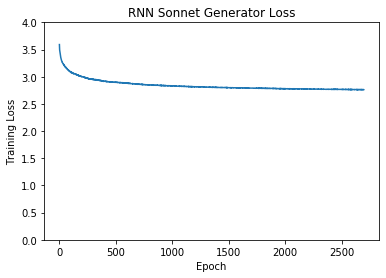

In [424]:
plt.plot(list(range(len(training_loss_history[:2697]))), training_loss_history[:2697])
plt.title("RNN Sonnet Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.ylim([0,4])
plt.savefig("RNN_loss.png", dpi=300)

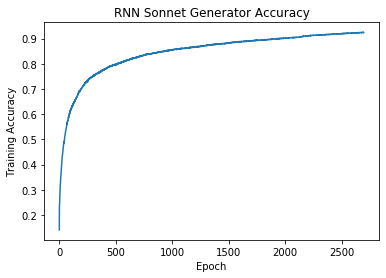

In [425]:
plt.plot(list(range(len(training_accuracy_history[:2697]))), training_accuracy_history[:2697])
plt.title("RNN Sonnet Generator Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.savefig("RNN_accuracy.png", dpi = 400)

What does this thing emit now?

In [413]:
print(f'\n\tloss: {training_loss_history[epoch]:0.4f}, acc: {training_accuracy_history[epoch]:0.4f}')
print("End of epoch first-batch output weights:")
print(output[0,0,:])
print("End of epoch targets:")
print(next_char)
print("Best guess outputs:")
print(torch.argmax(output[0,:,:], dim=1))
with open(os.path.join('outputs_2', f'example_sonnet_epoch_final'), 'w') as outfile:
    outfile.write(f"Accuracy: {training_accuracy_history[epoch]}\n")
    outfile.write(f"Loss: {training_loss_history[epoch]}\n")
    outfile.write("Sonnet, max likelihood:\n")
    outfile.write(emmit_sonnet(model, most_probable_char))
    outfile.write("\n\n")
    for T in [0.25, 0.75, 1.5]:
        outfile.write(f"Sonnet, T = {T}:\n")
        outfile.write(emmit_sonnet(model, lambda m: pick_char(m, T), 'shall i compare thee to a summer\'s day\n'))
        outfile.write("\n\n")


	loss: 2.7619, acc: 0.9246
End of epoch first-batch output weights:
tensor([4.8605e-07, 9.9993e-01, 3.0888e-10, 2.4073e-09, 8.1938e-10, 2.5928e-07,
        2.8595e-07, 3.1361e-09, 9.8452e-08, 8.5710e-07, 7.6731e-09, 4.5118e-11,
        1.5425e-08, 4.6014e-11, 2.4120e-12, 6.8482e-10, 4.2980e-06, 3.1602e-07,
        1.7654e-09, 3.7870e-11, 1.1441e-10, 3.1604e-05, 3.7228e-07, 5.3215e-11,
        1.5815e-08, 4.1434e-17, 5.4449e-10, 2.4165e-05, 2.1716e-10, 4.1852e-09,
        1.9626e-08, 7.9646e-06, 2.5201e-07, 3.2201e-08, 2.7259e-08, 2.2452e-15,
        4.5749e-07, 1.0520e-11], grad_fn=<SliceBackward>)
End of epoch targets:
tensor([ 1, 35, 17, 15,  1,  1, 11,  3, 22, 30,  1, 24,  3, 19,  5,  7, 15, 15,
        25, 23,  1,  3, 27, 27,  1, 36, 27, 27,  1,  3, 31, 15, 17,  4, 24,  3,
        25,  5, 19, 30, 14, 27, 25, 10, 11, 19, 33, 33, 23, 30, 25, 22, 23, 22,
        27, 30, 22,  3, 17, 25, 22, 10, 11])
Best guess outputs:
tensor([ 1, 35, 17, 15,  1,  1, 11,  3, 22, 30,  1, 24,  3, 19,  5

In [377]:
with torch.no_grad():
    model.eval()
    next_input = "against that time (if ever that time com"
    output_sonnet = next_input
    print(next_input, end="")
    line_count = 0
    hidden_state = None    
    cell_state = None
    while line_count < 14:
        in_tensor = torch.tensor([[char_to_num(c) for c in next_input]]).float()
#         next_char_weights, (hidden_state, cell_state) = trained_model(in_tensor, (hidden_state, cell_state))
        next_char_weights, (hidden_state, cell_state) = model(in_tensor)
        next_char_weihts = next_char_weights[0,0,:]
#         print(next_char_weights)
#         print(next_char_weights.shape)
        next_char = pick_char(next_char_weights)
#         print(next_char)
        output_sonnet += next_char
        if next_char == "\n":
            line_count += 1
        next_input = next_input[1:] + next_char
        print(next_char, end="")

against that time (if ever that time come,
when sove home burs such my love shall of the fore,
sume porld sich my boush shell well bear,
whing my ir wall will bear ve beart where when my sell,
foourd comemy be be beart my leases soe,
whing my love shall of the for will beart,
for oh my were wherend my hall beart love,
whan my sell gove she por thy for whill,
of my leve,
my love quclose pome,
for whin bure pore wirl beart whell of the see,
when soush my bear now buch shaw  nome be

for whing shes port will,
